In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes, EfficientSU2, TwoLocal,PauliTwoDesign,  PauliFeatureMap,ZFeatureMap
from qiskit_machine_learning.algorithms import VQC
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
from qiskit.primitives import Sampler
import time
from keras import Sequential
from keras.layers import Dense

2024-06-19 04:45:46.238845: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-19 04:45:52.693629: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-19 04:45:52.693695: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-06-19 04:46:04.929908: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-06-1

# **Visualization of The dataset using PCA decomposition.**

In [2]:
iris = load_iris()

X, Y = iris['data'], iris['target']

X_scaled = MinMaxScaler().fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

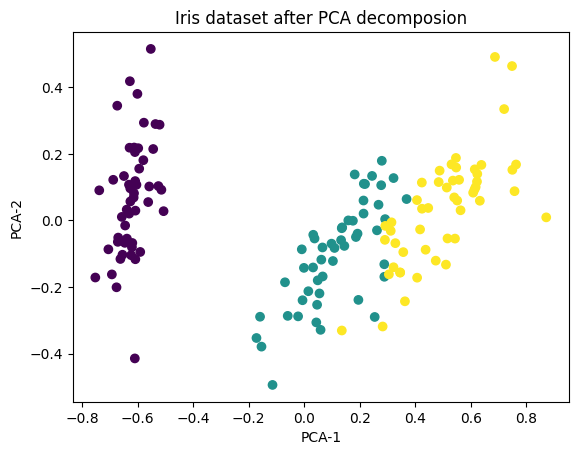

In [3]:
pca = PCA(n_components=2).fit_transform(X_scaled)

plt.scatter(pca[:,0], pca[:,1], c=Y)
plt.title('Iris dataset after PCA decomposion')
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.show()

# **Testing VQC of ZZFeatureMap FeatureMap and RealAmplitudes Ansatz**

In [4]:
MAXITR = 100
num_qubits = X.shape[1]
opt = COBYLA(maxiter=MAXITR)

In [5]:
featuremap = ZZFeatureMap(feature_dimension=num_qubits, reps=1, parameter_prefix='x')
ansatz = RealAmplitudes(num_qubits=num_qubits, reps=1)

/home/gzuz/.local/lib/python3.8/site-packages/qiskit/visualization/circuit/matplotlib.py:266: UserWarning: Style JSON file 'ixq.json' not found in any of these locations: /home/gzuz/.local/lib/python3.8/site-packages/qiskit/visualization/circuit/styles/ixq.json, ixq.json. Will use default style.
  self._style, def_font_ratio = load_style(self._style)


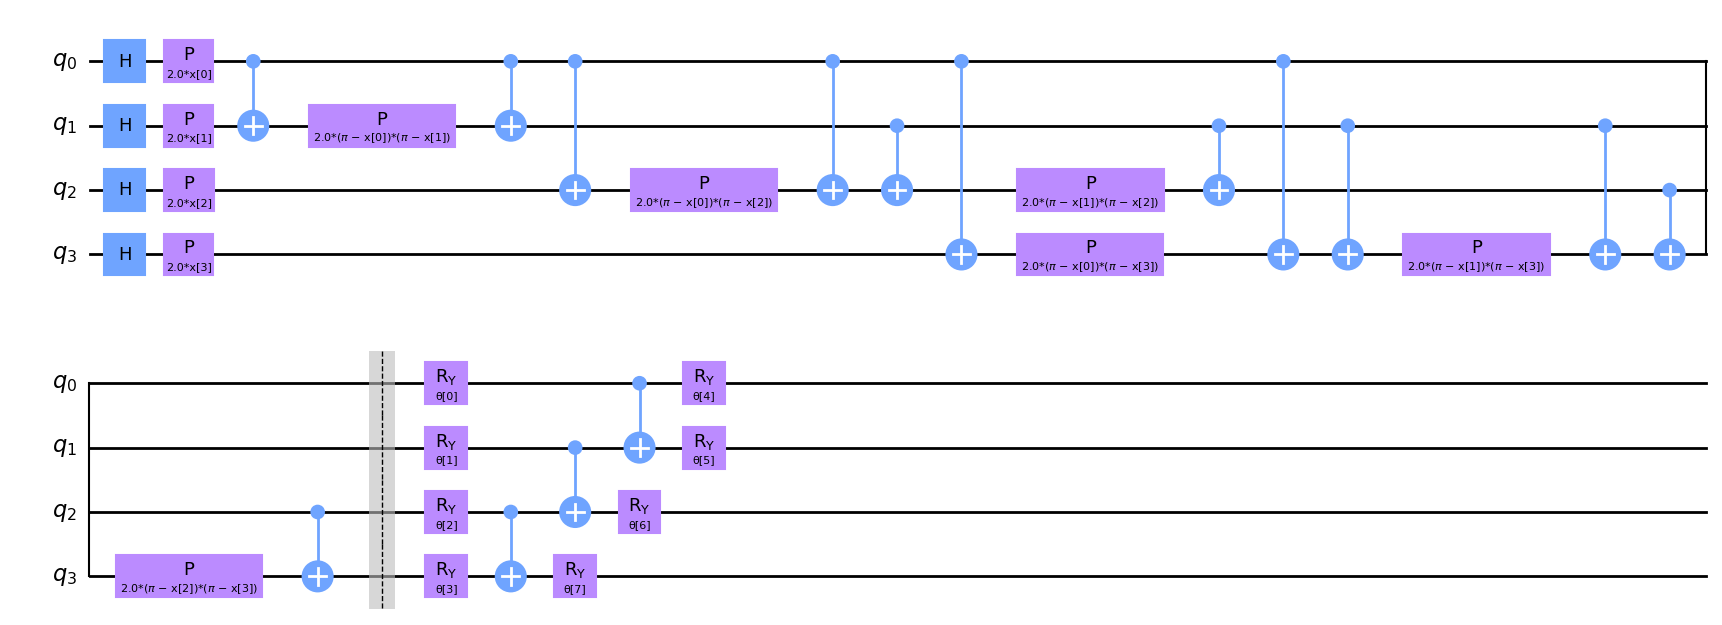

In [6]:
qc = QuantumCircuit(num_qubits)
qc.compose(featuremap, inplace=True)
qc.barrier()
qc.compose(ansatz, inplace=True)
qc.decompose().draw(output='mpl', style='ixq')

In [4]:
objective_func_vals = []

def callback_graph(weights, obj_func_eval):
  clear_output(wait=True)
  objective_func_vals.append(obj_func_eval)
  plt.title("Objective function value against iteration")
  plt.xlabel("Iteration")
  plt.ylabel("Objective function value")
  plt.plot(range(len(objective_func_vals)), objective_func_vals)
  plt.show()

In [27]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []

In [28]:
vqc = VQC(
    feature_map=featuremap,
    ansatz=ansatz,
    optimizer=opt,
    callback=callback_graph,
)

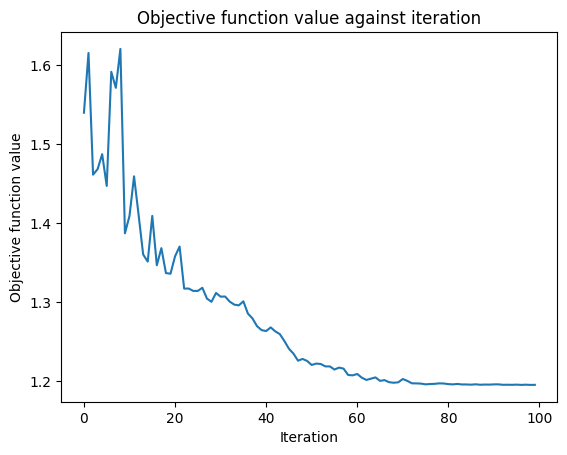

In [29]:
start = time.time()
vqc.fit(X_train, Y_train)
elapsed = time.time() - start

In [30]:
preds = vqc.predict(X_test)
score = vqc.score(X_test, Y_test)
precision = precision_score(Y_test, preds, average='weighted')
accuracy = accuracy_score(Y_test, preds)
recall = recall_score(Y_test, preds, average='macro')
f1 = f1_score(Y_test, preds, average='weighted')

In [31]:
times.append(elapsed)
precisions.append(precision)
accuracies.append(accuracy)
recalls.append(recall)
f1s.append(f1)

In [32]:
print("Time:\n",times)
print("Precision:\n",precisions)
print("Accuracy:\n",accuracies)
print("Recalls:\n",recalls)
print("F1:\n",f1s)

Time:
 [66.56257200241089]
Precision:
 [0.7742424242424242]
Accuracy:
 [0.7666666666666667]
Recalls:
 [0.7622895622895624]
F1:
 [0.7655555555555555]


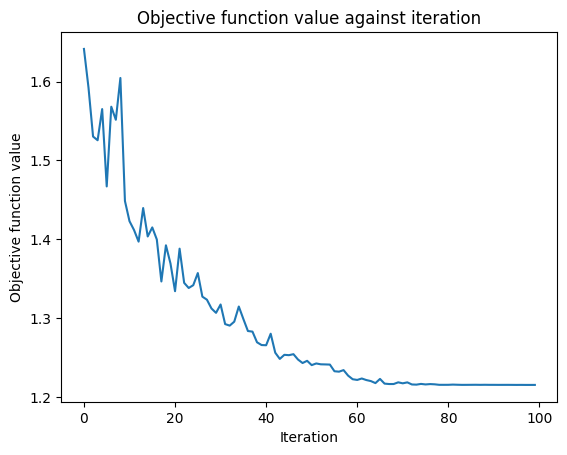

Time:
 [66.56257200241089, 70.58274340629578, 70.8100152015686, 69.84548425674438, 69.60666155815125, 72.19272422790527, 70.9717276096344, 67.38492774963379, 63.87564826011658, 64.16067838668823]
Precision:
 [0.7742424242424242, 0.8143518518518519, 0.7725274725274726, 0.7725274725274726, 0.8025925925925925, 0.7725274725274726, 0.7688888888888888, 0.7412698412698412, 0.7774358974358974, 0.7519117647058824]
Accuracy:
 [0.7666666666666667, 0.7, 0.7666666666666667, 0.7666666666666667, 0.8, 0.7666666666666667, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 0.7]
Recalls:
 [0.7622895622895624, 0.7138047138047138, 0.7585858585858586, 0.7585858585858586, 0.7956228956228957, 0.7585858585858586, 0.7313131313131315, 0.7252525252525253, 0.7343434343434344, 0.7138047138047138]
F1:
 [0.7655555555555555, 0.6807096171802055, 0.7638888888888888, 0.7638888888888888, 0.7999999999999999, 0.7638888888888888, 0.7406698564593301, 0.728859649122807, 0.7355284346131028, 0.6773057371096587]


In [33]:
for i in range(9):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 100
  num_qubits = X.shape[1]
  opt = COBYLA(maxiter=MAXITR)

  featuremap = ZZFeatureMap(feature_dimension=num_qubits, reps=1, parameter_prefix='x')
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=1)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  score = vqc.score(X_test, Y_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Time:\n",times)
  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)


**Precision:**
 [0.7742424242424242, 0.8143518518518519, 0.7725274725274726, 0.7725274725274726, 0.8025925925925925, 0.7725274725274726, 0.7688888888888888, 0.7412698412698412, 0.7774358974358974, 0.7519117647058824]
**Mean Precision**
0.7748275678569796±0.02


**Accuracy:**
 [0.7666666666666667, 0.7, 0.7666666666666667, 0.7666666666666667, 0.8, 0.7666666666666667, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 0.7]
**Mean Accuracy:**
0.7466666666666667±0.03

**Recall:**
 [0.7622895622895624, 0.7138047138047138, 0.7585858585858586, 0.7585858585858586, 0.7956228956228957, 0.7585858585858586, 0.7313131313131315, 0.7252525252525253, 0.7343434343434344, 0.7138047138047138]
**Mean Recall:**
0.7452188552188552±0.0246

**F1:**
 [0.7655555555555555, 0.6807096171802055, 0.7638888888888888, 0.7638888888888888, 0.7999999999999999, 0.7638888888888888, 0.7406698564593301, 0.728859649122807, 0.7355284346131028, 0.6773057371096587]
**Mean F1:**
0.7420295516707327±0.037

**Time:**
 [66.56257200241089, 70.58274340629578, 70.8100152015686, 69.84548425674438, 69.60666155815125, 72.19272422790527, 70.9717276096344, 67.38492774963379, 63.87564826011658, 64.16067838668823]
**Mean Time**
68.59931826591492±2.785092114900759



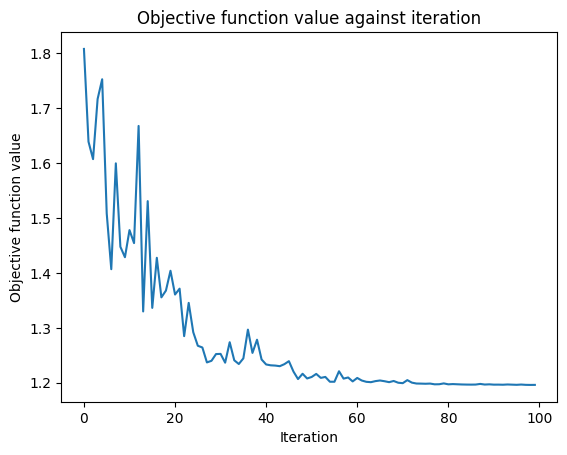

Precision:
 [0.7888888888888889, 0.8996969696969698, 0.7333333333333333, 0.8703703703703705, 0.704871794871795, 0.819047619047619, 0.8143939393939393, 0.8380952380952381, 0.8703703703703705, 0.7523809523809523]
Accuracy:
 [0.7666666666666667, 0.9, 0.7333333333333333, 0.8666666666666667, 0.6666666666666666, 0.8, 0.7666666666666667, 0.7666666666666667, 0.8666666666666667, 0.7333333333333333]
Recalls:
 [0.7683501683501683, 0.9023569023569024, 0.7447811447811447, 0.872053872053872, 0.6804713804713804, 0.8114478114478114, 0.7713804713804714, 0.7781144781144781, 0.872053872053872, 0.7373737373737373]
F1:
 [0.7715909090909091, 0.8984126984126986, 0.729090909090909, 0.863030303030303, 0.646969696969697, 0.7888888888888889, 0.7708994708994709, 0.7675191815856778, 0.863030303030303, 0.7222222222222221]
Time:
 [69.93372702598572, 61.62317371368408, 55.63222575187683, 55.72345304489136, 54.843199014663696, 53.92969560623169, 55.118656158447266, 55.74837136268616, 55.35867190361023, 55.534770250320

In [34]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 100
  num_qubits = X.shape[1]
  opt = COBYLA(maxiter=MAXITR)

  featuremap = ZZFeatureMap(feature_dimension=num_qubits, reps=1, parameter_prefix='x')
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=2)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  score = vqc.score(X_test, Y_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)



**Precision:**
 [0.7888888888888889, 0.8996969696969698, 0.7333333333333333, 0.8703703703703705, 0.704871794871795, 0.819047619047619, 0.8143939393939393, 0.8380952380952381, 0.8703703703703705, 0.7523809523809523]
**Mean Precision**
0.8091449476449476±0.06

**Accuracy:**
 [0.7666666666666667, 0.9, 0.7333333333333333, 0.8666666666666667, 0.6666666666666666, 0.8, 0.7666666666666667, 0.7666666666666667, 0.8666666666666667, 0.7333333333333333]
**Mean Accuracy:**
0.7866666666666666±0.069

**Recall:**
 [0.7683501683501683, 0.9023569023569024, 0.7447811447811447, 0.872053872053872, 0.6804713804713804, 0.8114478114478114, 0.7713804713804714, 0.7781144781144781, 0.872053872053872, 0.7373737373737373]
**Mean Recall:**
0.7938383838383837±0.0665

**F1:**
 [0.7715909090909091, 0.8984126984126986, 0.729090909090909, 0.863030303030303, 0.646969696969697, 0.7888888888888889, 0.7708994708994709, 0.7675191815856778, 0.863030303030303, 0.7222222222222221]
**Mean F1**
0.7420295516707327±0.037

**Time:**
 [69.93372702598572, 61.62317371368408, 55.63222575187683, 55.72345304489136, 54.843199014663696, 53.92969560623169, 55.118656158447266, 55.74837136268616, 55.35867190361023, 55.534770250320435]
**Mean Time**
57.344594383239745±4.6367380797109154




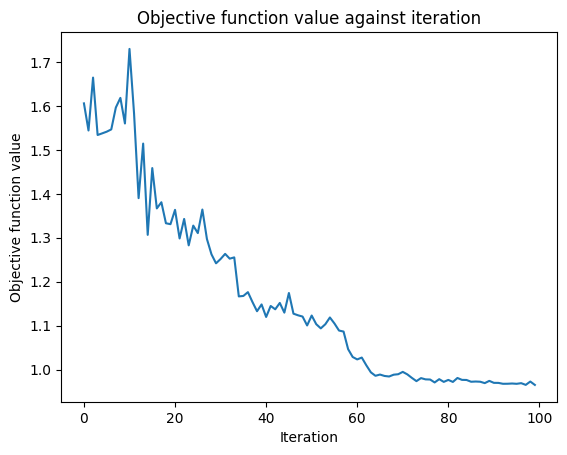

Precision:
 [0.8038105413105413, 0.8855769230769232, 0.9230769230769231, 0.7416666666666667, 0.8897435897435898, 0.8855769230769232, 0.9111111111111112, 0.85, 0.865530303030303, 0.9121212121212121]
Accuracy:
 [0.8, 0.8666666666666667, 0.9, 0.6666666666666666, 0.8666666666666667, 0.8666666666666667, 0.9, 0.8333333333333334, 0.8666666666666667, 0.9]
Recalls:
 [0.7956228956228957, 0.8653198653198654, 0.9023569023569024, 0.67003367003367, 0.872053872053872, 0.8653198653198654, 0.9023569023569024, 0.8319865319865319, 0.8653198653198654, 0.9060606060606061]
F1:
 [0.7982284141726865, 0.86691389599318, 0.9022080136402387, 0.6522435897435898, 0.8652936689549963, 0.86691389599318, 0.8996969696969698, 0.8352272727272728, 0.8645191409897293, 0.9]
Time:
 [60.19067358970642, 60.928030014038086, 61.18477392196655, 52.18880915641785, 46.61422562599182, 46.44520831108093, 46.49558162689209, 46.169156074523926, 46.00507569313049, 46.55289316177368]


In [35]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 100
  num_qubits = X.shape[1]
  opt = COBYLA(maxiter=MAXITR)

  featuremap = ZZFeatureMap(feature_dimension=num_qubits, reps=1, parameter_prefix='x')
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=3)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  score = vqc.score(X_test, Y_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)


**Precision:**
 [0.8038105413105413, 0.8855769230769232, 0.9230769230769231, 0.7416666666666667, 0.8897435897435898, 0.8855769230769232, 0.9111111111111112, 0.85, 0.865530303030303, 0.9121212121212121]
**Mean Precision**
0.8668214193214194±0.053

**Accuracy:**
 [0.8, 0.8666666666666667, 0.9, 0.6666666666666666, 0.8666666666666667, 0.8666666666666667, 0.9, 0.8333333333333334, 0.8666666666666667, 0.9]
**Mean Accuracy**
0.8466666666666667±0.067

**Recall:**
 [0.7956228956228957, 0.8653198653198654, 0.9023569023569024, 0.67003367003367, 0.872053872053872, 0.8653198653198654, 0.9023569023569024, 0.8319865319865319, 0.8653198653198654, 0.9060606060606061]
**Mean Recall**
0.8476430976430975±0.067

**F1:**
 [0.7982284141726865, 0.86691389599318, 0.9022080136402387, 0.6522435897435898, 0.8652936689549963, 0.86691389599318, 0.8996969696969698, 0.8352272727272728, 0.8645191409897293, 0.9]
**Mean F1**
0.8451244861911844±0.07104980578755521

**Time:**
 [60.19067358970642, 60.928030014038086, 61.18477392196655, 52.18880915641785, 46.61422562599182, 46.44520831108093, 46.49558162689209, 46.169156074523926, 46.00507569313049, 46.55289316177368]
**Mean Time**
51.277442717552184±6.44780128099729


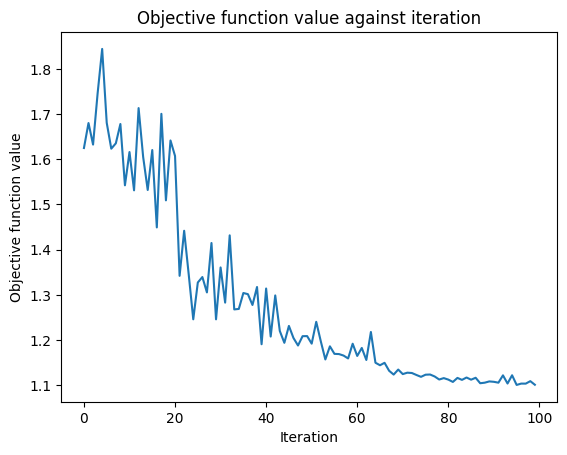

Precision:
 [0.7977272727272726, 0.6666666666666666, 0.7534920634920635, 0.7982154882154883, 0.8058333333333334, 0.8033333333333333, 0.9013888888888889, 0.8062962962962963, 0.9121212121212121, 0.83517316017316]
Accuracy:
 [0.8, 0.6666666666666666, 0.7333333333333333, 0.8, 0.8, 0.8, 0.9, 0.8, 0.9, 0.8333333333333334]
Recalls:
 [0.794949494949495, 0.6707070707070707, 0.7356902356902357, 0.8047138047138046, 0.8016835016835017, 0.8016835016835017, 0.8956228956228957, 0.7986531986531987, 0.9060606060606061, 0.8282828282828283]
F1:
 [0.7974789915966388, 0.6656641604010025, 0.7249649122807018, 0.7951796157059315, 0.7991511756217639, 0.8004177109440267, 0.89923273657289, 0.8017543859649123, 0.9, 0.829416839199448]
Time:
 [50.38809585571289, 50.08720111846924, 51.57299590110779, 50.65134572982788, 50.41527032852173, 50.47921872138977, 50.5826153755188, 50.86072587966919, 50.740474224090576, 51.58808517456055]


In [36]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 100
  num_qubits = X.shape[1]
  opt = COBYLA(maxiter=MAXITR)

  featuremap = ZZFeatureMap(feature_dimension=num_qubits, reps=1, parameter_prefix='x')
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=4)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  score = vqc.score(X_test, Y_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)


**Precision:**
 [0.7977272727272726, 0.6666666666666666, 0.7534920634920635, 0.7982154882154883, 0.8058333333333334, 0.8033333333333333, 0.9013888888888889, 0.8062962962962963, 0.9121212121212121, 0.83517316017316]
**Mean Precision**
0.8080247715247715±0.066

**Accuracy:**
 [0.8, 0.6666666666666666, 0.7333333333333333, 0.8, 0.8, 0.8, 0.9, 0.8, 0.9, 0.8333333333333334]
**Mean Accuracy**
0.8033333333333335±0.066


**Recall:**
 [0.794949494949495, 0.6707070707070707, 0.7356902356902357, 0.8047138047138046, 0.8016835016835017, 0.8016835016835017, 0.8956228956228957, 0.7986531986531987, 0.9060606060606061, 0.8282828282828283]
**Mean Recall**
0.8038047138047139±0.065

**F1:**
 [0.7974789915966388, 0.6656641604010025, 0.7249649122807018, 0.7951796157059315, 0.7991511756217639, 0.8004177109440267, 0.89923273657289, 0.8017543859649123, 0.9, 0.829416839199448]
**Mean F1**
0.8013260528287315±0.067
**Time:**
 [50.38809585571289, 50.08720111846924, 51.57299590110779, 50.65134572982788, 50.41527032852173, 50.47921872138977, 50.5826153755188, 50.86072587966919, 50.740474224090576, 51.58808517456055]
**Mean Time**
50.73660283088684±0.46729635466707753


# **Testing VQC of ZZFeatureMap FeatureMap and TwoLocal Ansatz**

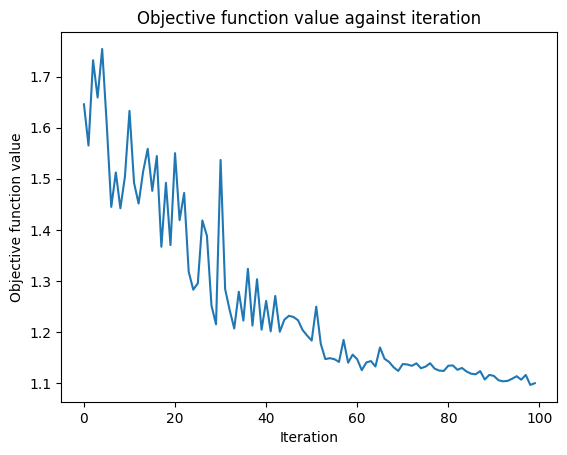

Precision:
 [0.8201465201465202, 0.8185185185185185, 0.7944444444444445, 0.834920634920635, 0.8842592592592593, 0.8544444444444445, 0.9033333333333334, 0.8564102564102565, 0.8774410774410775, 0.8713804713804713]
Accuracy:
 [0.7666666666666667, 0.8, 0.7666666666666667, 0.8333333333333334, 0.8666666666666667, 0.8333333333333334, 0.9, 0.8333333333333334, 0.8666666666666667, 0.8666666666666667]
Recalls:
 [0.7474747474747474, 0.8084175084175084, 0.7811447811447811, 0.8282828282828283, 0.8757575757575756, 0.8350168350168351, 0.9023569023569024, 0.8350168350168351, 0.872053872053872, 0.8757575757575756]
F1:
 [0.7333333333333333, 0.801027568922306, 0.7490196078431371, 0.828030303030303, 0.866265664160401, 0.8328548644338117, 0.9002506265664162, 0.8319603356216629, 0.8666666666666667, 0.8633333333333333]
Time:
 [44.59488654136658, 44.959097146987915, 45.13655686378479, 44.84427857398987, 45.00880241394043, 45.22632431983948, 45.15762257575989, 44.51168394088745, 45.331968545913696, 44.952611446

In [48]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 100
  num_qubits = X.shape[1]
  opt = COBYLA(maxiter=MAXITR)

  featuremap = ZZFeatureMap(feature_dimension=num_qubits, reps=1, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=1, rotation_blocks=['rz', 'ry'], entanglement_blocks='cz')




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  score = vqc.score(X_test, Y_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)


**Precision:**
 [0.8201465201465202, 0.8185185185185185, 0.7944444444444445, 0.834920634920635, 0.8842592592592593, 0.8544444444444445, 0.9033333333333334, 0.8564102564102565, 0.8774410774410775, 0.8713804713804713]
**Mean Precision**
0.8515298960298961±0.032

**Accuracy:**
 [0.7666666666666667, 0.8, 0.7666666666666667, 0.8333333333333334, 0.8666666666666667, 0.8333333333333334, 0.9, 0.8333333333333334, 0.8666666666666667, 0.8666666666666667]
**Mean Accuracy**
0.8333333333333334±0.042

**Recall:**
 [0.7474747474747474, 0.8084175084175084, 0.7811447811447811, 0.8282828282828283, 0.8757575757575756, 0.8350168350168351, 0.9023569023569024, 0.8350168350168351, 0.872053872053872, 0.8757575757575756]
**Mean Recall**
0.836127946127946±0.045

**F1:**
 [0.7333333333333333, 0.801027568922306, 0.7490196078431371, 0.828030303030303, 0.866265664160401, 0.8328548644338117, 0.9002506265664162, 0.8319603356216629, 0.8666666666666667, 0.8633333333333333]
**Mean F1**
0.8272742303911371±0.05
 
**Time:**
 [44.59488654136658, 44.959097146987915, 45.13655686378479, 44.84427857398987, 45.00880241394043, 45.22632431983948, 45.15762257575989, 44.51168394088745, 45.331968545913696, 44.952611446380615]
**Mean Time**
44.97238323688507±0.25062052229913884



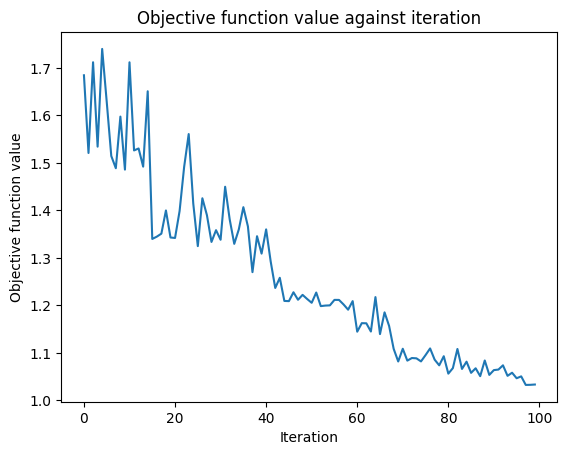

Precision:
 [0.9363636363636363, 0.9396969696969696, 0.9033333333333334, 0.8733333333333333, 0.9033333333333334, 0.75, 0.9333333333333333, 0.7596969696969696, 0.8672619047619048, 0.8441077441077441]
Accuracy:
 [0.9333333333333333, 0.9333333333333333, 0.9, 0.8666666666666667, 0.9, 0.7333333333333333, 0.9333333333333333, 0.7666666666666667, 0.8333333333333334, 0.8333333333333334]
Recalls:
 [0.9326599326599326, 0.9393939393939394, 0.9023569023569024, 0.869023569023569, 0.9023569023569024, 0.741077441077441, 0.9326599326599326, 0.7676767676767676, 0.8350168350168351, 0.8387205387205388]
F1:
 [0.9333333333333333, 0.931670843776107, 0.9002506265664162, 0.868421052631579, 0.9002506265664162, 0.731578947368421, 0.9333333333333333, 0.761904761904762, 0.8336085311317508, 0.8333333333333334]
Time:
 [54.210657358169556, 53.883872270584106, 54.13293099403381, 54.20532202720642, 53.9370801448822, 53.41452622413635, 53.44713091850281, 54.04611349105835, 53.71177005767822, 54.0597984790802]


In [38]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 100
  num_qubits = X.shape[1]
  opt = COBYLA(maxiter=MAXITR)

  featuremap = ZZFeatureMap(feature_dimension=num_qubits, reps=1, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=2, rotation_blocks=['rz', 'ry'], entanglement_blocks='cz')




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  score = vqc.score(X_test, Y_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)


**Precision:**
 [0.9363636363636363, 0.9396969696969696, 0.9033333333333334, 0.8733333333333333, 0.9033333333333334, 0.75, 0.9333333333333333, 0.7596969696969696, 0.8672619047619048, 0.8441077441077441]
**Mean Precision**
0.8710460557960558±0.065

**Accuracy:**
 [0.9333333333333333, 0.9333333333333333, 0.9, 0.8666666666666667, 0.9, 0.7333333333333333, 0.9333333333333333, 0.7666666666666667, 0.8333333333333334, 0.8333333333333334]
**Mean Accuracy**
0.8633333333333333±0.067

**Recall:**
 [0.9326599326599326, 0.9393939393939394, 0.9023569023569024, 0.869023569023569, 0.9023569023569024, 0.741077441077441, 0.9326599326599326, 0.7676767676767676, 0.8350168350168351, 0.8387205387205388]
**Mean Recall**
0.866094276094276±0.066

**F1:**
 [0.9333333333333333, 0.931670843776107, 0.9002506265664162, 0.868421052631579, 0.9002506265664162, 0.731578947368421, 0.9333333333333333, 0.761904761904762, 0.8336085311317508, 0.8333333333333334]
**Mean F1**
0.8627685389945452±0.068

**Time:**
 [54.210657358169556, 53.883872270584106, 54.13293099403381, 54.20532202720642, 53.9370801448822, 53.41452622413635, 53.44713091850281, 54.04611349105835, 53.71177005767822, 54.0597984790802]
**Mean Time**
53.904920196533205±0.27721286934858047



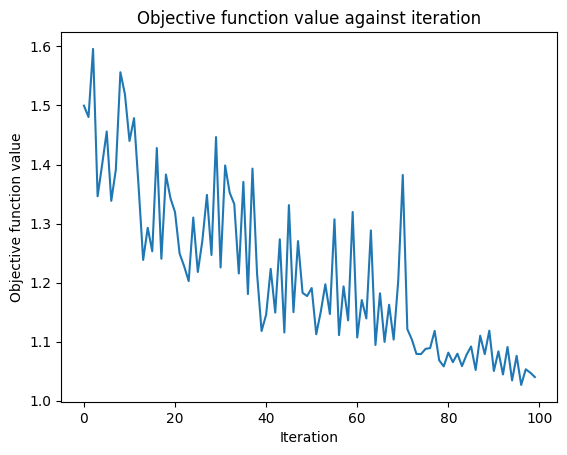

Precision:
 [0.9085858585858586, 0.8897435897435898, 0.9333333333333333, 0.837037037037037, 0.9700000000000001, 0.9151515151515152, 0.8855769230769232, 0.9444444444444445, 0.939141414141414, 0.9694444444444444]
Accuracy:
 [0.9, 0.8666666666666667, 0.9333333333333333, 0.8333333333333334, 0.9666666666666667, 0.9, 0.8666666666666667, 0.9333333333333333, 0.9333333333333333, 0.9666666666666667]
Recalls:
 [0.8956228956228957, 0.8585858585858586, 0.9326599326599326, 0.8350168350168351, 0.9696969696969697, 0.9090909090909092, 0.8653198653198654, 0.9326599326599326, 0.9259259259259259, 0.9629629629629629]
F1:
 [0.8988008971704624, 0.8631884057971015, 0.9333333333333333, 0.8296969696969697, 0.966750208855472, 0.8962322472848788, 0.86691389599318, 0.9345895934131228, 0.9306849551414769, 0.9664109121909632]
Time:
 [62.173508167266846, 62.279075622558594, 86.4977719783783, 108.60936713218689, 102.58006286621094, 99.35063433647156, 98.47975254058838, 80.20636653900146, 79.88814616203308, 80.26099777

In [39]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 100
  num_qubits = X.shape[1]
  opt = COBYLA(maxiter=MAXITR)

  featuremap = ZZFeatureMap(feature_dimension=num_qubits, reps=1, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=3, rotation_blocks=['rz', 'ry'], entanglement_blocks='cz')




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  score = vqc.score(X_test, Y_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)


**Precision:**
 [0.9085858585858586, 0.8897435897435898, 0.9333333333333333, 0.837037037037037, 0.9700000000000001, 0.9151515151515152, 0.8855769230769232, 0.9444444444444445, 0.939141414141414, 0.9694444444444444]
**Mean Precision**
 0.9192458559958562±0.039

**Accuracy:**
 [0.9, 0.8666666666666667, 0.9333333333333333, 0.8333333333333334, 0.9666666666666667, 0.9, 0.8666666666666667, 0.9333333333333333, 0.9333333333333333, 0.9666666666666667]
**Mean Accuracy**
0.9099999999999999±0.042

**Recall:**
 [0.8956228956228957, 0.8585858585858586, 0.9326599326599326, 0.8350168350168351, 0.9696969696969697, 0.9090909090909092, 0.8653198653198654, 0.9326599326599326, 0.9259259259259259, 0.9629629629629629]
**Mean Recall**
0.9087542087542089±0.0425

**F1:**
 [0.8988008971704624, 0.8631884057971015, 0.9333333333333333, 0.8296969696969697, 0.966750208855472, 0.8962322472848788, 0.86691389599318, 0.9345895934131228, 0.9306849551414769, 0.9664109121909632]
**Mean F1**
0.908660141887696±0.0433

**Time:**
 [62.173508167266846, 62.279075622558594, 86.4977719783783, 108.60936713218689, 102.58006286621094, 99.35063433647156, 98.47975254058838, 80.20636653900146, 79.88814616203308, 80.2609977722168]
**Mean Time**
86.03256831169128±15.344522985034029
 


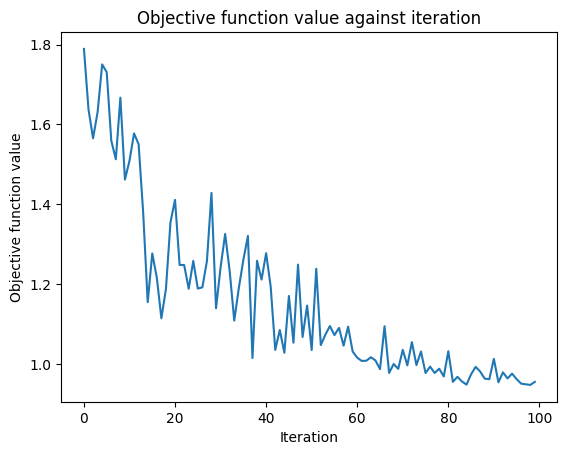

Precision:
 [0.9363636363636363, 0.8996969696969698, 0.6705128205128206, 0.9696969696969696, 0.9361111111111111, 0.8173160173160172, 0.9700000000000001, 0.8630769230769231, 0.7615384615384616, 0.9144444444444445]
Accuracy:
 [0.9333333333333333, 0.9, 0.5666666666666667, 0.9666666666666667, 0.9333333333333333, 0.8, 0.9666666666666667, 0.8333333333333334, 0.6666666666666666, 0.9]
Recalls:
 [0.9326599326599326, 0.9023569023569024, 0.5737373737373738, 0.9696969696969697, 0.9296296296296296, 0.8114478114478114, 0.9696969696969697, 0.8417508417508417, 0.6767676767676768, 0.9090909090909092]
F1:
 [0.9331465919701214, 0.8984126984126986, 0.574508281573499, 0.9666666666666667, 0.9331807780320366, 0.7904761904761904, 0.966750208855472, 0.8276718365963217, 0.6490469916556874, 0.8960127591706539]
Time:
 [90.98361325263977, 91.37946343421936, 91.3833520412445, 95.7776460647583, 97.4669578075409, 101.52251052856445, 75.88850355148315, 70.43185663223267, 69.19590926170349, 75.08839178085327]


In [40]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 100
  num_qubits = X.shape[1]
  opt = COBYLA(maxiter=MAXITR)

  featuremap = ZZFeatureMap(feature_dimension=num_qubits, reps=1, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=4, rotation_blocks=['rz', 'ry'], entanglement_blocks='cz')




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  score = vqc.score(X_test, Y_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)


**Precision:**
 [0.9363636363636363, 0.8996969696969698, 0.6705128205128206, 0.9696969696969696, 0.9361111111111111, 0.8173160173160172, 0.9700000000000001, 0.8630769230769231, 0.7615384615384616, 0.9144444444444445]
**Mean Precision**
 0.8738757353757354±0.092

**Accuracy:**
 [0.9333333333333333, 0.9, 0.5666666666666667, 0.9666666666666667, 0.9333333333333333, 0.8, 0.9666666666666667, 0.8333333333333334, 0.6666666666666666, 0.9]
**Mean Accuracy**
0.8466666666666667±0.127

**Recall:**
 [0.9326599326599326, 0.9023569023569024, 0.5737373737373738, 0.9696969696969697, 0.9296296296296296, 0.8114478114478114, 0.9696969696969697, 0.8417508417508417, 0.6767676767676768, 0.9090909090909092]
**Mean Recall**
0.8516835016835017±0.125

**F1:**
 [0.9331465919701214, 0.8984126984126986, 0.574508281573499, 0.9666666666666667, 0.9331807780320366, 0.7904761904761904, 0.966750208855472, 0.8276718365963217, 0.6490469916556874, 0.8960127591706539]
**Mean F1**
0.8435873003409349±0.129

**Time:**
 [90.98361325263977, 91.37946343421936, 91.3833520412445, 95.7776460647583, 97.4669578075409, 101.52251052856445, 75.88850355148315, 70.43185663223267, 69.19590926170349, 75.08839178085327]
**Mean Time**
85.91182043552399±11.387579530303311

 


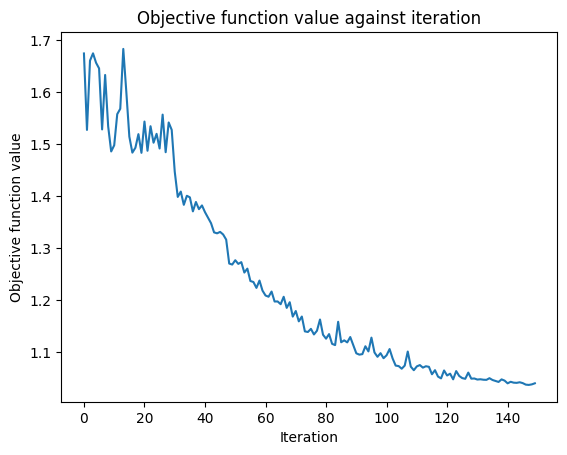

Precision:
 [0.8117424242424243, 0.9076923076923077, 0.834920634920635, 0.8208333333333333, 0.9013888888888889, 0.9333333333333333, 0.9033333333333334, 0.9333333333333333, 0.9096969696969697, 0.8185185185185185]
Accuracy:
 [0.8, 0.8666666666666667, 0.8333333333333334, 0.8, 0.9, 0.9333333333333333, 0.9, 0.9333333333333333, 0.9, 0.8]
Recalls:
 [0.8084175084175084, 0.8787878787878788, 0.8282828282828283, 0.8084175084175084, 0.8956228956228957, 0.9326599326599326, 0.9023569023569024, 0.9326599326599326, 0.9023569023569024, 0.8084175084175084]
F1:
 [0.795889724310777, 0.863973063973064, 0.828030303030303, 0.7987468671679198, 0.89923273657289, 0.9333333333333333, 0.9002506265664162, 0.9333333333333333, 0.9000918964076859, 0.801027568922306]
Time:
 [86.60657835006714, 87.43600845336914, 89.65518283843994, 88.20548510551453, 89.54974269866943, 88.60578560829163, 89.357253074646, 88.58420181274414, 89.22101879119873, 87.35461163520813]


In [41]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)

  MAXITR = 150
  num_qubits = X.shape[1]
  opt = COBYLA(maxiter=MAXITR)

  featuremap = ZZFeatureMap(feature_dimension=num_qubits, reps=1, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=1, rotation_blocks=['rz', 'ry'], entanglement_blocks='cz')




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  score = vqc.score(X_test, Y_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)


**Precision:**
 [0.8117424242424243, 0.9076923076923077, 0.834920634920635, 0.8208333333333333, 0.9013888888888889, 0.9333333333333333, 0.9033333333333334, 0.9333333333333333, 0.9096969696969697, 0.8185185185185185]
**Mean Precision**
0.8774793077293077±0.047

**Accuracy:**
 [0.8, 0.8666666666666667, 0.8333333333333334, 0.8, 0.9, 0.9333333333333333, 0.9, 0.9333333333333333, 0.9, 0.8]
**Mean Accuracy**
0.8666666666666668±0.051

**Recall:**
 [0.8084175084175084, 0.8787878787878788, 0.8282828282828283, 0.8084175084175084, 0.8956228956228957, 0.9326599326599326, 0.9023569023569024, 0.9326599326599326, 0.9023569023569024, 0.8084175084175084]
**Mean Recall**
0.8697979797979798±0.0488

**F1:**
 [0.795889724310777, 0.863973063973064, 0.828030303030303, 0.7987468671679198, 0.89923273657289, 0.9333333333333333, 0.9002506265664162, 0.9333333333333333, 0.9000918964076859, 0.801027568922306]
**Mean F1**
0.8653909453618027±0.0525

**Time:**
 [86.60657835006714, 87.43600845336914, 89.65518283843994, 88.20548510551453, 89.54974269866943, 88.60578560829163, 89.357253074646, 88.58420181274414, 89.22101879119873, 87.35461163520813]
**Mean Time**
88.45758683681488±0.99031444076999



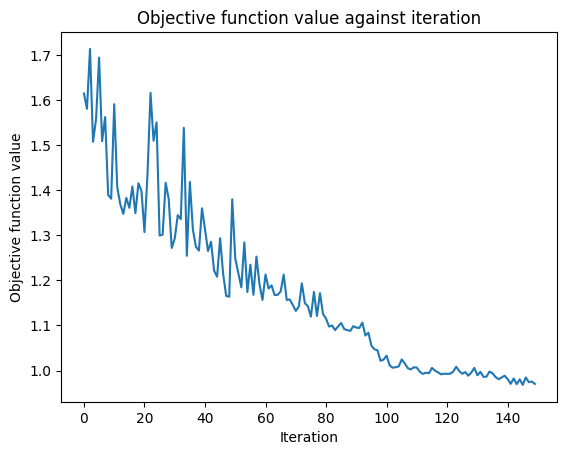

Precision:
 [0.9111111111111112, 0.9694444444444444, 0.9333333333333333, 0.9454545454545454, 0.9055555555555556, 0.8296969696969697, 1.0, 0.8595238095238095, 0.9076923076923077, 0.8333333333333334]
Accuracy:
 [0.9, 0.9666666666666667, 0.9333333333333333, 0.9333333333333333, 0.9, 0.8333333333333334, 1.0, 0.8, 0.8666666666666667, 0.8333333333333334]
Recalls:
 [0.9023569023569024, 0.9629629629629629, 0.9326599326599326, 0.9393939393939394, 0.8993265993265993, 0.8350168350168351, 1.0, 0.8030303030303031, 0.8787878787878788, 0.8282828282828283]
F1:
 [0.8996969696969698, 0.9664109121909632, 0.9333333333333333, 0.9333333333333333, 0.9012967200610221, 0.8301587301587302, 1.0, 0.7903381642512077, 0.863973063973064, 0.8320545609548167]
Time:
 [82.50979900360107, 79.69241976737976, 80.55432534217834, 80.41987109184265, 81.07120633125305, 79.80186176300049, 79.24395322799683, 79.38226199150085, 79.7204978466034, 80.376638174057]


In [42]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)

  MAXITR = 150
  num_qubits = X.shape[1]
  opt = COBYLA(maxiter=MAXITR)

  featuremap = ZZFeatureMap(feature_dimension=num_qubits, reps=1, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=2, rotation_blocks=['rz', 'ry'], entanglement_blocks='cz')




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  score = vqc.score(X_test, Y_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

**Precision:**
 [0.9111111111111112, 0.9694444444444444, 0.9333333333333333, 0.9454545454545454, 0.9055555555555556, 0.8296969696969697, 1.0, 0.8595238095238095, 0.9076923076923077, 0.8333333333333334]
**Mean Precision**
 0.9095145410145411±0.053

**Accuracy:**
 [0.9, 0.9666666666666667, 0.9333333333333333, 0.9333333333333333, 0.9, 0.8333333333333334, 1.0, 0.8, 0.8666666666666667, 0.8333333333333334]
**Mean Accuracy**
 0.8966666666666667±0.06

**Recall:**
 [0.9023569023569024, 0.9629629629629629, 0.9326599326599326, 0.9393939393939394, 0.8993265993265993, 0.8350168350168351, 1.0, 0.8030303030303031, 0.8787878787878788, 0.8282828282828283]
**Mean Recall**
0.8981818181818182±0.06
 
**F1:**
 [0.8996969696969698, 0.9664109121909632, 0.9333333333333333, 0.9333333333333333, 0.9012967200610221, 0.8301587301587302, 1.0, 0.7903381642512077, 0.863973063973064, 0.8320545609548167]
**Mean F1**
0.8950595787953441±0.063

**Time:**
 [82.50979900360107, 79.69241976737976, 80.55432534217834, 80.41987109184265, 81.07120633125305, 79.80186176300049, 79.24395322799683, 79.38226199150085, 79.7204978466034, 80.376638174057]
**Mean Time**
80.27728345394135±0.9202353133853681



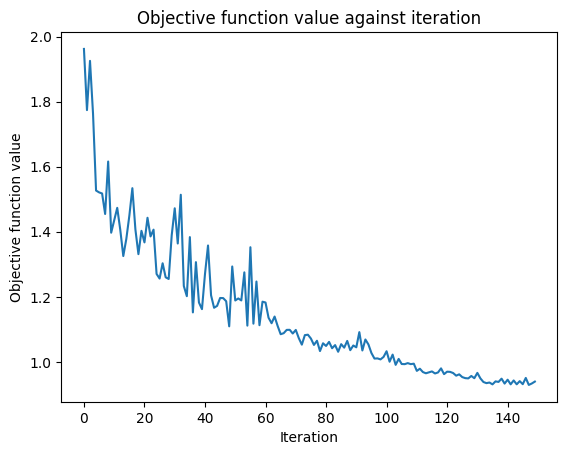

Precision:
 [0.8106959706959707, 0.9096969696969697, 0.9111111111111112, 0.865530303030303, 0.9333333333333333, 0.8666666666666667, 1.0, 0.8703703703703705, 0.9454545454545454, 0.9033333333333334]
Accuracy:
 [0.8, 0.9, 0.9, 0.8666666666666667, 0.9333333333333333, 0.8666666666666667, 1.0, 0.8666666666666667, 0.9333333333333333, 0.9]
Recalls:
 [0.8114478114478114, 0.9023569023569024, 0.9023569023569024, 0.8653198653198654, 0.9326599326599326, 0.8653198653198654, 1.0, 0.872053872053872, 0.9393939393939394, 0.9023569023569024]
F1:
 [0.786931095855581, 0.9000918964076859, 0.8996969696969698, 0.8645191409897293, 0.9333333333333333, 0.8666666666666667, 1.0, 0.863030303030303, 0.9333333333333333, 0.9002506265664162]
Time:
 [91.35236597061157, 92.0054726600647, 92.43176174163818, 91.1609239578247, 91.61616539955139, 91.9480152130127, 91.28360414505005, 91.862229347229, 90.63079619407654, 90.69785046577454]


In [43]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)

  MAXITR = 150
  num_qubits = X.shape[1]
  opt = COBYLA(maxiter=MAXITR)

  featuremap = ZZFeatureMap(feature_dimension=num_qubits, reps=1, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=3, rotation_blocks=['rz', 'ry'], entanglement_blocks='cz')




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  score = vqc.score(X_test, Y_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)


**Precision:**
 [0.8106959706959707, 0.9096969696969697, 0.9111111111111112, 0.865530303030303, 0.9333333333333333, 0.8666666666666667, 1.0, 0.8703703703703705, 0.9454545454545454, 0.9033333333333334]
**Mean Precision**
0.9016192603692605±0.05

**Accuracy:**
 [0.8, 0.9, 0.9, 0.8666666666666667, 0.9333333333333333, 0.8666666666666667, 1.0, 0.8666666666666667, 0.9333333333333333, 0.9]
**Mean Accuracy**
0.8966666666666667±0.05

**Recall:**
 [0.8114478114478114, 0.9023569023569024, 0.9023569023569024, 0.8653198653198654, 0.9326599326599326, 0.8653198653198654, 1.0, 0.872053872053872, 0.9393939393939394, 0.9023569023569024]
**Mean Recall**
0.8993265993265993±0.049

**F1:**
 [0.786931095855581, 0.9000918964076859, 0.8996969696969698, 0.8645191409897293, 0.9333333333333333, 0.8666666666666667, 1.0, 0.863030303030303, 0.9333333333333333, 0.9002506265664162]
**Mean F1**
0.8947853365880019±0.053
 
**Time:**
 [91.35236597061157, 92.0054726600647, 92.43176174163818, 91.1609239578247, 91.61616539955139, 91.9480152130127, 91.28360414505005, 91.862229347229, 90.63079619407654, 90.69785046577454]
**Mean Time**
91.49891850948333±0.5524172023673798




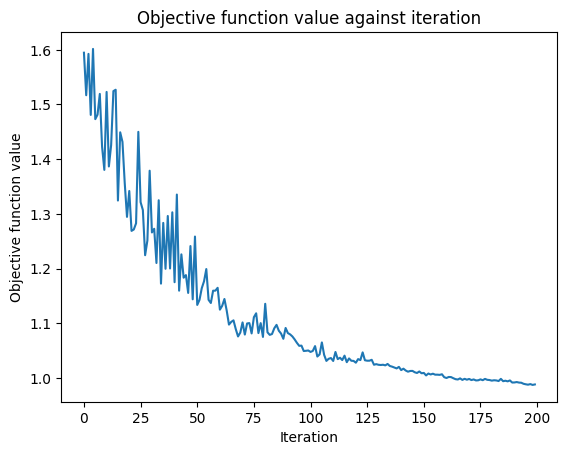

Precision:
 [0.9396969696969696, 0.9033333333333334, 0.9151515151515152, 0.8689562289562289, 0.8703703703703705, 0.9033333333333334, 0.9454545454545454, 0.8996969696969698, 1.0, 0.9444444444444445]
Accuracy:
 [0.9333333333333333, 0.9, 0.9, 0.8666666666666667, 0.8666666666666667, 0.9, 0.9333333333333333, 0.9, 1.0, 0.9333333333333333]
Recalls:
 [0.9393939393939394, 0.9023569023569024, 0.9090909090909092, 0.872053872053872, 0.872053872053872, 0.9023569023569024, 0.9393939393939394, 0.9023569023569024, 1.0, 0.9326599326599326]
F1:
 [0.931670843776107, 0.9002506265664162, 0.8962322472848788, 0.8634252297410192, 0.863030303030303, 0.9002506265664162, 0.9333333333333333, 0.8984126984126986, 1.0, 0.9345895934131228]
Time:
 [105.08695650100708, 107.26876163482666, 105.90548276901245, 107.14311718940735, 107.19193291664124, 105.748939037323, 105.8231143951416, 106.2774646282196, 105.54703640937805, 106.58420324325562]


In [44]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)

  MAXITR = 200
  num_qubits = X.shape[1]
  opt = COBYLA(maxiter=MAXITR)

  featuremap = ZZFeatureMap(feature_dimension=num_qubits, reps=1, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=2, rotation_blocks=['rz', 'ry'], entanglement_blocks='cz')




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  score = vqc.score(X_test, Y_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

**Precision:**
 [0.9396969696969696, 0.9033333333333334, 0.9151515151515152, 0.8689562289562289, 0.8703703703703705, 0.9033333333333334, 0.9454545454545454, 0.8996969696969698, 1.0, 0.9444444444444445]
**Mean Precision**
0.9190437710437711±0.0375

**Accuracy:**
 [0.9333333333333333, 0.9, 0.9, 0.8666666666666667, 0.8666666666666667, 0.9, 0.9333333333333333, 0.9, 1.0, 0.9333333333333333]
**Mean Accuracy**
0.9133333333333333±0.037

**Recall:**
 [0.9393939393939394, 0.9023569023569024, 0.9090909090909092, 0.872053872053872, 0.872053872053872, 0.9023569023569024, 0.9393939393939394, 0.9023569023569024, 1.0, 0.9326599326599326]
**Mean Recall**
0.9171717171717171±0.0359

**F1:**
 [0.931670843776107, 0.9002506265664162, 0.8962322472848788, 0.8634252297410192, 0.863030303030303, 0.9002506265664162, 0.9333333333333333, 0.8984126984126986, 1.0, 0.9345895934131228]
**Mean F1**
0.9121195502124294±0.038
 
**Time:**
 [105.08695650100708, 107.26876163482666, 105.90548276901245, 107.14311718940735, 107.19193291664124, 105.748939037323, 105.8231143951416, 106.2774646282196, 105.54703640937805, 106.58420324325562]
**Mean Time**
106.25770087242127±0.7234250342639803


# **Testing VQC of EfficientSU2 FeatureMap and RealAmplitudes Ansatz**

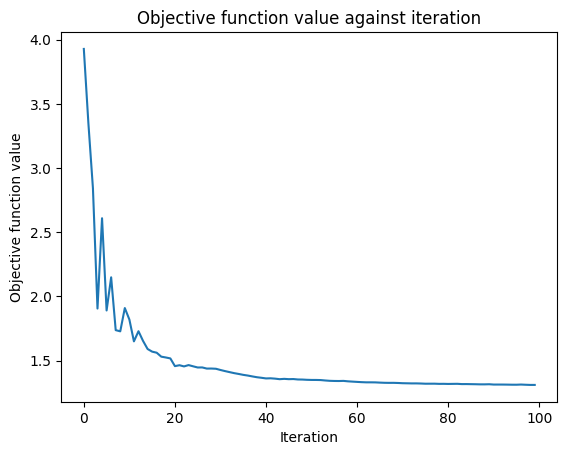

Precision:
 [0.7567765567765569, 0.7567765567765569, 0.5583333333333333, 0.4683333333333334, 0.7567765567765569, 0.45, 0.45, 0.45, 0.45964912280701753, 0.7583333333333333]
Accuracy:
 [0.7333333333333333, 0.7333333333333333, 0.5666666666666667, 0.4666666666666667, 0.7333333333333333, 0.5666666666666667, 0.5666666666666667, 0.5666666666666667, 0.5333333333333333, 0.7]
Recalls:
 [0.744107744107744, 0.744107744107744, 0.5932659932659933, 0.5, 0.744107744107744, 0.5925925925925926, 0.5925925925925926, 0.5925925925925926, 0.562962962962963, 0.7077441077441078]
F1:
 [0.7279461279461279, 0.7279461279461279, 0.522962962962963, 0.40842911877394633, 0.7279461279461279, 0.4888888888888889, 0.4888888888888889, 0.4888888888888889, 0.4677248677248677, 0.7104839393168912]
Time:
 [21.99620747566223, 21.679696083068848, 22.026463270187378, 21.12834882736206, 21.328312158584595, 21.330719709396362, 21.518117427825928, 21.876444578170776, 21.057515382766724, 21.2146475315094]


In [45]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 100
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=1)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

**Precision:**
 [0.7567765567765569, 0.7567765567765569, 0.5583333333333333, 0.4683333333333334, 0.7567765567765569, 0.45, 0.45, 0.45, 0.45964912280701753, 0.7583333333333333]
**Mean Precision**
0.5864978793136689±0.14

**Accuracy:**
 [0.7333333333333333, 0.7333333333333333, 0.5666666666666667, 0.4666666666666667, 0.7333333333333333, 0.5666666666666667, 0.5666666666666667, 0.5666666666666667, 0.5333333333333333, 0.7]
**Mean Accuracy**
0.6166666666666667±0.093

**Recall:**
 [0.744107744107744, 0.744107744107744, 0.5932659932659933, 0.5, 0.744107744107744, 0.5925925925925926, 0.5925925925925926, 0.5925925925925926, 0.562962962962963, 0.7077441077441078]
**Mean Recall**
0.6374074074074074±0.0845

**F1:**
 [0.7279461279461279, 0.7279461279461279, 0.522962962962963, 0.40842911877394633, 0.7279461279461279, 0.4888888888888889, 0.4888888888888889, 0.4888888888888889, 0.4677248677248677, 0.7104839393168912]
**Mean F1**
0.5760105939283717±0.12

**Time:**
 [21.99620747566223, 21.679696083068848, 22.026463270187378, 21.12834882736206, 21.328312158584595, 21.330719709396362, 21.518117427825928, 21.876444578170776, 21.057515382766724, 21.2146475315094]
**Mean Time**
21.51564724445343±0.34186873337975104


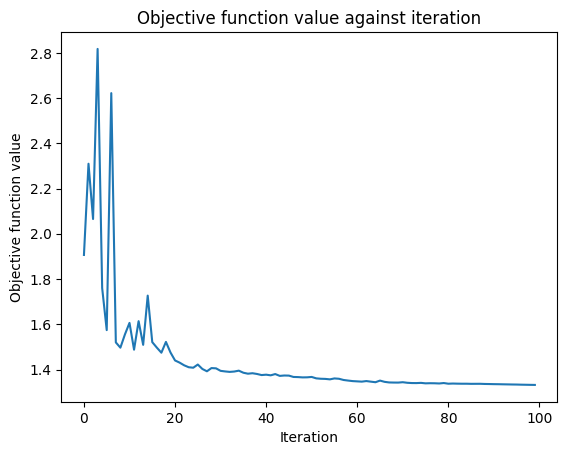

Time:
 [22.756049394607544, 23.868249893188477, 22.705666303634644, 23.627787828445435, 23.6456356048584, 23.85638451576233, 22.78916311264038, 23.099523305892944, 23.654366731643677, 23.619070291519165]
Precision:
 [0.4683333333333334, 0.3925925925925926, 0.45964912280701753, 0.45964912280701753, 0.7932012432012433, 0.4683333333333334, 0.7689393939393939, 0.5667600373482726, 0.7567765567765569, 0.7833333333333333]
Accuracy:
 [0.6333333333333333, 0.5, 0.6, 0.6, 0.7666666666666667, 0.6333333333333333, 0.7666666666666667, 0.5666666666666667, 0.7333333333333333, 0.7666666666666667]
Recalls:
 [0.6666666666666666, 0.5296296296296296, 0.6296296296296297, 0.6296296296296297, 0.7811447811447811, 0.6666666666666666, 0.7744107744107743, 0.593939393939394, 0.744107744107744, 0.7744107744107743]
F1:
 [0.5195402298850574, 0.42339181286549704, 0.5047619047619047, 0.5047619047619047, 0.7513284101519396, 0.5195402298850574, 0.7590392648287385, 0.5292609351432881, 0.7279461279461279, 0.7649122807017543

In [49]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 100
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=2)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Time:\n",times)
  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)

**Precision:**
 [0.4683333333333334, 0.3925925925925926, 0.45964912280701753, 0.45964912280701753, 0.7932012432012433, 0.4683333333333334, 0.7689393939393939, 0.5667600373482726, 0.7567765567765569, 0.7833333333333333]
**Mean Precision**
0.5917568069472094±0.155

**Accuracy:**
 [0.6333333333333333, 0.5, 0.6, 0.6, 0.7666666666666667, 0.6333333333333333, 0.7666666666666667, 0.5666666666666667, 0.7333333333333333, 0.7666666666666667]
**Mean Accuracy**
0.6566666666666666±0.09

**Recall:**
 [0.6666666666666666, 0.5296296296296296, 0.6296296296296297, 0.6296296296296297, 0.7811447811447811, 0.6666666666666666, 0.7744107744107743, 0.593939393939394, 0.744107744107744, 0.7744107744107743]
**Mean Recall**
0.679023569023569±0.082

**F1:**
 [0.5195402298850574, 0.42339181286549704, 0.5047619047619047, 0.5047619047619047, 0.7513284101519396, 0.5195402298850574, 0.7590392648287385, 0.5292609351432881, 0.7279461279461279, 0.7649122807017543]
**Mean F1**
0.6004483100931269±0.126

 **Time:**
 [22.756049394607544, 23.868249893188477, 22.705666303634644, 23.627787828445435, 23.6456356048584, 23.85638451576233, 22.78916311264038, 23.099523305892944, 23.654366731643677, 23.619070291519165]
**Mean Time**
23.3621896982193±0.4470286995485813


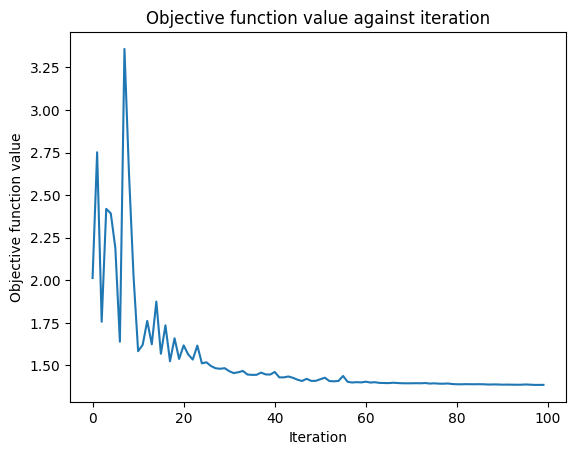

Time:
 [25.789013147354126, 25.433268308639526, 25.03989267349243, 25.6397488117218, 25.121809482574463, 25.098370790481567, 24.777003288269043, 25.56332278251648, 24.73639225959778, 25.676793098449707]
Precision:
 [0.7583333333333333, 0.45964912280701753, 0.45964912280701753, 0.7583333333333333, 0.45964912280701753, 0.4683333333333334, 0.7583333333333333, 0.45964912280701753, 0.45964912280701753, 0.45964912280701753]
Accuracy:
 [0.7, 0.6, 0.6, 0.7, 0.6, 0.6333333333333333, 0.7, 0.6, 0.6, 0.6]
Recalls:
 [0.7077441077441078, 0.6296296296296297, 0.6296296296296297, 0.7077441077441078, 0.6296296296296297, 0.6666666666666666, 0.7077441077441078, 0.6296296296296297, 0.6296296296296297, 0.6296296296296297]
F1:
 [0.7104839393168912, 0.5047619047619047, 0.5047619047619047, 0.7104839393168912, 0.5047619047619047, 0.5195402298850574, 0.7104839393168912, 0.5047619047619047, 0.5047619047619047, 0.5047619047619047]


In [46]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 100
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=3)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Time:\n",times)
  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)

**Precision:**
 [0.7583333333333333, 0.45964912280701753, 0.45964912280701753, 0.7583333333333333, 0.45964912280701753, 0.4683333333333334, 0.7583333333333333, 0.45964912280701753, 0.45964912280701753, 0.45964912280701753]
**Mean Precision**
0.5501228070175439±0.136

**Accuracy:**
 [0.7, 0.6, 0.6, 0.7, 0.6, 0.6333333333333333, 0.7, 0.6, 0.6, 0.6]
**Mean Accuracy**
0.6333333333333332±0.045


**Recall:**
 [0.7077441077441078, 0.6296296296296297, 0.6296296296296297, 0.7077441077441078, 0.6296296296296297, 0.6666666666666666, 0.7077441077441078, 0.6296296296296297, 0.6296296296296297, 0.6296296296296297]
**Mean Recall**
0.6567676767676769±0.035

**F1:**
 [0.7104839393168912, 0.5047619047619047, 0.5047619047619047, 0.7104839393168912, 0.5047619047619047, 0.5195402298850574, 0.7104839393168912, 0.5047619047619047, 0.5047619047619047, 0.5047619047619047]
**Mean F1**
 0.567956347640716±0.093

**Time:**
 [25.789013147354126, 25.433268308639526, 25.03989267349243, 25.6397488117218, 25.121809482574463, 25.098370790481567, 24.777003288269043, 25.56332278251648, 24.73639225959778, 25.676793098449707]
**Mean Time**
25.287561464309693±0.36239889293795874



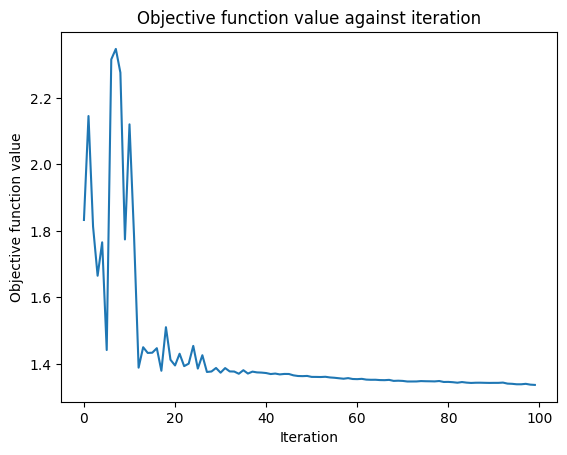

Time:
 [26.74177122116089, 27.020960092544556, 27.207302570343018, 27.02517294883728, 27.25152564048767, 26.827413320541382, 26.64131808280945, 26.52521586418152, 26.726413011550903, 26.03507924079895]
Precision:
 [0.7277777777777777, 0.6933333333333332, 0.45964912280701753, 0.7833333333333333, 0.6479166666666667, 0.7352380952380952, 0.7567765567765569, 0.4683333333333334, 0.7567765567765569, 0.6768627450980392]
Accuracy:
 [0.7, 0.6666666666666666, 0.6, 0.7666666666666667, 0.6333333333333333, 0.6666666666666666, 0.7333333333333333, 0.6333333333333333, 0.7333333333333333, 0.6]
Recalls:
 [0.7138047138047138, 0.6835016835016834, 0.6296296296296297, 0.7744107744107743, 0.6531986531986532, 0.6774410774410775, 0.744107744107744, 0.6666666666666666, 0.744107744107744, 0.6168350168350168]
F1:
 [0.6884910485933504, 0.6458333333333334, 0.5047619047619047, 0.7649122807017543, 0.599111111111111, 0.675, 0.7279461279461279, 0.5195402298850574, 0.7279461279461279, 0.5953347578347579]


In [50]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 100
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=4)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Time:\n",times)
  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)


**Precision:**
 [0.7277777777777777, 0.6933333333333332, 0.45964912280701753, 0.7833333333333333, 0.6479166666666667, 0.7352380952380952, 0.7567765567765569, 0.4683333333333334, 0.7567765567765569, 0.6768627450980392]
**Mean Precision**
0.670599752114071±0.11

**Accuracy:**
 [0.7, 0.6666666666666666, 0.6, 0.7666666666666667, 0.6333333333333333, 0.6666666666666666, 0.7333333333333333, 0.6333333333333333, 0.7333333333333333, 0.6]
**Mean Accuracy**
0.6733333333333333±0.055

**Recall:**
 [0.7138047138047138, 0.6835016835016834, 0.6296296296296297, 0.7744107744107743, 0.6531986531986532, 0.6774410774410775, 0.744107744107744, 0.6666666666666666, 0.744107744107744, 0.6168350168350168]
**Mean Recall**
 0.6903703703703703±0.05

**F1:**
 [0.6884910485933504, 0.6458333333333334, 0.5047619047619047, 0.7649122807017543, 0.599111111111111, 0.675, 0.7279461279461279, 0.5195402298850574, 0.7279461279461279, 0.5953347578347579]
**Mean F1**
 0.6448876922113524±0.084

**Time:**
 [26.74177122116089, 27.020960092544556, 27.207302570343018, 27.02517294883728, 27.25152564048767, 26.827413320541382, 26.64131808280945, 26.52521586418152, 26.726413011550903, 26.03507924079895]
**Mean Time**
26.800217199325562±0.3412687652203803




# **Testing VQC of EfficientSU2 FeatureMap and TwoLocal Ansatz**

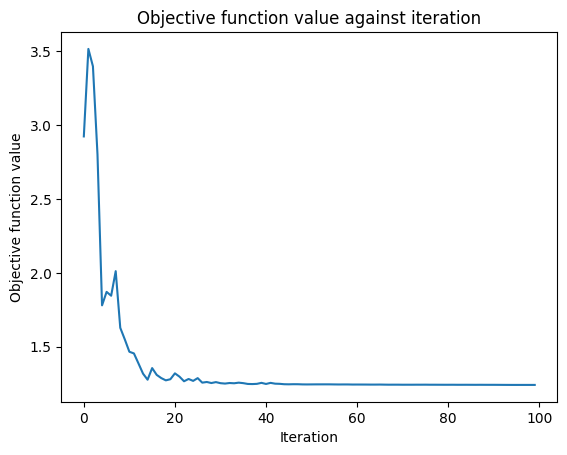

Time:
 [24.23063611984253, 23.64464807510376, 24.207449913024902, 23.995018005371094, 24.114983558654785, 24.512192010879517, 24.475197076797485, 24.826033353805542, 24.652270555496216, 23.79324460029602]
Precision:
 [0.86875, 0.8488888888888889, 0.9333333333333333, 0.9033333333333334, 0.9033333333333334, 0.9333333333333333, 0.8722222222222222, 0.8094276094276095, 0.9013888888888889, 0.8541666666666666]
Accuracy:
 [0.7666666666666667, 0.8333333333333334, 0.9333333333333333, 0.9, 0.9, 0.9333333333333333, 0.8666666666666667, 0.8, 0.9, 0.8333333333333334]
Recalls:
 [0.7848484848484848, 0.828956228956229, 0.9326599326599326, 0.9023569023569024, 0.9023569023569024, 0.9326599326599326, 0.8622895622895622, 0.8047138047138046, 0.8956228956228957, 0.8417508417508417]
F1:
 [0.7609561403508772, 0.8361895075853885, 0.9333333333333333, 0.9002506265664162, 0.9002506265664162, 0.9333333333333333, 0.8679633867276888, 0.8, 0.89923273657289, 0.8320802005012531]


In [51]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 100
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=1, rotation_blocks=['rz', 'ry'], entanglement_blocks='cz')



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Time:\n",times)
  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)

**Precision:**
 [0.86875, 0.8488888888888889, 0.9333333333333333, 0.9033333333333334, 0.9033333333333334, 0.9333333333333333, 0.8722222222222222, 0.8094276094276095, 0.9013888888888889, 0.8541666666666666]
**Mean Precision**
0.8828177609427609±0.038

**Accuracy:**
 [0.7666666666666667, 0.8333333333333334, 0.9333333333333333, 0.9, 0.9, 0.9333333333333333, 0.8666666666666667, 0.8, 0.9, 0.8333333333333334]
**Mean Accuracy**
0.8666666666666668±0.054

**Recall:**
 [0.7848484848484848, 0.828956228956229, 0.9326599326599326, 0.9023569023569024, 0.9023569023569024, 0.9326599326599326, 0.8622895622895622, 0.8047138047138046, 0.8956228956228957, 0.8417508417508417]
**Mean Recall**
 0.8688215488215487±0.05

**F1:**
 [0.7609561403508772, 0.8361895075853885, 0.9333333333333333, 0.9002506265664162, 0.9002506265664162, 0.9333333333333333, 0.8679633867276888, 0.8, 0.89923273657289, 0.8320802005012531]
**Mean F1**
0.8663589891537598±0.055

 **Time:**
 [24.23063611984253, 23.64464807510376, 24.207449913024902, 23.995018005371094, 24.114983558654785, 24.512192010879517, 24.475197076797485, 24.826033353805542, 24.652270555496216, 23.79324460029602]
**Mean Time**
24.245167326927184±0.3568428261996747

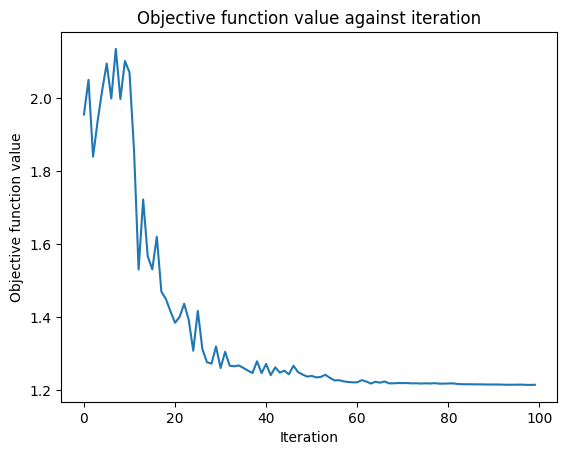

Precision:
 [0.8848484848484849, 0.9033333333333334, 0.8541666666666666, 0.9076923076923077, 0.9013888888888889, 0.7833333333333333, 0.9333333333333333, 0.8774410774410775, 0.9435897435897436, 0.9013888888888889]
Accuracy:
 [0.8666666666666667, 0.9, 0.8333333333333334, 0.8666666666666667, 0.9, 0.7666666666666667, 0.9333333333333333, 0.8666666666666667, 0.9333333333333333, 0.9]
Recalls:
 [0.865993265993266, 0.9023569023569024, 0.8417508417508417, 0.8787878787878788, 0.8956228956228957, 0.7744107744107743, 0.9326599326599326, 0.872053872053872, 0.9259259259259259, 0.8956228956228957]
F1:
 [0.8696296296296296, 0.9002506265664162, 0.8320802005012531, 0.863973063973064, 0.89923273657289, 0.7649122807017543, 0.9333333333333333, 0.8666666666666667, 0.9319444444444444, 0.89923273657289]
Time:
 [27.305135011672974, 27.549420595169067, 27.53006386756897, 26.988210678100586, 27.483885049819946, 26.938559532165527, 27.925341606140137, 27.762087106704712, 27.627483129501343, 27.050252199172974]


In [52]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 100
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=2, rotation_blocks=['rz', 'ry'], entanglement_blocks='cz')



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

**Precision:**
 [0.8848484848484849, 0.9033333333333334, 0.8541666666666666, 0.9076923076923077, 0.9013888888888889, 0.7833333333333333, 0.9333333333333333, 0.8774410774410775, 0.9435897435897436, 0.9013888888888889]
**Mean Precision**
0.8890516058016058±0.043

**Accuracy:**
 [0.8666666666666667, 0.9, 0.8333333333333334, 0.8666666666666667, 0.9, 0.7666666666666667, 0.9333333333333333, 0.8666666666666667, 0.9333333333333333, 0.9]
**Mean Accuracy**
0.8766666666666667±0.047

**Recall:**
 [0.865993265993266, 0.9023569023569024, 0.8417508417508417, 0.8787878787878788, 0.8956228956228957, 0.7744107744107743, 0.9326599326599326, 0.872053872053872, 0.9259259259259259, 0.8956228956228957]
**Mean Recall**
0.8785185185185185±0.043

**F1:**
 [0.8696296296296296, 0.9002506265664162, 0.8320802005012531, 0.863973063973064, 0.89923273657289, 0.7649122807017543, 0.9333333333333333, 0.8666666666666667, 0.9319444444444444, 0.89923273657289]
**Mean F1**
0.8761255718962342±0.048

**Time:**
 [27.305135011672974, 27.549420595169067, 27.53006386756897, 26.988210678100586, 27.483885049819946, 26.938559532165527, 27.925341606140137, 27.762087106704712, 27.627483129501343, 27.050252199172974]
**Mean Time**
27.416043877601624±0.3188049335842734

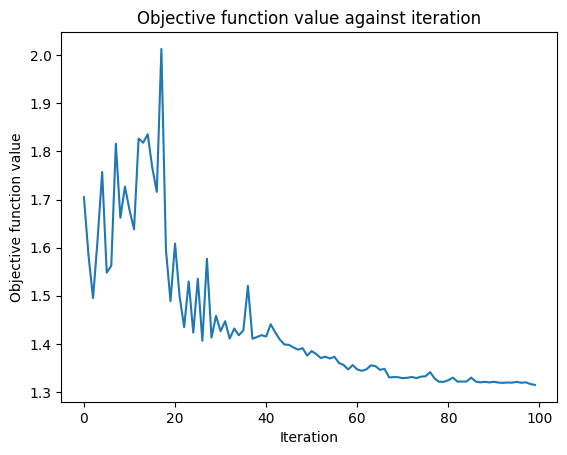

Precision:
 [0.9013888888888889, 0.9435897435897436, 0.9013888888888889, 0.9013888888888889, 0.9013888888888889, 0.8488888888888889, 0.8322344322344323, 0.9333333333333333, 0.9435897435897436, 0.6452380952380953]
Accuracy:
 [0.9, 0.9333333333333333, 0.9, 0.9, 0.9, 0.8333333333333334, 0.8, 0.9333333333333333, 0.9333333333333333, 0.6333333333333333]
Recalls:
 [0.8956228956228957, 0.9259259259259259, 0.8956228956228957, 0.8956228956228957, 0.8956228956228957, 0.828956228956229, 0.8114478114478114, 0.9326599326599326, 0.9259259259259259, 0.6464646464646464]
F1:
 [0.89923273657289, 0.9319444444444444, 0.89923273657289, 0.89923273657289, 0.89923273657289, 0.8361895075853885, 0.795959595959596, 0.9333333333333333, 0.9319444444444444, 0.6192668371696505]
Time:
 [30.525938749313354, 30.997385025024414, 30.196264028549194, 31.171586751937866, 30.879937887191772, 30.69284224510193, 30.60106348991394, 30.14577579498291, 30.41701102256775, 30.867523670196533]


In [53]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 100
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=3, rotation_blocks=['rz', 'ry'], entanglement_blocks='cz')



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

**Precision:**
 [0.9013888888888889, 0.9435897435897436, 0.9013888888888889, 0.9013888888888889, 0.9013888888888889, 0.8488888888888889, 0.8322344322344323, 0.9333333333333333, 0.9435897435897436, 0.6452380952380953]
**Mean Precision**
0.8752429792429792±0.084
 
**Accuracy:**
 [0.9, 0.9333333333333333, 0.9, 0.9, 0.9, 0.8333333333333334, 0.8, 0.9333333333333333, 0.9333333333333333, 0.6333333333333333]
**Mean Accuracy**
0.8666666666666666±0.088

**Recall:**
 [0.8956228956228957, 0.9259259259259259, 0.8956228956228957, 0.8956228956228957, 0.8956228956228957, 0.828956228956229, 0.8114478114478114, 0.9326599326599326, 0.9259259259259259, 0.6464646464646464]
**Mean Recall**
0.8653872053872055±0.082

**F1:**
 [0.89923273657289, 0.9319444444444444, 0.89923273657289, 0.89923273657289, 0.89923273657289, 0.8361895075853885, 0.795959595959596, 0.9333333333333333, 0.9319444444444444, 0.6192668371696505]
**Mean F1**
0.8645569109228417±0.092

**Time:**
 [30.525938749313354, 30.997385025024414, 30.196264028549194, 31.171586751937866, 30.879937887191772, 30.69284224510193, 30.60106348991394, 30.14577579498291, 30.41701102256775, 30.867523670196533]
**Mean Time**
30.649532866477966±0.32045882271489706

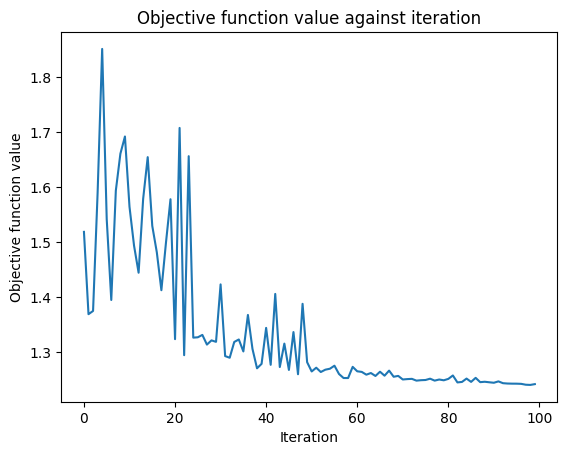

Precision:
 [0.9435897435897436, 0.9435897435897436, 0.8722222222222222, 0.8541666666666666, 0.8094276094276095, 0.817391304347826, 0.8322344322344323, 0.8294444444444444, 0.9033333333333334, 0.9013888888888889]
Accuracy:
 [0.9333333333333333, 0.9333333333333333, 0.8666666666666667, 0.8333333333333334, 0.8, 0.5333333333333333, 0.8, 0.7333333333333333, 0.9, 0.9]
Recalls:
 [0.9333333333333333, 0.9333333333333333, 0.8666666666666667, 0.8333333333333334, 0.8, 0.5333333333333333, 0.8, 0.7333333333333333, 0.9, 0.9]
F1:
 [0.9305555555555555, 0.9305555555555555, 0.8649038054072379, 0.8329156223893066, 0.8000000000000002, 0.4930555555555556, 0.797979797979798, 0.6949089557785211, 0.899749373433584, 0.8976982097186701]
Time:
 [33.66598558425903, 34.026570558547974, 33.117331743240356, 33.43788003921509, 34.19177794456482, 33.74501705169678, 34.07530498504639, 33.80152893066406, 34.05745553970337, 33.45007920265198]


In [47]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 100
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=4, rotation_blocks=['rz', 'ry'], entanglement_blocks='cz')



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

**Precision:**
 [0.9435897435897436, 0.9435897435897436, 0.8722222222222222, 0.8541666666666666, 0.8094276094276095, 0.817391304347826, 0.8322344322344323, 0.8294444444444444, 0.9033333333333334, 0.9013888888888889]
**Mean Precision**
0.8706788388744912±0.048

**Accuracy:**
 [0.9333333333333333, 0.9333333333333333, 0.8666666666666667, 0.8333333333333334, 0.8, 0.5333333333333333, 0.8, 0.7333333333333333, 0.9, 0.9]
**Mean Accuracy**
0.8233333333333335±0.11

**Recall:**
 [0.9333333333333333, 0.9333333333333333, 0.8666666666666667, 0.8333333333333334, 0.8, 0.5333333333333333, 0.8, 0.7333333333333333, 0.9, 0.9]
**Mean Recall**
0.8233333333333335±0.114

**F1:**
 [0.9305555555555555, 0.9305555555555555, 0.8649038054072379, 0.8329156223893066, 0.8000000000000002, 0.4930555555555556, 0.797979797979798, 0.6949089557785211, 0.899749373433584, 0.8976982097186701]
**Mean F1**
0.8142322431373785±0.127

**Time:**
 [33.66598558425903, 34.026570558547974, 33.117331743240356, 33.43788003921509, 34.19177794456482, 33.74501705169678, 34.07530498504639, 33.80152893066406, 34.05745553970337, 33.45007920265198]
**Mean Time**
33.756893157958984±0.32694266658212484


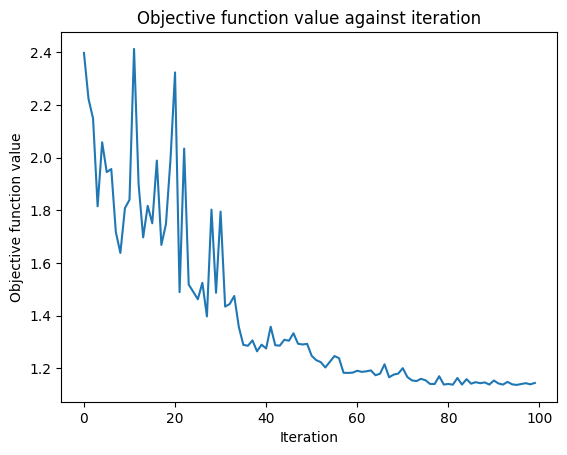

Precision:
 [0.8366666666666667]
Accuracy:
 [0.8333333333333334]
Recalls:
 [0.8350168350168351]
F1:
 [0.8337510442773599]
Time:
 [46.53321123123169]
Mean Precision: 0.8366666666666667±0.0
Mean Accuracy: 0.8333333333333334±0.0
Mean Recall: 0.8350168350168351±0.0
Mean F1: 0.8337510442773599±0.0
Mean Time: 46.53321123123169±0.0


In [11]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 100
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x', su2_gates=['h', 'ry', 'rz'])
  ansatz = TwoLocal(num_qubits=num_qubits, reps=4, rotation_blocks=['rz', 'ry'], entanglement_blocks='cz')



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

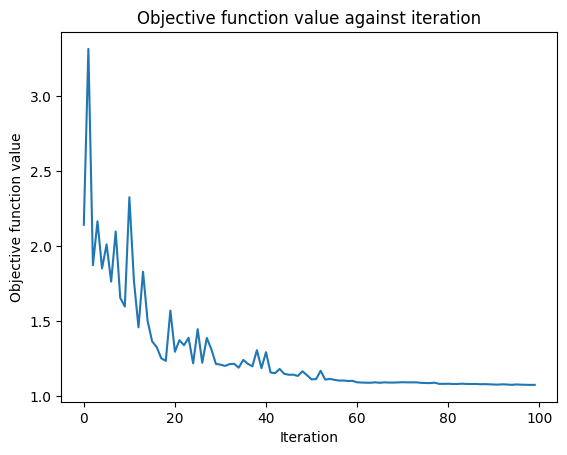

Precision:
 [0.9076923076923077, 0.9333333333333333, 0.9033333333333334, 0.9033333333333334, 0.8774410774410775, 0.9033333333333334, 0.9454545454545454, 0.9454545454545454, 0.9454545454545454, 0.9333333333333333]
Accuracy:
 [0.8666666666666667, 0.9333333333333333, 0.9, 0.9, 0.8666666666666667, 0.9, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333]
Recalls:
 [0.8787878787878788, 0.9326599326599326, 0.9023569023569024, 0.9023569023569024, 0.872053872053872, 0.9023569023569024, 0.9393939393939394, 0.9393939393939394, 0.9393939393939394, 0.9326599326599326]
F1:
 [0.863973063973064, 0.9333333333333333, 0.9002506265664162, 0.9002506265664162, 0.8666666666666667, 0.9002506265664162, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333]
Time:
 [37.28485107421875, 39.54794216156006, 38.85992240905762, 42.667590379714966, 39.66026997566223, 39.99958395957947, 39.108503341674805, 42.69145464897156, 39.281658411026, 38.453831911087036]
Mean P

In [12]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 100
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x', su2_gates=['h', 'ry', 'rz'])
  ansatz = TwoLocal(num_qubits=num_qubits, reps=2, rotation_blocks=['rz', 'ry'], entanglement_blocks='cz')



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
  
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

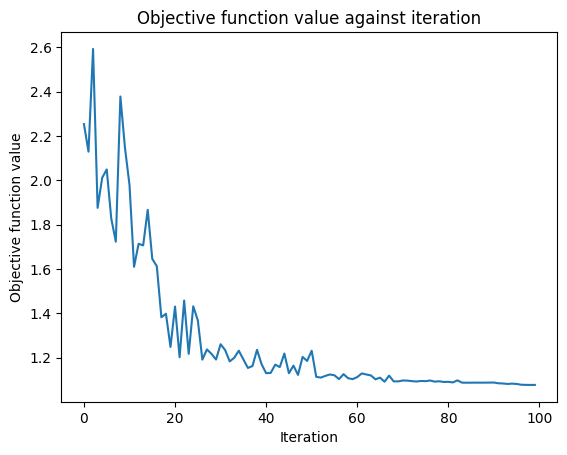

Precision:
 [0.9333333333333333, 0.9013888888888889, 0.9435897435897436, 0.6933333333333332, 0.9694444444444444, 0.9454545454545454, 0.8094276094276095, 0.7833333333333333, 0.7277777777777777, 0.9033333333333334]
Accuracy:
 [0.9333333333333333, 0.9, 0.9333333333333333, 0.6666666666666666, 0.9666666666666667, 0.9333333333333333, 0.8, 0.7666666666666667, 0.7, 0.9]
Recalls:
 [0.9326599326599326, 0.8956228956228957, 0.9259259259259259, 0.6835016835016834, 0.9629629629629629, 0.9393939393939394, 0.8047138047138046, 0.7744107744107743, 0.7138047138047138, 0.9023569023569024]
F1:
 [0.9333333333333333, 0.89923273657289, 0.9319444444444444, 0.6458333333333334, 0.9664109121909632, 0.9333333333333333, 0.8, 0.7649122807017543, 0.6884910485933504, 0.9002506265664162]
Time:
 [40.14465379714966, 42.76133918762207, 42.4542236328125, 42.713626861572266, 43.39061379432678, 44.93835520744324, 43.82781004905701, 39.60559391975403, 32.89611887931824, 33.14869666099548]
Mean Precision: 0.8610416342916343±0.

In [13]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 100
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x', su2_gates=['h', 'ry', 'rz'])
  ansatz = TwoLocal(num_qubits=num_qubits, reps=3, rotation_blocks=['rz', 'ry'], entanglement_blocks='cz')



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
  
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

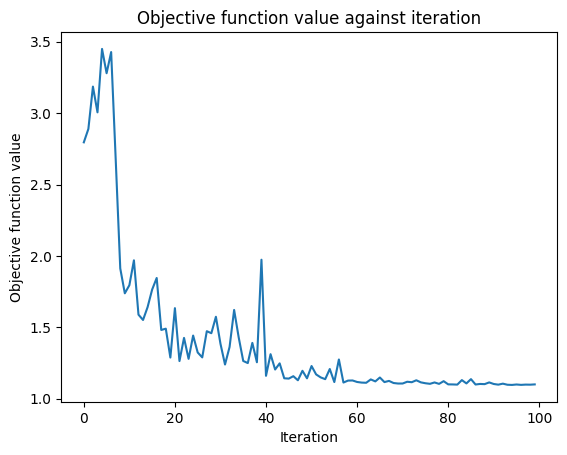

Precision:
 [0.9333333333333333, 0.9333333333333333, 0.925, 0.9454545454545454, 0.9013888888888889, 0.9700000000000001, 0.9033333333333334, 0.9333333333333333, 0.9033333333333334, 0.9076923076923077]
Accuracy:
 [0.9333333333333333, 0.9333333333333333, 0.9, 0.9333333333333333, 0.9, 0.9666666666666667, 0.9, 0.9333333333333333, 0.9, 0.8666666666666667]
Recalls:
 [0.9326599326599326, 0.9326599326599326, 0.9090909090909092, 0.9393939393939394, 0.8956228956228957, 0.9696969696969697, 0.9023569023569024, 0.9326599326599326, 0.9023569023569024, 0.8787878787878788]
F1:
 [0.9333333333333333, 0.9333333333333333, 0.899248120300752, 0.9333333333333333, 0.89923273657289, 0.966750208855472, 0.9002506265664162, 0.9333333333333333, 0.9002506265664162, 0.863973063973064]
Time:
 [41.936548709869385, 44.62920689582825, 46.388540267944336, 35.29175686836243, 35.3258912563324, 35.915783405303955, 38.893348693847656, 38.7304253578186, 35.83883190155029, 35.632511377334595]
Mean Precision: 0.9256202408702411±

In [14]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 100
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x', su2_gates=['h', 'ry', 'rz'])
  ansatz = TwoLocal(num_qubits=num_qubits, reps=4, rotation_blocks=['rz', 'ry'], entanglement_blocks='cz')



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
  
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

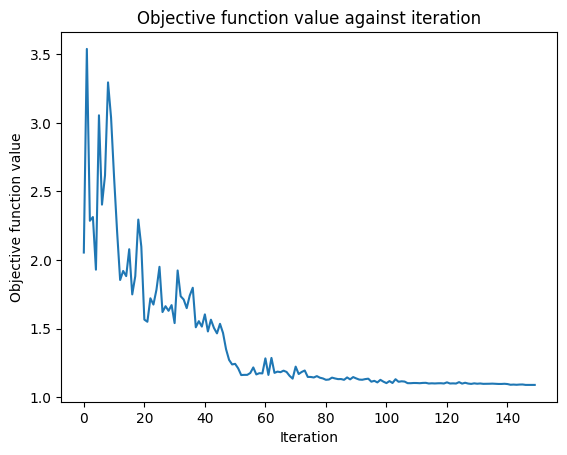

Precision:
 [0.9694444444444444, 0.9333333333333333, 0.9022222222222223, 0.9333333333333333, 0.9700000000000001, 0.9033333333333334, 0.85, 0.9333333333333333, 0.9333333333333333, 0.9694444444444444]
Accuracy:
 [0.9666666666666667, 0.9333333333333333, 0.8666666666666667, 0.9333333333333333, 0.9666666666666667, 0.9, 0.7, 0.9333333333333333, 0.9333333333333333, 0.9666666666666667]
Recalls:
 [0.9629629629629629, 0.9326599326599326, 0.8518518518518517, 0.9326599326599326, 0.9696969696969697, 0.9023569023569024, 0.7272727272727272, 0.9326599326599326, 0.9326599326599326, 0.9629629629629629]
F1:
 [0.9664109121909632, 0.9333333333333333, 0.8578754578754579, 0.9333333333333333, 0.966750208855472, 0.9002506265664162, 0.6461538461538462, 0.9333333333333333, 0.9333333333333333, 0.9664109121909632]
Time:
 [72.01372933387756, 80.9023187160492, 77.66754364967346, 77.35065960884094, 77.7804000377655, 79.43551850318909, 78.0256700515747, 79.0550799369812, 78.87571597099304, 76.38816475868225]
Mean Prec

In [16]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 150
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x', su2_gates=['h', 'ry', 'rz'])
  ansatz = TwoLocal(num_qubits=num_qubits, reps=5, rotation_blocks=['rz', 'ry'], entanglement_blocks='cz')



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
  
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

In [ ]:
# PauliFeatureMap/PauliTwoDesign
# EfficientSU2/PauliTwoDesign
# ZZFeatureMap/PauliTwoDesign

# **PauliFeatureMap/PauliTwoDesign**

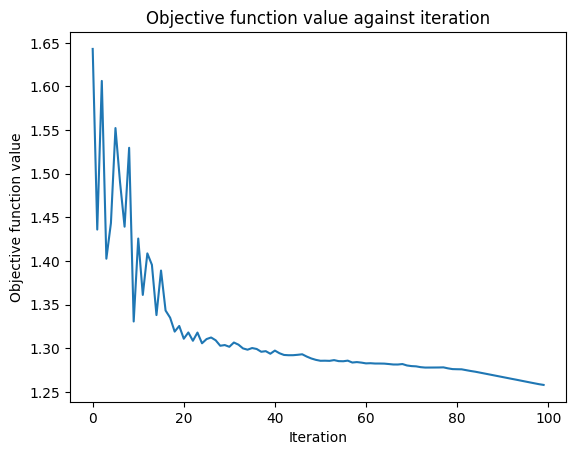

Precision:
 [0.7602272727272726, 0.5858823529411765, 0.7294139194139194, 0.8547785547785547, 0.7606237816764133, 0.7138888888888888, 0.9033333333333334, 0.709920634920635, 0.7894117647058824, 0.8180952380952381]
Accuracy:
 [0.7666666666666667, 0.5333333333333333, 0.7, 0.8333333333333334, 0.6333333333333333, 0.7, 0.9, 0.7, 0.7, 0.8]
Recalls:
 [0.757912457912458, 0.5494949494949496, 0.7077441077441078, 0.8252525252525252, 0.6195286195286195, 0.6868686868686869, 0.9023569023569024, 0.6919191919191919, 0.6868686868686869, 0.7912457912457912]
F1:
 [0.7621848739495799, 0.5264245014245014, 0.6973811339944063, 0.8312698412698413, 0.5956426332288401, 0.6717948717948717, 0.9002506265664162, 0.6922364672364673, 0.676278659611993, 0.792063492063492]
Time:
 [50.14021348953247, 52.152228355407715, 53.277023792266846, 53.118728160858154, 52.60441875457764, 54.49002933502197, 53.45587134361267, 53.56956505775452, 53.03952074050903, 54.61108350753784]
Mean Precision: 0.7625575741481314±0.08342013971555

In [54]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 100
  num_qubits = X.shape[1]
  opt = COBYLA(maxiter=MAXITR)

  featuremap = PauliFeatureMap(feature_dimension=num_qubits, reps=1, parameter_prefix='x')
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=1)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  score = vqc.score(X_test, Y_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
  
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.7602272727272726, 0.5858823529411765, 0.7294139194139194, 0.8547785547785547, 0.7606237816764133, 0.7138888888888888, 0.9033333333333334, 0.709920634920635, 0.7894117647058824, 0.8180952380952381]
Accuracy:
 [0.7666666666666667, 0.5333333333333333, 0.7, 0.8333333333333334, 0.6333333333333333, 0.7, 0.9, 0.7, 0.7, 0.8]
Recalls:
 [0.757912457912458, 0.5494949494949496, 0.7077441077441078, 0.8252525252525252, 0.6195286195286195, 0.6868686868686869, 0.9023569023569024, 0.6919191919191919, 0.6868686868686869, 0.7912457912457912]
F1:
 [0.7621848739495799, 0.5264245014245014, 0.6973811339944063, 0.8312698412698413, 0.5956426332288401, 0.6717948717948717, 0.9002506265664162, 0.6922364672364673, 0.676278659611993, 0.792063492063492]
Time:
 [50.14021348953247, 52.152228355407715, 53.277023792266846, 53.118728160858154, 52.60441875457764, 54.49002933502197, 53.45587134361267, 53.56956505775452, 53.03952074050903, 54.61108350753784]
Mean Precision: 0.7625575741481314±0.08342013971555422
Mean Accuracy: 0.7266666666666667±0.09865765724632498
Mean Recall: 0.721919191919192±0.09649310607853717
Mean F1: 0.7145527101140409±0.10488145304190286
Mean Time: 53.04586825370789±1.203035418123514


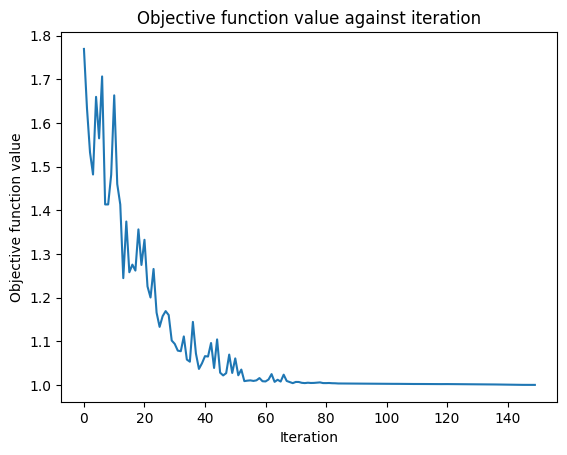

Precision:
 [0.7576388888888889, 0.8925213675213676, 0.8689562289562289, 0.9694444444444444, 0.8773892773892773, 0.7990079365079364, 0.9694444444444444, 0.7416666666666667, 0.8383333333333333, 0.9363636363636363]
Accuracy:
 [0.6333333333333333, 0.8666666666666667, 0.8666666666666667, 0.9666666666666667, 0.8333333333333334, 0.7666666666666667, 0.9666666666666667, 0.7, 0.7666666666666667, 0.9333333333333333]
Recalls:
 [0.6606060606060606, 0.8518518518518517, 0.872053872053872, 0.9629629629629629, 0.8484848484848485, 0.7744107744107743, 0.9629629629629629, 0.7016835016835016, 0.7542087542087542, 0.9326599326599326]
F1:
 [0.5712447552447553, 0.854865424430642, 0.8634252297410192, 0.9664109121909632, 0.8217383923266276, 0.7581699346405227, 0.9664109121909632, 0.7087719298245614, 0.7553113553113552, 0.9333333333333333]
Time:
 [83.33440470695496, 87.39860391616821, 87.4080741405487, 86.55922627449036, 87.96101784706116, 88.18728470802307, 89.71972417831421, 89.08857727050781, 85.8725938796997

In [55]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 150
  num_qubits = X.shape[1]
  opt = COBYLA(maxiter=MAXITR)

  featuremap = PauliFeatureMap(feature_dimension=num_qubits, reps=1, parameter_prefix='x')
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=2)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  score = vqc.score(X_test, Y_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
  
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.7576388888888889, 0.8925213675213676, 0.8689562289562289, 0.9694444444444444, 0.8773892773892773, 0.7990079365079364, 0.9694444444444444, 0.7416666666666667, 0.8383333333333333, 0.9363636363636363]
Accuracy:
 [0.6333333333333333, 0.8666666666666667, 0.8666666666666667, 0.9666666666666667, 0.8333333333333334, 0.7666666666666667, 0.9666666666666667, 0.7, 0.7666666666666667, 0.9333333333333333]
Recalls:
 [0.6606060606060606, 0.8518518518518517, 0.872053872053872, 0.9629629629629629, 0.8484848484848485, 0.7744107744107743, 0.9629629629629629, 0.7016835016835016, 0.7542087542087542, 0.9326599326599326]
F1:
 [0.5712447552447553, 0.854865424430642, 0.8634252297410192, 0.9664109121909632, 0.8217383923266276, 0.7581699346405227, 0.9664109121909632, 0.7087719298245614, 0.7553113553113552, 0.9333333333333333]
Time:
 [83.33440470695496, 87.39860391616821, 87.4080741405487, 86.55922627449036, 87.96101784706116, 88.18728470802307, 89.71972417831421, 89.08857727050781, 85.8725938796997, 89.71116161346436]
Mean Precision: 0.8650766224516223±0.07722703431626876
Mean Accuracy: 0.8299999999999998±0.10692676621563628
Mean Recall: 0.8321885521885521±0.10120824561175495
Mean F1: 0.8199682179234744±0.11877691201975903
Mean Time: 87.52406685352325±1.8418337601890853

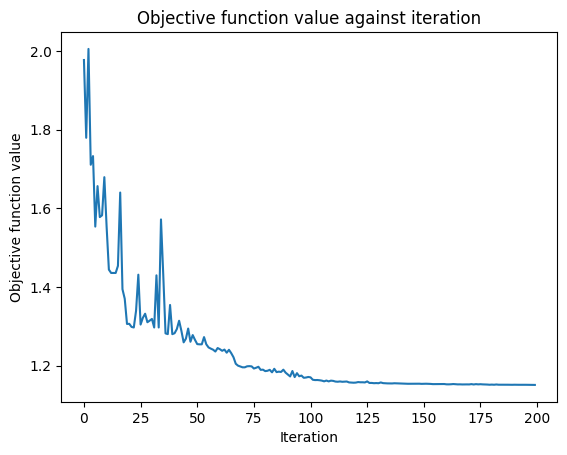

Precision:
 [0.8643939393939394, 0.6996392496392497, 0.8558201058201059, 0.9132867132867133, 0.837037037037037, 0.8696296296296296, 0.8696969696969696, 0.6919413919413919, 0.8, 0.7839285714285714]
Accuracy:
 [0.8333333333333334, 0.6666666666666666, 0.8, 0.9, 0.8333333333333334, 0.8666666666666667, 0.8333333333333334, 0.7, 0.8, 0.7333333333333333]
Recalls:
 [0.8454545454545453, 0.6744107744107745, 0.8121212121212121, 0.8888888888888888, 0.8350168350168351, 0.865993265993266, 0.8417508417508417, 0.6801346801346803, 0.794949494949495, 0.7417508417508417]
F1:
 [0.828042328042328, 0.6665656565656567, 0.8006695482668024, 0.8935714285714286, 0.8296969696969697, 0.8666666666666667, 0.8312169312169312, 0.6527777777777779, 0.8, 0.7381303500296634]
Time:
 [123.45422029495239, 126.29719471931458, 129.5300805568695, 127.51644992828369, 128.83610796928406, 129.93763041496277, 127.72512531280518, 132.07111525535583, 127.1481192111969, 128.63666987419128]
Mean Precision: 0.8185373607873607±0.070530088

In [56]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 200
  num_qubits = X.shape[1]
  opt = COBYLA(maxiter=MAXITR)

  featuremap = PauliFeatureMap(feature_dimension=num_qubits, reps=1, parameter_prefix='x')
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=3)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  score = vqc.score(X_test, Y_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
  
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.8643939393939394, 0.6996392496392497, 0.8558201058201059, 0.9132867132867133, 0.837037037037037, 0.8696296296296296, 0.8696969696969696, 0.6919413919413919, 0.8, 0.7839285714285714]
Accuracy:
 [0.8333333333333334, 0.6666666666666666, 0.8, 0.9, 0.8333333333333334, 0.8666666666666667, 0.8333333333333334, 0.7, 0.8, 0.7333333333333333]
Recalls:
 [0.8454545454545453, 0.6744107744107745, 0.8121212121212121, 0.8888888888888888, 0.8350168350168351, 0.865993265993266, 0.8417508417508417, 0.6801346801346803, 0.794949494949495, 0.7417508417508417]
F1:
 [0.828042328042328, 0.6665656565656567, 0.8006695482668024, 0.8935714285714286, 0.8296969696969697, 0.8666666666666667, 0.8312169312169312, 0.6527777777777779, 0.8, 0.7381303500296634]
Time:
 [123.45422029495239, 126.29719471931458, 129.5300805568695, 127.51644992828369, 128.83610796928406, 129.93763041496277, 127.72512531280518, 132.07111525535583, 127.1481192111969, 128.63666987419128]
Mean Precision: 0.8185373607873607±0.07053008891727142
Mean Accuracy: 0.7966666666666666±0.07063206700139034
Mean Recall: 0.798047138047138±0.07138583932550917
Mean F1: 0.7907337656834225±0.07634894450953549
Mean Time: 128.11527135372162±2.1963566278636715

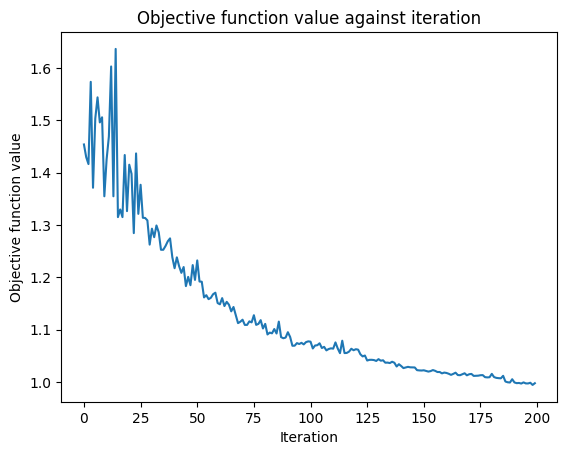

Precision:
 [0.9700000000000001, 0.83517316017316, 0.9444444444444445, 0.6576190476190475, 0.8844444444444445, 0.9700000000000001, 0.9033333333333334, 0.7701243201243202, 0.8888888888888888, 0.925]
Accuracy:
 [0.9666666666666667, 0.8333333333333334, 0.9333333333333333, 0.6666666666666666, 0.8666666666666667, 0.9666666666666667, 0.9, 0.7333333333333333, 0.8333333333333334, 0.9]
Recalls:
 [0.9666666666666667, 0.8282828282828283, 0.9259259259259259, 0.6535353535353535, 0.872053872053872, 0.9666666666666667, 0.9023569023569024, 0.744107744107744, 0.8350168350168351, 0.9090909090909092]
F1:
 [0.9666666666666667, 0.829416839199448, 0.9321969696969696, 0.6493650793650794, 0.8644338118022328, 0.9666666666666667, 0.9002506265664162, 0.7240556828792123, 0.837938596491228, 0.899248120300752]
Time:
 [131.63533520698547, 136.59775066375732, 137.43855214118958, 139.27169251441956, 139.43843293190002, 138.44304752349854, 139.11516165733337, 139.65984559059143, 142.11065673828125, 142.66961812973022]


In [57]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 200
  num_qubits = X.shape[1]
  opt = COBYLA(maxiter=MAXITR)

  featuremap = PauliFeatureMap(feature_dimension=num_qubits, reps=1, parameter_prefix='x')
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=4)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  score = vqc.score(X_test, Y_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
  
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.9700000000000001, 0.83517316017316, 0.9444444444444445, 0.6576190476190475, 0.8844444444444445, 0.9700000000000001, 0.9033333333333334, 0.7701243201243202, 0.8888888888888888, 0.925]
Accuracy:
 [0.9666666666666667, 0.8333333333333334, 0.9333333333333333, 0.6666666666666666, 0.8666666666666667, 0.9666666666666667, 0.9, 0.7333333333333333, 0.8333333333333334, 0.9]
Recalls:
 [0.9666666666666667, 0.8282828282828283, 0.9259259259259259, 0.6535353535353535, 0.872053872053872, 0.9666666666666667, 0.9023569023569024, 0.744107744107744, 0.8350168350168351, 0.9090909090909092]
F1:
 [0.9666666666666667, 0.829416839199448, 0.9321969696969696, 0.6493650793650794, 0.8644338118022328, 0.9666666666666667, 0.9002506265664162, 0.7240556828792123, 0.837938596491228, 0.899248120300752]
Time:
 [131.63533520698547, 136.59775066375732, 137.43855214118958, 139.27169251441956, 139.43843293190002, 138.44304752349854, 139.11516165733337, 139.65984559059143, 142.11065673828125, 142.66961812973022]
Mean Precision: 0.874902763902764±0.09289611225280106
Mean Accuracy: 0.86±0.09285592184789415
Mean Recall: 0.8603703703703705±0.09441320597069518
Mean F1: 0.8570239059634671±0.09763684530069207
Mean Time: 138.63800930976868±2.920685082237341


# **ZZFeatureMap/PauliTwoDesign**

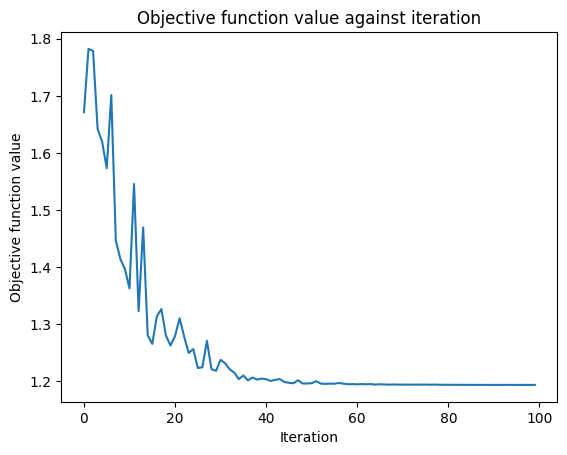

Precision:
 [0.7742592592592591, 0.9066666666666666, 0.7942857142857143, 0.8, 0.939141414141414, 0.4443977591036415, 0.7814814814814814, 0.7611111111111112, 0.7666666666666667, 0.9033333333333334]
Accuracy:
 [0.7333333333333333, 0.9, 0.7666666666666667, 0.8, 0.9333333333333333, 0.43333333333333335, 0.7666666666666667, 0.7666666666666667, 0.7, 0.9]
Recalls:
 [0.7239057239057239, 0.8993265993265993, 0.757912457912458, 0.794949494949495, 0.9259259259259259, 0.4353535353535353, 0.7683501683501683, 0.7622895622895624, 0.7040404040404041, 0.9023569023569024]
F1:
 [0.7211721611721612, 0.9017543859649123, 0.7642857142857143, 0.8, 0.9306849551414769, 0.41506172839506167, 0.769090909090909, 0.7627002288329519, 0.6988235294117647, 0.9002506265664162]
Time:
 [50.42609667778015, 52.745972633361816, 54.29827523231506, 52.10629415512085, 53.42357039451599, 53.467934370040894, 53.80248737335205, 53.98108506202698, 54.36535143852234, 54.32583737373352]
Mean Precision: 0.7871343406049288±0.1303361889929

In [59]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 100
  num_qubits = X.shape[1]
  opt = COBYLA(maxiter=MAXITR)

  featuremap = ZZFeatureMap(feature_dimension=num_qubits, reps=1, parameter_prefix='x')
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=1)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  score = vqc.score(X_test, Y_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
  
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.7742592592592591, 0.9066666666666666, 0.7942857142857143, 0.8, 0.939141414141414, 0.4443977591036415, 0.7814814814814814, 0.7611111111111112, 0.7666666666666667, 0.9033333333333334]
Accuracy:
 [0.7333333333333333, 0.9, 0.7666666666666667, 0.8, 0.9333333333333333, 0.43333333333333335, 0.7666666666666667, 0.7666666666666667, 0.7, 0.9]
Recalls:
 [0.7239057239057239, 0.8993265993265993, 0.757912457912458, 0.794949494949495, 0.9259259259259259, 0.4353535353535353, 0.7683501683501683, 0.7622895622895624, 0.7040404040404041, 0.9023569023569024]
F1:
 [0.7211721611721612, 0.9017543859649123, 0.7642857142857143, 0.8, 0.9306849551414769, 0.41506172839506167, 0.769090909090909, 0.7627002288329519, 0.6988235294117647, 0.9002506265664162]
Time:
 [50.42609667778015, 52.745972633361816, 54.29827523231506, 52.10629415512085, 53.42357039451599, 53.467934370040894, 53.80248737335205, 53.98108506202698, 54.36535143852234, 54.32583737373352]
Mean Precision: 0.7871343406049288±0.1303361889929235
Mean Accuracy: 0.7700000000000001±0.13453624047073712
Mean Recall: 0.7674410774410775±0.13333622841464632
Mean F1: 0.7663824238861369±0.13943866781056488
Mean Time: 53.29429047107696±1.180448463374998

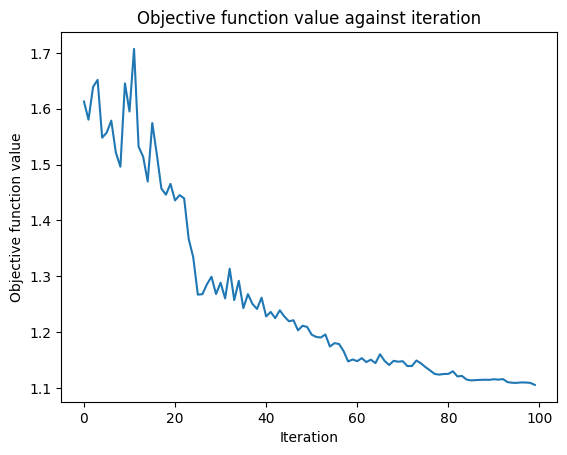

Precision:
 [0.7476190476190477, 0.8180952380952381, 0.7683333333333333, 0.6933333333333334, 0.8216666666666667, 0.7932012432012433, 0.9214285714285714, 0.7601851851851852, 0.8211640211640211, 0.8663636363636364]
Accuracy:
 [0.5333333333333333, 0.8, 0.7666666666666667, 0.6666666666666666, 0.8, 0.7666666666666667, 0.9, 0.7333333333333333, 0.8, 0.8666666666666667]
Recalls:
 [0.5508417508417508, 0.7912457912457912, 0.7646464646464647, 0.6646464646464646, 0.8023569023569023, 0.7811447811447811, 0.8925925925925927, 0.7350168350168351, 0.7979797979797979, 0.8653198653198654]
F1:
 [0.5333333333333333, 0.792063492063492, 0.7638570579747052, 0.673015873015873, 0.8021164021164021, 0.7513284101519396, 0.9009561403508772, 0.7389473684210526, 0.7961111111111111, 0.8650793650793652]
Time:
 [55.04612398147583, 57.730119466781616, 57.94768834114075, 57.95235729217529, 57.51505422592163, 57.78287196159363, 60.141276836395264, 58.79250907897949, 58.3674898147583, 57.47600865364075]
Mean Precision: 0.801

In [60]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 100
  num_qubits = X.shape[1]
  opt = COBYLA(maxiter=MAXITR)

  featuremap = ZZFeatureMap(feature_dimension=num_qubits, reps=1, parameter_prefix='x')
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=2)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  score = vqc.score(X_test, Y_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
  
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.7476190476190477, 0.8180952380952381, 0.7683333333333333, 0.6933333333333334, 0.8216666666666667, 0.7932012432012433, 0.9214285714285714, 0.7601851851851852, 0.8211640211640211, 0.8663636363636364]
Accuracy:
 [0.5333333333333333, 0.8, 0.7666666666666667, 0.6666666666666666, 0.8, 0.7666666666666667, 0.9, 0.7333333333333333, 0.8, 0.8666666666666667]
Recalls:
 [0.5508417508417508, 0.7912457912457912, 0.7646464646464647, 0.6646464646464646, 0.8023569023569023, 0.7811447811447811, 0.8925925925925927, 0.7350168350168351, 0.7979797979797979, 0.8653198653198654]
F1:
 [0.5333333333333333, 0.792063492063492, 0.7638570579747052, 0.673015873015873, 0.8021164021164021, 0.7513284101519396, 0.9009561403508772, 0.7389473684210526, 0.7961111111111111, 0.8650793650793652]
Time:
 [55.04612398147583, 57.730119466781616, 57.94768834114075, 57.95235729217529, 57.51505422592163, 57.78287196159363, 60.141276836395264, 58.79250907897949, 58.3674898147583, 57.47600865364075]
Mean Precision: 0.8011390276390277±0.06093981992884508
Mean Accuracy: 0.7633333333333333±0.09826268648655785
Mean Recall: 0.7645791245791245±0.09306372943099377
Mean F1: 0.7616808553618151±0.09719322389185424
Mean Time: 57.875149965286255±1.2063341110496983

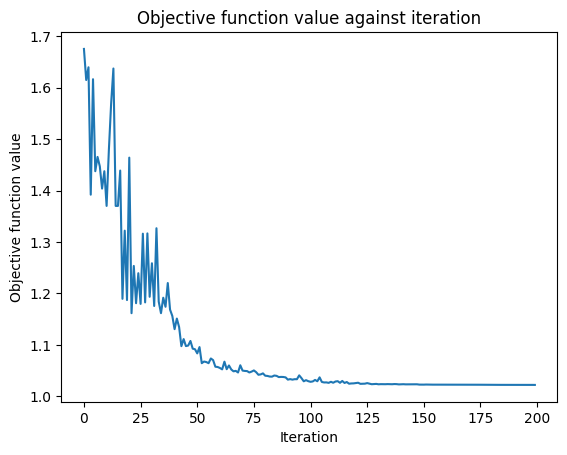

Precision:
 [0.7002136752136752, 0.9069444444444446, 0.7068181818181818, 0.8855769230769232, 0.8833333333333334, 0.824009324009324, 0.865530303030303, 0.8387820512820513, 0.9084175084175085, 0.9060897435897436]
Accuracy:
 [0.7, 0.9, 0.7, 0.8666666666666667, 0.8666666666666667, 0.7666666666666667, 0.8666666666666667, 0.8, 0.9, 0.9]
Recalls:
 [0.7040404040404041, 0.8956228956228957, 0.694949494949495, 0.8653198653198654, 0.8585858585858586, 0.7781144781144781, 0.8653198653198654, 0.8084175084175084, 0.903030303030303, 0.8925925925925927]
F1:
 [0.6926342710997442, 0.8992954757660638, 0.7022408963585434, 0.86691389599318, 0.8618708827404479, 0.7627196333078686, 0.8645191409897293, 0.8041467304625199, 0.899908103592314, 0.8989594083247334]
Time:
 [126.035071849823, 128.42293620109558, 129.59205722808838, 125.43376088142395, 124.58139538764954, 126.56636691093445, 125.66024732589722, 125.53735780715942, 133.57251262664795, 133.74229192733765]
Mean Precision: 0.8425715488215488±0.074569342327

In [61]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 200
  num_qubits = X.shape[1]
  opt = COBYLA(maxiter=MAXITR)

  featuremap = ZZFeatureMap(feature_dimension=num_qubits, reps=1, parameter_prefix='x')
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=3)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  score = vqc.score(X_test, Y_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
  
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.7002136752136752, 0.9069444444444446, 0.7068181818181818, 0.8855769230769232, 0.8833333333333334, 0.824009324009324, 0.865530303030303, 0.8387820512820513, 0.9084175084175085, 0.9060897435897436]
Accuracy:
 [0.7, 0.9, 0.7, 0.8666666666666667, 0.8666666666666667, 0.7666666666666667, 0.8666666666666667, 0.8, 0.9, 0.9]
Recalls:
 [0.7040404040404041, 0.8956228956228957, 0.694949494949495, 0.8653198653198654, 0.8585858585858586, 0.7781144781144781, 0.8653198653198654, 0.8084175084175084, 0.903030303030303, 0.8925925925925927]
F1:
 [0.6926342710997442, 0.8992954757660638, 0.7022408963585434, 0.86691389599318, 0.8618708827404479, 0.7627196333078686, 0.8645191409897293, 0.8041467304625199, 0.899908103592314, 0.8989594083247334]
Time:
 [126.035071849823, 128.42293620109558, 129.59205722808838, 125.43376088142395, 124.58139538764954, 126.56636691093445, 125.66024732589722, 125.53735780715942, 133.57251262664795, 133.74229192733765]
Mean Precision: 0.8425715488215488±0.07456934232734985
Mean Accuracy: 0.8266666666666668±0.07571877794400367
Mean Recall: 0.8265993265993267±0.0734959070824853
Mean F1: 0.8253208438635145±0.07627725230421704
Mean Time: 127.91439981460572±3.199918705340394

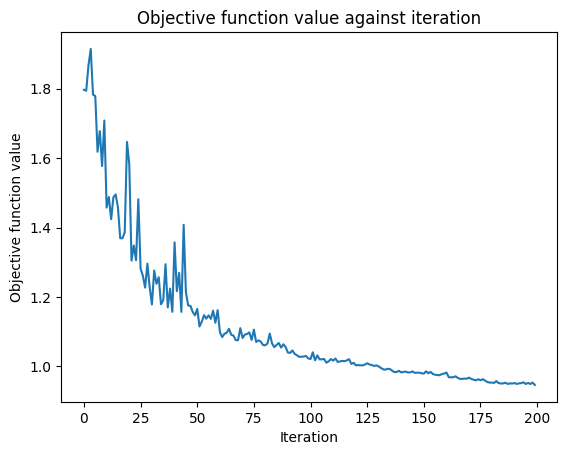

Precision:
 [0.9700000000000001, 0.9033333333333334, 0.7829725829725831, 0.9076923076923077, 0.9454545454545454, 0.9361111111111111, 0.9396969696969696, 0.8777777777777779, 0.9333333333333333, 0.882051282051282]
Accuracy:
 [0.9666666666666667, 0.9, 0.7666666666666667, 0.8666666666666667, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.8666666666666667, 0.9333333333333333, 0.8666666666666667]
Recalls:
 [0.9696969696969697, 0.9023569023569024, 0.7744107744107743, 0.8787878787878788, 0.9393939393939394, 0.9296296296296296, 0.9393939393939394, 0.8653198653198654, 0.9326599326599326, 0.865993265993266]
F1:
 [0.966750208855472, 0.9002506265664162, 0.7574747474747474, 0.863973063973064, 0.9333333333333333, 0.9331807780320366, 0.931670843776107, 0.8663636363636364, 0.9333333333333333, 0.8685185185185186]
Time:
 [139.45831489562988, 140.41485261917114, 139.32818627357483, 137.15955543518066, 139.017906665802, 138.40537428855896, 106.58361148834229, 141.09495401382446, 139.94023680

In [62]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 200
  num_qubits = X.shape[1]
  opt = COBYLA(maxiter=MAXITR)

  featuremap = ZZFeatureMap(feature_dimension=num_qubits, reps=1, parameter_prefix='x')
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=4)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  score = vqc.score(X_test, Y_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
  
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.9700000000000001, 0.9033333333333334, 0.7829725829725831, 0.9076923076923077, 0.9454545454545454, 0.9361111111111111, 0.9396969696969696, 0.8777777777777779, 0.9333333333333333, 0.882051282051282]
Accuracy:
 [0.9666666666666667, 0.9, 0.7666666666666667, 0.8666666666666667, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.8666666666666667, 0.9333333333333333, 0.8666666666666667]
Recalls:
 [0.9696969696969697, 0.9023569023569024, 0.7744107744107743, 0.8787878787878788, 0.9393939393939394, 0.9296296296296296, 0.9393939393939394, 0.8653198653198654, 0.9326599326599326, 0.865993265993266]
F1:
 [0.966750208855472, 0.9002506265664162, 0.7574747474747474, 0.863973063973064, 0.9333333333333333, 0.9331807780320366, 0.931670843776107, 0.8663636363636364, 0.9333333333333333, 0.8685185185185186]
Time:
 [139.45831489562988, 140.41485261917114, 139.32818627357483, 137.15955543518066, 139.017906665802, 138.40537428855896, 106.58361148834229, 141.09495401382446, 139.9402368068695, 138.951979637146]
Mean Precision: 0.9078423243423244±0.04992369250450041
Mean Accuracy: 0.8966666666666667±0.05467073155618907
Mean Recall: 0.8997643097643098±0.05337864321967314
Mean F1: 0.8954849090226664±0.056843555211594156
Mean Time: 136.03549721240998±9.870538805860491

# **EfficientSU2/PauliTwoDesign**

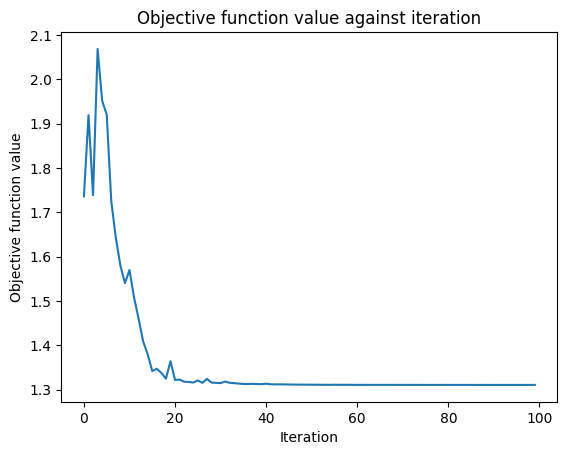

Precision:
 [0.45606060606060606, 0.2928571428571428, 0.6304761904761905, 0.6723776223776224, 0.1890151515151515, 0.1111111111111111, 0.4293460925039872, 0.5622222222222223, 0.47052287581699354, 0.8014652014652015]
Accuracy:
 [0.5333333333333333, 0.36666666666666664, 0.6, 0.7, 0.36666666666666664, 0.3333333333333333, 0.6, 0.5666666666666667, 0.43333333333333335, 0.8]
Recalls:
 [0.5666666666666667, 0.3962962962962963, 0.6168350168350168, 0.6777777777777777, 0.3703703703703704, 0.3333333333333333, 0.6296296296296297, 0.5474747474747476, 0.430976430976431, 0.7912457912457912]
F1:
 [0.44870335230866537, 0.3096470588235294, 0.5935185185185186, 0.6783333333333332, 0.24362745098039215, 0.16666666666666666, 0.4888888888888889, 0.5617255699635563, 0.3832544323772394, 0.7958333333333333]
Time:
 [26.966170072555542, 30.595072984695435, 31.355334520339966, 26.26975393295288, 30.317689180374146, 12.032620906829834, 30.64475965499878, 30.639270305633545, 31.04405975341797, 31.431360960006714]
Mean P

In [65]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 100
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=1)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
  
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.45606060606060606, 0.2928571428571428, 0.6304761904761905, 0.6723776223776224, 0.1890151515151515, 0.1111111111111111, 0.4293460925039872, 0.5622222222222223, 0.47052287581699354, 0.8014652014652015]
Accuracy:
 [0.5333333333333333, 0.36666666666666664, 0.6, 0.7, 0.36666666666666664, 0.3333333333333333, 0.6, 0.5666666666666667, 0.43333333333333335, 0.8]
Recalls:
 [0.5666666666666667, 0.3962962962962963, 0.6168350168350168, 0.6777777777777777, 0.3703703703703704, 0.3333333333333333, 0.6296296296296297, 0.5474747474747476, 0.430976430976431, 0.7912457912457912]
F1:
 [0.44870335230866537, 0.3096470588235294, 0.5935185185185186, 0.6783333333333332, 0.24362745098039215, 0.16666666666666666, 0.4888888888888889, 0.5617255699635563, 0.3832544323772394, 0.7958333333333333]
Time:
 [26.966170072555542, 30.595072984695435, 31.355334520339966, 26.26975393295288, 30.317689180374146, 12.032620906829834, 30.64475965499878, 30.639270305633545, 31.04405975341797, 31.431360960006714]
Mean Precision: 0.46154542164062284±0.206239972030277
Mean Accuracy: 0.53±0.146401275039985
Mean Recall: 0.5360606060606061±0.1416609558497713
Mean F1: 0.46701986051941236±0.18720458589762998
Mean Time: 28.12960922718048±5.632203487392534


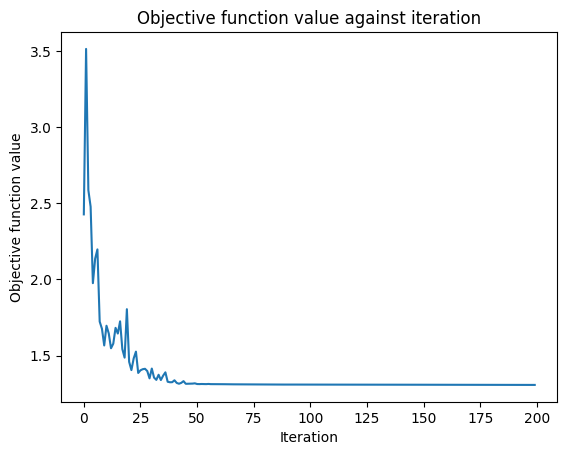

Precision:
 [0.8588235294117648, 0.9033333333333334, 0.5, 0.6079975579975581, 0.1111111111111111, 0.4683333333333334, 0.535, 0.5644444444444444, 0.4127450980392157, 0.4683333333333334]
Accuracy:
 [0.7333333333333333, 0.9, 0.5, 0.5666666666666667, 0.3333333333333333, 0.6333333333333333, 0.7, 0.6, 0.43333333333333335, 0.6333333333333333]
Recalls:
 [0.7575757575757575, 0.9023569023569024, 0.5050505050505051, 0.5791245791245792, 0.3333333333333333, 0.6666666666666666, 0.6666666666666666, 0.5824915824915825, 0.430976430976431, 0.6666666666666666]
F1:
 [0.6981684981684982, 0.9002506265664162, 0.49624060150375937, 0.5250517598343686, 0.16666666666666666, 0.5195402298850574, 0.5935483870967742, 0.5736263736263736, 0.3780246913580247, 0.5195402298850574]
Time:
 [65.66355395317078, 71.21443486213684, 33.772910594940186, 64.36851382255554, 31.027785539627075, 64.44412541389465, 63.66021490097046, 58.76395225524902, 33.66663718223572, 63.62103986740112]
Mean Precision: 0.5430121741004095±0.2123268

/home/gzuz/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [64]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 200
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=2)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
  
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.8588235294117648, 0.9033333333333334, 0.5, 0.6079975579975581, 0.1111111111111111, 0.4683333333333334, 0.535, 0.5644444444444444, 0.4127450980392157, 0.4683333333333334]
Accuracy:
 [0.7333333333333333, 0.9, 0.5, 0.5666666666666667, 0.3333333333333333, 0.6333333333333333, 0.7, 0.6, 0.43333333333333335, 0.6333333333333333]
Recalls:
 [0.7575757575757575, 0.9023569023569024, 0.5050505050505051, 0.5791245791245792, 0.3333333333333333, 0.6666666666666666, 0.6666666666666666, 0.5824915824915825, 0.430976430976431, 0.6666666666666666]
F1:
 [0.6981684981684982, 0.9002506265664162, 0.49624060150375937, 0.5250517598343686, 0.16666666666666666, 0.5195402298850574, 0.5935483870967742, 0.5736263736263736, 0.3780246913580247, 0.5195402298850574]
Time:
 [65.66355395317078, 71.21443486213684, 33.772910594940186, 64.36851382255554, 31.027785539627075, 64.44412541389465, 63.66021490097046, 58.76395225524902, 33.66663718223572, 63.62103986740112]
Mean Precision: 0.5430121741004095±0.212326807576203
Mean Accuracy: 0.6033333333333333±0.15162087220725545
Mean Recall: 0.6090909090909091±0.15433551610011623
Mean F1: 0.5370658064590997±0.18091411587145467
Mean Time: 55.02031683921814±14.82374263171375

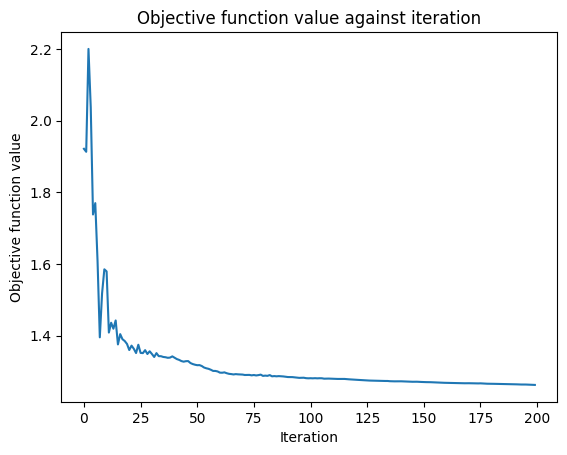

Precision:
 [0.7206959706959708, 0.7854166666666667, 0.4683333333333334, 0.6518518518518519, 0.6933333333333332, 0.8094276094276095, 0.8051282051282052, 0.4392156862745098, 0.9013888888888889, 0.8452380952380952]
Accuracy:
 [0.7, 0.7666666666666667, 0.6333333333333333, 0.6, 0.6666666666666666, 0.8, 0.7333333333333333, 0.5333333333333333, 0.9, 0.8333333333333334]
Recalls:
 [0.7003367003367004, 0.7481481481481481, 0.6666666666666666, 0.5892255892255892, 0.6835016835016834, 0.8047138047138046, 0.725925925925926, 0.5555555555555555, 0.8956228956228957, 0.8215488215488215]
F1:
 [0.6921942537503177, 0.7550617283950617, 0.5195402298850574, 0.5769187675070028, 0.6458333333333334, 0.8, 0.7174963924963925, 0.4717948717948718, 0.89923273657289, 0.8266666666666667]
Time:
 [62.08654832839966, 67.3803448677063, 69.34085249900818, 68.99470400810242, 60.03667950630188, 70.17341804504395, 70.7238597869873, 70.991459608078, 69.02969455718994, 67.92976546287537]
Mean Precision: 0.7120029640838463±0.14662

In [66]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 200
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=3)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
  
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.7206959706959708, 0.7854166666666667, 0.4683333333333334, 0.6518518518518519, 0.6933333333333332, 0.8094276094276095, 0.8051282051282052, 0.4392156862745098, 0.9013888888888889, 0.8452380952380952]
Accuracy:
 [0.7, 0.7666666666666667, 0.6333333333333333, 0.6, 0.6666666666666666, 0.8, 0.7333333333333333, 0.5333333333333333, 0.9, 0.8333333333333334]
Recalls:
 [0.7003367003367004, 0.7481481481481481, 0.6666666666666666, 0.5892255892255892, 0.6835016835016834, 0.8047138047138046, 0.725925925925926, 0.5555555555555555, 0.8956228956228957, 0.8215488215488215]
F1:
 [0.6921942537503177, 0.7550617283950617, 0.5195402298850574, 0.5769187675070028, 0.6458333333333334, 0.8, 0.7174963924963925, 0.4717948717948718, 0.89923273657289, 0.8266666666666667]
Time:
 [62.08654832839966, 67.3803448677063, 69.34085249900818, 68.99470400810242, 60.03667950630188, 70.17341804504395, 70.7238597869873, 70.991459608078, 69.02969455718994, 67.92976546287537]
Mean Precision: 0.7120029640838463±0.14662951275871522
Mean Accuracy: 0.7166666666666667±0.10671873729054751
Mean Recall: 0.719124579124579±0.09892365909453245
Mean F1: 0.6904738980401595±0.13075008056550405
Mean Time: 67.6687326669693±3.50163518895023


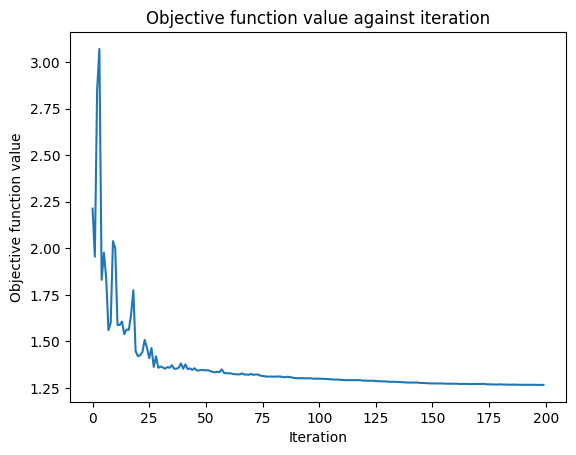

Precision:
 [0.4392156862745098, 0.8541666666666666, 0.85, 0.8344988344988344, 0.9435897435897436, 0.7522222222222222, 0.9333333333333333, 0.8774410774410775, 0.8541666666666666, 0.761904761904762]
Accuracy:
 [0.5333333333333333, 0.8333333333333334, 0.7, 0.8, 0.9333333333333333, 0.7, 0.9333333333333333, 0.8666666666666667, 0.8333333333333334, 0.7333333333333333]
Recalls:
 [0.5555555555555555, 0.8417508417508417, 0.7242424242424242, 0.7925925925925926, 0.9259259259259259, 0.6851851851851851, 0.9326599326599326, 0.872053872053872, 0.8417508417508417, 0.7215488215488216]
F1:
 [0.4717948717948718, 0.8320802005012531, 0.6729323308270677, 0.7961111111111111, 0.9319444444444444, 0.6903733693207376, 0.9333333333333333, 0.8666666666666667, 0.8320802005012531, 0.7345098039215686]
Time:
 [69.77924752235413, 75.94039869308472, 76.1710729598999, 77.26871061325073, 75.39490675926208, 76.57526874542236, 74.85565328598022, 72.94426894187927, 76.66855239868164, 77.02687048912048]
Mean Precision: 0.8100

In [67]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 200
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=4)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
  
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.4392156862745098, 0.8541666666666666, 0.85, 0.8344988344988344, 0.9435897435897436, 0.7522222222222222, 0.9333333333333333, 0.8774410774410775, 0.8541666666666666, 0.761904761904762]
Accuracy:
 [0.5333333333333333, 0.8333333333333334, 0.7, 0.8, 0.9333333333333333, 0.7, 0.9333333333333333, 0.8666666666666667, 0.8333333333333334, 0.7333333333333333]
Recalls:
 [0.5555555555555555, 0.8417508417508417, 0.7242424242424242, 0.7925925925925926, 0.9259259259259259, 0.6851851851851851, 0.9326599326599326, 0.872053872053872, 0.8417508417508417, 0.7215488215488216]
F1:
 [0.4717948717948718, 0.8320802005012531, 0.6729323308270677, 0.7961111111111111, 0.9319444444444444, 0.6903733693207376, 0.9333333333333333, 0.8666666666666667, 0.8320802005012531, 0.7345098039215686]
Time:
 [69.77924752235413, 75.94039869308472, 76.1710729598999, 77.26871061325073, 75.39490675926208, 76.57526874542236, 74.85565328598022, 72.94426894187927, 76.66855239868164, 77.02687048912048]
 
Mean Precision: 0.8100538992597818±0.13668928750876738
Mean Accuracy: 0.7866666666666667±0.11661903789690603
Mean Recall: 0.7893265993265992±0.11219581243357957
Mean F1: 0.7761826332422308±0.13274187496795836
Mean Time: 75.26249504089355±2.1850993022457534

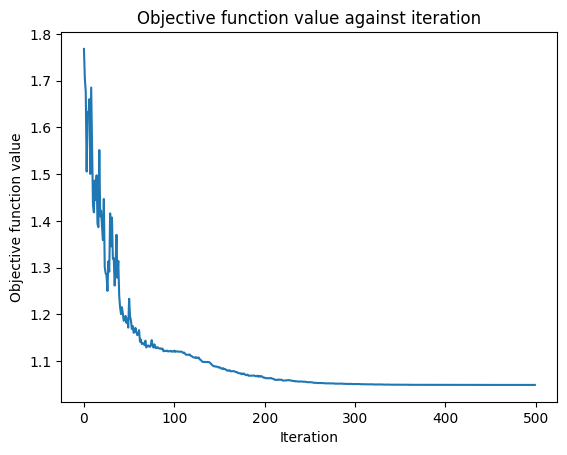

Precision:
 [0.8071428571428572]
Accuracy:
 [0.8]
Recalls:
 [0.794949494949495]
F1:
 [0.7977272727272726]
Time:
 [294.22109603881836]


In [5]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(1):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 500
  num_qubits = X.shape[1]
  opt = COBYLA(maxiter=MAXITR)

  featuremap = ZZFeatureMap(feature_dimension=num_qubits, reps=1, parameter_prefix='x')
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=3)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  score = vqc.score(X_test, Y_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

In [6]:
ZZPauli_realamp_objective_func_vals = objective_func_vals

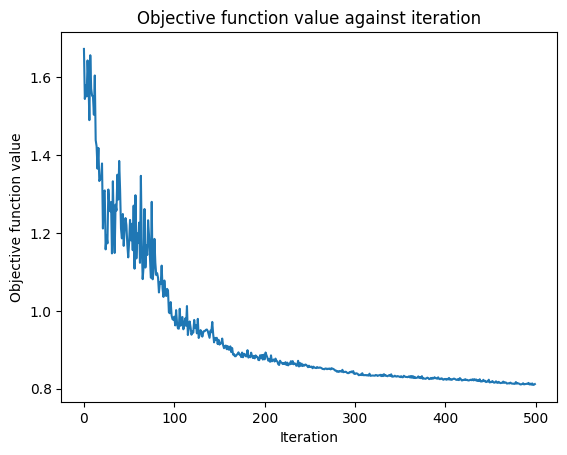

Precision:
 [0.9700000000000001]
Accuracy:
 [0.9666666666666667]
Recalls:
 [0.9696969696969697]
F1:
 [0.966750208855472]
Time:
 [423.63930559158325]


In [7]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(1):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 500
  num_qubits = X.shape[1]
  opt = COBYLA(maxiter=MAXITR)

  featuremap = ZZFeatureMap(feature_dimension=num_qubits, reps=1, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=4, rotation_blocks=['rz', 'ry'], entanglement_blocks='cz')




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  score = vqc.score(X_test, Y_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

In [8]:
ZZPauli_twolocal_objective_func_vals = objective_func_vals

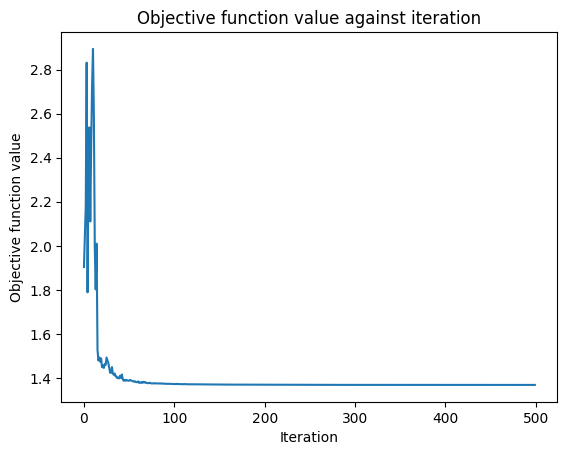

Time:
 [181.63081979751587]
Precision:
 [0.45964912280701753]
Accuracy:
 [0.6]
Recalls:
 [0.6296296296296297]
F1:
 [0.5047619047619047]


In [10]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(1):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 500
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=4)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Time:\n",times)
  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)

In [11]:
effsu2_realamp_objective_func_vals = objective_func_vals

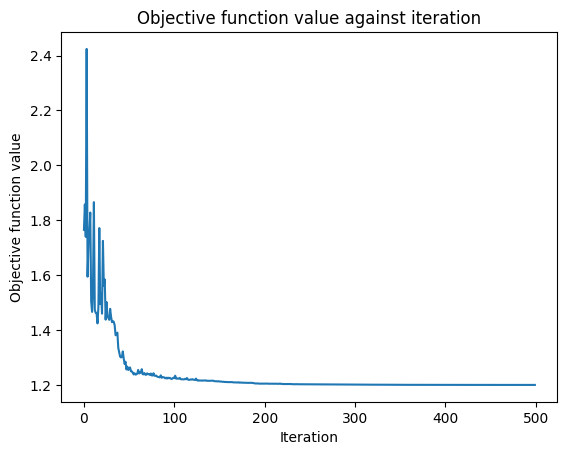

Precision:
 [0.9333333333333333]
Accuracy:
 [0.9333333333333333]
Recalls:
 [0.9326599326599326]
F1:
 [0.9333333333333333]
Time:
 [188.90957140922546]


In [13]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(1):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 500
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=3, rotation_blocks=['rz', 'ry'], entanglement_blocks='cz')



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

In [14]:
effsu2_twolocal_objective_func_vals = objective_func_vals

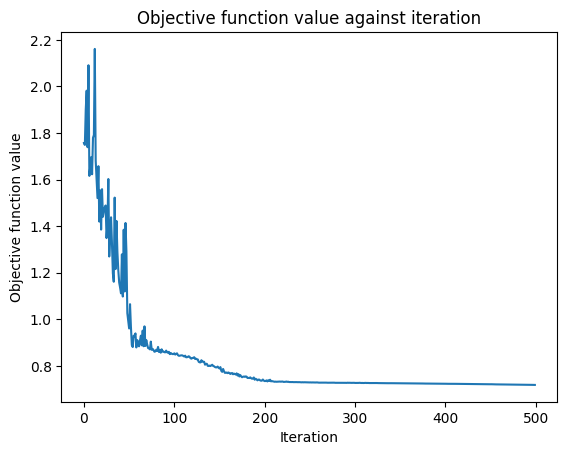

Precision:
 [0.9694444444444444]
Accuracy:
 [0.9666666666666667]
Recall:
 [0.9629629629629629]
F1:
 [0.9664109121909632]
Time:
 [266.04817938804626]


In [46]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(1):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 500
  num_qubits = X.shape[1]
  opt = COBYLA(maxiter=MAXITR)

  featuremap = ZFeatureMap(feature_dimension=num_qubits, reps=2, parameter_prefix='x')
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=3)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  score = vqc.score(X_test, Y_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)


  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

In [47]:
ZPauli_realamp_objective_func_vals = objective_func_vals

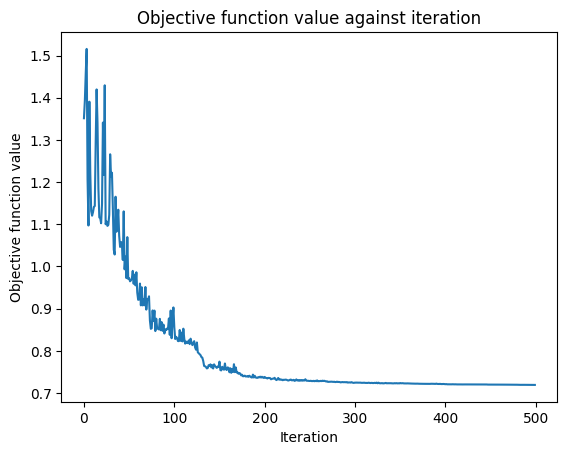

Precision:
 [0.9694444444444444]
Accuracy:
 [0.9666666666666667]
Recall:
 [0.9629629629629629]
F1:
 [0.9664109121909632]
Time:
 [364.8491086959839]


In [48]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(1):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 500
  num_qubits = X.shape[1]
  opt = COBYLA(maxiter=MAXITR)

  featuremap = ZFeatureMap(feature_dimension=num_qubits, reps=2, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=3, rotation_blocks=['rz', 'ry'], entanglement_blocks='cz')



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  score = vqc.score(X_test, Y_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)


  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

In [49]:
ZPauli_twolocal_objective_func_vals = objective_func_vals

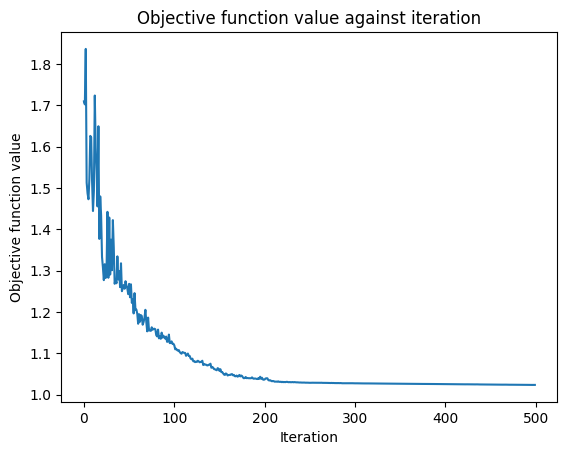

Precision:
 [0.783068783068783]
Accuracy:
 [0.7333333333333333]
Recall:
 [0.7387205387205388]
F1:
 [0.7373231031543052]
Time:
 [307.104688167572]
Precision:
 [0.783068783068783, 0.783068783068783]
Accuracy:
 [0.7333333333333333, 0.7333333333333333]
Recall:
 [0.7387205387205388, 0.7387205387205388]
F1:
 [0.7373231031543052, 0.7373231031543052]
Time:
 [307.104688167572, 307.104688167572]


In [29]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(1):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 500
  num_qubits = X.shape[1]
  opt = COBYLA(maxiter=MAXITR)

  featuremap = PauliFeatureMap(feature_dimension=num_qubits, reps=1, parameter_prefix='x')
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=3)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  score = vqc.score(X_test, Y_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)


  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

In [30]:
Pauli_realamp_objective_func_vals = objective_func_vals

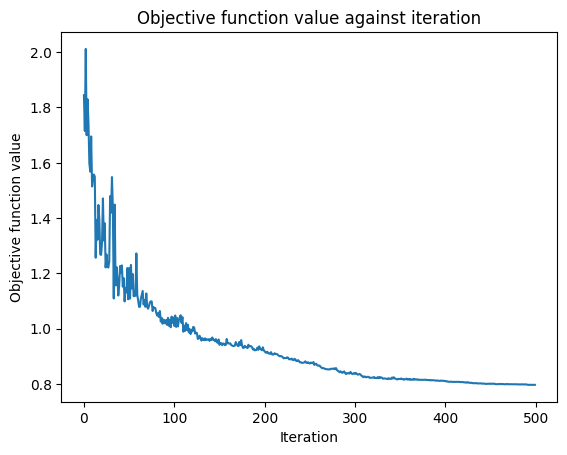

Precision:
 [0.9700000000000001]
Accuracy:
 [0.9666666666666667]
Recall:
 [0.9696969696969697]
F1:
 [0.966750208855472]
Time:
 [398.0089626312256]


In [25]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(1):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 500
  num_qubits = X.shape[1]
  opt = COBYLA(maxiter=MAXITR)

  featuremap = PauliFeatureMap(feature_dimension=num_qubits, reps=1, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=3, rotation_blocks=['rz', 'ry'], entanglement_blocks='cz')



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  score = vqc.score(X_test, Y_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)


  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

In [26]:
Pauli_twolocal_objective_func_vals = objective_func_vals

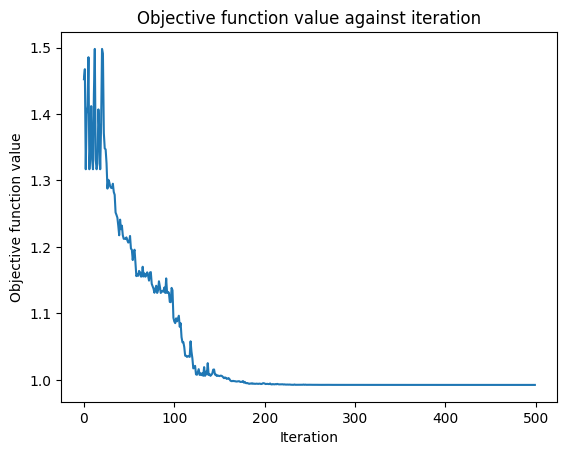

Precision:
 [0.9694444444444444]
Accuracy:
 [0.9666666666666667]
Recalls:
 [0.9629629629629629]
F1:
 [0.9664109121909632]
Time:
 [357.4755582809448]
Mean Precision: 0.9694444444444444±0.0
Mean Accuracy: 0.9666666666666667±0.0
Mean Recall: 0.9629629629629629±0.0
Mean F1: 0.9664109121909632±0.0
Mean Time: 357.4755582809448±0.0


In [69]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(1):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 500
  num_qubits = X.shape[1]
  opt = COBYLA(maxiter=MAXITR)

  featuremap = ZZFeatureMap(feature_dimension=num_qubits, reps=1, parameter_prefix='x')
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=4)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  score = vqc.score(X_test, Y_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
  
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

In [70]:
ZZPauli_paulitd_objective_func_vals = objective_func_vals

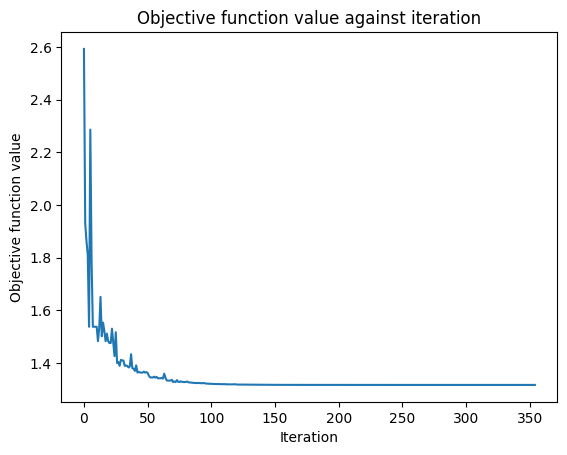

Precision:
 [0.7800653594771242]
Accuracy:
 [0.6666666666666666]
Recalls:
 [0.681144781144781]
F1:
 [0.6748114630467571]
Time:
 [133.8397822380066]
Mean Precision: 0.7800653594771242±0.0
Mean Accuracy: 0.6666666666666666±0.0
Mean Recall: 0.681144781144781±0.0
Mean F1: 0.6748114630467571±0.0
Mean Time: 133.8397822380066±0.0


In [72]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(1):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 500
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=4)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
  
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

In [73]:
effsu2_paulitd_objective_func_vals = objective_func_vals

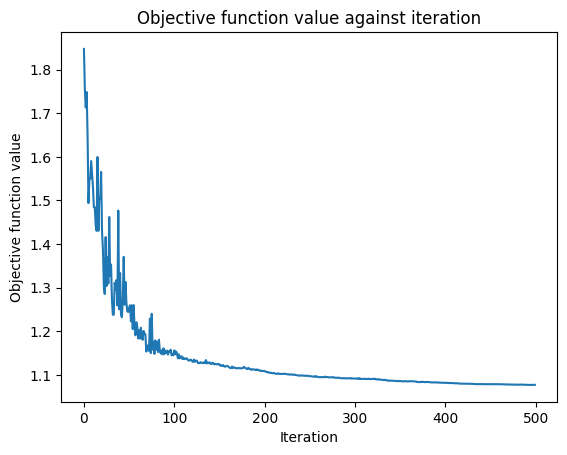

Precision:
 [0.7636363636363636]
Accuracy:
 [0.7333333333333333]
Recalls:
 [0.7313131313131315]
F1:
 [0.7429629629629629]
Time:
 [356.42702651023865]
Mean Precision: 0.7636363636363636±0.0
Mean Accuracy: 0.7333333333333333±0.0
Mean Recall: 0.7313131313131315±0.0
Mean F1: 0.7429629629629629±0.0
Mean Time: 356.42702651023865±0.0


In [82]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(1):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 500
  num_qubits = X.shape[1]
  opt = COBYLA(maxiter=MAXITR)

  featuremap = PauliFeatureMap(feature_dimension=num_qubits, reps=1, parameter_prefix='x')
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=4)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  score = vqc.score(X_test, Y_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
  
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

In [83]:
Pauli_paulitd_objective_func_vals = objective_func_vals

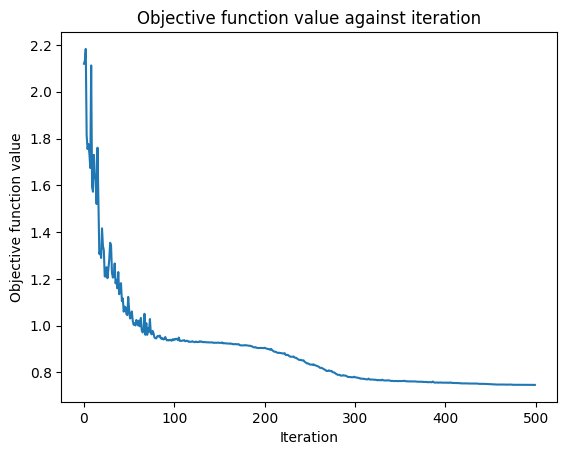

Precision:
 [0.9694444444444444]
Accuracy:
 [0.9666666666666667]
Recall:
 [0.9629629629629629]
F1:
 [0.9664109121909632]
Time:
 [273.2674174308777]


In [85]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(1):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 500
  num_qubits = X.shape[1]
  opt = COBYLA(maxiter=MAXITR)

  featuremap = ZFeatureMap(feature_dimension=num_qubits, reps=2, parameter_prefix='x')
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=3)


  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  score = vqc.score(X_test, Y_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)


  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

In [86]:
ZPauli_paulitd_objective_func_vals = objective_func_vals

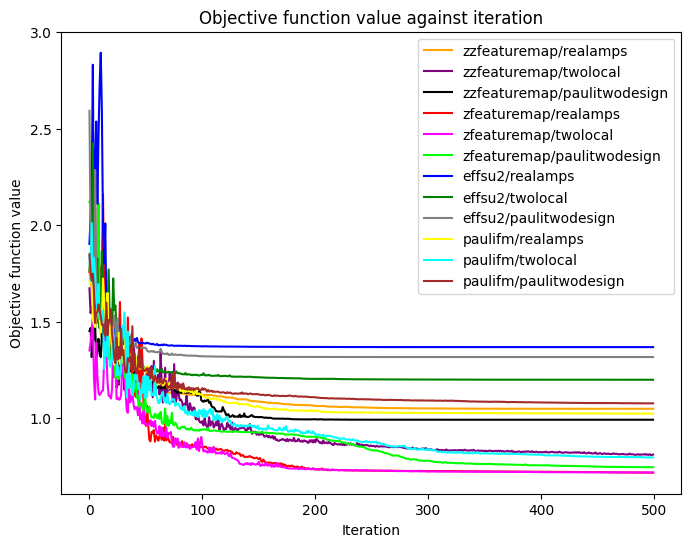

In [98]:
plt.figure(figsize=(8, 6))
plt.title("Objective function value against iteration")
plt.xlabel("Iteration")
plt.ylabel("Objective function value")


# Colors:
#       Blue
#       Red
#       Green
#       Cyan
#       Magenta
#       Yellow
#       Black
#       White
#       Orange
#       Purple

# zzfeaturemap
plt.plot(range(len(ZZPauli_realamp_objective_func_vals)), 
         ZZPauli_realamp_objective_func_vals, color='orange', label='zzfeaturemap/realamps')
plt.plot(range(len(ZZPauli_twolocal_objective_func_vals)), 
         ZZPauli_twolocal_objective_func_vals, color='purple', label='zzfeaturemap/twolocal')
plt.plot(range(len(ZZPauli_paulitd_objective_func_vals)), 
         ZZPauli_paulitd_objective_func_vals, color='black', label='zzfeaturemap/paulitwodesign')

# plt.plot(range(len(ZZPauli_twolocal_objective_func_vals)), 
#          ZZPauli_twolocal_objective_func_vals, color='purple', label='zzfeaturemap/realamp')

# zfeaturemap/
plt.plot(range(len(ZPauli_realamp_objective_func_vals)), 
         ZPauli_realamp_objective_func_vals, color='red', label='zfeaturemap/realamps')
plt.plot(range(len(ZPauli_twolocal_objective_func_vals)), 
         ZPauli_twolocal_objective_func_vals, color='magenta', label='zfeaturemap/twolocal')
plt.plot(range(len(ZPauli_paulitd_objective_func_vals)), 
         ZPauli_paulitd_objective_func_vals, color='lime', label='zfeaturemap/paulitwodesign')

# effsu2
plt.plot(range(len(effsu2_realamp_objective_func_vals)), 
         effsu2_realamp_objective_func_vals, color='blue', label='effsu2/realamps')
plt.plot(range(len(effsu2_twolocal_objective_func_vals)), 
         effsu2_twolocal_objective_func_vals, color='green',
         label='effsu2/twolocal')
plt.plot(range(len(effsu2_paulitd_objective_func_vals)), 
         effsu2_paulitd_objective_func_vals, color='grey', label='effsu2/paulitwodesign')

# pauli
plt.plot(range(len(Pauli_realamp_objective_func_vals)), 
         Pauli_realamp_objective_func_vals, color='yellow', label='paulifm/realamps')
plt.plot(range(len(Pauli_twolocal_objective_func_vals)), 
         Pauli_twolocal_objective_func_vals, color='cyan', label='paulifm/twolocal')
plt.plot(range(len(Pauli_paulitd_objective_func_vals)), 
         Pauli_paulitd_objective_func_vals, color='brown', label='paulifm/paulitwodesign')


plt.legend()
plt.show()

In [77]:
# 355 145
temp = effsu2_paulitd_objective_func_vals

In [80]:
for i in range(145):
    effsu2_paulitd_objective_func_vals.append(temp[len(temp)-1])

# **Classical Neural Networks**

In [9]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

    model = Sequential([
        Dense(1, activation='relu', input_shape=(X_scaled.shape[1],)),
    #     Dense(32, activation='relu'),
        Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    start_time = time.time()

#     class_mapping = {-1: 0, 1: 1}
#     Y_train = np.array([class_mapping[y] for y in Y_train])
#     Y_test = np.array([class_mapping[y] for y in Y_test])

    history = model.fit(X_train, Y_train, batch_size=32, epochs=100, validation_split=0.2, verbose=1)

    training_time = time.time() - start_time
    print(f"Training time: {training_time} seconds")

#     Y_pred = (model.predict(X_test) > 0.5).astype('int32')
    Y_pred = np.argmax(model.predict(X_test),axis=-1)

    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred, average='weighted')
    recall = recall_score(Y_test, Y_pred, average='macro')
    f1 = f1_score(Y_test, Y_pred, average='weighted')

#     print(f'Accuracy: {accuracy}')
#     print(f'Precision: {precision}')
#     print(f'Recall: {recall}')
#     print(f'F1-score: {f1}')
    model.summary()
    times.append(training_time)
    precisions.append(precision)
    accuracies.append(accuracy)
    recalls.append(recall)
    f1s.append(f1)

    
    print("Precision:\n",precisions)
    print("Accuracy:\n",accuracies)
    print("Recalls:\n",recalls)
    print("F1:\n",f1s)
    print("Time:\n",times)
    
    t = np.mean(times)
    t_std = np.std(times)
    p = np.mean(precisions)
    p_std = np.std(precisions)
    a = np.mean(accuracies)
    a_std = np.std(accuracies)
    f = np.mean(f1s)
    f_std = np.std(f1s)
    r = np.mean(recalls)
    r_std = np.std(recalls)
  
    print(f"Mean Precision: {p}±{p_std}")
    print(f"Mean Accuracy: {a}±{a_std}")
    print(f"Mean Recall: {r}±{r_std}")
    print(f"Mean F1: {f}±{f_std}")
    print(f"Mean Time: {t}±{t_std}")


Epoch 1/100
3/3 [==============================] - 1s 74ms/step - loss: 1.0985 - accuracy: 0.3229 - val_loss: 1.0993 - val_accuracy: 0.2083
Epoch 2/100
3/3 [==============================] - 0s 20ms/step - loss: 1.0984 - accuracy: 0.3646 - val_loss: 1.1000 - val_accuracy: 0.2083
Epoch 3/100
3/3 [==============================] - 0s 20ms/step - loss: 1.0981 - accuracy: 0.3646 - val_loss: 1.1005 - val_accuracy: 0.2083
Epoch 4/100
3/3 [==============================] - 0s 25ms/step - loss: 1.0980 - accuracy: 0.3646 - val_loss: 1.1011 - val_accuracy: 0.2083
Epoch 5/100
3/3 [==============================] - 0s 21ms/step - loss: 1.0978 - accuracy: 0.3646 - val_loss: 1.1017 - val_accuracy: 0.2083
Epoch 6/100
3/3 [==============================] - 0s 24ms/step - loss: 1.0977 - accuracy: 0.3646 - val_loss: 1.1022 - val_accuracy: 0.2083
Epoch 7/100
3/3 [==============================] - 0s 29ms/step - loss: 1.0975 - accuracy: 0.3646 - val_loss: 1.1026 - val_accuracy: 0.2083
Epoch 8/100
3/3 [===

/home/gzuz/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 61ms/step - loss: 1.0753 - accuracy: 0.0000e+00 - val_loss: 1.0867 - val_accuracy: 0.0000e+00
Epoch 2/100
3/3 [==============================] - 0s 13ms/step - loss: 1.0742 - accuracy: 0.0104 - val_loss: 1.0865 - val_accuracy: 0.0000e+00
Epoch 3/100
3/3 [==============================] - 0s 18ms/step - loss: 1.0734 - accuracy: 0.0000e+00 - val_loss: 1.0864 - val_accuracy: 0.0000e+00
Epoch 4/100
3/3 [==============================] - 0s 19ms/step - loss: 1.0725 - accuracy: 0.0000e+00 - val_loss: 1.0863 - val_accuracy: 0.0000e+00
Epoch 5/100
3/3 [==============================] - 0s 15ms/step - loss: 1.0716 - accuracy: 0.0000e+00 - val_loss: 1.0861 - val_accuracy: 0.0000e+00
Epoch 6/100
3/3 [==============================] - 0s 13ms/step - loss: 1.0707 - accuracy: 0.0000e+00 - val_loss: 1.0859 - val_accuracy: 0.0000e+00
Epoch 7/100
3/3 [==============================] - 0s 15ms/step - loss: 1.0699 - accuracy: 0.0000e+00 - val_loss: 1.0858 - val_a

/home/gzuz/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 68ms/step - loss: 1.0676 - accuracy: 0.5000 - val_loss: 1.0746 - val_accuracy: 0.5000
Epoch 2/100
3/3 [==============================] - 0s 15ms/step - loss: 1.0663 - accuracy: 0.6771 - val_loss: 1.0742 - val_accuracy: 0.5000
Epoch 3/100
3/3 [==============================] - 0s 15ms/step - loss: 1.0649 - accuracy: 0.6667 - val_loss: 1.0738 - val_accuracy: 0.4583
Epoch 4/100
3/3 [==============================] - 0s 17ms/step - loss: 1.0636 - accuracy: 0.6667 - val_loss: 1.0735 - val_accuracy: 0.4583
Epoch 5/100
3/3 [==============================] - 0s 17ms/step - loss: 1.0623 - accuracy: 0.6667 - val_loss: 1.0734 - val_accuracy: 0.4167
Epoch 6/100
3/3 [==============================] - 0s 28ms/step - loss: 1.0608 - accuracy: 0.6667 - val_loss: 1.0732 - val_accuracy: 0.3750
Epoch 7/100
3/3 [==============================] - 0s 26ms/step - loss: 1.0597 - accuracy: 0.6667 - val_loss: 1.0731 - val_accuracy: 0.3750
Epoch 8/100
3/3 [===============

/home/gzuz/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 54ms/step - loss: 1.1890 - accuracy: 0.3542 - val_loss: 1.4054 - val_accuracy: 0.2917
Epoch 2/100
3/3 [==============================] - 0s 12ms/step - loss: 1.1842 - accuracy: 0.3646 - val_loss: 1.3969 - val_accuracy: 0.2917
Epoch 3/100
3/3 [==============================] - 0s 13ms/step - loss: 1.1799 - accuracy: 0.3646 - val_loss: 1.3887 - val_accuracy: 0.2917
Epoch 4/100
3/3 [==============================] - 0s 15ms/step - loss: 1.1751 - accuracy: 0.3646 - val_loss: 1.3807 - val_accuracy: 0.2917
Epoch 5/100
3/3 [==============================] - 0s 14ms/step - loss: 1.1714 - accuracy: 0.3646 - val_loss: 1.3727 - val_accuracy: 0.2917
Epoch 6/100
3/3 [==============================] - 0s 15ms/step - loss: 1.1668 - accuracy: 0.3646 - val_loss: 1.3650 - val_accuracy: 0.2917
Epoch 7/100
3/3 [==============================] - 0s 15ms/step - loss: 1.1635 - accuracy: 0.3750 - val_loss: 1.3571 - val_accuracy: 0.2917
Epoch 8/100
3/3 [===============

/home/gzuz/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 67ms/step - loss: 1.0769 - accuracy: 0.3646 - val_loss: 1.0732 - val_accuracy: 0.2083
Epoch 2/100
3/3 [==============================] - 0s 14ms/step - loss: 1.0754 - accuracy: 0.3750 - val_loss: 1.0729 - val_accuracy: 0.2083
Epoch 3/100
3/3 [==============================] - 0s 14ms/step - loss: 1.0741 - accuracy: 0.3750 - val_loss: 1.0727 - val_accuracy: 0.2083
Epoch 4/100
3/3 [==============================] - 0s 17ms/step - loss: 1.0724 - accuracy: 0.3750 - val_loss: 1.0725 - val_accuracy: 0.2083
Epoch 5/100
3/3 [==============================] - 0s 19ms/step - loss: 1.0710 - accuracy: 0.3750 - val_loss: 1.0722 - val_accuracy: 0.2083
Epoch 6/100
3/3 [==============================] - 0s 16ms/step - loss: 1.0696 - accuracy: 0.3750 - val_loss: 1.0720 - val_accuracy: 0.2083
Epoch 7/100
3/3 [==============================] - 0s 15ms/step - loss: 1.0679 - accuracy: 0.3750 - val_loss: 1.0718 - val_accuracy: 0.2083
Epoch 8/100
3/3 [===============

/home/gzuz/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 1s 85ms/step - loss: 1.0986 - accuracy: 0.3438 - val_loss: 1.0995 - val_accuracy: 0.2083
Epoch 2/100
3/3 [==============================] - 0s 15ms/step - loss: 1.0983 - accuracy: 0.3646 - val_loss: 1.1001 - val_accuracy: 0.2083
Epoch 3/100
3/3 [==============================] - 0s 14ms/step - loss: 1.0981 - accuracy: 0.3646 - val_loss: 1.1006 - val_accuracy: 0.2083
Epoch 4/100
3/3 [==============================] - 0s 14ms/step - loss: 1.0980 - accuracy: 0.3646 - val_loss: 1.1012 - val_accuracy: 0.2083
Epoch 5/100
3/3 [==============================] - 0s 14ms/step - loss: 1.0978 - accuracy: 0.3646 - val_loss: 1.1018 - val_accuracy: 0.2083
Epoch 6/100
3/3 [==============================] - 0s 14ms/step - loss: 1.0976 - accuracy: 0.3646 - val_loss: 1.1024 - val_accuracy: 0.2083
Epoch 7/100
3/3 [==============================] - 0s 17ms/step - loss: 1.0975 - accuracy: 0.3646 - val_loss: 1.1029 - val_accuracy: 0.2083
Epoch 8/100
3/3 [===============

/home/gzuz/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 1s 158ms/step - loss: 1.1274 - accuracy: 0.3542 - val_loss: 1.2186 - val_accuracy: 0.2917
Epoch 2/100
3/3 [==============================] - 0s 24ms/step - loss: 1.1255 - accuracy: 0.3542 - val_loss: 1.2146 - val_accuracy: 0.2917
Epoch 3/100
3/3 [==============================] - 0s 31ms/step - loss: 1.1237 - accuracy: 0.3542 - val_loss: 1.2108 - val_accuracy: 0.2917
Epoch 4/100
3/3 [==============================] - 0s 39ms/step - loss: 1.1221 - accuracy: 0.3542 - val_loss: 1.2072 - val_accuracy: 0.2917
Epoch 5/100
3/3 [==============================] - 0s 38ms/step - loss: 1.1206 - accuracy: 0.3542 - val_loss: 1.2036 - val_accuracy: 0.2917
Epoch 6/100
3/3 [==============================] - 0s 33ms/step - loss: 1.1190 - accuracy: 0.3542 - val_loss: 1.2004 - val_accuracy: 0.2917
Epoch 7/100
3/3 [==============================] - 0s 27ms/step - loss: 1.1172 - accuracy: 0.3542 - val_loss: 1.1976 - val_accuracy: 0.2917
Epoch 8/100
3/3 [==============

/home/gzuz/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 58ms/step - loss: 1.0988 - accuracy: 0.2604 - val_loss: 1.0986 - val_accuracy: 0.2083
Epoch 2/100
3/3 [==============================] - 0s 13ms/step - loss: 1.0986 - accuracy: 0.3646 - val_loss: 1.0992 - val_accuracy: 0.2083
Epoch 3/100
3/3 [==============================] - 0s 14ms/step - loss: 1.0984 - accuracy: 0.3646 - val_loss: 1.0996 - val_accuracy: 0.2083
Epoch 4/100
3/3 [==============================] - 0s 15ms/step - loss: 1.0983 - accuracy: 0.3646 - val_loss: 1.1002 - val_accuracy: 0.2083
Epoch 5/100
3/3 [==============================] - 0s 14ms/step - loss: 1.0981 - accuracy: 0.3646 - val_loss: 1.1007 - val_accuracy: 0.2083
Epoch 6/100
3/3 [==============================] - 0s 15ms/step - loss: 1.0979 - accuracy: 0.3646 - val_loss: 1.1011 - val_accuracy: 0.2083
Epoch 7/100
3/3 [==============================] - 0s 14ms/step - loss: 1.0978 - accuracy: 0.3646 - val_loss: 1.1016 - val_accuracy: 0.2083
Epoch 8/100
3/3 [===============

/home/gzuz/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 1s 299ms/step - loss: 1.5117 - accuracy: 0.3542 - val_loss: 1.8605 - val_accuracy: 0.2917
Epoch 2/100
3/3 [==============================] - 0s 21ms/step - loss: 1.5015 - accuracy: 0.3542 - val_loss: 1.8454 - val_accuracy: 0.2917
Epoch 3/100
3/3 [==============================] - 0s 19ms/step - loss: 1.4906 - accuracy: 0.3542 - val_loss: 1.8307 - val_accuracy: 0.2917
Epoch 4/100
3/3 [==============================] - 0s 19ms/step - loss: 1.4804 - accuracy: 0.3542 - val_loss: 1.8162 - val_accuracy: 0.2917
Epoch 5/100
3/3 [==============================] - 0s 20ms/step - loss: 1.4716 - accuracy: 0.3542 - val_loss: 1.8015 - val_accuracy: 0.2917
Epoch 6/100
3/3 [==============================] - 0s 28ms/step - loss: 1.4616 - accuracy: 0.3542 - val_loss: 1.7874 - val_accuracy: 0.2917
Epoch 7/100
3/3 [==============================] - 0s 23ms/step - loss: 1.4513 - accuracy: 0.3542 - val_loss: 1.7736 - val_accuracy: 0.2917
Epoch 8/100
3/3 [==============

/home/gzuz/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 67ms/step - loss: 1.0987 - accuracy: 0.3646 - val_loss: 1.0989 - val_accuracy: 0.2083
Epoch 2/100
3/3 [==============================] - 0s 17ms/step - loss: 1.0986 - accuracy: 0.3646 - val_loss: 1.0992 - val_accuracy: 0.2083
Epoch 3/100
3/3 [==============================] - 0s 19ms/step - loss: 1.0984 - accuracy: 0.3646 - val_loss: 1.0996 - val_accuracy: 0.2083
Epoch 4/100
3/3 [==============================] - 0s 20ms/step - loss: 1.0983 - accuracy: 0.3646 - val_loss: 1.1001 - val_accuracy: 0.2083
Epoch 5/100
3/3 [==============================] - 0s 32ms/step - loss: 1.0981 - accuracy: 0.3646 - val_loss: 1.1006 - val_accuracy: 0.2083
Epoch 6/100
3/3 [==============================] - 0s 32ms/step - loss: 1.0980 - accuracy: 0.3646 - val_loss: 1.1012 - val_accuracy: 0.2083
Epoch 7/100
3/3 [==============================] - 0s 28ms/step - loss: 1.0979 - accuracy: 0.3646 - val_loss: 1.1017 - val_accuracy: 0.2083
Epoch 8/100
3/3 [===============

/home/gzuz/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

    model = Sequential([
        Dense(2, activation='relu', input_shape=(X_scaled.shape[1],)),
    #     Dense(32, activation='relu'),
        Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    start_time = time.time()

#     class_mapping = {-1: 0, 1: 1}
#     Y_train = np.array([class_mapping[y] for y in Y_train])
#     Y_test = np.array([class_mapping[y] for y in Y_test])

    history = model.fit(X_train, Y_train, batch_size=32, epochs=100, validation_split=0.2, verbose=1)

    training_time = time.time() - start_time
    print(f"Training time: {training_time} seconds")

#     Y_pred = (model.predict(X_test) > 0.5).astype('int32')
    Y_pred = np.argmax(model.predict(X_test),axis=-1)

    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred, average='weighted')
    recall = recall_score(Y_test, Y_pred, average='macro')
    f1 = f1_score(Y_test, Y_pred, average='weighted')

#     print(f'Accuracy: {accuracy}')
#     print(f'Precision: {precision}')
#     print(f'Recall: {recall}')
#     print(f'F1-score: {f1}')
    model.summary()
    times.append(training_time)
    precisions.append(precision)
    accuracies.append(accuracy)
    recalls.append(recall)
    f1s.append(f1)

    
    print("Precision:\n",precisions)
    print("Accuracy:\n",accuracies)
    print("Recalls:\n",recalls)
    print("F1:\n",f1s)
    print("Time:\n",times)
    
    t = np.mean(times)
    t_std = np.std(times)
    p = np.mean(precisions)
    p_std = np.std(precisions)
    a = np.mean(accuracies)
    a_std = np.std(accuracies)
    f = np.mean(f1s)
    f_std = np.std(f1s)
    r = np.mean(recalls)
    r_std = np.std(recalls)
  
    print(f"Mean Precision: {p}±{p_std}")
    print(f"Mean Accuracy: {a}±{a_std}")
    print(f"Mean Recall: {r}±{r_std}")
    print(f"Mean F1: {f}±{f_std}")
    print(f"Mean Time: {t}±{t_std}")


Epoch 1/100
3/3 [==============================] - 1s 72ms/step - loss: 1.4114 - accuracy: 0.3646 - val_loss: 1.8411 - val_accuracy: 0.2083
Epoch 2/100
3/3 [==============================] - 0s 14ms/step - loss: 1.4028 - accuracy: 0.3646 - val_loss: 1.8278 - val_accuracy: 0.2083
Epoch 3/100
3/3 [==============================] - 0s 21ms/step - loss: 1.3940 - accuracy: 0.3646 - val_loss: 1.8149 - val_accuracy: 0.2083
Epoch 4/100
3/3 [==============================] - 0s 19ms/step - loss: 1.3859 - accuracy: 0.3646 - val_loss: 1.8020 - val_accuracy: 0.2083
Epoch 5/100
3/3 [==============================] - 0s 28ms/step - loss: 1.3779 - accuracy: 0.3646 - val_loss: 1.7893 - val_accuracy: 0.2083
Epoch 6/100
3/3 [==============================] - 0s 20ms/step - loss: 1.3702 - accuracy: 0.3646 - val_loss: 1.7766 - val_accuracy: 0.2083
Epoch 7/100
3/3 [==============================] - 0s 15ms/step - loss: 1.3623 - accuracy: 0.3646 - val_loss: 1.7641 - val_accuracy: 0.2083
Epoch 8/100
3/3 [===

/home/gzuz/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 75ms/step - loss: 1.2379 - accuracy: 0.3646 - val_loss: 1.3191 - val_accuracy: 0.2083
Epoch 2/100
3/3 [==============================] - 0s 24ms/step - loss: 1.2273 - accuracy: 0.3646 - val_loss: 1.3063 - val_accuracy: 0.2083
Epoch 3/100
3/3 [==============================] - 0s 22ms/step - loss: 1.2167 - accuracy: 0.3646 - val_loss: 1.2947 - val_accuracy: 0.2083
Epoch 4/100
3/3 [==============================] - 0s 17ms/step - loss: 1.2071 - accuracy: 0.3646 - val_loss: 1.2830 - val_accuracy: 0.2083
Epoch 5/100
3/3 [==============================] - 0s 19ms/step - loss: 1.1979 - accuracy: 0.3646 - val_loss: 1.2714 - val_accuracy: 0.2083
Epoch 6/100
3/3 [==============================] - 0s 16ms/step - loss: 1.1886 - accuracy: 0.3646 - val_loss: 1.2604 - val_accuracy: 0.2083
Epoch 7/100
3/3 [==============================] - 0s 19ms/step - loss: 1.1796 - accuracy: 0.3646 - val_loss: 1.2497 - val_accuracy: 0.2083
Epoch 8/100
3/3 [===============

/home/gzuz/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 59ms/step - loss: 1.0637 - accuracy: 0.3438 - val_loss: 1.0771 - val_accuracy: 0.2083
Epoch 2/100
3/3 [==============================] - 0s 11ms/step - loss: 1.0596 - accuracy: 0.3438 - val_loss: 1.0755 - val_accuracy: 0.2083
Epoch 3/100
3/3 [==============================] - 0s 20ms/step - loss: 1.0557 - accuracy: 0.3542 - val_loss: 1.0739 - val_accuracy: 0.2083
Epoch 4/100
3/3 [==============================] - 0s 20ms/step - loss: 1.0516 - accuracy: 0.4583 - val_loss: 1.0722 - val_accuracy: 0.5000
Epoch 5/100
3/3 [==============================] - 0s 19ms/step - loss: 1.0481 - accuracy: 0.6771 - val_loss: 1.0704 - val_accuracy: 0.5000
Epoch 6/100
3/3 [==============================] - 0s 25ms/step - loss: 1.0444 - accuracy: 0.6562 - val_loss: 1.0686 - val_accuracy: 0.5000
Epoch 7/100
3/3 [==============================] - 0s 23ms/step - loss: 1.0414 - accuracy: 0.6458 - val_loss: 1.0669 - val_accuracy: 0.5000
Epoch 8/100
3/3 [===============

/home/gzuz/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 78ms/step - loss: 1.0904 - accuracy: 0.0000e+00 - val_loss: 1.0942 - val_accuracy: 0.0000e+00
Epoch 2/100
3/3 [==============================] - 0s 16ms/step - loss: 1.0899 - accuracy: 0.0000e+00 - val_loss: 1.0943 - val_accuracy: 0.0000e+00
Epoch 3/100
3/3 [==============================] - 0s 16ms/step - loss: 1.0894 - accuracy: 0.0000e+00 - val_loss: 1.0943 - val_accuracy: 0.0000e+00
Epoch 4/100
3/3 [==============================] - 0s 15ms/step - loss: 1.0888 - accuracy: 0.0000e+00 - val_loss: 1.0942 - val_accuracy: 0.0000e+00
Epoch 5/100
3/3 [==============================] - 0s 18ms/step - loss: 1.0883 - accuracy: 0.0000e+00 - val_loss: 1.0943 - val_accuracy: 0.0000e+00
Epoch 6/100
3/3 [==============================] - 0s 23ms/step - loss: 1.0877 - accuracy: 0.0000e+00 - val_loss: 1.0942 - val_accuracy: 0.0000e+00
Epoch 7/100
3/3 [==============================] - 0s 20ms/step - loss: 1.0873 - accuracy: 0.0000e+00 - val_loss: 1.0942 - v

/home/gzuz/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 65ms/step - loss: 1.0482 - accuracy: 0.3958 - val_loss: 1.0669 - val_accuracy: 0.2500
Epoch 2/100
3/3 [==============================] - 0s 14ms/step - loss: 1.0459 - accuracy: 0.4062 - val_loss: 1.0661 - val_accuracy: 0.2500
Epoch 3/100
3/3 [==============================] - 0s 17ms/step - loss: 1.0444 - accuracy: 0.4167 - val_loss: 1.0653 - val_accuracy: 0.2500
Epoch 4/100
3/3 [==============================] - 0s 32ms/step - loss: 1.0421 - accuracy: 0.4375 - val_loss: 1.0646 - val_accuracy: 0.2500
Epoch 5/100
3/3 [==============================] - 0s 21ms/step - loss: 1.0405 - accuracy: 0.4375 - val_loss: 1.0639 - val_accuracy: 0.2500
Epoch 6/100
3/3 [==============================] - 0s 16ms/step - loss: 1.0387 - accuracy: 0.4479 - val_loss: 1.0632 - val_accuracy: 0.2500
Epoch 7/100
3/3 [==============================] - 0s 22ms/step - loss: 1.0370 - accuracy: 0.4583 - val_loss: 1.0625 - val_accuracy: 0.2500
Epoch 8/100
3/3 [===============

/home/gzuz/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 45ms/step - loss: 1.0703 - accuracy: 0.2396 - val_loss: 1.0211 - val_accuracy: 0.3750
Epoch 2/100
3/3 [==============================] - 0s 11ms/step - loss: 1.0683 - accuracy: 0.2396 - val_loss: 1.0202 - val_accuracy: 0.3750
Epoch 3/100
3/3 [==============================] - 0s 29ms/step - loss: 1.0663 - accuracy: 0.2292 - val_loss: 1.0185 - val_accuracy: 0.3750
Epoch 4/100
3/3 [==============================] - 0s 14ms/step - loss: 1.0643 - accuracy: 0.2396 - val_loss: 1.0171 - val_accuracy: 0.3750
Epoch 5/100
3/3 [==============================] - 0s 11ms/step - loss: 1.0624 - accuracy: 0.2396 - val_loss: 1.0159 - val_accuracy: 0.3750
Epoch 6/100
3/3 [==============================] - 0s 14ms/step - loss: 1.0605 - accuracy: 0.2500 - val_loss: 1.0144 - val_accuracy: 0.3750
Epoch 7/100
3/3 [==============================] - 0s 16ms/step - loss: 1.0587 - accuracy: 0.2500 - val_loss: 1.0134 - val_accuracy: 0.3333
Epoch 8/100
3/3 [===============

3/3 [==============================] - 0s 15ms/step - loss: 1.0986 - accuracy: 0.3542 - val_loss: 1.0923 - val_accuracy: 0.2917
Epoch 6/100
3/3 [==============================] - 0s 19ms/step - loss: 1.0982 - accuracy: 0.3542 - val_loss: 1.0924 - val_accuracy: 0.2917
Epoch 7/100
3/3 [==============================] - 0s 15ms/step - loss: 1.0979 - accuracy: 0.3542 - val_loss: 1.0925 - val_accuracy: 0.2917
Epoch 8/100
3/3 [==============================] - 0s 15ms/step - loss: 1.0976 - accuracy: 0.3542 - val_loss: 1.0926 - val_accuracy: 0.2917
Epoch 9/100
3/3 [==============================] - 0s 14ms/step - loss: 1.0973 - accuracy: 0.3542 - val_loss: 1.0928 - val_accuracy: 0.2917
Epoch 10/100
3/3 [==============================] - 0s 14ms/step - loss: 1.0969 - accuracy: 0.3542 - val_loss: 1.0929 - val_accuracy: 0.2917
Epoch 11/100
3/3 [==============================] - 0s 13ms/step - loss: 1.0966 - accuracy: 0.3542 - val_loss: 1.0929 - val_accuracy: 0.2917
Epoch 12/100
3/3 [============

3/3 [==============================] - 0s 16ms/step - loss: 1.1182 - accuracy: 0.3542 - val_loss: 1.1418 - val_accuracy: 0.2917
Epoch 10/100
3/3 [==============================] - 0s 17ms/step - loss: 1.1169 - accuracy: 0.3542 - val_loss: 1.1406 - val_accuracy: 0.2917
Epoch 11/100
3/3 [==============================] - 0s 15ms/step - loss: 1.1152 - accuracy: 0.3438 - val_loss: 1.1394 - val_accuracy: 0.2917
Epoch 12/100
3/3 [==============================] - 0s 14ms/step - loss: 1.1138 - accuracy: 0.3438 - val_loss: 1.1381 - val_accuracy: 0.2917
Epoch 13/100
3/3 [==============================] - 0s 15ms/step - loss: 1.1122 - accuracy: 0.3438 - val_loss: 1.1372 - val_accuracy: 0.2917
Epoch 14/100
3/3 [==============================] - 0s 17ms/step - loss: 1.1109 - accuracy: 0.3438 - val_loss: 1.1363 - val_accuracy: 0.2917
Epoch 15/100
3/3 [==============================] - 0s 15ms/step - loss: 1.1095 - accuracy: 0.3333 - val_loss: 1.1352 - val_accuracy: 0.2917
Epoch 16/100
3/3 [========

/home/gzuz/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 60ms/step - loss: 1.2405 - accuracy: 0.3542 - val_loss: 1.2013 - val_accuracy: 0.2917
Epoch 2/100
3/3 [==============================] - 0s 16ms/step - loss: 1.2370 - accuracy: 0.2917 - val_loss: 1.1990 - val_accuracy: 0.2500
Epoch 3/100
3/3 [==============================] - 0s 13ms/step - loss: 1.2337 - accuracy: 0.2812 - val_loss: 1.1972 - val_accuracy: 0.2500
Epoch 4/100
3/3 [==============================] - 0s 17ms/step - loss: 1.2300 - accuracy: 0.2708 - val_loss: 1.1953 - val_accuracy: 0.2500
Epoch 5/100
3/3 [==============================] - 0s 15ms/step - loss: 1.2269 - accuracy: 0.2500 - val_loss: 1.1934 - val_accuracy: 0.2500
Epoch 6/100
3/3 [==============================] - 0s 19ms/step - loss: 1.2237 - accuracy: 0.2396 - val_loss: 1.1918 - val_accuracy: 0.2500
Epoch 7/100
3/3 [==============================] - 0s 14ms/step - loss: 1.2205 - accuracy: 0.2083 - val_loss: 1.1899 - val_accuracy: 0.2500
Epoch 8/100
3/3 [===============

Epoch 59/100
3/3 [==============================] - 0s 13ms/step - loss: 1.1028 - accuracy: 0.2604 - val_loss: 1.1334 - val_accuracy: 0.1250
Epoch 60/100
3/3 [==============================] - 0s 13ms/step - loss: 1.1022 - accuracy: 0.2604 - val_loss: 1.1332 - val_accuracy: 0.1250
Epoch 61/100
3/3 [==============================] - 0s 14ms/step - loss: 1.1017 - accuracy: 0.2604 - val_loss: 1.1332 - val_accuracy: 0.1250
Epoch 62/100
3/3 [==============================] - 0s 14ms/step - loss: 1.1011 - accuracy: 0.2708 - val_loss: 1.1330 - val_accuracy: 0.1250
Epoch 63/100
3/3 [==============================] - 0s 13ms/step - loss: 1.1007 - accuracy: 0.2917 - val_loss: 1.1329 - val_accuracy: 0.1250
Epoch 64/100
3/3 [==============================] - 0s 14ms/step - loss: 1.1003 - accuracy: 0.3021 - val_loss: 1.1329 - val_accuracy: 0.1250
Epoch 65/100
3/3 [==============================] - 0s 14ms/step - loss: 1.0999 - accuracy: 0.3021 - val_loss: 1.1329 - val_accuracy: 0.1250
Epoch 66/100


/home/gzuz/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 60ms/step - loss: 1.1297 - accuracy: 0.2396 - val_loss: 1.1518 - val_accuracy: 0.0000e+00
Epoch 2/100
3/3 [==============================] - 0s 13ms/step - loss: 1.1279 - accuracy: 0.0000e+00 - val_loss: 1.1497 - val_accuracy: 0.0000e+00
Epoch 3/100
3/3 [==============================] - 0s 15ms/step - loss: 1.1262 - accuracy: 0.0000e+00 - val_loss: 1.1476 - val_accuracy: 0.0000e+00
Epoch 4/100
3/3 [==============================] - 0s 14ms/step - loss: 1.1244 - accuracy: 0.0000e+00 - val_loss: 1.1455 - val_accuracy: 0.0000e+00
Epoch 5/100
3/3 [==============================] - 0s 14ms/step - loss: 1.1227 - accuracy: 0.0000e+00 - val_loss: 1.1436 - val_accuracy: 0.0000e+00
Epoch 6/100
3/3 [==============================] - 0s 16ms/step - loss: 1.1211 - accuracy: 0.0000e+00 - val_loss: 1.1416 - val_accuracy: 0.0000e+00
Epoch 7/100
3/3 [==============================] - 0s 16ms/step - loss: 1.1195 - accuracy: 0.0000e+00 - val_loss: 1.1396 - val_a

/home/gzuz/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

    model = Sequential([
        Dense(3, activation='relu', input_shape=(X_scaled.shape[1],)),
    #     Dense(32, activation='relu'),
        Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    start_time = time.time()

#     class_mapping = {-1: 0, 1: 1}
#     Y_train = np.array([class_mapping[y] for y in Y_train])
#     Y_test = np.array([class_mapping[y] for y in Y_test])

    history = model.fit(X_train, Y_train, batch_size=32, epochs=100, validation_split=0.2, verbose=1)

    training_time = time.time() - start_time
    print(f"Training time: {training_time} seconds")

#     Y_pred = (model.predict(X_test) > 0.5).astype('int32')
    Y_pred = np.argmax(model.predict(X_test),axis=-1)

    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred, average='weighted')
    recall = recall_score(Y_test, Y_pred, average='macro')
    f1 = f1_score(Y_test, Y_pred, average='weighted')

#     print(f'Accuracy: {accuracy}')
#     print(f'Precision: {precision}')
#     print(f'Recall: {recall}')
#     print(f'F1-score: {f1}')
    model.summary()
    times.append(training_time)
    precisions.append(precision)
    accuracies.append(accuracy)
    recalls.append(recall)
    f1s.append(f1)

    
    print("Precision:\n",precisions)
    print("Accuracy:\n",accuracies)
    print("Recalls:\n",recalls)
    print("F1:\n",f1s)
    print("Time:\n",times)
    
    t = np.mean(times)
    t_std = np.std(times)
    p = np.mean(precisions)
    p_std = np.std(precisions)
    a = np.mean(accuracies)
    a_std = np.std(accuracies)
    f = np.mean(f1s)
    f_std = np.std(f1s)
    r = np.mean(recalls)
    r_std = np.std(recalls)
  
    print(f"Mean Precision: {p}±{p_std}")
    print(f"Mean Accuracy: {a}±{a_std}")
    print(f"Mean Recall: {r}±{r_std}")
    print(f"Mean F1: {f}±{f_std}")
    print(f"Mean Time: {t}±{t_std}")


Epoch 1/100
3/3 [==============================] - 1s 56ms/step - loss: 1.1275 - accuracy: 0.3750 - val_loss: 1.2171 - val_accuracy: 0.3333
Epoch 2/100
3/3 [==============================] - 0s 10ms/step - loss: 1.1227 - accuracy: 0.3958 - val_loss: 1.2105 - val_accuracy: 0.3750
Epoch 3/100
3/3 [==============================] - 0s 18ms/step - loss: 1.1179 - accuracy: 0.4062 - val_loss: 1.2042 - val_accuracy: 0.3750
Epoch 4/100
3/3 [==============================] - 0s 35ms/step - loss: 1.1134 - accuracy: 0.4375 - val_loss: 1.1978 - val_accuracy: 0.3750
Epoch 5/100
3/3 [==============================] - 0s 17ms/step - loss: 1.1084 - accuracy: 0.4792 - val_loss: 1.1922 - val_accuracy: 0.3750
Epoch 6/100
3/3 [==============================] - 0s 26ms/step - loss: 1.1043 - accuracy: 0.5312 - val_loss: 1.1863 - val_accuracy: 0.4583
Epoch 7/100
3/3 [==============================] - 0s 21ms/step - loss: 1.1000 - accuracy: 0.5625 - val_loss: 1.1808 - val_accuracy: 0.4583
Epoch 8/100
3/3 [===

/home/gzuz/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 55ms/step - loss: 1.2146 - accuracy: 0.2812 - val_loss: 1.0005 - val_accuracy: 0.5000
Epoch 2/100
3/3 [==============================] - 0s 14ms/step - loss: 1.2067 - accuracy: 0.2812 - val_loss: 0.9975 - val_accuracy: 0.5000
Epoch 3/100
3/3 [==============================] - 0s 14ms/step - loss: 1.1999 - accuracy: 0.2812 - val_loss: 0.9942 - val_accuracy: 0.5000
Epoch 4/100
3/3 [==============================] - 0s 13ms/step - loss: 1.1926 - accuracy: 0.2812 - val_loss: 0.9910 - val_accuracy: 0.5000
Epoch 5/100
3/3 [==============================] - 0s 13ms/step - loss: 1.1853 - accuracy: 0.2812 - val_loss: 0.9880 - val_accuracy: 0.5000
Epoch 6/100
3/3 [==============================] - 0s 17ms/step - loss: 1.1777 - accuracy: 0.2812 - val_loss: 0.9853 - val_accuracy: 0.5000
Epoch 7/100
3/3 [==============================] - 0s 13ms/step - loss: 1.1722 - accuracy: 0.2812 - val_loss: 0.9826 - val_accuracy: 0.5000
Epoch 8/100
3/3 [===============

3/3 [==============================] - 0s 15ms/step - loss: 1.1360 - accuracy: 0.1771 - val_loss: 1.1213 - val_accuracy: 0.1250
Epoch 9/100
3/3 [==============================] - 0s 16ms/step - loss: 1.1334 - accuracy: 0.1667 - val_loss: 1.1204 - val_accuracy: 0.0417
Epoch 10/100
3/3 [==============================] - 0s 16ms/step - loss: 1.1310 - accuracy: 0.1250 - val_loss: 1.1197 - val_accuracy: 0.0417
Epoch 11/100
3/3 [==============================] - 0s 15ms/step - loss: 1.1284 - accuracy: 0.1250 - val_loss: 1.1189 - val_accuracy: 0.0417
Epoch 12/100
3/3 [==============================] - 0s 33ms/step - loss: 1.1264 - accuracy: 0.0625 - val_loss: 1.1182 - val_accuracy: 0.0000e+00
Epoch 13/100
3/3 [==============================] - 0s 11ms/step - loss: 1.1241 - accuracy: 0.0417 - val_loss: 1.1174 - val_accuracy: 0.0000e+00
Epoch 14/100
3/3 [==============================] - 0s 22ms/step - loss: 1.1219 - accuracy: 0.0417 - val_loss: 1.1167 - val_accuracy: 0.0417
Epoch 15/100
3/3 [=

/home/gzuz/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 70ms/step - loss: 1.1014 - accuracy: 0.3125 - val_loss: 1.0861 - val_accuracy: 0.4167
Epoch 2/100
3/3 [==============================] - 0s 15ms/step - loss: 1.0969 - accuracy: 0.2708 - val_loss: 1.0825 - val_accuracy: 0.5000
Epoch 3/100
3/3 [==============================] - 0s 15ms/step - loss: 1.0926 - accuracy: 0.2812 - val_loss: 1.0786 - val_accuracy: 0.5000
Epoch 4/100
3/3 [==============================] - 0s 14ms/step - loss: 1.0882 - accuracy: 0.2812 - val_loss: 1.0746 - val_accuracy: 0.5000
Epoch 5/100
3/3 [==============================] - 0s 14ms/step - loss: 1.0841 - accuracy: 0.2812 - val_loss: 1.0705 - val_accuracy: 0.5000
Epoch 6/100
3/3 [==============================] - 0s 14ms/step - loss: 1.0797 - accuracy: 0.2812 - val_loss: 1.0665 - val_accuracy: 0.5000
Epoch 7/100
3/3 [==============================] - 0s 23ms/step - loss: 1.0754 - accuracy: 0.2812 - val_loss: 1.0625 - val_accuracy: 0.5000
Epoch 8/100
3/3 [===============

Epoch 7/100
3/3 [==============================] - 0s 23ms/step - loss: 0.9749 - accuracy: 0.7083 - val_loss: 0.9910 - val_accuracy: 0.5000
Epoch 8/100
3/3 [==============================] - 0s 15ms/step - loss: 0.9715 - accuracy: 0.7083 - val_loss: 0.9891 - val_accuracy: 0.5000
Epoch 9/100
3/3 [==============================] - 0s 15ms/step - loss: 0.9686 - accuracy: 0.7083 - val_loss: 0.9871 - val_accuracy: 0.5000
Epoch 10/100
3/3 [==============================] - 0s 16ms/step - loss: 0.9653 - accuracy: 0.7083 - val_loss: 0.9850 - val_accuracy: 0.5000
Epoch 11/100
3/3 [==============================] - 0s 18ms/step - loss: 0.9624 - accuracy: 0.7083 - val_loss: 0.9830 - val_accuracy: 0.5000
Epoch 12/100
3/3 [==============================] - 0s 17ms/step - loss: 0.9593 - accuracy: 0.7083 - val_loss: 0.9809 - val_accuracy: 0.5000
Epoch 13/100
3/3 [==============================] - 0s 21ms/step - loss: 0.9563 - accuracy: 0.7083 - val_loss: 0.9789 - val_accuracy: 0.5000
Epoch 14/100
3/3

/home/gzuz/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 70ms/step - loss: 1.0598 - accuracy: 0.6354 - val_loss: 0.9799 - val_accuracy: 0.6667
Epoch 2/100
3/3 [==============================] - 0s 16ms/step - loss: 1.0578 - accuracy: 0.6458 - val_loss: 0.9779 - val_accuracy: 0.6667
Epoch 3/100
3/3 [==============================] - 0s 19ms/step - loss: 1.0558 - accuracy: 0.6458 - val_loss: 0.9759 - val_accuracy: 0.6667
Epoch 4/100
3/3 [==============================] - 0s 17ms/step - loss: 1.0538 - accuracy: 0.6458 - val_loss: 0.9737 - val_accuracy: 0.6667
Epoch 5/100
3/3 [==============================] - 0s 16ms/step - loss: 1.0517 - accuracy: 0.6458 - val_loss: 0.9717 - val_accuracy: 0.6667
Epoch 6/100
3/3 [==============================] - 0s 17ms/step - loss: 1.0496 - accuracy: 0.6458 - val_loss: 0.9694 - val_accuracy: 0.7083
Epoch 7/100
3/3 [==============================] - 0s 14ms/step - loss: 1.0475 - accuracy: 0.6458 - val_loss: 0.9671 - val_accuracy: 0.7083
Epoch 8/100
3/3 [===============

3/3 [==============================] - 0s 13ms/step - loss: 1.1049 - accuracy: 0.3542 - val_loss: 1.1298 - val_accuracy: 0.2917
Epoch 6/100
3/3 [==============================] - 0s 22ms/step - loss: 1.1046 - accuracy: 0.3542 - val_loss: 1.1297 - val_accuracy: 0.2917
Epoch 7/100
3/3 [==============================] - 0s 13ms/step - loss: 1.1043 - accuracy: 0.3542 - val_loss: 1.1299 - val_accuracy: 0.2917
Epoch 8/100
3/3 [==============================] - 0s 23ms/step - loss: 1.1039 - accuracy: 0.3542 - val_loss: 1.1300 - val_accuracy: 0.2917
Epoch 9/100
3/3 [==============================] - 0s 11ms/step - loss: 1.1035 - accuracy: 0.3542 - val_loss: 1.1299 - val_accuracy: 0.2917
Epoch 10/100
3/3 [==============================] - 0s 23ms/step - loss: 1.1032 - accuracy: 0.3542 - val_loss: 1.1299 - val_accuracy: 0.2917
Epoch 11/100
3/3 [==============================] - 0s 18ms/step - loss: 1.1028 - accuracy: 0.3542 - val_loss: 1.1300 - val_accuracy: 0.2917
Epoch 12/100
3/3 [============

/home/gzuz/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 51ms/step - loss: 1.1076 - accuracy: 0.2083 - val_loss: 1.1070 - val_accuracy: 0.1250
Epoch 2/100
3/3 [==============================] - 0s 10ms/step - loss: 1.1064 - accuracy: 0.2500 - val_loss: 1.1068 - val_accuracy: 0.1667
Epoch 3/100
3/3 [==============================] - 0s 14ms/step - loss: 1.1053 - accuracy: 0.2604 - val_loss: 1.1063 - val_accuracy: 0.1250
Epoch 4/100
3/3 [==============================] - 0s 21ms/step - loss: 1.1045 - accuracy: 0.1875 - val_loss: 1.1060 - val_accuracy: 0.1667
Epoch 5/100
3/3 [==============================] - 0s 15ms/step - loss: 1.1035 - accuracy: 0.1875 - val_loss: 1.1058 - val_accuracy: 0.1667
Epoch 6/100
3/3 [==============================] - 0s 12ms/step - loss: 1.1029 - accuracy: 0.2292 - val_loss: 1.1058 - val_accuracy: 0.2083
Epoch 7/100
3/3 [==============================] - 0s 15ms/step - loss: 1.1022 - accuracy: 0.2917 - val_loss: 1.1059 - val_accuracy: 0.2083
Epoch 8/100
3/3 [===============

/home/gzuz/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 59ms/step - loss: 1.0721 - accuracy: 0.2812 - val_loss: 0.9213 - val_accuracy: 0.5000
Epoch 2/100
3/3 [==============================] - 0s 12ms/step - loss: 1.0685 - accuracy: 0.2812 - val_loss: 0.9206 - val_accuracy: 0.5000
Epoch 3/100
3/3 [==============================] - 0s 14ms/step - loss: 1.0650 - accuracy: 0.2812 - val_loss: 0.9200 - val_accuracy: 0.5000
Epoch 4/100
3/3 [==============================] - 0s 13ms/step - loss: 1.0618 - accuracy: 0.2812 - val_loss: 0.9195 - val_accuracy: 0.5000
Epoch 5/100
3/3 [==============================] - 0s 23ms/step - loss: 1.0587 - accuracy: 0.2812 - val_loss: 0.9192 - val_accuracy: 0.5000
Epoch 6/100
3/3 [==============================] - 0s 14ms/step - loss: 1.0554 - accuracy: 0.2812 - val_loss: 0.9189 - val_accuracy: 0.5000
Epoch 7/100
3/3 [==============================] - 0s 21ms/step - loss: 1.0521 - accuracy: 0.2812 - val_loss: 0.9184 - val_accuracy: 0.5000
Epoch 8/100
3/3 [===============

3/3 [==============================] - 0s 19ms/step - loss: 1.0424 - accuracy: 0.2812 - val_loss: 0.8997 - val_accuracy: 0.5000
Epoch 4/100
3/3 [==============================] - 0s 19ms/step - loss: 1.0400 - accuracy: 0.2812 - val_loss: 0.8980 - val_accuracy: 0.5000
Epoch 5/100
3/3 [==============================] - 0s 16ms/step - loss: 1.0374 - accuracy: 0.2812 - val_loss: 0.8963 - val_accuracy: 0.5000
Epoch 6/100
3/3 [==============================] - 0s 24ms/step - loss: 1.0348 - accuracy: 0.2812 - val_loss: 0.8947 - val_accuracy: 0.5000
Epoch 7/100
3/3 [==============================] - 0s 17ms/step - loss: 1.0324 - accuracy: 0.2812 - val_loss: 0.8931 - val_accuracy: 0.5000
Epoch 8/100
3/3 [==============================] - 0s 17ms/step - loss: 1.0298 - accuracy: 0.2812 - val_loss: 0.8914 - val_accuracy: 0.5000
Epoch 9/100
3/3 [==============================] - 0s 14ms/step - loss: 1.0272 - accuracy: 0.2812 - val_loss: 0.8897 - val_accuracy: 0.5000
Epoch 10/100
3/3 [==============

/home/gzuz/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

    model = Sequential([
        Dense(4, activation='relu', input_shape=(X_scaled.shape[1],)),
    #     Dense(32, activation='relu'),
        Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    start_time = time.time()

#     class_mapping = {-1: 0, 1: 1}
#     Y_train = np.array([class_mapping[y] for y in Y_train])
#     Y_test = np.array([class_mapping[y] for y in Y_test])

    history = model.fit(X_train, Y_train, batch_size=32, epochs=100, validation_split=0.2, verbose=1)

    training_time = time.time() - start_time
    print(f"Training time: {training_time} seconds")

#     Y_pred = (model.predict(X_test) > 0.5).astype('int32')
    Y_pred = np.argmax(model.predict(X_test),axis=-1)

    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred, average='weighted')
    recall = recall_score(Y_test, Y_pred, average='macro')
    f1 = f1_score(Y_test, Y_pred, average='weighted')

#     print(f'Accuracy: {accuracy}')
#     print(f'Precision: {precision}')
#     print(f'Recall: {recall}')
#     print(f'F1-score: {f1}')
    model.summary()
    times.append(training_time)
    precisions.append(precision)
    accuracies.append(accuracy)
    recalls.append(recall)
    f1s.append(f1)

    
    print("Precision:\n",precisions)
    print("Accuracy:\n",accuracies)
    print("Recalls:\n",recalls)
    print("F1:\n",f1s)
    print("Time:\n",times)
    
    t = np.mean(times)
    t_std = np.std(times)
    p = np.mean(precisions)
    p_std = np.std(precisions)
    a = np.mean(accuracies)
    a_std = np.std(accuracies)
    f = np.mean(f1s)
    f_std = np.std(f1s)
    r = np.mean(recalls)
    r_std = np.std(recalls)
  
    print(f"Mean Precision: {p}±{p_std}")
    print(f"Mean Accuracy: {a}±{a_std}")
    print(f"Mean Recall: {r}±{r_std}")
    print(f"Mean F1: {f}±{f_std}")
    print(f"Mean Time: {t}±{t_std}")


Epoch 1/100
3/3 [==============================] - 1s 91ms/step - loss: 1.2636 - accuracy: 0.3646 - val_loss: 1.2633 - val_accuracy: 0.2083
Epoch 2/100
3/3 [==============================] - 0s 15ms/step - loss: 1.2573 - accuracy: 0.3646 - val_loss: 1.2564 - val_accuracy: 0.2083
Epoch 3/100
3/3 [==============================] - 0s 21ms/step - loss: 1.2512 - accuracy: 0.3646 - val_loss: 1.2506 - val_accuracy: 0.2083
Epoch 4/100
3/3 [==============================] - 0s 19ms/step - loss: 1.2452 - accuracy: 0.3646 - val_loss: 1.2449 - val_accuracy: 0.2083
Epoch 5/100
3/3 [==============================] - 0s 28ms/step - loss: 1.2396 - accuracy: 0.3646 - val_loss: 1.2394 - val_accuracy: 0.2083
Epoch 6/100
3/3 [==============================] - 0s 28ms/step - loss: 1.2336 - accuracy: 0.3646 - val_loss: 1.2338 - val_accuracy: 0.2083
Epoch 7/100
3/3 [==============================] - 0s 33ms/step - loss: 1.2282 - accuracy: 0.3646 - val_loss: 1.2284 - val_accuracy: 0.2083
Epoch 8/100
3/3 [===

3/3 [==============================] - 0s 16ms/step - loss: 1.1473 - accuracy: 0.3646 - val_loss: 1.1868 - val_accuracy: 0.2083
Epoch 10/100
3/3 [==============================] - 0s 16ms/step - loss: 1.1446 - accuracy: 0.3542 - val_loss: 1.1829 - val_accuracy: 0.2083
Epoch 11/100
3/3 [==============================] - 0s 19ms/step - loss: 1.1422 - accuracy: 0.3542 - val_loss: 1.1790 - val_accuracy: 0.2083
Epoch 12/100
3/3 [==============================] - 0s 16ms/step - loss: 1.1400 - accuracy: 0.3542 - val_loss: 1.1752 - val_accuracy: 0.2083
Epoch 13/100
3/3 [==============================] - 0s 15ms/step - loss: 1.1374 - accuracy: 0.3542 - val_loss: 1.1717 - val_accuracy: 0.2083
Epoch 14/100
3/3 [==============================] - 0s 15ms/step - loss: 1.1352 - accuracy: 0.3542 - val_loss: 1.1682 - val_accuracy: 0.2083
Epoch 15/100
3/3 [==============================] - 0s 15ms/step - loss: 1.1331 - accuracy: 0.3542 - val_loss: 1.1648 - val_accuracy: 0.2083
Epoch 16/100
3/3 [========

/home/gzuz/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 64ms/step - loss: 1.0704 - accuracy: 0.3646 - val_loss: 1.0681 - val_accuracy: 0.5000
Epoch 2/100
3/3 [==============================] - 0s 15ms/step - loss: 1.0685 - accuracy: 0.3646 - val_loss: 1.0673 - val_accuracy: 0.5000
Epoch 3/100
3/3 [==============================] - 0s 14ms/step - loss: 1.0662 - accuracy: 0.3438 - val_loss: 1.0665 - val_accuracy: 0.5000
Epoch 4/100
3/3 [==============================] - 0s 15ms/step - loss: 1.0642 - accuracy: 0.3438 - val_loss: 1.0657 - val_accuracy: 0.4167
Epoch 5/100
3/3 [==============================] - 0s 11ms/step - loss: 1.0619 - accuracy: 0.3646 - val_loss: 1.0647 - val_accuracy: 0.3750
Epoch 6/100
3/3 [==============================] - 0s 11ms/step - loss: 1.0598 - accuracy: 0.3854 - val_loss: 1.0638 - val_accuracy: 0.3750
Epoch 7/100
3/3 [==============================] - 0s 17ms/step - loss: 1.0574 - accuracy: 0.4167 - val_loss: 1.0627 - val_accuracy: 0.3750
Epoch 8/100
3/3 [===============

/home/gzuz/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 67ms/step - loss: 1.4905 - accuracy: 0.3646 - val_loss: 1.5462 - val_accuracy: 0.2083
Epoch 2/100
3/3 [==============================] - 0s 17ms/step - loss: 1.4827 - accuracy: 0.3646 - val_loss: 1.5358 - val_accuracy: 0.2083
Epoch 3/100
3/3 [==============================] - 0s 15ms/step - loss: 1.4757 - accuracy: 0.3646 - val_loss: 1.5253 - val_accuracy: 0.2083
Epoch 4/100
3/3 [==============================] - 0s 17ms/step - loss: 1.4680 - accuracy: 0.3646 - val_loss: 1.5152 - val_accuracy: 0.2083
Epoch 5/100
3/3 [==============================] - 0s 15ms/step - loss: 1.4605 - accuracy: 0.3646 - val_loss: 1.5052 - val_accuracy: 0.2083
Epoch 6/100
3/3 [==============================] - 0s 14ms/step - loss: 1.4536 - accuracy: 0.3646 - val_loss: 1.4953 - val_accuracy: 0.2083
Epoch 7/100
3/3 [==============================] - 0s 14ms/step - loss: 1.4462 - accuracy: 0.3542 - val_loss: 1.4855 - val_accuracy: 0.2083
Epoch 8/100
3/3 [===============

Epoch 7/100
3/3 [==============================] - 0s 27ms/step - loss: 1.0703 - accuracy: 0.4167 - val_loss: 1.0864 - val_accuracy: 0.2917
Epoch 8/100
3/3 [==============================] - 0s 12ms/step - loss: 1.0673 - accuracy: 0.4062 - val_loss: 1.0824 - val_accuracy: 0.2917
Epoch 9/100
3/3 [==============================] - 0s 21ms/step - loss: 1.0646 - accuracy: 0.4062 - val_loss: 1.0782 - val_accuracy: 0.2917
Epoch 10/100
3/3 [==============================] - 0s 28ms/step - loss: 1.0616 - accuracy: 0.4062 - val_loss: 1.0742 - val_accuracy: 0.2917
Epoch 11/100
3/3 [==============================] - 0s 16ms/step - loss: 1.0588 - accuracy: 0.4167 - val_loss: 1.0702 - val_accuracy: 0.2917
Epoch 12/100
3/3 [==============================] - 0s 17ms/step - loss: 1.0560 - accuracy: 0.4167 - val_loss: 1.0664 - val_accuracy: 0.2917
Epoch 13/100
3/3 [==============================] - 0s 15ms/step - loss: 1.0533 - accuracy: 0.4062 - val_loss: 1.0626 - val_accuracy: 0.2917
Epoch 14/100
3/3

3/3 [==============================] - 0s 15ms/step - loss: 1.1458 - accuracy: 0.2917 - val_loss: 1.0915 - val_accuracy: 0.5000
Epoch 13/100
3/3 [==============================] - 0s 17ms/step - loss: 1.1429 - accuracy: 0.2917 - val_loss: 1.0891 - val_accuracy: 0.5000
Epoch 14/100
3/3 [==============================] - 0s 24ms/step - loss: 1.1397 - accuracy: 0.2917 - val_loss: 1.0868 - val_accuracy: 0.5000
Epoch 15/100
3/3 [==============================] - 0s 15ms/step - loss: 1.1366 - accuracy: 0.2917 - val_loss: 1.0846 - val_accuracy: 0.5000
Epoch 16/100
3/3 [==============================] - 0s 16ms/step - loss: 1.1334 - accuracy: 0.2917 - val_loss: 1.0823 - val_accuracy: 0.5000
Epoch 17/100
3/3 [==============================] - 0s 14ms/step - loss: 1.1303 - accuracy: 0.2917 - val_loss: 1.0800 - val_accuracy: 0.5000
Epoch 18/100
3/3 [==============================] - 0s 15ms/step - loss: 1.1274 - accuracy: 0.2917 - val_loss: 1.0777 - val_accuracy: 0.5000
Epoch 19/100
3/3 [========

/home/gzuz/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 56ms/step - loss: 1.0381 - accuracy: 0.4479 - val_loss: 1.0524 - val_accuracy: 0.4167
Epoch 2/100
3/3 [==============================] - 0s 13ms/step - loss: 1.0349 - accuracy: 0.4583 - val_loss: 1.0494 - val_accuracy: 0.4167
Epoch 3/100
3/3 [==============================] - 0s 15ms/step - loss: 1.0319 - accuracy: 0.4688 - val_loss: 1.0463 - val_accuracy: 0.4583
Epoch 4/100
3/3 [==============================] - 0s 14ms/step - loss: 1.0286 - accuracy: 0.4896 - val_loss: 1.0429 - val_accuracy: 0.5000
Epoch 5/100
3/3 [==============================] - 0s 14ms/step - loss: 1.0254 - accuracy: 0.5000 - val_loss: 1.0394 - val_accuracy: 0.5000
Epoch 6/100
3/3 [==============================] - 0s 14ms/step - loss: 1.0221 - accuracy: 0.5104 - val_loss: 1.0354 - val_accuracy: 0.5000
Epoch 7/100
3/3 [==============================] - 0s 17ms/step - loss: 1.0183 - accuracy: 0.5104 - val_loss: 1.0310 - val_accuracy: 0.5000
Epoch 8/100
3/3 [===============

Epoch 5/100
3/3 [==============================] - 0s 14ms/step - loss: 1.1861 - accuracy: 0.3333 - val_loss: 1.0053 - val_accuracy: 0.5000
Epoch 6/100
3/3 [==============================] - 0s 15ms/step - loss: 1.1790 - accuracy: 0.3542 - val_loss: 1.0025 - val_accuracy: 0.5000
Epoch 7/100
3/3 [==============================] - 0s 16ms/step - loss: 1.1725 - accuracy: 0.3750 - val_loss: 0.9998 - val_accuracy: 0.5000
Epoch 8/100
3/3 [==============================] - 0s 17ms/step - loss: 1.1660 - accuracy: 0.3854 - val_loss: 0.9972 - val_accuracy: 0.5000
Epoch 9/100
3/3 [==============================] - 0s 18ms/step - loss: 1.1596 - accuracy: 0.4062 - val_loss: 0.9948 - val_accuracy: 0.5833
Epoch 10/100
3/3 [==============================] - 0s 17ms/step - loss: 1.1532 - accuracy: 0.4479 - val_loss: 0.9925 - val_accuracy: 0.6250
Epoch 11/100
3/3 [==============================] - 0s 14ms/step - loss: 1.1478 - accuracy: 0.4896 - val_loss: 0.9904 - val_accuracy: 0.6250
Epoch 12/100
3/3 [

3/3 [==============================] - 0s 15ms/step - loss: 1.0765 - accuracy: 0.7083 - val_loss: 1.1068 - val_accuracy: 0.5000
Epoch 9/100
3/3 [==============================] - 0s 15ms/step - loss: 1.0746 - accuracy: 0.7083 - val_loss: 1.1054 - val_accuracy: 0.5000
Epoch 10/100
3/3 [==============================] - 0s 14ms/step - loss: 1.0728 - accuracy: 0.7083 - val_loss: 1.1038 - val_accuracy: 0.5000
Epoch 11/100
3/3 [==============================] - 0s 14ms/step - loss: 1.0707 - accuracy: 0.7083 - val_loss: 1.1021 - val_accuracy: 0.5000
Epoch 12/100
3/3 [==============================] - 0s 14ms/step - loss: 1.0687 - accuracy: 0.7083 - val_loss: 1.1001 - val_accuracy: 0.5000
Epoch 13/100
3/3 [==============================] - 0s 15ms/step - loss: 1.0665 - accuracy: 0.7083 - val_loss: 1.0979 - val_accuracy: 0.5000
Epoch 14/100
3/3 [==============================] - 0s 15ms/step - loss: 1.0642 - accuracy: 0.7083 - val_loss: 1.0956 - val_accuracy: 0.5000
Epoch 15/100
3/3 [=========

3/3 [==============================] - 0s 17ms/step - loss: 0.9373 - accuracy: 0.6458 - val_loss: 0.9981 - val_accuracy: 0.4583
Epoch 11/100
3/3 [==============================] - 0s 14ms/step - loss: 0.9332 - accuracy: 0.6458 - val_loss: 0.9932 - val_accuracy: 0.4583
Epoch 12/100
3/3 [==============================] - 0s 13ms/step - loss: 0.9292 - accuracy: 0.6562 - val_loss: 0.9884 - val_accuracy: 0.4583
Epoch 13/100
3/3 [==============================] - 0s 17ms/step - loss: 0.9252 - accuracy: 0.6667 - val_loss: 0.9836 - val_accuracy: 0.4583
Epoch 14/100
3/3 [==============================] - 0s 15ms/step - loss: 0.9211 - accuracy: 0.6771 - val_loss: 0.9791 - val_accuracy: 0.4583
Epoch 15/100
3/3 [==============================] - 0s 17ms/step - loss: 0.9172 - accuracy: 0.6979 - val_loss: 0.9745 - val_accuracy: 0.4583
Epoch 16/100
3/3 [==============================] - 0s 18ms/step - loss: 0.9134 - accuracy: 0.6979 - val_loss: 0.9698 - val_accuracy: 0.5000
Epoch 17/100
3/3 [========

In [19]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

    model = Sequential([
        Dense(5, activation='relu', input_shape=(X_scaled.shape[1],)),
    #     Dense(32, activation='relu'),
        Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    start_time = time.time()

#     class_mapping = {-1: 0, 1: 1}
#     Y_train = np.array([class_mapping[y] for y in Y_train])
#     Y_test = np.array([class_mapping[y] for y in Y_test])

    history = model.fit(X_train, Y_train, batch_size=32, epochs=150, validation_split=0.2, verbose=1)

    training_time = time.time() - start_time
    print(f"Training time: {training_time} seconds")

#     Y_pred = (model.predict(X_test) > 0.5).astype('int32')
    Y_pred = np.argmax(model.predict(X_test),axis=-1)

    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred, average='weighted')
    recall = recall_score(Y_test, Y_pred, average='macro')
    f1 = f1_score(Y_test, Y_pred, average='weighted')

#     print(f'Accuracy: {accuracy}')
#     print(f'Precision: {precision}')
#     print(f'Recall: {recall}')
#     print(f'F1-score: {f1}')
    model.summary()
    times.append(training_time)
    precisions.append(precision)
    accuracies.append(accuracy)
    recalls.append(recall)
    f1s.append(f1)

    
    print("Precision:\n",precisions)
    print("Accuracy:\n",accuracies)
    print("Recalls:\n",recalls)
    print("F1:\n",f1s)
    print("Time:\n",times)
    
    t = np.mean(times)
    t_std = np.std(times)
    p = np.mean(precisions)
    p_std = np.std(precisions)
    a = np.mean(accuracies)
    a_std = np.std(accuracies)
    f = np.mean(f1s)
    f_std = np.std(f1s)
    r = np.mean(recalls)
    r_std = np.std(recalls)
  
    print(f"Mean Precision: {p}±{p_std}")
    print(f"Mean Accuracy: {a}±{a_std}")
    print(f"Mean Recall: {r}±{r_std}")
    print(f"Mean F1: {f}±{f_std}")
    print(f"Mean Time: {t}±{t_std}")


Epoch 1/150
3/3 [==============================] - 1s 64ms/step - loss: 1.0865 - accuracy: 0.3854 - val_loss: 1.0607 - val_accuracy: 0.5000
Epoch 2/150
3/3 [==============================] - 0s 19ms/step - loss: 1.0810 - accuracy: 0.3854 - val_loss: 1.0570 - val_accuracy: 0.5833
Epoch 3/150
3/3 [==============================] - 0s 35ms/step - loss: 1.0761 - accuracy: 0.4167 - val_loss: 1.0539 - val_accuracy: 0.5417
Epoch 4/150
3/3 [==============================] - 0s 23ms/step - loss: 1.0711 - accuracy: 0.4167 - val_loss: 1.0508 - val_accuracy: 0.5417
Epoch 5/150
3/3 [==============================] - 0s 34ms/step - loss: 1.0661 - accuracy: 0.4375 - val_loss: 1.0474 - val_accuracy: 0.5417
Epoch 6/150
3/3 [==============================] - 0s 22ms/step - loss: 1.0616 - accuracy: 0.4688 - val_loss: 1.0443 - val_accuracy: 0.5833
Epoch 7/150
3/3 [==============================] - 0s 27ms/step - loss: 1.0569 - accuracy: 0.4583 - val_loss: 1.0411 - val_accuracy: 0.5833
Epoch 8/150
3/3 [===

3/3 [==============================] - 0s 15ms/step - loss: 0.7385 - accuracy: 0.9062 - val_loss: 0.7262 - val_accuracy: 0.9167
Epoch 118/150
3/3 [==============================] - 0s 24ms/step - loss: 0.7355 - accuracy: 0.9062 - val_loss: 0.7240 - val_accuracy: 0.9167
Epoch 119/150
3/3 [==============================] - 0s 20ms/step - loss: 0.7325 - accuracy: 0.9062 - val_loss: 0.7209 - val_accuracy: 0.9167
Epoch 120/150
3/3 [==============================] - 0s 17ms/step - loss: 0.7294 - accuracy: 0.9167 - val_loss: 0.7185 - val_accuracy: 0.9167
Epoch 121/150
3/3 [==============================] - 0s 16ms/step - loss: 0.7263 - accuracy: 0.9167 - val_loss: 0.7160 - val_accuracy: 0.9167
Epoch 122/150
3/3 [==============================] - 0s 15ms/step - loss: 0.7233 - accuracy: 0.9167 - val_loss: 0.7137 - val_accuracy: 0.9167
Epoch 123/150
3/3 [==============================] - 0s 16ms/step - loss: 0.7202 - accuracy: 0.9062 - val_loss: 0.7111 - val_accuracy: 0.9167
Epoch 124/150
3/3 [=

3/3 [==============================] - 0s 16ms/step - loss: 0.8716 - accuracy: 0.6979 - val_loss: 0.8210 - val_accuracy: 0.7500
Epoch 76/150
3/3 [==============================] - 0s 16ms/step - loss: 0.8694 - accuracy: 0.6979 - val_loss: 0.8194 - val_accuracy: 0.7500
Epoch 77/150
3/3 [==============================] - 0s 17ms/step - loss: 0.8673 - accuracy: 0.7083 - val_loss: 0.8177 - val_accuracy: 0.7500
Epoch 78/150
3/3 [==============================] - 0s 14ms/step - loss: 0.8652 - accuracy: 0.7083 - val_loss: 0.8160 - val_accuracy: 0.7500
Epoch 79/150
3/3 [==============================] - 0s 22ms/step - loss: 0.8631 - accuracy: 0.7083 - val_loss: 0.8143 - val_accuracy: 0.7500
Epoch 80/150
3/3 [==============================] - 0s 24ms/step - loss: 0.8610 - accuracy: 0.7083 - val_loss: 0.8126 - val_accuracy: 0.7500
Epoch 81/150
3/3 [==============================] - 0s 16ms/step - loss: 0.8590 - accuracy: 0.7083 - val_loss: 0.8110 - val_accuracy: 0.7500
Epoch 82/150
3/3 [========

Epoch 133/150
3/3 [==============================] - 0s 16ms/step - loss: 0.7660 - accuracy: 0.7708 - val_loss: 0.7304 - val_accuracy: 0.7500
Epoch 134/150
3/3 [==============================] - 0s 16ms/step - loss: 0.7645 - accuracy: 0.7708 - val_loss: 0.7291 - val_accuracy: 0.7500
Epoch 135/150
3/3 [==============================] - 0s 16ms/step - loss: 0.7629 - accuracy: 0.7708 - val_loss: 0.7278 - val_accuracy: 0.7500
Epoch 136/150
3/3 [==============================] - 0s 19ms/step - loss: 0.7614 - accuracy: 0.7708 - val_loss: 0.7265 - val_accuracy: 0.7500
Epoch 137/150
3/3 [==============================] - 0s 23ms/step - loss: 0.7598 - accuracy: 0.7708 - val_loss: 0.7254 - val_accuracy: 0.7500
Epoch 138/150
3/3 [==============================] - 0s 19ms/step - loss: 0.7583 - accuracy: 0.7812 - val_loss: 0.7239 - val_accuracy: 0.7500
Epoch 139/150
3/3 [==============================] - 0s 15ms/step - loss: 0.7567 - accuracy: 0.7917 - val_loss: 0.7228 - val_accuracy: 0.7500
Epoch 

3/3 [==============================] - 0s 14ms/step - loss: 0.9851 - accuracy: 0.4375 - val_loss: 0.9125 - val_accuracy: 0.5000
Epoch 33/150
3/3 [==============================] - 0s 15ms/step - loss: 0.9830 - accuracy: 0.4375 - val_loss: 0.9113 - val_accuracy: 0.5417
Epoch 34/150
3/3 [==============================] - 0s 15ms/step - loss: 0.9812 - accuracy: 0.4479 - val_loss: 0.9104 - val_accuracy: 0.5417
Epoch 35/150
3/3 [==============================] - 0s 16ms/step - loss: 0.9791 - accuracy: 0.4688 - val_loss: 0.9094 - val_accuracy: 0.5833
Epoch 36/150
3/3 [==============================] - 0s 17ms/step - loss: 0.9770 - accuracy: 0.5000 - val_loss: 0.9082 - val_accuracy: 0.5833
Epoch 37/150
3/3 [==============================] - 0s 15ms/step - loss: 0.9750 - accuracy: 0.5208 - val_loss: 0.9070 - val_accuracy: 0.6250
Epoch 38/150
3/3 [==============================] - 0s 14ms/step - loss: 0.9730 - accuracy: 0.5521 - val_loss: 0.9057 - val_accuracy: 0.6250
Epoch 39/150
3/3 [========

Epoch 148/150
3/3 [==============================] - 0s 38ms/step - loss: 0.7501 - accuracy: 0.7083 - val_loss: 0.7147 - val_accuracy: 0.7083
Epoch 149/150
3/3 [==============================] - 0s 24ms/step - loss: 0.7485 - accuracy: 0.7083 - val_loss: 0.7131 - val_accuracy: 0.7083
Epoch 150/150
3/3 [==============================] - 0s 21ms/step - loss: 0.7467 - accuracy: 0.7083 - val_loss: 0.7118 - val_accuracy: 0.7083
Training time: 10.574560403823853 seconds
1/1 [==============================] - 0s 51ms/step
Model: "sequential_112"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_224 (Dense)           (None, 5)                 25        
                                                                 
 dense_225 (Dense)           (None, 3)                 18        
                                                                 
Total params: 43
Trainable params: 43
Non-trainable params: 

3/3 [==============================] - 0s 28ms/step - loss: 0.7522 - accuracy: 0.7188 - val_loss: 0.7954 - val_accuracy: 0.5000
Epoch 105/150
3/3 [==============================] - 0s 42ms/step - loss: 0.7488 - accuracy: 0.7188 - val_loss: 0.7925 - val_accuracy: 0.5000
Epoch 106/150
3/3 [==============================] - 0s 31ms/step - loss: 0.7456 - accuracy: 0.7188 - val_loss: 0.7897 - val_accuracy: 0.5000
Epoch 107/150
3/3 [==============================] - 0s 37ms/step - loss: 0.7423 - accuracy: 0.7188 - val_loss: 0.7865 - val_accuracy: 0.5000
Epoch 108/150
3/3 [==============================] - 0s 26ms/step - loss: 0.7392 - accuracy: 0.7188 - val_loss: 0.7835 - val_accuracy: 0.5000
Epoch 109/150
3/3 [==============================] - 0s 22ms/step - loss: 0.7358 - accuracy: 0.7188 - val_loss: 0.7805 - val_accuracy: 0.5000
Epoch 110/150
3/3 [==============================] - 0s 29ms/step - loss: 0.7328 - accuracy: 0.7188 - val_loss: 0.7773 - val_accuracy: 0.5000
Epoch 111/150
3/3 [=

3/3 [==============================] - 0s 16ms/step - loss: 0.9813 - accuracy: 0.6979 - val_loss: 1.0034 - val_accuracy: 0.7083
Epoch 60/150
3/3 [==============================] - 0s 16ms/step - loss: 0.9771 - accuracy: 0.7188 - val_loss: 0.9998 - val_accuracy: 0.7083
Epoch 61/150
3/3 [==============================] - 0s 15ms/step - loss: 0.9730 - accuracy: 0.7292 - val_loss: 0.9962 - val_accuracy: 0.7083
Epoch 62/150
3/3 [==============================] - 0s 16ms/step - loss: 0.9690 - accuracy: 0.7396 - val_loss: 0.9926 - val_accuracy: 0.7083
Epoch 63/150
3/3 [==============================] - 0s 13ms/step - loss: 0.9650 - accuracy: 0.7396 - val_loss: 0.9890 - val_accuracy: 0.7083
Epoch 64/150
3/3 [==============================] - 0s 15ms/step - loss: 0.9612 - accuracy: 0.7708 - val_loss: 0.9857 - val_accuracy: 0.7083
Epoch 65/150
3/3 [==============================] - 0s 16ms/step - loss: 0.9572 - accuracy: 0.7917 - val_loss: 0.9820 - val_accuracy: 0.7083
Epoch 66/150
3/3 [========

3/3 [==============================] - 0s 25ms/step - loss: 0.7762 - accuracy: 0.9062 - val_loss: 0.8250 - val_accuracy: 0.8333
Epoch 118/150
3/3 [==============================] - 0s 15ms/step - loss: 0.7730 - accuracy: 0.9062 - val_loss: 0.8221 - val_accuracy: 0.8333
Epoch 119/150
3/3 [==============================] - 0s 26ms/step - loss: 0.7698 - accuracy: 0.9062 - val_loss: 0.8194 - val_accuracy: 0.8333
Epoch 120/150
3/3 [==============================] - 0s 47ms/step - loss: 0.7667 - accuracy: 0.9062 - val_loss: 0.8165 - val_accuracy: 0.8333
Epoch 121/150
3/3 [==============================] - 0s 30ms/step - loss: 0.7635 - accuracy: 0.9062 - val_loss: 0.8137 - val_accuracy: 0.8333
Epoch 122/150
3/3 [==============================] - 0s 28ms/step - loss: 0.7605 - accuracy: 0.9062 - val_loss: 0.8107 - val_accuracy: 0.8333
Epoch 123/150
3/3 [==============================] - 0s 25ms/step - loss: 0.7573 - accuracy: 0.9062 - val_loss: 0.8080 - val_accuracy: 0.8333
Epoch 124/150
3/3 [=

3/3 [==============================] - 0s 15ms/step - loss: 1.0311 - accuracy: 0.6667 - val_loss: 1.0615 - val_accuracy: 0.4583
Epoch 15/150
3/3 [==============================] - 0s 11ms/step - loss: 1.0295 - accuracy: 0.6667 - val_loss: 1.0608 - val_accuracy: 0.4583
Epoch 16/150
3/3 [==============================] - 0s 13ms/step - loss: 1.0277 - accuracy: 0.6354 - val_loss: 1.0601 - val_accuracy: 0.4583
Epoch 17/150
3/3 [==============================] - 0s 15ms/step - loss: 1.0258 - accuracy: 0.6250 - val_loss: 1.0594 - val_accuracy: 0.4167
Epoch 18/150
3/3 [==============================] - 0s 22ms/step - loss: 1.0239 - accuracy: 0.6250 - val_loss: 1.0586 - val_accuracy: 0.4167
Epoch 19/150
3/3 [==============================] - 0s 15ms/step - loss: 1.0219 - accuracy: 0.6250 - val_loss: 1.0578 - val_accuracy: 0.4167
Epoch 20/150
3/3 [==============================] - 0s 18ms/step - loss: 1.0200 - accuracy: 0.6250 - val_loss: 1.0570 - val_accuracy: 0.4167
Epoch 21/150
3/3 [========

Epoch 130/150
3/3 [==============================] - 0s 17ms/step - loss: 0.7717 - accuracy: 0.7188 - val_loss: 0.8988 - val_accuracy: 0.5000
Epoch 131/150
3/3 [==============================] - 0s 16ms/step - loss: 0.7697 - accuracy: 0.7188 - val_loss: 0.8972 - val_accuracy: 0.5000
Epoch 132/150
3/3 [==============================] - 0s 34ms/step - loss: 0.7676 - accuracy: 0.7188 - val_loss: 0.8956 - val_accuracy: 0.5000
Epoch 133/150
3/3 [==============================] - 0s 21ms/step - loss: 0.7656 - accuracy: 0.7188 - val_loss: 0.8940 - val_accuracy: 0.5000
Epoch 134/150
3/3 [==============================] - 0s 15ms/step - loss: 0.7635 - accuracy: 0.7188 - val_loss: 0.8924 - val_accuracy: 0.5000
Epoch 135/150
3/3 [==============================] - 0s 15ms/step - loss: 0.7615 - accuracy: 0.7188 - val_loss: 0.8908 - val_accuracy: 0.5000
Epoch 136/150
3/3 [==============================] - 0s 15ms/step - loss: 0.7596 - accuracy: 0.7188 - val_loss: 0.8893 - val_accuracy: 0.5000
Epoch 

/home/gzuz/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 65ms/step - loss: 1.1089 - accuracy: 0.3542 - val_loss: 1.1098 - val_accuracy: 0.2917
Epoch 2/150
3/3 [==============================] - 0s 14ms/step - loss: 1.1055 - accuracy: 0.3542 - val_loss: 1.1080 - val_accuracy: 0.2917
Epoch 3/150
3/3 [==============================] - 0s 17ms/step - loss: 1.1024 - accuracy: 0.3542 - val_loss: 1.1056 - val_accuracy: 0.2917
Epoch 4/150
3/3 [==============================] - 0s 15ms/step - loss: 1.0994 - accuracy: 0.3542 - val_loss: 1.1034 - val_accuracy: 0.2917
Epoch 5/150
3/3 [==============================] - 0s 13ms/step - loss: 1.0961 - accuracy: 0.3542 - val_loss: 1.1012 - val_accuracy: 0.2917
Epoch 6/150
3/3 [==============================] - 0s 15ms/step - loss: 1.0931 - accuracy: 0.3542 - val_loss: 1.0990 - val_accuracy: 0.2917
Epoch 7/150
3/3 [==============================] - 0s 13ms/step - loss: 1.0904 - accuracy: 0.3542 - val_loss: 1.0969 - val_accuracy: 0.2917
Epoch 8/150
3/3 [===============

3/3 [==============================] - 0s 20ms/step - loss: 0.7301 - accuracy: 0.8229 - val_loss: 0.7639 - val_accuracy: 0.7500
Epoch 118/150
3/3 [==============================] - 0s 19ms/step - loss: 0.7271 - accuracy: 0.8229 - val_loss: 0.7606 - val_accuracy: 0.7500
Epoch 119/150
3/3 [==============================] - 0s 16ms/step - loss: 0.7240 - accuracy: 0.8229 - val_loss: 0.7576 - val_accuracy: 0.7500
Epoch 120/150
3/3 [==============================] - 0s 25ms/step - loss: 0.7210 - accuracy: 0.8021 - val_loss: 0.7547 - val_accuracy: 0.7500
Epoch 121/150
3/3 [==============================] - 0s 26ms/step - loss: 0.7181 - accuracy: 0.8125 - val_loss: 0.7519 - val_accuracy: 0.7500
Epoch 122/150
3/3 [==============================] - 0s 16ms/step - loss: 0.7150 - accuracy: 0.8125 - val_loss: 0.7489 - val_accuracy: 0.7500
Epoch 123/150
3/3 [==============================] - 0s 16ms/step - loss: 0.7122 - accuracy: 0.8021 - val_loss: 0.7460 - val_accuracy: 0.7500
Epoch 124/150
3/3 [=

Epoch 13/150
3/3 [==============================] - 0s 14ms/step - loss: 1.0783 - accuracy: 0.2812 - val_loss: 0.9437 - val_accuracy: 0.5000
Epoch 14/150
3/3 [==============================] - 0s 20ms/step - loss: 1.0711 - accuracy: 0.2812 - val_loss: 0.9392 - val_accuracy: 0.5000
Epoch 15/150
3/3 [==============================] - 0s 18ms/step - loss: 1.0644 - accuracy: 0.2812 - val_loss: 0.9348 - val_accuracy: 0.5000
Epoch 16/150
3/3 [==============================] - 0s 16ms/step - loss: 1.0581 - accuracy: 0.2812 - val_loss: 0.9306 - val_accuracy: 0.5000
Epoch 17/150
3/3 [==============================] - 0s 15ms/step - loss: 1.0522 - accuracy: 0.2812 - val_loss: 0.9268 - val_accuracy: 0.5000
Epoch 18/150
3/3 [==============================] - 0s 17ms/step - loss: 1.0462 - accuracy: 0.2812 - val_loss: 0.9229 - val_accuracy: 0.5000
Epoch 19/150
3/3 [==============================] - 0s 14ms/step - loss: 1.0403 - accuracy: 0.2917 - val_loss: 0.9192 - val_accuracy: 0.5000
Epoch 20/150


Epoch 129/150
3/3 [==============================] - 0s 13ms/step - loss: 0.7143 - accuracy: 0.7604 - val_loss: 0.6957 - val_accuracy: 0.7917
Epoch 130/150
3/3 [==============================] - 0s 13ms/step - loss: 0.7117 - accuracy: 0.7604 - val_loss: 0.6940 - val_accuracy: 0.7917
Epoch 131/150
3/3 [==============================] - 0s 22ms/step - loss: 0.7093 - accuracy: 0.7604 - val_loss: 0.6925 - val_accuracy: 0.7917
Epoch 132/150
3/3 [==============================] - 0s 14ms/step - loss: 0.7070 - accuracy: 0.7604 - val_loss: 0.6907 - val_accuracy: 0.7917
Epoch 133/150
3/3 [==============================] - 0s 16ms/step - loss: 0.7046 - accuracy: 0.7604 - val_loss: 0.6891 - val_accuracy: 0.7917
Epoch 134/150
3/3 [==============================] - 0s 24ms/step - loss: 0.7023 - accuracy: 0.7604 - val_loss: 0.6872 - val_accuracy: 0.7917
Epoch 135/150
3/3 [==============================] - 0s 17ms/step - loss: 0.6999 - accuracy: 0.7604 - val_loss: 0.6857 - val_accuracy: 0.7917
Epoch 

Epoch 24/150
3/3 [==============================] - 0s 20ms/step - loss: 0.9747 - accuracy: 0.3958 - val_loss: 0.8832 - val_accuracy: 0.5000
Epoch 25/150
3/3 [==============================] - 0s 17ms/step - loss: 0.9719 - accuracy: 0.3958 - val_loss: 0.8808 - val_accuracy: 0.5000
Epoch 26/150
3/3 [==============================] - 0s 20ms/step - loss: 0.9692 - accuracy: 0.3958 - val_loss: 0.8785 - val_accuracy: 0.5417
Epoch 27/150
3/3 [==============================] - 0s 23ms/step - loss: 0.9665 - accuracy: 0.4167 - val_loss: 0.8763 - val_accuracy: 0.5417
Epoch 28/150
3/3 [==============================] - 0s 22ms/step - loss: 0.9640 - accuracy: 0.4271 - val_loss: 0.8741 - val_accuracy: 0.5417
Epoch 29/150
3/3 [==============================] - 0s 22ms/step - loss: 0.9611 - accuracy: 0.4271 - val_loss: 0.8719 - val_accuracy: 0.5417
Epoch 30/150
3/3 [==============================] - 0s 23ms/step - loss: 0.9584 - accuracy: 0.4583 - val_loss: 0.8696 - val_accuracy: 0.5833
Epoch 31/150


Epoch 140/150
3/3 [==============================] - 0s 31ms/step - loss: 0.7308 - accuracy: 0.7708 - val_loss: 0.6972 - val_accuracy: 0.9167
Epoch 141/150
3/3 [==============================] - 0s 27ms/step - loss: 0.7293 - accuracy: 0.7708 - val_loss: 0.6961 - val_accuracy: 0.9167
Epoch 142/150
3/3 [==============================] - 0s 23ms/step - loss: 0.7279 - accuracy: 0.7708 - val_loss: 0.6953 - val_accuracy: 0.9167
Epoch 143/150
3/3 [==============================] - 0s 24ms/step - loss: 0.7265 - accuracy: 0.7708 - val_loss: 0.6944 - val_accuracy: 0.9167
Epoch 144/150
3/3 [==============================] - 0s 23ms/step - loss: 0.7250 - accuracy: 0.7708 - val_loss: 0.6931 - val_accuracy: 0.9167
Epoch 145/150
3/3 [==============================] - 0s 33ms/step - loss: 0.7235 - accuracy: 0.7708 - val_loss: 0.6918 - val_accuracy: 0.9167
Epoch 146/150
3/3 [==============================] - 0s 28ms/step - loss: 0.7221 - accuracy: 0.7708 - val_loss: 0.6905 - val_accuracy: 0.9167
Epoch 

3/3 [==============================] - 0s 23ms/step - loss: 0.8326 - accuracy: 0.7083 - val_loss: 0.9088 - val_accuracy: 0.5000
Epoch 93/150
3/3 [==============================] - 0s 17ms/step - loss: 0.8290 - accuracy: 0.7188 - val_loss: 0.9050 - val_accuracy: 0.5000
Epoch 94/150
3/3 [==============================] - 0s 26ms/step - loss: 0.8253 - accuracy: 0.7188 - val_loss: 0.9008 - val_accuracy: 0.5000
Epoch 95/150
3/3 [==============================] - 0s 12ms/step - loss: 0.8217 - accuracy: 0.7188 - val_loss: 0.8970 - val_accuracy: 0.5000
Epoch 96/150
3/3 [==============================] - 0s 24ms/step - loss: 0.8181 - accuracy: 0.7188 - val_loss: 0.8926 - val_accuracy: 0.5000
Epoch 97/150
3/3 [==============================] - 0s 18ms/step - loss: 0.8144 - accuracy: 0.7188 - val_loss: 0.8885 - val_accuracy: 0.5000
Epoch 98/150
3/3 [==============================] - 0s 23ms/step - loss: 0.8108 - accuracy: 0.7188 - val_loss: 0.8846 - val_accuracy: 0.5000
Epoch 99/150
3/3 [========

Epoch 150/150
3/3 [==============================] - 0s 20ms/step - loss: 0.6504 - accuracy: 0.7188 - val_loss: 0.7180 - val_accuracy: 0.6667
Training time: 7.8717522621154785 seconds
1/1 [==============================] - 0s 50ms/step
Model: "sequential_119"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_238 (Dense)           (None, 5)                 25        
                                                                 
 dense_239 (Dense)           (None, 3)                 18        
                                                                 
Total params: 43
Trainable params: 43
Non-trainable params: 0
_________________________________________________________________
Precision:
 [0.9435897435897436, 0.8705882352941177, 0.8574074074074074, 0.9333333333333333, 0.9013888888888889, 0.4683333333333334, 0.8854166666666666, 0.8854166666666666, 0.8854166666666666, 0.6479166666666667]
Acc

In [20]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

    model = Sequential([
        Dense(6, activation='relu', input_shape=(X_scaled.shape[1],)),
    #     Dense(32, activation='relu'),
        Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    start_time = time.time()

#     class_mapping = {-1: 0, 1: 1}
#     Y_train = np.array([class_mapping[y] for y in Y_train])
#     Y_test = np.array([class_mapping[y] for y in Y_test])

    history = model.fit(X_train, Y_train, batch_size=32, epochs=150, validation_split=0.2, verbose=1)

    training_time = time.time() - start_time
    print(f"Training time: {training_time} seconds")

#     Y_pred = (model.predict(X_test) > 0.5).astype('int32')
    Y_pred = np.argmax(model.predict(X_test),axis=-1)

    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred, average='weighted')
    recall = recall_score(Y_test, Y_pred, average='macro')
    f1 = f1_score(Y_test, Y_pred, average='weighted')

#     print(f'Accuracy: {accuracy}')
#     print(f'Precision: {precision}')
#     print(f'Recall: {recall}')
#     print(f'F1-score: {f1}')
    model.summary()
    times.append(training_time)
    precisions.append(precision)
    accuracies.append(accuracy)
    recalls.append(recall)
    f1s.append(f1)

    
    print("Precision:\n",precisions)
    print("Accuracy:\n",accuracies)
    print("Recalls:\n",recalls)
    print("F1:\n",f1s)
    print("Time:\n",times)
    
    t = np.mean(times)
    t_std = np.std(times)
    p = np.mean(precisions)
    p_std = np.std(precisions)
    a = np.mean(accuracies)
    a_std = np.std(accuracies)
    f = np.mean(f1s)
    f_std = np.std(f1s)
    r = np.mean(recalls)
    r_std = np.std(recalls)
  
    print(f"Mean Precision: {p}±{p_std}")
    print(f"Mean Accuracy: {a}±{a_std}")
    print(f"Mean Recall: {r}±{r_std}")
    print(f"Mean F1: {f}±{f_std}")
    print(f"Mean Time: {t}±{t_std}")


Epoch 1/150
3/3 [==============================] - 1s 67ms/step - loss: 1.1074 - accuracy: 0.3646 - val_loss: 1.1181 - val_accuracy: 0.2083
Epoch 2/150
3/3 [==============================] - 0s 24ms/step - loss: 1.1057 - accuracy: 0.3646 - val_loss: 1.1171 - val_accuracy: 0.2083
Epoch 3/150
3/3 [==============================] - 0s 26ms/step - loss: 1.1042 - accuracy: 0.3646 - val_loss: 1.1164 - val_accuracy: 0.2083
Epoch 4/150
3/3 [==============================] - 0s 35ms/step - loss: 1.1026 - accuracy: 0.3646 - val_loss: 1.1154 - val_accuracy: 0.2083
Epoch 5/150
3/3 [==============================] - 0s 32ms/step - loss: 1.1011 - accuracy: 0.3646 - val_loss: 1.1145 - val_accuracy: 0.2083
Epoch 6/150
3/3 [==============================] - 0s 17ms/step - loss: 1.0995 - accuracy: 0.3646 - val_loss: 1.1140 - val_accuracy: 0.2083
Epoch 7/150
3/3 [==============================] - 0s 28ms/step - loss: 1.0978 - accuracy: 0.3646 - val_loss: 1.1134 - val_accuracy: 0.2083
Epoch 8/150
3/3 [===

3/3 [==============================] - 0s 17ms/step - loss: 0.7387 - accuracy: 0.7188 - val_loss: 0.8787 - val_accuracy: 0.5000
Epoch 118/150
3/3 [==============================] - 0s 15ms/step - loss: 0.7364 - accuracy: 0.7188 - val_loss: 0.8768 - val_accuracy: 0.5000
Epoch 119/150
3/3 [==============================] - 0s 17ms/step - loss: 0.7340 - accuracy: 0.7188 - val_loss: 0.8749 - val_accuracy: 0.5000
Epoch 120/150
3/3 [==============================] - 0s 19ms/step - loss: 0.7317 - accuracy: 0.7188 - val_loss: 0.8731 - val_accuracy: 0.5000
Epoch 121/150
3/3 [==============================] - 0s 23ms/step - loss: 0.7295 - accuracy: 0.7188 - val_loss: 0.8712 - val_accuracy: 0.5000
Epoch 122/150
3/3 [==============================] - 0s 20ms/step - loss: 0.7272 - accuracy: 0.7188 - val_loss: 0.8693 - val_accuracy: 0.5000
Epoch 123/150
3/3 [==============================] - 0s 20ms/step - loss: 0.7250 - accuracy: 0.7188 - val_loss: 0.8675 - val_accuracy: 0.5000
Epoch 124/150
3/3 [=

/home/gzuz/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 1s 68ms/step - loss: 1.4848 - accuracy: 0.3646 - val_loss: 1.6388 - val_accuracy: 0.2083
Epoch 2/150
3/3 [==============================] - 0s 19ms/step - loss: 1.4722 - accuracy: 0.3646 - val_loss: 1.6224 - val_accuracy: 0.2083
Epoch 3/150
3/3 [==============================] - 0s 26ms/step - loss: 1.4592 - accuracy: 0.3646 - val_loss: 1.6061 - val_accuracy: 0.2083
Epoch 4/150
3/3 [==============================] - 0s 15ms/step - loss: 1.4461 - accuracy: 0.3646 - val_loss: 1.5898 - val_accuracy: 0.2083
Epoch 5/150
3/3 [==============================] - 0s 16ms/step - loss: 1.4342 - accuracy: 0.3646 - val_loss: 1.5737 - val_accuracy: 0.2083
Epoch 6/150
3/3 [==============================] - 0s 16ms/step - loss: 1.4214 - accuracy: 0.3646 - val_loss: 1.5580 - val_accuracy: 0.2083
Epoch 7/150
3/3 [==============================] - 0s 19ms/step - loss: 1.4099 - accuracy: 0.3646 - val_loss: 1.5416 - val_accuracy: 0.2083
Epoch 8/150
3/3 [===============

3/3 [==============================] - 0s 18ms/step - loss: 0.7723 - accuracy: 0.8542 - val_loss: 0.7774 - val_accuracy: 0.7917
Epoch 118/150
3/3 [==============================] - 0s 18ms/step - loss: 0.7694 - accuracy: 0.8542 - val_loss: 0.7750 - val_accuracy: 0.7917
Epoch 119/150
3/3 [==============================] - 0s 19ms/step - loss: 0.7667 - accuracy: 0.8542 - val_loss: 0.7725 - val_accuracy: 0.8333
Epoch 120/150
3/3 [==============================] - 0s 22ms/step - loss: 0.7640 - accuracy: 0.8646 - val_loss: 0.7699 - val_accuracy: 0.7917
Epoch 121/150
3/3 [==============================] - 0s 27ms/step - loss: 0.7612 - accuracy: 0.8646 - val_loss: 0.7672 - val_accuracy: 0.7917
Epoch 122/150
3/3 [==============================] - 0s 17ms/step - loss: 0.7586 - accuracy: 0.8854 - val_loss: 0.7644 - val_accuracy: 0.8333
Epoch 123/150
3/3 [==============================] - 0s 14ms/step - loss: 0.7560 - accuracy: 0.9062 - val_loss: 0.7614 - val_accuracy: 0.9167
Epoch 124/150
3/3 [=

Epoch 16/150
3/3 [==============================] - 0s 19ms/step - loss: 1.1483 - accuracy: 0.3646 - val_loss: 1.1758 - val_accuracy: 0.2083
Epoch 17/150
3/3 [==============================] - 0s 15ms/step - loss: 1.1452 - accuracy: 0.3646 - val_loss: 1.1729 - val_accuracy: 0.2083
Epoch 18/150
3/3 [==============================] - 0s 19ms/step - loss: 1.1424 - accuracy: 0.3646 - val_loss: 1.1701 - val_accuracy: 0.2083
Epoch 19/150
3/3 [==============================] - 0s 16ms/step - loss: 1.1396 - accuracy: 0.3646 - val_loss: 1.1674 - val_accuracy: 0.2083
Epoch 20/150
3/3 [==============================] - 0s 16ms/step - loss: 1.1369 - accuracy: 0.3646 - val_loss: 1.1646 - val_accuracy: 0.2083
Epoch 21/150
3/3 [==============================] - 0s 16ms/step - loss: 1.1341 - accuracy: 0.3646 - val_loss: 1.1620 - val_accuracy: 0.2083
Epoch 22/150
3/3 [==============================] - 0s 15ms/step - loss: 1.1313 - accuracy: 0.3646 - val_loss: 1.1592 - val_accuracy: 0.2083
Epoch 23/150


Epoch 132/150
3/3 [==============================] - 0s 22ms/step - loss: 0.8107 - accuracy: 0.6979 - val_loss: 0.9443 - val_accuracy: 0.5000
Epoch 133/150
3/3 [==============================] - 0s 16ms/step - loss: 0.8082 - accuracy: 0.6979 - val_loss: 0.9426 - val_accuracy: 0.5000
Epoch 134/150
3/3 [==============================] - 0s 16ms/step - loss: 0.8058 - accuracy: 0.6979 - val_loss: 0.9410 - val_accuracy: 0.5000
Epoch 135/150
3/3 [==============================] - 0s 17ms/step - loss: 0.8033 - accuracy: 0.6979 - val_loss: 0.9393 - val_accuracy: 0.5000
Epoch 136/150
3/3 [==============================] - 0s 18ms/step - loss: 0.8010 - accuracy: 0.6979 - val_loss: 0.9376 - val_accuracy: 0.5000
Epoch 137/150
3/3 [==============================] - 0s 16ms/step - loss: 0.7986 - accuracy: 0.6979 - val_loss: 0.9360 - val_accuracy: 0.5000
Epoch 138/150
3/3 [==============================] - 0s 31ms/step - loss: 0.7962 - accuracy: 0.6979 - val_loss: 0.9343 - val_accuracy: 0.5000
Epoch 

/home/gzuz/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 76ms/step - loss: 1.2012 - accuracy: 0.3542 - val_loss: 1.3811 - val_accuracy: 0.2917
Epoch 2/150
3/3 [==============================] - 0s 18ms/step - loss: 1.1943 - accuracy: 0.3542 - val_loss: 1.3706 - val_accuracy: 0.2917
Epoch 3/150
3/3 [==============================] - 0s 16ms/step - loss: 1.1884 - accuracy: 0.3542 - val_loss: 1.3595 - val_accuracy: 0.2917
Epoch 4/150
3/3 [==============================] - 0s 15ms/step - loss: 1.1823 - accuracy: 0.3542 - val_loss: 1.3484 - val_accuracy: 0.2917
Epoch 5/150
3/3 [==============================] - 0s 16ms/step - loss: 1.1756 - accuracy: 0.3542 - val_loss: 1.3379 - val_accuracy: 0.2917
Epoch 6/150
3/3 [==============================] - 0s 16ms/step - loss: 1.1698 - accuracy: 0.3542 - val_loss: 1.3274 - val_accuracy: 0.2917
Epoch 7/150
3/3 [==============================] - 0s 16ms/step - loss: 1.1644 - accuracy: 0.3542 - val_loss: 1.3171 - val_accuracy: 0.2917
Epoch 8/150
3/3 [===============

3/3 [==============================] - 0s 17ms/step - loss: 0.7400 - accuracy: 0.7917 - val_loss: 0.7548 - val_accuracy: 0.7083
Epoch 118/150
3/3 [==============================] - 0s 16ms/step - loss: 0.7369 - accuracy: 0.7917 - val_loss: 0.7519 - val_accuracy: 0.7083
Epoch 119/150
3/3 [==============================] - 0s 18ms/step - loss: 0.7337 - accuracy: 0.7917 - val_loss: 0.7491 - val_accuracy: 0.7083
Epoch 120/150
3/3 [==============================] - 0s 15ms/step - loss: 0.7306 - accuracy: 0.7917 - val_loss: 0.7461 - val_accuracy: 0.7083
Epoch 121/150
3/3 [==============================] - 0s 16ms/step - loss: 0.7275 - accuracy: 0.7917 - val_loss: 0.7431 - val_accuracy: 0.7500
Epoch 122/150
3/3 [==============================] - 0s 18ms/step - loss: 0.7245 - accuracy: 0.7917 - val_loss: 0.7407 - val_accuracy: 0.7500
Epoch 123/150
3/3 [==============================] - 0s 17ms/step - loss: 0.7213 - accuracy: 0.7917 - val_loss: 0.7380 - val_accuracy: 0.7500
Epoch 124/150
3/3 [=

Epoch 15/150
3/3 [==============================] - 0s 17ms/step - loss: 1.1183 - accuracy: 0.2500 - val_loss: 1.1049 - val_accuracy: 0.3333
Epoch 16/150
3/3 [==============================] - 0s 14ms/step - loss: 1.1161 - accuracy: 0.2188 - val_loss: 1.1041 - val_accuracy: 0.2917
Epoch 17/150
3/3 [==============================] - 0s 25ms/step - loss: 1.1138 - accuracy: 0.2188 - val_loss: 1.1032 - val_accuracy: 0.2500
Epoch 18/150
3/3 [==============================] - 0s 20ms/step - loss: 1.1113 - accuracy: 0.2188 - val_loss: 1.1024 - val_accuracy: 0.2500
Epoch 19/150
3/3 [==============================] - 0s 18ms/step - loss: 1.1089 - accuracy: 0.2083 - val_loss: 1.1015 - val_accuracy: 0.2500
Epoch 20/150
3/3 [==============================] - 0s 15ms/step - loss: 1.1063 - accuracy: 0.2083 - val_loss: 1.1006 - val_accuracy: 0.2083
Epoch 21/150
3/3 [==============================] - 0s 15ms/step - loss: 1.1040 - accuracy: 0.1979 - val_loss: 1.0996 - val_accuracy: 0.2083
Epoch 22/150


Epoch 131/150
3/3 [==============================] - 0s 15ms/step - loss: 0.7753 - accuracy: 0.7708 - val_loss: 0.7893 - val_accuracy: 0.8333
Epoch 132/150
3/3 [==============================] - 0s 20ms/step - loss: 0.7712 - accuracy: 0.7708 - val_loss: 0.7846 - val_accuracy: 0.8333
Epoch 133/150
3/3 [==============================] - 0s 16ms/step - loss: 0.7668 - accuracy: 0.7708 - val_loss: 0.7804 - val_accuracy: 0.8333
Epoch 134/150
3/3 [==============================] - 0s 15ms/step - loss: 0.7627 - accuracy: 0.7604 - val_loss: 0.7764 - val_accuracy: 0.8333
Epoch 135/150
3/3 [==============================] - 0s 19ms/step - loss: 0.7585 - accuracy: 0.7604 - val_loss: 0.7720 - val_accuracy: 0.8333
Epoch 136/150
3/3 [==============================] - 0s 15ms/step - loss: 0.7544 - accuracy: 0.7604 - val_loss: 0.7676 - val_accuracy: 0.8333
Epoch 137/150
3/3 [==============================] - 0s 15ms/step - loss: 0.7504 - accuracy: 0.7604 - val_loss: 0.7632 - val_accuracy: 0.8333
Epoch 

3/3 [==============================] - 0s 20ms/step - loss: 0.9703 - accuracy: 0.5521 - val_loss: 0.9443 - val_accuracy: 0.4167
Epoch 29/150
3/3 [==============================] - 0s 19ms/step - loss: 0.9661 - accuracy: 0.5833 - val_loss: 0.9408 - val_accuracy: 0.4167
Epoch 30/150
3/3 [==============================] - 0s 15ms/step - loss: 0.9614 - accuracy: 0.6042 - val_loss: 0.9372 - val_accuracy: 0.4167
Epoch 31/150
3/3 [==============================] - 0s 17ms/step - loss: 0.9571 - accuracy: 0.6250 - val_loss: 0.9337 - val_accuracy: 0.4167
Epoch 32/150
3/3 [==============================] - 0s 16ms/step - loss: 0.9528 - accuracy: 0.6354 - val_loss: 0.9301 - val_accuracy: 0.4167
Epoch 33/150
3/3 [==============================] - 0s 15ms/step - loss: 0.9487 - accuracy: 0.6562 - val_loss: 0.9263 - val_accuracy: 0.4167
Epoch 34/150
3/3 [==============================] - 0s 15ms/step - loss: 0.9440 - accuracy: 0.6667 - val_loss: 0.9228 - val_accuracy: 0.4167
Epoch 35/150
3/3 [========

Epoch 144/150
3/3 [==============================] - 0s 15ms/step - loss: 0.6015 - accuracy: 0.9167 - val_loss: 0.6411 - val_accuracy: 0.8750
Epoch 145/150
3/3 [==============================] - 0s 15ms/step - loss: 0.5994 - accuracy: 0.9167 - val_loss: 0.6393 - val_accuracy: 0.8750
Epoch 146/150
3/3 [==============================] - 0s 15ms/step - loss: 0.5972 - accuracy: 0.9167 - val_loss: 0.6374 - val_accuracy: 0.8750
Epoch 147/150
3/3 [==============================] - 0s 16ms/step - loss: 0.5951 - accuracy: 0.9167 - val_loss: 0.6357 - val_accuracy: 0.8750
Epoch 148/150
3/3 [==============================] - 0s 20ms/step - loss: 0.5931 - accuracy: 0.9167 - val_loss: 0.6339 - val_accuracy: 0.8750
Epoch 149/150
3/3 [==============================] - 0s 18ms/step - loss: 0.5909 - accuracy: 0.9167 - val_loss: 0.6322 - val_accuracy: 0.8750
Epoch 150/150
3/3 [==============================] - 0s 16ms/step - loss: 0.5889 - accuracy: 0.9167 - val_loss: 0.6307 - val_accuracy: 0.8750
Traini

3/3 [==============================] - 0s 14ms/step - loss: 0.8134 - accuracy: 0.7188 - val_loss: 0.8672 - val_accuracy: 0.5000
Epoch 99/150
3/3 [==============================] - 0s 14ms/step - loss: 0.8101 - accuracy: 0.7188 - val_loss: 0.8637 - val_accuracy: 0.5000
Epoch 100/150
3/3 [==============================] - 0s 23ms/step - loss: 0.8068 - accuracy: 0.7188 - val_loss: 0.8605 - val_accuracy: 0.5000
Epoch 101/150
3/3 [==============================] - 0s 15ms/step - loss: 0.8035 - accuracy: 0.7188 - val_loss: 0.8571 - val_accuracy: 0.5000
Epoch 102/150
3/3 [==============================] - 0s 17ms/step - loss: 0.8002 - accuracy: 0.7188 - val_loss: 0.8541 - val_accuracy: 0.5000
Epoch 103/150
3/3 [==============================] - 0s 17ms/step - loss: 0.7970 - accuracy: 0.7188 - val_loss: 0.8509 - val_accuracy: 0.5000
Epoch 104/150
3/3 [==============================] - 0s 25ms/step - loss: 0.7937 - accuracy: 0.7188 - val_loss: 0.8476 - val_accuracy: 0.5000
Epoch 105/150
3/3 [==

Non-trainable params: 0
_________________________________________________________________
Precision:
 [0.4683333333333334, 0.9435897435897436, 0.4293460925039872, 0.9333333333333333, 0.8705882352941177, 0.9435897435897436, 0.8588235294117648]
Accuracy:
 [0.6333333333333333, 0.9333333333333333, 0.6, 0.9333333333333333, 0.8, 0.9333333333333333, 0.7333333333333333]
Recalls:
 [0.6666666666666666, 0.9259259259259259, 0.6296296296296297, 0.9326599326599326, 0.7777777777777777, 0.9259259259259259, 0.7575757575757575]
F1:
 [0.5195402298850574, 0.9319444444444444, 0.4888888888888889, 0.9333333333333333, 0.7714285714285716, 0.9319444444444444, 0.6981684981684982]
Time:
 [8.858215808868408, 7.8465516567230225, 10.633769750595093, 7.089083909988403, 10.660670280456543, 6.687505006790161, 6.588541746139526]
Mean Precision: 0.7782291444365749±0.21095904109450953
Mean Accuracy: 0.7952380952380952±0.13384256497671615
Mean Recall: 0.8023088023088023±0.11854685980110095
Mean F1: 0.753606915799034±0.1789

3/3 [==============================] - 0s 12ms/step - loss: 0.7797 - accuracy: 0.8438 - val_loss: 0.8266 - val_accuracy: 0.6667
Epoch 110/150
3/3 [==============================] - 0s 15ms/step - loss: 0.7754 - accuracy: 0.8438 - val_loss: 0.8228 - val_accuracy: 0.6667
Epoch 111/150
3/3 [==============================] - 0s 16ms/step - loss: 0.7708 - accuracy: 0.8438 - val_loss: 0.8186 - val_accuracy: 0.6667
Epoch 112/150
3/3 [==============================] - 0s 17ms/step - loss: 0.7661 - accuracy: 0.8542 - val_loss: 0.8147 - val_accuracy: 0.6667
Epoch 113/150
3/3 [==============================] - 0s 17ms/step - loss: 0.7617 - accuracy: 0.8542 - val_loss: 0.8107 - val_accuracy: 0.6667
Epoch 114/150
3/3 [==============================] - 0s 18ms/step - loss: 0.7572 - accuracy: 0.8542 - val_loss: 0.8063 - val_accuracy: 0.6667
Epoch 115/150
3/3 [==============================] - 0s 15ms/step - loss: 0.7528 - accuracy: 0.8542 - val_loss: 0.8020 - val_accuracy: 0.6667
Epoch 116/150
3/3 [=

Epoch 4/150
3/3 [==============================] - 0s 15ms/step - loss: 1.1115 - accuracy: 0.3646 - val_loss: 1.1978 - val_accuracy: 0.2083
Epoch 5/150
3/3 [==============================] - 0s 12ms/step - loss: 1.1079 - accuracy: 0.3646 - val_loss: 1.1934 - val_accuracy: 0.2083
Epoch 6/150
3/3 [==============================] - 0s 23ms/step - loss: 1.1045 - accuracy: 0.3646 - val_loss: 1.1889 - val_accuracy: 0.2083
Epoch 7/150
3/3 [==============================] - 0s 12ms/step - loss: 1.1011 - accuracy: 0.3646 - val_loss: 1.1845 - val_accuracy: 0.2083
Epoch 8/150
3/3 [==============================] - 0s 14ms/step - loss: 1.0976 - accuracy: 0.3646 - val_loss: 1.1805 - val_accuracy: 0.2083
Epoch 9/150
3/3 [==============================] - 0s 14ms/step - loss: 1.0943 - accuracy: 0.3646 - val_loss: 1.1762 - val_accuracy: 0.2083
Epoch 10/150
3/3 [==============================] - 0s 16ms/step - loss: 1.0908 - accuracy: 0.3646 - val_loss: 1.1722 - val_accuracy: 0.2083
Epoch 11/150
3/3 [=

3/3 [==============================] - 0s 13ms/step - loss: 0.6615 - accuracy: 0.8958 - val_loss: 0.6969 - val_accuracy: 0.8750
Epoch 121/150
3/3 [==============================] - 0s 12ms/step - loss: 0.6583 - accuracy: 0.8958 - val_loss: 0.6941 - val_accuracy: 0.8750
Epoch 122/150
3/3 [==============================] - 0s 14ms/step - loss: 0.6552 - accuracy: 0.9062 - val_loss: 0.6917 - val_accuracy: 0.8750
Epoch 123/150
3/3 [==============================] - 0s 14ms/step - loss: 0.6520 - accuracy: 0.9062 - val_loss: 0.6889 - val_accuracy: 0.8750
Epoch 124/150
3/3 [==============================] - 0s 13ms/step - loss: 0.6490 - accuracy: 0.9062 - val_loss: 0.6865 - val_accuracy: 0.8750
Epoch 125/150
3/3 [==============================] - 0s 13ms/step - loss: 0.6458 - accuracy: 0.9062 - val_loss: 0.6839 - val_accuracy: 0.8750
Epoch 126/150
3/3 [==============================] - 0s 14ms/step - loss: 0.6428 - accuracy: 0.9062 - val_loss: 0.6816 - val_accuracy: 0.8750
Epoch 127/150
3/3 [=

3/3 [==============================] - 0s 17ms/step - loss: 0.7975 - accuracy: 0.7292 - val_loss: 0.8449 - val_accuracy: 0.5000
Epoch 73/150
3/3 [==============================] - 0s 17ms/step - loss: 0.7935 - accuracy: 0.7292 - val_loss: 0.8420 - val_accuracy: 0.5000
Epoch 74/150
3/3 [==============================] - 0s 24ms/step - loss: 0.7895 - accuracy: 0.7188 - val_loss: 0.8387 - val_accuracy: 0.5000
Epoch 75/150
3/3 [==============================] - 0s 15ms/step - loss: 0.7856 - accuracy: 0.7188 - val_loss: 0.8357 - val_accuracy: 0.5000
Epoch 76/150
3/3 [==============================] - 0s 15ms/step - loss: 0.7817 - accuracy: 0.7188 - val_loss: 0.8326 - val_accuracy: 0.5000
Epoch 77/150
3/3 [==============================] - 0s 15ms/step - loss: 0.7780 - accuracy: 0.7188 - val_loss: 0.8295 - val_accuracy: 0.5000
Epoch 78/150
3/3 [==============================] - 0s 15ms/step - loss: 0.7741 - accuracy: 0.7188 - val_loss: 0.8266 - val_accuracy: 0.5000
Epoch 79/150
3/3 [========

Epoch 130/150
3/3 [==============================] - 0s 28ms/step - loss: 0.6098 - accuracy: 0.7708 - val_loss: 0.6853 - val_accuracy: 0.5000
Epoch 131/150
3/3 [==============================] - 0s 12ms/step - loss: 0.6074 - accuracy: 0.7708 - val_loss: 0.6827 - val_accuracy: 0.5417
Epoch 132/150
3/3 [==============================] - 0s 32ms/step - loss: 0.6050 - accuracy: 0.7708 - val_loss: 0.6804 - val_accuracy: 0.5417
Epoch 133/150
3/3 [==============================] - 0s 13ms/step - loss: 0.6027 - accuracy: 0.7708 - val_loss: 0.6782 - val_accuracy: 0.5417
Epoch 134/150
3/3 [==============================] - 0s 16ms/step - loss: 0.6004 - accuracy: 0.7708 - val_loss: 0.6758 - val_accuracy: 0.5417
Epoch 135/150
3/3 [==============================] - 0s 15ms/step - loss: 0.5981 - accuracy: 0.7708 - val_loss: 0.6734 - val_accuracy: 0.5417
Epoch 136/150
3/3 [==============================] - 0s 15ms/step - loss: 0.5958 - accuracy: 0.7708 - val_loss: 0.6711 - val_accuracy: 0.5417
Epoch 

In [21]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

    model = Sequential([
        Dense(7, activation='relu', input_shape=(X_scaled.shape[1],)),
    #     Dense(32, activation='relu'),
        Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    start_time = time.time()

#     class_mapping = {-1: 0, 1: 1}
#     Y_train = np.array([class_mapping[y] for y in Y_train])
#     Y_test = np.array([class_mapping[y] for y in Y_test])

    history = model.fit(X_train, Y_train, batch_size=32, epochs=150, validation_split=0.2, verbose=1)

    training_time = time.time() - start_time
    print(f"Training time: {training_time} seconds")

#     Y_pred = (model.predict(X_test) > 0.5).astype('int32')
    Y_pred = np.argmax(model.predict(X_test),axis=-1)

    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred, average='weighted')
    recall = recall_score(Y_test, Y_pred, average='macro')
    f1 = f1_score(Y_test, Y_pred, average='weighted')

#     print(f'Accuracy: {accuracy}')
#     print(f'Precision: {precision}')
#     print(f'Recall: {recall}')
#     print(f'F1-score: {f1}')
    model.summary()
    times.append(training_time)
    precisions.append(precision)
    accuracies.append(accuracy)
    recalls.append(recall)
    f1s.append(f1)

    
    print("Precision:\n",precisions)
    print("Accuracy:\n",accuracies)
    print("Recalls:\n",recalls)
    print("F1:\n",f1s)
    print("Time:\n",times)
    
    t = np.mean(times)
    t_std = np.std(times)
    p = np.mean(precisions)
    p_std = np.std(precisions)
    a = np.mean(accuracies)
    a_std = np.std(accuracies)
    f = np.mean(f1s)
    f_std = np.std(f1s)
    r = np.mean(recalls)
    r_std = np.std(recalls)
  
    print(f"Mean Precision: {p}±{p_std}")
    print(f"Mean Accuracy: {a}±{a_std}")
    print(f"Mean Recall: {r}±{r_std}")
    print(f"Mean F1: {f}±{f_std}")
    print(f"Mean Time: {t}±{t_std}")


Epoch 1/150
3/3 [==============================] - 1s 90ms/step - loss: 1.0712 - accuracy: 0.5208 - val_loss: 1.1140 - val_accuracy: 0.4167
Epoch 2/150
3/3 [==============================] - 0s 22ms/step - loss: 1.0687 - accuracy: 0.5521 - val_loss: 1.1127 - val_accuracy: 0.4167
Epoch 3/150
3/3 [==============================] - 0s 27ms/step - loss: 1.0661 - accuracy: 0.5729 - val_loss: 1.1106 - val_accuracy: 0.4167
Epoch 4/150
3/3 [==============================] - 0s 32ms/step - loss: 1.0636 - accuracy: 0.5938 - val_loss: 1.1087 - val_accuracy: 0.4167
Epoch 5/150
3/3 [==============================] - 0s 28ms/step - loss: 1.0613 - accuracy: 0.5938 - val_loss: 1.1068 - val_accuracy: 0.4167
Epoch 6/150
3/3 [==============================] - 0s 15ms/step - loss: 1.0588 - accuracy: 0.6042 - val_loss: 1.1050 - val_accuracy: 0.4583
Epoch 7/150
3/3 [==============================] - 0s 18ms/step - loss: 1.0563 - accuracy: 0.6042 - val_loss: 1.1031 - val_accuracy: 0.5000
Epoch 8/150
3/3 [===

3/3 [==============================] - 0s 15ms/step - loss: 0.7072 - accuracy: 0.7188 - val_loss: 0.7843 - val_accuracy: 0.5000
Epoch 118/150
3/3 [==============================] - 0s 14ms/step - loss: 0.7040 - accuracy: 0.7188 - val_loss: 0.7809 - val_accuracy: 0.5000
Epoch 119/150
3/3 [==============================] - 0s 13ms/step - loss: 0.7008 - accuracy: 0.7188 - val_loss: 0.7774 - val_accuracy: 0.5000
Epoch 120/150
3/3 [==============================] - 0s 13ms/step - loss: 0.6975 - accuracy: 0.7396 - val_loss: 0.7741 - val_accuracy: 0.5000
Epoch 121/150
3/3 [==============================] - 0s 17ms/step - loss: 0.6945 - accuracy: 0.7604 - val_loss: 0.7704 - val_accuracy: 0.5000
Epoch 122/150
3/3 [==============================] - 0s 15ms/step - loss: 0.6912 - accuracy: 0.7708 - val_loss: 0.7671 - val_accuracy: 0.5417
Epoch 123/150
3/3 [==============================] - 0s 15ms/step - loss: 0.6881 - accuracy: 0.7708 - val_loss: 0.7639 - val_accuracy: 0.5417
Epoch 124/150
3/3 [=

3/3 [==============================] - 0s 14ms/step - loss: 0.8255 - accuracy: 0.7917 - val_loss: 0.8100 - val_accuracy: 0.6250
Epoch 76/150
3/3 [==============================] - 0s 13ms/step - loss: 0.8231 - accuracy: 0.8438 - val_loss: 0.8069 - val_accuracy: 0.6667
Epoch 77/150
3/3 [==============================] - 0s 13ms/step - loss: 0.8207 - accuracy: 0.8646 - val_loss: 0.8044 - val_accuracy: 0.6667
Epoch 78/150
3/3 [==============================] - 0s 15ms/step - loss: 0.8181 - accuracy: 0.8750 - val_loss: 0.8014 - val_accuracy: 0.6667
Epoch 79/150
3/3 [==============================] - 0s 16ms/step - loss: 0.8156 - accuracy: 0.8854 - val_loss: 0.7985 - val_accuracy: 0.7500
Epoch 80/150
3/3 [==============================] - 0s 17ms/step - loss: 0.8132 - accuracy: 0.8958 - val_loss: 0.7960 - val_accuracy: 0.7500
Epoch 81/150
3/3 [==============================] - 0s 14ms/step - loss: 0.8108 - accuracy: 0.8958 - val_loss: 0.7933 - val_accuracy: 0.8333
Epoch 82/150
3/3 [========

Epoch 133/150
3/3 [==============================] - 0s 18ms/step - loss: 0.6909 - accuracy: 0.9479 - val_loss: 0.6793 - val_accuracy: 0.9167
Epoch 134/150
3/3 [==============================] - 0s 17ms/step - loss: 0.6885 - accuracy: 0.9479 - val_loss: 0.6774 - val_accuracy: 0.9167
Epoch 135/150
3/3 [==============================] - 0s 16ms/step - loss: 0.6862 - accuracy: 0.9479 - val_loss: 0.6751 - val_accuracy: 0.9167
Epoch 136/150
3/3 [==============================] - 0s 15ms/step - loss: 0.6840 - accuracy: 0.9479 - val_loss: 0.6729 - val_accuracy: 0.9167
Epoch 137/150
3/3 [==============================] - 0s 16ms/step - loss: 0.6815 - accuracy: 0.9479 - val_loss: 0.6710 - val_accuracy: 0.9167
Epoch 138/150
3/3 [==============================] - 0s 14ms/step - loss: 0.6793 - accuracy: 0.9479 - val_loss: 0.6689 - val_accuracy: 0.9167
Epoch 139/150
3/3 [==============================] - 0s 14ms/step - loss: 0.6770 - accuracy: 0.9479 - val_loss: 0.6675 - val_accuracy: 0.9167
Epoch 

3/3 [==============================] - 0s 33ms/step - loss: 1.0415 - accuracy: 0.6979 - val_loss: 1.0520 - val_accuracy: 0.5000
Epoch 33/150
3/3 [==============================] - 0s 23ms/step - loss: 1.0380 - accuracy: 0.7083 - val_loss: 1.0486 - val_accuracy: 0.5000
Epoch 34/150
3/3 [==============================] - 0s 21ms/step - loss: 1.0345 - accuracy: 0.7083 - val_loss: 1.0453 - val_accuracy: 0.5000
Epoch 35/150
3/3 [==============================] - 0s 22ms/step - loss: 1.0310 - accuracy: 0.7083 - val_loss: 1.0421 - val_accuracy: 0.5000
Epoch 36/150
3/3 [==============================] - 0s 20ms/step - loss: 1.0277 - accuracy: 0.7083 - val_loss: 1.0391 - val_accuracy: 0.5000
Epoch 37/150
3/3 [==============================] - 0s 19ms/step - loss: 1.0245 - accuracy: 0.7083 - val_loss: 1.0360 - val_accuracy: 0.5000
Epoch 38/150
3/3 [==============================] - 0s 21ms/step - loss: 1.0215 - accuracy: 0.7083 - val_loss: 1.0332 - val_accuracy: 0.5000
Epoch 39/150
3/3 [========

Epoch 148/150
3/3 [==============================] - 0s 19ms/step - loss: 0.6855 - accuracy: 0.7708 - val_loss: 0.7426 - val_accuracy: 0.5833
Epoch 149/150
3/3 [==============================] - 0s 21ms/step - loss: 0.6830 - accuracy: 0.7708 - val_loss: 0.7402 - val_accuracy: 0.5833
Epoch 150/150
3/3 [==============================] - 0s 21ms/step - loss: 0.6806 - accuracy: 0.7708 - val_loss: 0.7381 - val_accuracy: 0.5833
Training time: 11.325302600860596 seconds
1/1 [==============================] - 0s 51ms/step
Model: "sequential_132"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_264 (Dense)           (None, 7)                 35        
                                                                 
 dense_265 (Dense)           (None, 3)                 24        
                                                                 
Total params: 59
Trainable params: 59
Non-trainable params: 

3/3 [==============================] - 0s 16ms/step - loss: 0.8160 - accuracy: 0.6875 - val_loss: 0.9310 - val_accuracy: 0.5000
Epoch 105/150
3/3 [==============================] - 0s 17ms/step - loss: 0.8136 - accuracy: 0.6875 - val_loss: 0.9292 - val_accuracy: 0.5000
Epoch 106/150
3/3 [==============================] - 0s 18ms/step - loss: 0.8114 - accuracy: 0.6875 - val_loss: 0.9274 - val_accuracy: 0.5000
Epoch 107/150
3/3 [==============================] - 0s 19ms/step - loss: 0.8090 - accuracy: 0.6979 - val_loss: 0.9256 - val_accuracy: 0.5000
Epoch 108/150
3/3 [==============================] - 0s 17ms/step - loss: 0.8068 - accuracy: 0.6979 - val_loss: 0.9238 - val_accuracy: 0.5000
Epoch 109/150
3/3 [==============================] - 0s 18ms/step - loss: 0.8044 - accuracy: 0.6979 - val_loss: 0.9220 - val_accuracy: 0.5000
Epoch 110/150
3/3 [==============================] - 0s 18ms/step - loss: 0.8021 - accuracy: 0.6979 - val_loss: 0.9202 - val_accuracy: 0.5000
Epoch 111/150
3/3 [=

/home/gzuz/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 68ms/step - loss: 1.0456 - accuracy: 0.3438 - val_loss: 0.9805 - val_accuracy: 0.5000
Epoch 2/150
3/3 [==============================] - 0s 17ms/step - loss: 1.0420 - accuracy: 0.3542 - val_loss: 0.9774 - val_accuracy: 0.5000
Epoch 3/150
3/3 [==============================] - 0s 15ms/step - loss: 1.0384 - accuracy: 0.3646 - val_loss: 0.9742 - val_accuracy: 0.5000
Epoch 4/150
3/3 [==============================] - 0s 16ms/step - loss: 1.0350 - accuracy: 0.3750 - val_loss: 0.9715 - val_accuracy: 0.5000
Epoch 5/150
3/3 [==============================] - 0s 23ms/step - loss: 1.0317 - accuracy: 0.3958 - val_loss: 0.9690 - val_accuracy: 0.5417
Epoch 6/150
3/3 [==============================] - 0s 12ms/step - loss: 1.0285 - accuracy: 0.4062 - val_loss: 0.9667 - val_accuracy: 0.5833
Epoch 7/150
3/3 [==============================] - 0s 20ms/step - loss: 1.0253 - accuracy: 0.4167 - val_loss: 0.9642 - val_accuracy: 0.5833
Epoch 8/150
3/3 [===============

3/3 [==============================] - 0s 17ms/step - loss: 0.6014 - accuracy: 0.6771 - val_loss: 0.6315 - val_accuracy: 0.7500
Epoch 118/150
3/3 [==============================] - 0s 16ms/step - loss: 0.5989 - accuracy: 0.6771 - val_loss: 0.6297 - val_accuracy: 0.7500
Epoch 119/150
3/3 [==============================] - 0s 19ms/step - loss: 0.5964 - accuracy: 0.6771 - val_loss: 0.6278 - val_accuracy: 0.7500
Epoch 120/150
3/3 [==============================] - 0s 18ms/step - loss: 0.5939 - accuracy: 0.6771 - val_loss: 0.6260 - val_accuracy: 0.7500
Epoch 121/150
3/3 [==============================] - 0s 18ms/step - loss: 0.5914 - accuracy: 0.6771 - val_loss: 0.6242 - val_accuracy: 0.7500
Epoch 122/150
3/3 [==============================] - 0s 17ms/step - loss: 0.5891 - accuracy: 0.6875 - val_loss: 0.6225 - val_accuracy: 0.7500
Epoch 123/150
3/3 [==============================] - 0s 19ms/step - loss: 0.5866 - accuracy: 0.6875 - val_loss: 0.6206 - val_accuracy: 0.7500
Epoch 124/150
3/3 [=

3/3 [==============================] - 0s 21ms/step - loss: 0.7851 - accuracy: 0.8125 - val_loss: 0.8655 - val_accuracy: 0.7500
Epoch 73/150
3/3 [==============================] - 0s 15ms/step - loss: 0.7807 - accuracy: 0.8229 - val_loss: 0.8604 - val_accuracy: 0.7500
Epoch 74/150
3/3 [==============================] - 0s 16ms/step - loss: 0.7763 - accuracy: 0.8229 - val_loss: 0.8559 - val_accuracy: 0.7500
Epoch 75/150
3/3 [==============================] - 0s 15ms/step - loss: 0.7720 - accuracy: 0.8125 - val_loss: 0.8511 - val_accuracy: 0.7917
Epoch 76/150
3/3 [==============================] - 0s 14ms/step - loss: 0.7677 - accuracy: 0.8125 - val_loss: 0.8460 - val_accuracy: 0.7917
Epoch 77/150
3/3 [==============================] - 0s 15ms/step - loss: 0.7633 - accuracy: 0.8125 - val_loss: 0.8418 - val_accuracy: 0.7917
Epoch 78/150
3/3 [==============================] - 0s 15ms/step - loss: 0.7590 - accuracy: 0.8125 - val_loss: 0.8373 - val_accuracy: 0.7917
Epoch 79/150
3/3 [========

Epoch 130/150
3/3 [==============================] - 0s 17ms/step - loss: 0.5717 - accuracy: 0.8854 - val_loss: 0.6495 - val_accuracy: 0.9167
Epoch 131/150
3/3 [==============================] - 0s 17ms/step - loss: 0.5689 - accuracy: 0.8958 - val_loss: 0.6470 - val_accuracy: 0.9167
Epoch 132/150
3/3 [==============================] - 0s 17ms/step - loss: 0.5661 - accuracy: 0.8958 - val_loss: 0.6441 - val_accuracy: 0.9167
Epoch 133/150
3/3 [==============================] - 0s 14ms/step - loss: 0.5633 - accuracy: 0.8958 - val_loss: 0.6420 - val_accuracy: 0.9167
Epoch 134/150
3/3 [==============================] - 0s 16ms/step - loss: 0.5605 - accuracy: 0.8958 - val_loss: 0.6400 - val_accuracy: 0.9167
Epoch 135/150
3/3 [==============================] - 0s 19ms/step - loss: 0.5578 - accuracy: 0.8958 - val_loss: 0.6371 - val_accuracy: 0.9167
Epoch 136/150
3/3 [==============================] - 0s 12ms/step - loss: 0.5551 - accuracy: 0.8958 - val_loss: 0.6343 - val_accuracy: 0.9167
Epoch 

3/3 [==============================] - 0s 18ms/step - loss: 0.7149 - accuracy: 0.7292 - val_loss: 0.7444 - val_accuracy: 0.7917
Epoch 85/150
3/3 [==============================] - 0s 17ms/step - loss: 0.7113 - accuracy: 0.7396 - val_loss: 0.7414 - val_accuracy: 0.7917
Epoch 86/150
3/3 [==============================] - 0s 19ms/step - loss: 0.7077 - accuracy: 0.7500 - val_loss: 0.7386 - val_accuracy: 0.7917
Epoch 87/150
3/3 [==============================] - 0s 11ms/step - loss: 0.7040 - accuracy: 0.7604 - val_loss: 0.7353 - val_accuracy: 0.7917
Epoch 88/150
3/3 [==============================] - 0s 25ms/step - loss: 0.7005 - accuracy: 0.7604 - val_loss: 0.7319 - val_accuracy: 0.7917
Epoch 89/150
3/3 [==============================] - 0s 29ms/step - loss: 0.6970 - accuracy: 0.7604 - val_loss: 0.7288 - val_accuracy: 0.7917
Epoch 90/150
3/3 [==============================] - 0s 11ms/step - loss: 0.6934 - accuracy: 0.7604 - val_loss: 0.7258 - val_accuracy: 0.8333
Epoch 91/150
3/3 [========

Epoch 142/150
3/3 [==============================] - 0s 21ms/step - loss: 0.5533 - accuracy: 0.8854 - val_loss: 0.6071 - val_accuracy: 0.8750
Epoch 143/150
3/3 [==============================] - 0s 17ms/step - loss: 0.5515 - accuracy: 0.8854 - val_loss: 0.6060 - val_accuracy: 0.8750
Epoch 144/150
3/3 [==============================] - 0s 17ms/step - loss: 0.5494 - accuracy: 0.8854 - val_loss: 0.6044 - val_accuracy: 0.8750
Epoch 145/150
3/3 [==============================] - 0s 16ms/step - loss: 0.5475 - accuracy: 0.8854 - val_loss: 0.6027 - val_accuracy: 0.8750
Epoch 146/150
3/3 [==============================] - 0s 14ms/step - loss: 0.5456 - accuracy: 0.8958 - val_loss: 0.6012 - val_accuracy: 0.8750
Epoch 147/150
3/3 [==============================] - 0s 14ms/step - loss: 0.5437 - accuracy: 0.9062 - val_loss: 0.5994 - val_accuracy: 0.8750
Epoch 148/150
3/3 [==============================] - 0s 16ms/step - loss: 0.5419 - accuracy: 0.8958 - val_loss: 0.5977 - val_accuracy: 0.8750
Epoch 

3/3 [==============================] - 0s 17ms/step - loss: 1.0604 - accuracy: 0.3542 - val_loss: 1.1144 - val_accuracy: 0.2917
Epoch 39/150
3/3 [==============================] - 0s 13ms/step - loss: 1.0565 - accuracy: 0.3438 - val_loss: 1.1079 - val_accuracy: 0.2917
Epoch 40/150
3/3 [==============================] - 0s 22ms/step - loss: 1.0525 - accuracy: 0.3438 - val_loss: 1.1024 - val_accuracy: 0.2917
Epoch 41/150
3/3 [==============================] - 0s 16ms/step - loss: 1.0489 - accuracy: 0.3438 - val_loss: 1.0961 - val_accuracy: 0.2917
Epoch 42/150
3/3 [==============================] - 0s 15ms/step - loss: 1.0451 - accuracy: 0.3438 - val_loss: 1.0902 - val_accuracy: 0.2917
Epoch 43/150
3/3 [==============================] - 0s 14ms/step - loss: 1.0413 - accuracy: 0.3229 - val_loss: 1.0844 - val_accuracy: 0.2917
Epoch 44/150
3/3 [==============================] - 0s 13ms/step - loss: 1.0375 - accuracy: 0.3229 - val_loss: 1.0792 - val_accuracy: 0.2917
Epoch 45/150
3/3 [========

 dense_275 (Dense)           (None, 3)                 24        
                                                                 
Total params: 59
Trainable params: 59
Non-trainable params: 0
_________________________________________________________________
Precision:
 [0.9333333333333333, 0.9435897435897436, 0.88, 0.4683333333333334, 0.8574074074074074, 0.9333333333333333, 0.9214285714285714, 0.6053872053872055]
Accuracy:
 [0.9333333333333333, 0.9333333333333333, 0.8, 0.6333333333333333, 0.7666666666666667, 0.9333333333333333, 0.9, 0.6]
Recalls:
 [0.9326599326599326, 0.9259259259259259, 0.8181818181818182, 0.6666666666666666, 0.7407407407407408, 0.9326599326599326, 0.8888888888888888, 0.6026936026936026]
F1:
 [0.9333333333333333, 0.9319444444444444, 0.7875, 0.5195402298850574, 0.7205851619644723, 0.9333333333333333, 0.896, 0.6]
Time:
 [10.63843321800232, 6.065278053283691, 11.325302600860596, 7.660313367843628, 7.43625283241272, 7.058112144470215, 10.5618314743042, 6.720274925231934

3/3 [==============================] - 0s 15ms/step - loss: 0.7881 - accuracy: 0.8021 - val_loss: 0.7714 - val_accuracy: 0.8333
Epoch 108/150
3/3 [==============================] - 0s 20ms/step - loss: 0.7844 - accuracy: 0.8021 - val_loss: 0.7685 - val_accuracy: 0.8333
Epoch 109/150
3/3 [==============================] - 0s 19ms/step - loss: 0.7808 - accuracy: 0.8021 - val_loss: 0.7656 - val_accuracy: 0.8333
Epoch 110/150
3/3 [==============================] - 0s 16ms/step - loss: 0.7774 - accuracy: 0.8021 - val_loss: 0.7629 - val_accuracy: 0.8333
Epoch 111/150
3/3 [==============================] - 0s 17ms/step - loss: 0.7738 - accuracy: 0.8021 - val_loss: 0.7598 - val_accuracy: 0.8333
Epoch 112/150
3/3 [==============================] - 0s 18ms/step - loss: 0.7703 - accuracy: 0.8021 - val_loss: 0.7568 - val_accuracy: 0.8333
Epoch 113/150
3/3 [==============================] - 0s 30ms/step - loss: 0.7667 - accuracy: 0.8021 - val_loss: 0.7537 - val_accuracy: 0.8333
Epoch 114/150
3/3 [=

Epoch 2/150
3/3 [==============================] - 0s 14ms/step - loss: 1.0850 - accuracy: 0.2812 - val_loss: 1.0363 - val_accuracy: 0.5000
Epoch 3/150
3/3 [==============================] - 0s 17ms/step - loss: 1.0806 - accuracy: 0.3021 - val_loss: 1.0343 - val_accuracy: 0.5000
Epoch 4/150
3/3 [==============================] - 0s 18ms/step - loss: 1.0772 - accuracy: 0.3125 - val_loss: 1.0327 - val_accuracy: 0.5000
Epoch 5/150
3/3 [==============================] - 0s 18ms/step - loss: 1.0730 - accuracy: 0.3229 - val_loss: 1.0309 - val_accuracy: 0.5417
Epoch 6/150
3/3 [==============================] - 0s 16ms/step - loss: 1.0694 - accuracy: 0.3333 - val_loss: 1.0292 - val_accuracy: 0.5417
Epoch 7/150
3/3 [==============================] - 0s 20ms/step - loss: 1.0654 - accuracy: 0.3750 - val_loss: 1.0272 - val_accuracy: 0.5833
Epoch 8/150
3/3 [==============================] - 0s 15ms/step - loss: 1.0617 - accuracy: 0.3958 - val_loss: 1.0252 - val_accuracy: 0.6250
Epoch 9/150
3/3 [===

3/3 [==============================] - 0s 15ms/step - loss: 0.6803 - accuracy: 0.9271 - val_loss: 0.6781 - val_accuracy: 0.9583
Epoch 119/150
3/3 [==============================] - 0s 16ms/step - loss: 0.6777 - accuracy: 0.9271 - val_loss: 0.6758 - val_accuracy: 0.9583
Epoch 120/150
3/3 [==============================] - 0s 13ms/step - loss: 0.6752 - accuracy: 0.9271 - val_loss: 0.6727 - val_accuracy: 0.9583
Epoch 121/150
3/3 [==============================] - 0s 24ms/step - loss: 0.6722 - accuracy: 0.9271 - val_loss: 0.6705 - val_accuracy: 0.9583
Epoch 122/150
3/3 [==============================] - 0s 20ms/step - loss: 0.6696 - accuracy: 0.9271 - val_loss: 0.6684 - val_accuracy: 0.9583
Epoch 123/150
3/3 [==============================] - 0s 21ms/step - loss: 0.6669 - accuracy: 0.9271 - val_loss: 0.6659 - val_accuracy: 0.9583
Epoch 124/150
3/3 [==============================] - 0s 43ms/step - loss: 0.6644 - accuracy: 0.9271 - val_loss: 0.6641 - val_accuracy: 0.9583
Epoch 125/150
3/3 [=

In [22]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

    model = Sequential([
        Dense(8, activation='relu', input_shape=(X_scaled.shape[1],)),
    #     Dense(32, activation='relu'),
        Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    start_time = time.time()

#     class_mapping = {-1: 0, 1: 1}
#     Y_train = np.array([class_mapping[y] for y in Y_train])
#     Y_test = np.array([class_mapping[y] for y in Y_test])

    history = model.fit(X_train, Y_train, batch_size=32, epochs=150, validation_split=0.2, verbose=1)

    training_time = time.time() - start_time
    print(f"Training time: {training_time} seconds")

#     Y_pred = (model.predict(X_test) > 0.5).astype('int32')
    Y_pred = np.argmax(model.predict(X_test),axis=-1)

    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred, average='weighted')
    recall = recall_score(Y_test, Y_pred, average='macro')
    f1 = f1_score(Y_test, Y_pred, average='weighted')

#     print(f'Accuracy: {accuracy}')
#     print(f'Precision: {precision}')
#     print(f'Recall: {recall}')
#     print(f'F1-score: {f1}')
    model.summary()
    times.append(training_time)
    precisions.append(precision)
    accuracies.append(accuracy)
    recalls.append(recall)
    f1s.append(f1)

    
    print("Precision:\n",precisions)
    print("Accuracy:\n",accuracies)
    print("Recalls:\n",recalls)
    print("F1:\n",f1s)
    print("Time:\n",times)
    
    t = np.mean(times)
    t_std = np.std(times)
    p = np.mean(precisions)
    p_std = np.std(precisions)
    a = np.mean(accuracies)
    a_std = np.std(accuracies)
    f = np.mean(f1s)
    f_std = np.std(f1s)
    r = np.mean(recalls)
    r_std = np.std(recalls)
  
    print(f"Mean Precision: {p}±{p_std}")
    print(f"Mean Accuracy: {a}±{a_std}")
    print(f"Mean Recall: {r}±{r_std}")
    print(f"Mean F1: {f}±{f_std}")
    print(f"Mean Time: {t}±{t_std}")


Epoch 1/150
3/3 [==============================] - 1s 74ms/step - loss: 1.0408 - accuracy: 0.6458 - val_loss: 0.9762 - val_accuracy: 0.7083
Epoch 2/150
3/3 [==============================] - 0s 17ms/step - loss: 1.0358 - accuracy: 0.6458 - val_loss: 0.9726 - val_accuracy: 0.7083
Epoch 3/150
3/3 [==============================] - 0s 13ms/step - loss: 1.0306 - accuracy: 0.6458 - val_loss: 0.9685 - val_accuracy: 0.7083
Epoch 4/150
3/3 [==============================] - 0s 19ms/step - loss: 1.0257 - accuracy: 0.6458 - val_loss: 0.9646 - val_accuracy: 0.7083
Epoch 5/150
3/3 [==============================] - 0s 19ms/step - loss: 1.0206 - accuracy: 0.6458 - val_loss: 0.9605 - val_accuracy: 0.7083
Epoch 6/150
3/3 [==============================] - 0s 37ms/step - loss: 1.0158 - accuracy: 0.6458 - val_loss: 0.9568 - val_accuracy: 0.7083
Epoch 7/150
3/3 [==============================] - 0s 34ms/step - loss: 1.0109 - accuracy: 0.6458 - val_loss: 0.9529 - val_accuracy: 0.7083
Epoch 8/150
3/3 [===

3/3 [==============================] - 0s 18ms/step - loss: 0.5659 - accuracy: 0.8438 - val_loss: 0.6014 - val_accuracy: 0.7917
Epoch 118/150
3/3 [==============================] - 0s 16ms/step - loss: 0.5635 - accuracy: 0.8438 - val_loss: 0.5995 - val_accuracy: 0.7917
Epoch 119/150
3/3 [==============================] - 0s 19ms/step - loss: 0.5610 - accuracy: 0.8438 - val_loss: 0.5978 - val_accuracy: 0.7917
Epoch 120/150
3/3 [==============================] - 0s 15ms/step - loss: 0.5587 - accuracy: 0.8438 - val_loss: 0.5961 - val_accuracy: 0.7917
Epoch 121/150
3/3 [==============================] - 0s 17ms/step - loss: 0.5563 - accuracy: 0.8438 - val_loss: 0.5940 - val_accuracy: 0.7917
Epoch 122/150
3/3 [==============================] - 0s 25ms/step - loss: 0.5540 - accuracy: 0.8438 - val_loss: 0.5923 - val_accuracy: 0.7917
Epoch 123/150
3/3 [==============================] - 0s 17ms/step - loss: 0.5516 - accuracy: 0.8542 - val_loss: 0.5906 - val_accuracy: 0.7917
Epoch 124/150
3/3 [=

3/3 [==============================] - 0s 20ms/step - loss: 0.8493 - accuracy: 0.6771 - val_loss: 0.7779 - val_accuracy: 0.7500
Epoch 76/150
3/3 [==============================] - 0s 16ms/step - loss: 0.8470 - accuracy: 0.6771 - val_loss: 0.7756 - val_accuracy: 0.7500
Epoch 77/150
3/3 [==============================] - 0s 16ms/step - loss: 0.8448 - accuracy: 0.6875 - val_loss: 0.7739 - val_accuracy: 0.7500
Epoch 78/150
3/3 [==============================] - 0s 13ms/step - loss: 0.8424 - accuracy: 0.6875 - val_loss: 0.7720 - val_accuracy: 0.7500
Epoch 79/150
3/3 [==============================] - 0s 13ms/step - loss: 0.8402 - accuracy: 0.6875 - val_loss: 0.7701 - val_accuracy: 0.7500
Epoch 80/150
3/3 [==============================] - 0s 20ms/step - loss: 0.8380 - accuracy: 0.6875 - val_loss: 0.7675 - val_accuracy: 0.7500
Epoch 81/150
3/3 [==============================] - 0s 21ms/step - loss: 0.8356 - accuracy: 0.6875 - val_loss: 0.7655 - val_accuracy: 0.7500
Epoch 82/150
3/3 [========

Epoch 133/150
3/3 [==============================] - 0s 20ms/step - loss: 0.7354 - accuracy: 0.7708 - val_loss: 0.6847 - val_accuracy: 0.8750
Epoch 134/150
3/3 [==============================] - 0s 16ms/step - loss: 0.7338 - accuracy: 0.7708 - val_loss: 0.6832 - val_accuracy: 0.8750
Epoch 135/150
3/3 [==============================] - 0s 14ms/step - loss: 0.7320 - accuracy: 0.7812 - val_loss: 0.6823 - val_accuracy: 0.8750
Epoch 136/150
3/3 [==============================] - 0s 15ms/step - loss: 0.7303 - accuracy: 0.7812 - val_loss: 0.6810 - val_accuracy: 0.8750
Epoch 137/150
3/3 [==============================] - 0s 16ms/step - loss: 0.7286 - accuracy: 0.7812 - val_loss: 0.6798 - val_accuracy: 0.8750
Epoch 138/150
3/3 [==============================] - 0s 17ms/step - loss: 0.7270 - accuracy: 0.7812 - val_loss: 0.6787 - val_accuracy: 0.8750
Epoch 139/150
3/3 [==============================] - 0s 27ms/step - loss: 0.7254 - accuracy: 0.7812 - val_loss: 0.6777 - val_accuracy: 0.8750
Epoch 

3/3 [==============================] - 0s 21ms/step - loss: 1.0372 - accuracy: 0.2917 - val_loss: 0.9314 - val_accuracy: 0.5000
Epoch 33/150
3/3 [==============================] - 0s 15ms/step - loss: 1.0350 - accuracy: 0.2917 - val_loss: 0.9315 - val_accuracy: 0.5000
Epoch 34/150
3/3 [==============================] - 0s 18ms/step - loss: 1.0320 - accuracy: 0.2917 - val_loss: 0.9309 - val_accuracy: 0.5000
Epoch 35/150
3/3 [==============================] - 0s 17ms/step - loss: 1.0299 - accuracy: 0.3125 - val_loss: 0.9307 - val_accuracy: 0.5000
Epoch 36/150
3/3 [==============================] - 0s 15ms/step - loss: 1.0273 - accuracy: 0.3125 - val_loss: 0.9302 - val_accuracy: 0.5000
Epoch 37/150
3/3 [==============================] - 0s 16ms/step - loss: 1.0252 - accuracy: 0.3229 - val_loss: 0.9300 - val_accuracy: 0.5000
Epoch 38/150
3/3 [==============================] - 0s 26ms/step - loss: 1.0227 - accuracy: 0.3333 - val_loss: 0.9293 - val_accuracy: 0.5000
Epoch 39/150
3/3 [========

Epoch 148/150
3/3 [==============================] - 0s 25ms/step - loss: 0.7195 - accuracy: 0.8646 - val_loss: 0.6926 - val_accuracy: 0.9583
Epoch 149/150
3/3 [==============================] - 0s 23ms/step - loss: 0.7163 - accuracy: 0.8646 - val_loss: 0.6901 - val_accuracy: 0.9583
Epoch 150/150
3/3 [==============================] - 0s 20ms/step - loss: 0.7132 - accuracy: 0.8646 - val_loss: 0.6874 - val_accuracy: 0.9583
Training time: 8.533095836639404 seconds
1/1 [==============================] - 0s 44ms/step
Model: "sequential_142"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_284 (Dense)           (None, 8)                 40        
                                                                 
 dense_285 (Dense)           (None, 3)                 27        
                                                                 
Total params: 67
Trainable params: 67
Non-trainable params: 0

3/3 [==============================] - 0s 15ms/step - loss: 0.6509 - accuracy: 0.8958 - val_loss: 0.6698 - val_accuracy: 0.9583
Epoch 105/150
3/3 [==============================] - 0s 15ms/step - loss: 0.6477 - accuracy: 0.9062 - val_loss: 0.6674 - val_accuracy: 0.9583
Epoch 106/150
3/3 [==============================] - 0s 18ms/step - loss: 0.6444 - accuracy: 0.9062 - val_loss: 0.6647 - val_accuracy: 0.9583
Epoch 107/150
3/3 [==============================] - 0s 15ms/step - loss: 0.6411 - accuracy: 0.9167 - val_loss: 0.6619 - val_accuracy: 0.9583
Epoch 108/150
3/3 [==============================] - 0s 13ms/step - loss: 0.6379 - accuracy: 0.9167 - val_loss: 0.6592 - val_accuracy: 0.9583
Epoch 109/150
3/3 [==============================] - 0s 15ms/step - loss: 0.6348 - accuracy: 0.9167 - val_loss: 0.6564 - val_accuracy: 0.9583
Epoch 110/150
3/3 [==============================] - 0s 23ms/step - loss: 0.6316 - accuracy: 0.9271 - val_loss: 0.6536 - val_accuracy: 0.9583
Epoch 111/150
3/3 [=

3/3 [==============================] - 0s 17ms/step - loss: 0.8623 - accuracy: 0.7396 - val_loss: 0.8925 - val_accuracy: 0.6667
Epoch 60/150
3/3 [==============================] - 0s 35ms/step - loss: 0.8570 - accuracy: 0.7500 - val_loss: 0.8874 - val_accuracy: 0.6667
Epoch 61/150
3/3 [==============================] - 0s 20ms/step - loss: 0.8514 - accuracy: 0.7500 - val_loss: 0.8825 - val_accuracy: 0.6667
Epoch 62/150
3/3 [==============================] - 0s 18ms/step - loss: 0.8456 - accuracy: 0.7500 - val_loss: 0.8770 - val_accuracy: 0.6667
Epoch 63/150
3/3 [==============================] - 0s 15ms/step - loss: 0.8399 - accuracy: 0.7500 - val_loss: 0.8716 - val_accuracy: 0.6667
Epoch 64/150
3/3 [==============================] - 0s 14ms/step - loss: 0.8344 - accuracy: 0.7500 - val_loss: 0.8662 - val_accuracy: 0.6667
Epoch 65/150
3/3 [==============================] - 0s 18ms/step - loss: 0.8290 - accuracy: 0.7500 - val_loss: 0.8611 - val_accuracy: 0.6667
Epoch 66/150
3/3 [========

3/3 [==============================] - 0s 19ms/step - loss: 0.6034 - accuracy: 0.8750 - val_loss: 0.6611 - val_accuracy: 0.7917
Epoch 118/150
3/3 [==============================] - 0s 18ms/step - loss: 0.6003 - accuracy: 0.8750 - val_loss: 0.6580 - val_accuracy: 0.7917
Epoch 119/150
3/3 [==============================] - 0s 24ms/step - loss: 0.5972 - accuracy: 0.8750 - val_loss: 0.6553 - val_accuracy: 0.7917
Epoch 120/150
3/3 [==============================] - 0s 15ms/step - loss: 0.5942 - accuracy: 0.8750 - val_loss: 0.6523 - val_accuracy: 0.7917
Epoch 121/150
3/3 [==============================] - 0s 16ms/step - loss: 0.5912 - accuracy: 0.8750 - val_loss: 0.6496 - val_accuracy: 0.7917
Epoch 122/150
3/3 [==============================] - 0s 20ms/step - loss: 0.5883 - accuracy: 0.8750 - val_loss: 0.6475 - val_accuracy: 0.7917
Epoch 123/150
3/3 [==============================] - 0s 17ms/step - loss: 0.5853 - accuracy: 0.8750 - val_loss: 0.6451 - val_accuracy: 0.7917
Epoch 124/150
3/3 [=

Epoch 14/150
3/3 [==============================] - 0s 19ms/step - loss: 1.0537 - accuracy: 0.2917 - val_loss: 0.9695 - val_accuracy: 0.5000
Epoch 15/150
3/3 [==============================] - 0s 23ms/step - loss: 1.0471 - accuracy: 0.2917 - val_loss: 0.9651 - val_accuracy: 0.5000
Epoch 16/150
3/3 [==============================] - 0s 16ms/step - loss: 1.0401 - accuracy: 0.2917 - val_loss: 0.9605 - val_accuracy: 0.5000
Epoch 17/150
3/3 [==============================] - 0s 19ms/step - loss: 1.0333 - accuracy: 0.3021 - val_loss: 0.9559 - val_accuracy: 0.5000
Epoch 18/150
3/3 [==============================] - 0s 23ms/step - loss: 1.0261 - accuracy: 0.3229 - val_loss: 0.9513 - val_accuracy: 0.5417
Epoch 19/150
3/3 [==============================] - 0s 19ms/step - loss: 1.0192 - accuracy: 0.3229 - val_loss: 0.9469 - val_accuracy: 0.5417
Epoch 20/150
3/3 [==============================] - 0s 21ms/step - loss: 1.0123 - accuracy: 0.3646 - val_loss: 0.9426 - val_accuracy: 0.5417
Epoch 21/150


Epoch 130/150
3/3 [==============================] - 0s 15ms/step - loss: 0.5734 - accuracy: 0.8021 - val_loss: 0.6237 - val_accuracy: 0.8333
Epoch 131/150
3/3 [==============================] - 0s 15ms/step - loss: 0.5714 - accuracy: 0.8021 - val_loss: 0.6218 - val_accuracy: 0.8333
Epoch 132/150
3/3 [==============================] - 0s 16ms/step - loss: 0.5694 - accuracy: 0.8021 - val_loss: 0.6203 - val_accuracy: 0.8333
Epoch 133/150
3/3 [==============================] - 0s 16ms/step - loss: 0.5674 - accuracy: 0.8021 - val_loss: 0.6184 - val_accuracy: 0.8333
Epoch 134/150
3/3 [==============================] - 0s 18ms/step - loss: 0.5654 - accuracy: 0.8021 - val_loss: 0.6171 - val_accuracy: 0.8333
Epoch 135/150
3/3 [==============================] - 0s 21ms/step - loss: 0.5633 - accuracy: 0.8021 - val_loss: 0.6153 - val_accuracy: 0.8333
Epoch 136/150
3/3 [==============================] - 0s 25ms/step - loss: 0.5615 - accuracy: 0.8021 - val_loss: 0.6135 - val_accuracy: 0.8333
Epoch 

3/3 [==============================] - 0s 27ms/step - loss: 0.7653 - accuracy: 0.7188 - val_loss: 0.8114 - val_accuracy: 0.5000
Epoch 85/150
3/3 [==============================] - 0s 23ms/step - loss: 0.7618 - accuracy: 0.7188 - val_loss: 0.8081 - val_accuracy: 0.5000
Epoch 86/150
3/3 [==============================] - 0s 23ms/step - loss: 0.7585 - accuracy: 0.7188 - val_loss: 0.8050 - val_accuracy: 0.5000
Epoch 87/150
3/3 [==============================] - 0s 29ms/step - loss: 0.7551 - accuracy: 0.7188 - val_loss: 0.8016 - val_accuracy: 0.5000
Epoch 88/150
3/3 [==============================] - 0s 22ms/step - loss: 0.7518 - accuracy: 0.7188 - val_loss: 0.7985 - val_accuracy: 0.5000
Epoch 89/150
3/3 [==============================] - 0s 40ms/step - loss: 0.7484 - accuracy: 0.7188 - val_loss: 0.7954 - val_accuracy: 0.5000
Epoch 90/150
3/3 [==============================] - 0s 20ms/step - loss: 0.7451 - accuracy: 0.7188 - val_loss: 0.7923 - val_accuracy: 0.5000
Epoch 91/150
3/3 [========

Epoch 142/150
3/3 [==============================] - 0s 24ms/step - loss: 0.6049 - accuracy: 0.7708 - val_loss: 0.6588 - val_accuracy: 0.7083
Epoch 143/150
3/3 [==============================] - 0s 27ms/step - loss: 0.6028 - accuracy: 0.8021 - val_loss: 0.6567 - val_accuracy: 0.7083
Epoch 144/150
3/3 [==============================] - 0s 18ms/step - loss: 0.6008 - accuracy: 0.8125 - val_loss: 0.6548 - val_accuracy: 0.7083
Epoch 145/150
3/3 [==============================] - 0s 24ms/step - loss: 0.5988 - accuracy: 0.8125 - val_loss: 0.6532 - val_accuracy: 0.7083
Epoch 146/150
3/3 [==============================] - 0s 24ms/step - loss: 0.5968 - accuracy: 0.8229 - val_loss: 0.6513 - val_accuracy: 0.7083
Epoch 147/150
3/3 [==============================] - 0s 24ms/step - loss: 0.5948 - accuracy: 0.8333 - val_loss: 0.6494 - val_accuracy: 0.7083
Epoch 148/150
3/3 [==============================] - 0s 20ms/step - loss: 0.5929 - accuracy: 0.8438 - val_loss: 0.6478 - val_accuracy: 0.7917
Epoch 

Epoch 38/150
3/3 [==============================] - 0s 25ms/step - loss: 0.8998 - accuracy: 0.6146 - val_loss: 0.9215 - val_accuracy: 0.4583
Epoch 39/150
3/3 [==============================] - 0s 18ms/step - loss: 0.8946 - accuracy: 0.6458 - val_loss: 0.9172 - val_accuracy: 0.4583
Epoch 40/150
3/3 [==============================] - 0s 21ms/step - loss: 0.8897 - accuracy: 0.6667 - val_loss: 0.9132 - val_accuracy: 0.4583
Epoch 41/150
3/3 [==============================] - 0s 18ms/step - loss: 0.8846 - accuracy: 0.6667 - val_loss: 0.9088 - val_accuracy: 0.5000
Epoch 42/150
3/3 [==============================] - 0s 21ms/step - loss: 0.8792 - accuracy: 0.6667 - val_loss: 0.9045 - val_accuracy: 0.5000
Epoch 43/150
3/3 [==============================] - 0s 20ms/step - loss: 0.8746 - accuracy: 0.6771 - val_loss: 0.9002 - val_accuracy: 0.5000
Epoch 44/150
3/3 [==============================] - 0s 18ms/step - loss: 0.8694 - accuracy: 0.6979 - val_loss: 0.8962 - val_accuracy: 0.5000
Epoch 45/150


 dense_295 (Dense)           (None, 3)                 27        
                                                                 
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________
Precision:
 [0.9435897435897436, 0.8705882352941177, 0.8854166666666666, 0.9694444444444444, 0.9435897435897436, 0.9214285714285714, 0.9033333333333334, 0.9694444444444444]
Accuracy:
 [0.9333333333333333, 0.8, 0.8333333333333334, 0.9666666666666667, 0.9333333333333333, 0.9, 0.9, 0.9666666666666667]
Recalls:
 [0.9259259259259259, 0.7777777777777777, 0.8148148148148149, 0.9629629629629629, 0.9259259259259259, 0.8888888888888888, 0.9023569023569024, 0.9629629629629629]
F1:
 [0.9319444444444444, 0.7714285714285716, 0.8167141500474833, 0.9664109121909632, 0.9319444444444444, 0.896, 0.9002506265664162, 0.9664109121909632]
Time:
 [8.00899600982666, 10.639236688613892, 8.533095836639404, 10.589731931686401, 7.661009788513184, 7.1631801128

3/3 [==============================] - 0s 28ms/step - loss: 0.6692 - accuracy: 0.9479 - val_loss: 0.7072 - val_accuracy: 1.0000
Epoch 108/150
3/3 [==============================] - 0s 19ms/step - loss: 0.6661 - accuracy: 0.9479 - val_loss: 0.7044 - val_accuracy: 1.0000
Epoch 109/150
3/3 [==============================] - 0s 18ms/step - loss: 0.6631 - accuracy: 0.9479 - val_loss: 0.7016 - val_accuracy: 1.0000
Epoch 110/150
3/3 [==============================] - 0s 19ms/step - loss: 0.6604 - accuracy: 0.9375 - val_loss: 0.6984 - val_accuracy: 1.0000
Epoch 111/150
3/3 [==============================] - 0s 21ms/step - loss: 0.6571 - accuracy: 0.9479 - val_loss: 0.6958 - val_accuracy: 1.0000
Epoch 112/150
3/3 [==============================] - 0s 20ms/step - loss: 0.6542 - accuracy: 0.9479 - val_loss: 0.6935 - val_accuracy: 1.0000
Epoch 113/150
3/3 [==============================] - 0s 17ms/step - loss: 0.6512 - accuracy: 0.9479 - val_loss: 0.6910 - val_accuracy: 1.0000
Epoch 114/150
3/3 [=

3/3 [==============================] - 0s 15ms/step - loss: 0.9003 - accuracy: 0.6250 - val_loss: 1.0044 - val_accuracy: 0.4583
Epoch 60/150
3/3 [==============================] - 0s 34ms/step - loss: 0.8963 - accuracy: 0.6250 - val_loss: 1.0019 - val_accuracy: 0.4583
Epoch 61/150
3/3 [==============================] - 0s 14ms/step - loss: 0.8924 - accuracy: 0.6250 - val_loss: 0.9993 - val_accuracy: 0.4583
Epoch 62/150
3/3 [==============================] - 0s 17ms/step - loss: 0.8886 - accuracy: 0.6250 - val_loss: 0.9968 - val_accuracy: 0.4583
Epoch 63/150
3/3 [==============================] - 0s 21ms/step - loss: 0.8846 - accuracy: 0.6250 - val_loss: 0.9944 - val_accuracy: 0.4583
Epoch 64/150
3/3 [==============================] - 0s 16ms/step - loss: 0.8808 - accuracy: 0.6250 - val_loss: 0.9917 - val_accuracy: 0.5000
Epoch 65/150
3/3 [==============================] - 0s 17ms/step - loss: 0.8770 - accuracy: 0.6354 - val_loss: 0.9890 - val_accuracy: 0.5000
Epoch 66/150
3/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 0.7122 - accuracy: 0.7188 - val_loss: 0.8653 - val_accuracy: 0.5000
Epoch 118/150
3/3 [==============================] - 0s 19ms/step - loss: 0.7099 - accuracy: 0.7188 - val_loss: 0.8634 - val_accuracy: 0.5000
Epoch 119/150
3/3 [==============================] - 0s 17ms/step - loss: 0.7076 - accuracy: 0.7188 - val_loss: 0.8613 - val_accuracy: 0.5000
Epoch 120/150
3/3 [==============================] - 0s 18ms/step - loss: 0.7053 - accuracy: 0.7188 - val_loss: 0.8594 - val_accuracy: 0.5000
Epoch 121/150
3/3 [==============================] - 0s 19ms/step - loss: 0.7031 - accuracy: 0.7188 - val_loss: 0.8575 - val_accuracy: 0.5000
Epoch 122/150
3/3 [==============================] - 0s 18ms/step - loss: 0.7008 - accuracy: 0.7188 - val_loss: 0.8557 - val_accuracy: 0.5000
Epoch 123/150
3/3 [==============================] - 0s 19ms/step - loss: 0.6987 - accuracy: 0.7188 - val_loss: 0.8538 - val_accuracy: 0.5000
Epoch 124/150
3/3 [=

/home/gzuz/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

    model = Sequential([
        Dense(9, activation='relu', input_shape=(X_scaled.shape[1],)),
    #     Dense(32, activation='relu'),
        Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    start_time = time.time()

#     class_mapping = {-1: 0, 1: 1}
#     Y_train = np.array([class_mapping[y] for y in Y_train])
#     Y_test = np.array([class_mapping[y] for y in Y_test])

    history = model.fit(X_train, Y_train, batch_size=32, epochs=200, validation_split=0.2, verbose=1)

    training_time = time.time() - start_time
    print(f"Training time: {training_time} seconds")

#     Y_pred = (model.predict(X_test) > 0.5).astype('int32')
    Y_pred = np.argmax(model.predict(X_test),axis=-1)

    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred, average='weighted')
    recall = recall_score(Y_test, Y_pred, average='macro')
    f1 = f1_score(Y_test, Y_pred, average='weighted')

#     print(f'Accuracy: {accuracy}')
#     print(f'Precision: {precision}')
#     print(f'Recall: {recall}')
#     print(f'F1-score: {f1}')
    model.summary()
    times.append(training_time)
    precisions.append(precision)
    accuracies.append(accuracy)
    recalls.append(recall)
    f1s.append(f1)

    
    print("Precision:\n",precisions)
    print("Accuracy:\n",accuracies)
    print("Recalls:\n",recalls)
    print("F1:\n",f1s)
    print("Time:\n",times)
    
    t = np.mean(times)
    t_std = np.std(times)
    p = np.mean(precisions)
    p_std = np.std(precisions)
    a = np.mean(accuracies)
    a_std = np.std(accuracies)
    f = np.mean(f1s)
    f_std = np.std(f1s)
    r = np.mean(recalls)
    r_std = np.std(recalls)
  
    print(f"Mean Precision: {p}±{p_std}")
    print(f"Mean Accuracy: {a}±{a_std}")
    print(f"Mean Recall: {r}±{r_std}")
    print(f"Mean F1: {f}±{f_std}")
    print(f"Mean Time: {t}±{t_std}")


Epoch 1/200
3/3 [==============================] - 1s 482ms/step - loss: 1.1794 - accuracy: 0.2812 - val_loss: 1.1634 - val_accuracy: 0.2083
Epoch 2/200
3/3 [==============================] - 0s 46ms/step - loss: 1.1749 - accuracy: 0.2917 - val_loss: 1.1592 - val_accuracy: 0.2083
Epoch 3/200
3/3 [==============================] - 0s 35ms/step - loss: 1.1709 - accuracy: 0.2917 - val_loss: 1.1551 - val_accuracy: 0.2500
Epoch 4/200
3/3 [==============================] - 0s 35ms/step - loss: 1.1666 - accuracy: 0.3021 - val_loss: 1.1509 - val_accuracy: 0.2917
Epoch 5/200
3/3 [==============================] - 0s 44ms/step - loss: 1.1622 - accuracy: 0.3125 - val_loss: 1.1466 - val_accuracy: 0.2917
Epoch 6/200
3/3 [==============================] - 0s 23ms/step - loss: 1.1579 - accuracy: 0.3438 - val_loss: 1.1423 - val_accuracy: 0.2917
Epoch 7/200
3/3 [==============================] - 0s 49ms/step - loss: 1.1535 - accuracy: 0.3438 - val_loss: 1.1381 - val_accuracy: 0.2917
Epoch 8/200
3/3 [==

3/3 [==============================] - 0s 29ms/step - loss: 0.7102 - accuracy: 0.9375 - val_loss: 0.7232 - val_accuracy: 0.9583
Epoch 118/200
3/3 [==============================] - 0s 22ms/step - loss: 0.7067 - accuracy: 0.9375 - val_loss: 0.7203 - val_accuracy: 0.9583
Epoch 119/200
3/3 [==============================] - 0s 23ms/step - loss: 0.7034 - accuracy: 0.9375 - val_loss: 0.7173 - val_accuracy: 0.9583
Epoch 120/200
3/3 [==============================] - 0s 28ms/step - loss: 0.7002 - accuracy: 0.9375 - val_loss: 0.7142 - val_accuracy: 0.9583
Epoch 121/200
3/3 [==============================] - 0s 21ms/step - loss: 0.6968 - accuracy: 0.9375 - val_loss: 0.7114 - val_accuracy: 0.9583
Epoch 122/200
3/3 [==============================] - 0s 22ms/step - loss: 0.6936 - accuracy: 0.9375 - val_loss: 0.7083 - val_accuracy: 1.0000
Epoch 123/200
3/3 [==============================] - 0s 27ms/step - loss: 0.6905 - accuracy: 0.9375 - val_loss: 0.7054 - val_accuracy: 1.0000
Epoch 124/200
3/3 [=

Epoch 175/200
3/3 [==============================] - 0s 24ms/step - loss: 0.5550 - accuracy: 0.9479 - val_loss: 0.5910 - val_accuracy: 1.0000
Epoch 176/200
3/3 [==============================] - 0s 24ms/step - loss: 0.5530 - accuracy: 0.9583 - val_loss: 0.5896 - val_accuracy: 1.0000
Epoch 177/200
3/3 [==============================] - 0s 24ms/step - loss: 0.5510 - accuracy: 0.9583 - val_loss: 0.5880 - val_accuracy: 1.0000
Epoch 178/200
3/3 [==============================] - 0s 24ms/step - loss: 0.5491 - accuracy: 0.9583 - val_loss: 0.5867 - val_accuracy: 1.0000
Epoch 179/200
3/3 [==============================] - 0s 24ms/step - loss: 0.5470 - accuracy: 0.9583 - val_loss: 0.5851 - val_accuracy: 1.0000
Epoch 180/200
3/3 [==============================] - 0s 26ms/step - loss: 0.5451 - accuracy: 0.9583 - val_loss: 0.5833 - val_accuracy: 1.0000
Epoch 181/200
3/3 [==============================] - 0s 32ms/step - loss: 0.5432 - accuracy: 0.9583 - val_loss: 0.5820 - val_accuracy: 1.0000
Epoch 

3/3 [==============================] - 0s 16ms/step - loss: 0.8366 - accuracy: 0.7188 - val_loss: 0.9523 - val_accuracy: 0.5000
Epoch 84/200
3/3 [==============================] - 0s 24ms/step - loss: 0.8325 - accuracy: 0.7188 - val_loss: 0.9479 - val_accuracy: 0.5000
Epoch 85/200
3/3 [==============================] - 0s 20ms/step - loss: 0.8283 - accuracy: 0.7188 - val_loss: 0.9436 - val_accuracy: 0.5000
Epoch 86/200
3/3 [==============================] - 0s 29ms/step - loss: 0.8240 - accuracy: 0.7188 - val_loss: 0.9393 - val_accuracy: 0.5000
Epoch 87/200
3/3 [==============================] - 0s 23ms/step - loss: 0.8198 - accuracy: 0.7188 - val_loss: 0.9352 - val_accuracy: 0.5000
Epoch 88/200
3/3 [==============================] - 0s 22ms/step - loss: 0.8157 - accuracy: 0.7188 - val_loss: 0.9308 - val_accuracy: 0.5000
Epoch 89/200
3/3 [==============================] - 0s 26ms/step - loss: 0.8115 - accuracy: 0.7188 - val_loss: 0.9265 - val_accuracy: 0.5000
Epoch 90/200
3/3 [========

Epoch 141/200
3/3 [==============================] - 0s 23ms/step - loss: 0.6091 - accuracy: 0.7083 - val_loss: 0.7123 - val_accuracy: 0.5000
Epoch 142/200
3/3 [==============================] - 0s 18ms/step - loss: 0.6061 - accuracy: 0.7083 - val_loss: 0.7089 - val_accuracy: 0.5000
Epoch 143/200
3/3 [==============================] - 0s 19ms/step - loss: 0.6032 - accuracy: 0.7083 - val_loss: 0.7056 - val_accuracy: 0.5000
Epoch 144/200
3/3 [==============================] - 0s 18ms/step - loss: 0.6003 - accuracy: 0.7083 - val_loss: 0.7020 - val_accuracy: 0.5000
Epoch 145/200
3/3 [==============================] - 0s 25ms/step - loss: 0.5974 - accuracy: 0.7083 - val_loss: 0.6988 - val_accuracy: 0.5000
Epoch 146/200
3/3 [==============================] - 0s 20ms/step - loss: 0.5947 - accuracy: 0.7083 - val_loss: 0.6953 - val_accuracy: 0.5000
Epoch 147/200
3/3 [==============================] - 0s 25ms/step - loss: 0.5919 - accuracy: 0.7083 - val_loss: 0.6920 - val_accuracy: 0.5000
Epoch 

Epoch 199/200
3/3 [==============================] - 0s 24ms/step - loss: 0.4764 - accuracy: 0.9062 - val_loss: 0.5647 - val_accuracy: 0.8333
Epoch 200/200
3/3 [==============================] - 0s 19ms/step - loss: 0.4747 - accuracy: 0.8958 - val_loss: 0.5633 - val_accuracy: 0.8333
Training time: 21.052886247634888 seconds
1/1 [==============================] - 0s 48ms/step
Model: "sequential_161"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_322 (Dense)           (None, 9)                 45        
                                                                 
 dense_323 (Dense)           (None, 3)                 30        
                                                                 
Total params: 75
Trainable params: 75
Non-trainable params: 0
_________________________________________________________________
Precision:
 [0.9694444444444444, 0.9694444444444444]
Accuracy:
 [0.9666666

3/3 [==============================] - 0s 15ms/step - loss: 0.6726 - accuracy: 0.8646 - val_loss: 0.7243 - val_accuracy: 0.8333
Epoch 107/200
3/3 [==============================] - 0s 29ms/step - loss: 0.6689 - accuracy: 0.8646 - val_loss: 0.7211 - val_accuracy: 0.8333
Epoch 108/200
3/3 [==============================] - 0s 18ms/step - loss: 0.6653 - accuracy: 0.8646 - val_loss: 0.7175 - val_accuracy: 0.8333
Epoch 109/200
3/3 [==============================] - 0s 15ms/step - loss: 0.6616 - accuracy: 0.8646 - val_loss: 0.7142 - val_accuracy: 0.8333
Epoch 110/200
3/3 [==============================] - 0s 16ms/step - loss: 0.6581 - accuracy: 0.8646 - val_loss: 0.7110 - val_accuracy: 0.8333
Epoch 111/200
3/3 [==============================] - 0s 19ms/step - loss: 0.6545 - accuracy: 0.8646 - val_loss: 0.7079 - val_accuracy: 0.8333
Epoch 112/200
3/3 [==============================] - 0s 16ms/step - loss: 0.6511 - accuracy: 0.8646 - val_loss: 0.7049 - val_accuracy: 0.8333
Epoch 113/200
3/3 [=

Epoch 164/200
3/3 [==============================] - 0s 20ms/step - loss: 0.5186 - accuracy: 0.9062 - val_loss: 0.5854 - val_accuracy: 0.8750
Epoch 165/200
3/3 [==============================] - 0s 19ms/step - loss: 0.5168 - accuracy: 0.9062 - val_loss: 0.5837 - val_accuracy: 0.8750
Epoch 166/200
3/3 [==============================] - 0s 19ms/step - loss: 0.5150 - accuracy: 0.9062 - val_loss: 0.5821 - val_accuracy: 0.8750
Epoch 167/200
3/3 [==============================] - 0s 19ms/step - loss: 0.5132 - accuracy: 0.9062 - val_loss: 0.5808 - val_accuracy: 0.8750
Epoch 168/200
3/3 [==============================] - 0s 20ms/step - loss: 0.5115 - accuracy: 0.9062 - val_loss: 0.5795 - val_accuracy: 0.8750
Epoch 169/200
3/3 [==============================] - 0s 23ms/step - loss: 0.5098 - accuracy: 0.9062 - val_loss: 0.5783 - val_accuracy: 0.8750
Epoch 170/200
3/3 [==============================] - 0s 17ms/step - loss: 0.5081 - accuracy: 0.9062 - val_loss: 0.5768 - val_accuracy: 0.8750
Epoch 

3/3 [==============================] - 0s 21ms/step - loss: 0.7275 - accuracy: 0.7812 - val_loss: 0.7320 - val_accuracy: 0.7917
Epoch 71/200
3/3 [==============================] - 0s 17ms/step - loss: 0.7233 - accuracy: 0.7812 - val_loss: 0.7285 - val_accuracy: 0.7917
Epoch 72/200
3/3 [==============================] - 0s 19ms/step - loss: 0.7190 - accuracy: 0.7812 - val_loss: 0.7252 - val_accuracy: 0.7917
Epoch 73/200
3/3 [==============================] - 0s 18ms/step - loss: 0.7150 - accuracy: 0.7812 - val_loss: 0.7219 - val_accuracy: 0.7917
Epoch 74/200
3/3 [==============================] - 0s 16ms/step - loss: 0.7108 - accuracy: 0.7812 - val_loss: 0.7191 - val_accuracy: 0.7917
Epoch 75/200
3/3 [==============================] - 0s 16ms/step - loss: 0.7067 - accuracy: 0.7812 - val_loss: 0.7155 - val_accuracy: 0.7917
Epoch 76/200
3/3 [==============================] - 0s 16ms/step - loss: 0.7027 - accuracy: 0.7917 - val_loss: 0.7129 - val_accuracy: 0.7917
Epoch 77/200
3/3 [========

Epoch 128/200
3/3 [==============================] - 0s 19ms/step - loss: 0.5364 - accuracy: 0.9062 - val_loss: 0.5813 - val_accuracy: 0.9167
Epoch 129/200
3/3 [==============================] - 0s 18ms/step - loss: 0.5340 - accuracy: 0.9062 - val_loss: 0.5798 - val_accuracy: 0.9167
Epoch 130/200
3/3 [==============================] - 0s 19ms/step - loss: 0.5315 - accuracy: 0.9062 - val_loss: 0.5777 - val_accuracy: 0.9167
Epoch 131/200
3/3 [==============================] - 0s 18ms/step - loss: 0.5293 - accuracy: 0.9167 - val_loss: 0.5764 - val_accuracy: 0.9167
Epoch 132/200
3/3 [==============================] - 0s 16ms/step - loss: 0.5268 - accuracy: 0.9167 - val_loss: 0.5746 - val_accuracy: 0.9167
Epoch 133/200
3/3 [==============================] - 0s 19ms/step - loss: 0.5244 - accuracy: 0.9167 - val_loss: 0.5729 - val_accuracy: 0.9167
Epoch 134/200
3/3 [==============================] - 0s 16ms/step - loss: 0.5221 - accuracy: 0.9167 - val_loss: 0.5709 - val_accuracy: 0.9167
Epoch 

Epoch 186/200
3/3 [==============================] - 0s 28ms/step - loss: 0.4229 - accuracy: 0.9479 - val_loss: 0.4878 - val_accuracy: 0.8750
Epoch 187/200
3/3 [==============================] - 0s 14ms/step - loss: 0.4213 - accuracy: 0.9479 - val_loss: 0.4870 - val_accuracy: 0.8750
Epoch 188/200
3/3 [==============================] - 0s 15ms/step - loss: 0.4199 - accuracy: 0.9479 - val_loss: 0.4863 - val_accuracy: 0.8750
Epoch 189/200
3/3 [==============================] - 0s 37ms/step - loss: 0.4183 - accuracy: 0.9479 - val_loss: 0.4851 - val_accuracy: 0.8750
Epoch 190/200
3/3 [==============================] - 0s 27ms/step - loss: 0.4170 - accuracy: 0.9479 - val_loss: 0.4831 - val_accuracy: 0.8750
Epoch 191/200
3/3 [==============================] - 0s 15ms/step - loss: 0.4154 - accuracy: 0.9479 - val_loss: 0.4820 - val_accuracy: 0.8750
Epoch 192/200
3/3 [==============================] - 0s 17ms/step - loss: 0.4139 - accuracy: 0.9479 - val_loss: 0.4809 - val_accuracy: 0.8750
Epoch 

3/3 [==============================] - 0s 19ms/step - loss: 0.7048 - accuracy: 0.7604 - val_loss: 0.7663 - val_accuracy: 0.5833
Epoch 92/200
3/3 [==============================] - 0s 15ms/step - loss: 0.7014 - accuracy: 0.7604 - val_loss: 0.7632 - val_accuracy: 0.5833
Epoch 93/200
3/3 [==============================] - 0s 21ms/step - loss: 0.6980 - accuracy: 0.7708 - val_loss: 0.7598 - val_accuracy: 0.5833
Epoch 94/200
3/3 [==============================] - 0s 17ms/step - loss: 0.6945 - accuracy: 0.7708 - val_loss: 0.7565 - val_accuracy: 0.5833
Epoch 95/200
3/3 [==============================] - 0s 16ms/step - loss: 0.6912 - accuracy: 0.7812 - val_loss: 0.7533 - val_accuracy: 0.5833
Epoch 96/200
3/3 [==============================] - 0s 23ms/step - loss: 0.6880 - accuracy: 0.7812 - val_loss: 0.7506 - val_accuracy: 0.5833
Epoch 97/200
3/3 [==============================] - 0s 20ms/step - loss: 0.6847 - accuracy: 0.7812 - val_loss: 0.7472 - val_accuracy: 0.6250
Epoch 98/200
3/3 [========

Epoch 149/200
3/3 [==============================] - 0s 16ms/step - loss: 0.5465 - accuracy: 0.9583 - val_loss: 0.6162 - val_accuracy: 0.9583
Epoch 150/200
3/3 [==============================] - 0s 17ms/step - loss: 0.5446 - accuracy: 0.9583 - val_loss: 0.6145 - val_accuracy: 0.9583
Epoch 151/200
3/3 [==============================] - 0s 15ms/step - loss: 0.5427 - accuracy: 0.9583 - val_loss: 0.6128 - val_accuracy: 0.9583
Epoch 152/200
3/3 [==============================] - 0s 16ms/step - loss: 0.5408 - accuracy: 0.9583 - val_loss: 0.6109 - val_accuracy: 0.9583
Epoch 153/200
3/3 [==============================] - 0s 16ms/step - loss: 0.5388 - accuracy: 0.9583 - val_loss: 0.6094 - val_accuracy: 0.9583
Epoch 154/200
3/3 [==============================] - 0s 16ms/step - loss: 0.5369 - accuracy: 0.9479 - val_loss: 0.6080 - val_accuracy: 0.9583
Epoch 155/200
3/3 [==============================] - 0s 20ms/step - loss: 0.5351 - accuracy: 0.9479 - val_loss: 0.6064 - val_accuracy: 0.9583
Epoch 

Epoch 1/200
3/3 [==============================] - 0s 51ms/step - loss: 1.1765 - accuracy: 0.1875 - val_loss: 1.1022 - val_accuracy: 0.4167
Epoch 2/200
3/3 [==============================] - 0s 18ms/step - loss: 1.1696 - accuracy: 0.1979 - val_loss: 1.0948 - val_accuracy: 0.4167
Epoch 3/200
3/3 [==============================] - 0s 23ms/step - loss: 1.1637 - accuracy: 0.2083 - val_loss: 1.0880 - val_accuracy: 0.4167
Epoch 4/200
3/3 [==============================] - 0s 14ms/step - loss: 1.1570 - accuracy: 0.2083 - val_loss: 1.0824 - val_accuracy: 0.4167
Epoch 5/200
3/3 [==============================] - 0s 24ms/step - loss: 1.1516 - accuracy: 0.2188 - val_loss: 1.0769 - val_accuracy: 0.4167
Epoch 6/200
3/3 [==============================] - 0s 21ms/step - loss: 1.1456 - accuracy: 0.2292 - val_loss: 1.0719 - val_accuracy: 0.4167
Epoch 7/200
3/3 [==============================] - 0s 17ms/step - loss: 1.1396 - accuracy: 0.2500 - val_loss: 1.0672 - val_accuracy: 0.4583
Epoch 8/200
3/3 [===

3/3 [==============================] - 0s 19ms/step - loss: 0.7141 - accuracy: 0.9375 - val_loss: 0.7353 - val_accuracy: 0.8750
Epoch 118/200
3/3 [==============================] - 0s 16ms/step - loss: 0.7107 - accuracy: 0.9375 - val_loss: 0.7324 - val_accuracy: 0.8750
Epoch 119/200
3/3 [==============================] - 0s 15ms/step - loss: 0.7072 - accuracy: 0.9375 - val_loss: 0.7291 - val_accuracy: 0.8750
Epoch 120/200
3/3 [==============================] - 0s 18ms/step - loss: 0.7037 - accuracy: 0.9375 - val_loss: 0.7261 - val_accuracy: 0.8750
Epoch 121/200
3/3 [==============================] - 0s 16ms/step - loss: 0.7003 - accuracy: 0.9375 - val_loss: 0.7230 - val_accuracy: 0.8750
Epoch 122/200
3/3 [==============================] - 0s 21ms/step - loss: 0.6967 - accuracy: 0.9375 - val_loss: 0.7199 - val_accuracy: 0.8750
Epoch 123/200
3/3 [==============================] - 0s 17ms/step - loss: 0.6933 - accuracy: 0.9375 - val_loss: 0.7166 - val_accuracy: 0.8750
Epoch 124/200
3/3 [=

Epoch 175/200
3/3 [==============================] - 0s 15ms/step - loss: 0.5445 - accuracy: 0.9479 - val_loss: 0.5850 - val_accuracy: 0.8750
Epoch 176/200
3/3 [==============================] - 0s 17ms/step - loss: 0.5422 - accuracy: 0.9479 - val_loss: 0.5830 - val_accuracy: 0.8750
Epoch 177/200
3/3 [==============================] - 0s 16ms/step - loss: 0.5401 - accuracy: 0.9583 - val_loss: 0.5815 - val_accuracy: 0.8750
Epoch 178/200
3/3 [==============================] - 0s 18ms/step - loss: 0.5379 - accuracy: 0.9583 - val_loss: 0.5790 - val_accuracy: 0.8750
Epoch 179/200
3/3 [==============================] - 0s 18ms/step - loss: 0.5357 - accuracy: 0.9583 - val_loss: 0.5773 - val_accuracy: 0.8750
Epoch 180/200
3/3 [==============================] - 0s 17ms/step - loss: 0.5336 - accuracy: 0.9583 - val_loss: 0.5756 - val_accuracy: 0.8750
Epoch 181/200
3/3 [==============================] - 0s 19ms/step - loss: 0.5315 - accuracy: 0.9583 - val_loss: 0.5735 - val_accuracy: 0.8750
Epoch 

3/3 [==============================] - 0s 15ms/step - loss: 1.0829 - accuracy: 0.3542 - val_loss: 1.1463 - val_accuracy: 0.2083
Epoch 22/200
3/3 [==============================] - 0s 17ms/step - loss: 1.0788 - accuracy: 0.3542 - val_loss: 1.1408 - val_accuracy: 0.2083
Epoch 23/200
3/3 [==============================] - 0s 17ms/step - loss: 1.0747 - accuracy: 0.3542 - val_loss: 1.1353 - val_accuracy: 0.2083
Epoch 24/200
3/3 [==============================] - 0s 15ms/step - loss: 1.0706 - accuracy: 0.3542 - val_loss: 1.1300 - val_accuracy: 0.2083
Epoch 25/200
3/3 [==============================] - 0s 17ms/step - loss: 1.0665 - accuracy: 0.3542 - val_loss: 1.1247 - val_accuracy: 0.2083
Epoch 26/200
3/3 [==============================] - 0s 17ms/step - loss: 1.0627 - accuracy: 0.3542 - val_loss: 1.1191 - val_accuracy: 0.2083
Epoch 27/200
3/3 [==============================] - 0s 16ms/step - loss: 1.0583 - accuracy: 0.3542 - val_loss: 1.1140 - val_accuracy: 0.2083
Epoch 28/200
3/3 [========

Epoch 137/200
3/3 [==============================] - 0s 29ms/step - loss: 0.5922 - accuracy: 0.9167 - val_loss: 0.6536 - val_accuracy: 0.9167
Epoch 138/200
3/3 [==============================] - 0s 18ms/step - loss: 0.5896 - accuracy: 0.9167 - val_loss: 0.6511 - val_accuracy: 0.9167
Epoch 139/200
3/3 [==============================] - 0s 16ms/step - loss: 0.5869 - accuracy: 0.9167 - val_loss: 0.6492 - val_accuracy: 0.9167
Epoch 140/200
3/3 [==============================] - 0s 17ms/step - loss: 0.5843 - accuracy: 0.9167 - val_loss: 0.6467 - val_accuracy: 0.9167
Epoch 141/200
3/3 [==============================] - 0s 16ms/step - loss: 0.5817 - accuracy: 0.9167 - val_loss: 0.6444 - val_accuracy: 0.9167
Epoch 142/200
3/3 [==============================] - 0s 24ms/step - loss: 0.5793 - accuracy: 0.9167 - val_loss: 0.6417 - val_accuracy: 0.9167
Epoch 143/200
3/3 [==============================] - 0s 17ms/step - loss: 0.5766 - accuracy: 0.9167 - val_loss: 0.6397 - val_accuracy: 0.9167
Epoch 

Epoch 195/200
3/3 [==============================] - 0s 16ms/step - loss: 0.4757 - accuracy: 0.9271 - val_loss: 0.5478 - val_accuracy: 0.9167
Epoch 196/200
3/3 [==============================] - 0s 15ms/step - loss: 0.4742 - accuracy: 0.9271 - val_loss: 0.5468 - val_accuracy: 0.9167
Epoch 197/200
3/3 [==============================] - 0s 17ms/step - loss: 0.4727 - accuracy: 0.9271 - val_loss: 0.5454 - val_accuracy: 0.9167
Epoch 198/200
3/3 [==============================] - 0s 17ms/step - loss: 0.4712 - accuracy: 0.9271 - val_loss: 0.5440 - val_accuracy: 0.9167
Epoch 199/200
3/3 [==============================] - 0s 17ms/step - loss: 0.4698 - accuracy: 0.9271 - val_loss: 0.5425 - val_accuracy: 0.9167
Epoch 200/200
3/3 [==============================] - 0s 19ms/step - loss: 0.4684 - accuracy: 0.9271 - val_loss: 0.5407 - val_accuracy: 0.9167
Training time: 10.625488996505737 seconds
1/1 [==============================] - 0s 41ms/step
Model: "sequential_166"
______________________________

3/3 [==============================] - 0s 27ms/step - loss: 0.9241 - accuracy: 0.8542 - val_loss: 0.9409 - val_accuracy: 0.7917
Epoch 99/200
3/3 [==============================] - 0s 15ms/step - loss: 0.9211 - accuracy: 0.8646 - val_loss: 0.9373 - val_accuracy: 0.7917
Epoch 100/200
3/3 [==============================] - 0s 23ms/step - loss: 0.9176 - accuracy: 0.8646 - val_loss: 0.9345 - val_accuracy: 0.7917
Epoch 101/200
3/3 [==============================] - 0s 15ms/step - loss: 0.9144 - accuracy: 0.8646 - val_loss: 0.9313 - val_accuracy: 0.7917
Epoch 102/200
3/3 [==============================] - 0s 16ms/step - loss: 0.9111 - accuracy: 0.8646 - val_loss: 0.9281 - val_accuracy: 0.7917
Epoch 103/200
3/3 [==============================] - 0s 16ms/step - loss: 0.9077 - accuracy: 0.8646 - val_loss: 0.9248 - val_accuracy: 0.7917
Epoch 104/200
3/3 [==============================] - 0s 15ms/step - loss: 0.9044 - accuracy: 0.8750 - val_loss: 0.9216 - val_accuracy: 0.7917
Epoch 105/200
3/3 [==

Epoch 156/200
3/3 [==============================] - 0s 15ms/step - loss: 0.7097 - accuracy: 0.8750 - val_loss: 0.7320 - val_accuracy: 0.8333
Epoch 157/200
3/3 [==============================] - 0s 14ms/step - loss: 0.7060 - accuracy: 0.8750 - val_loss: 0.7285 - val_accuracy: 0.8333
Epoch 158/200
3/3 [==============================] - 0s 14ms/step - loss: 0.7023 - accuracy: 0.8646 - val_loss: 0.7250 - val_accuracy: 0.8333
Epoch 159/200
3/3 [==============================] - 0s 13ms/step - loss: 0.6987 - accuracy: 0.8646 - val_loss: 0.7216 - val_accuracy: 0.8333
Epoch 160/200
3/3 [==============================] - 0s 15ms/step - loss: 0.6950 - accuracy: 0.8646 - val_loss: 0.7183 - val_accuracy: 0.8333
Epoch 161/200
3/3 [==============================] - 0s 13ms/step - loss: 0.6914 - accuracy: 0.8646 - val_loss: 0.7151 - val_accuracy: 0.8333
Epoch 162/200
3/3 [==============================] - 0s 28ms/step - loss: 0.6878 - accuracy: 0.8646 - val_loss: 0.7117 - val_accuracy: 0.8333
Epoch 

3/3 [==============================] - 0s 63ms/step - loss: 1.1979 - accuracy: 0.3646 - val_loss: 1.2556 - val_accuracy: 0.2083
Epoch 2/200
3/3 [==============================] - 0s 15ms/step - loss: 1.1883 - accuracy: 0.3646 - val_loss: 1.2456 - val_accuracy: 0.2083
Epoch 3/200
3/3 [==============================] - 0s 17ms/step - loss: 1.1798 - accuracy: 0.3646 - val_loss: 1.2361 - val_accuracy: 0.2083
Epoch 4/200
3/3 [==============================] - 0s 18ms/step - loss: 1.1725 - accuracy: 0.3646 - val_loss: 1.2264 - val_accuracy: 0.2083
Epoch 5/200
3/3 [==============================] - 0s 20ms/step - loss: 1.1641 - accuracy: 0.3646 - val_loss: 1.2176 - val_accuracy: 0.2083
Epoch 6/200
3/3 [==============================] - 0s 16ms/step - loss: 1.1566 - accuracy: 0.3646 - val_loss: 1.2091 - val_accuracy: 0.2083
Epoch 7/200
3/3 [==============================] - 0s 17ms/step - loss: 1.1490 - accuracy: 0.3646 - val_loss: 1.2008 - val_accuracy: 0.2083
Epoch 8/200
3/3 [===============

3/3 [==============================] - 0s 16ms/step - loss: 0.7752 - accuracy: 0.7083 - val_loss: 0.8817 - val_accuracy: 0.5000
Epoch 118/200
3/3 [==============================] - 0s 17ms/step - loss: 0.7727 - accuracy: 0.7083 - val_loss: 0.8797 - val_accuracy: 0.5000
Epoch 119/200
3/3 [==============================] - 0s 15ms/step - loss: 0.7702 - accuracy: 0.7083 - val_loss: 0.8776 - val_accuracy: 0.5000
Epoch 120/200
3/3 [==============================] - 0s 19ms/step - loss: 0.7677 - accuracy: 0.7083 - val_loss: 0.8756 - val_accuracy: 0.5000
Epoch 121/200
3/3 [==============================] - 0s 15ms/step - loss: 0.7653 - accuracy: 0.7083 - val_loss: 0.8736 - val_accuracy: 0.5000
Epoch 122/200
3/3 [==============================] - 0s 16ms/step - loss: 0.7629 - accuracy: 0.7083 - val_loss: 0.8717 - val_accuracy: 0.5000
Epoch 123/200
3/3 [==============================] - 0s 26ms/step - loss: 0.7605 - accuracy: 0.7083 - val_loss: 0.8697 - val_accuracy: 0.5000
Epoch 124/200
3/3 [=

Epoch 175/200
3/3 [==============================] - 0s 20ms/step - loss: 0.6558 - accuracy: 0.7188 - val_loss: 0.7855 - val_accuracy: 0.5000
Epoch 176/200
3/3 [==============================] - 0s 14ms/step - loss: 0.6542 - accuracy: 0.7188 - val_loss: 0.7841 - val_accuracy: 0.5000
Epoch 177/200
3/3 [==============================] - 0s 21ms/step - loss: 0.6526 - accuracy: 0.7188 - val_loss: 0.7827 - val_accuracy: 0.5000
Epoch 178/200
3/3 [==============================] - 0s 26ms/step - loss: 0.6510 - accuracy: 0.7188 - val_loss: 0.7813 - val_accuracy: 0.5000
Epoch 179/200
3/3 [==============================] - 0s 15ms/step - loss: 0.6495 - accuracy: 0.7188 - val_loss: 0.7800 - val_accuracy: 0.5000
Epoch 180/200
3/3 [==============================] - 0s 20ms/step - loss: 0.6479 - accuracy: 0.7188 - val_loss: 0.7787 - val_accuracy: 0.5000
Epoch 181/200
3/3 [==============================] - 0s 17ms/step - loss: 0.6464 - accuracy: 0.7188 - val_loss: 0.7774 - val_accuracy: 0.5000
Epoch 

/home/gzuz/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 65ms/step - loss: 1.2817 - accuracy: 0.0000e+00 - val_loss: 1.3862 - val_accuracy: 0.0000e+00
Epoch 2/200
3/3 [==============================] - 0s 13ms/step - loss: 1.2715 - accuracy: 0.0000e+00 - val_loss: 1.3741 - val_accuracy: 0.0000e+00
Epoch 3/200
3/3 [==============================] - 0s 14ms/step - loss: 1.2629 - accuracy: 0.0000e+00 - val_loss: 1.3615 - val_accuracy: 0.0000e+00
Epoch 4/200
3/3 [==============================] - 0s 16ms/step - loss: 1.2540 - accuracy: 0.0000e+00 - val_loss: 1.3494 - val_accuracy: 0.0000e+00
Epoch 5/200
3/3 [==============================] - 0s 22ms/step - loss: 1.2456 - accuracy: 0.0000e+00 - val_loss: 1.3376 - val_accuracy: 0.0000e+00
Epoch 6/200
3/3 [==============================] - 0s 11ms/step - loss: 1.2375 - accuracy: 0.0000e+00 - val_loss: 1.3258 - val_accuracy: 0.0000e+00
Epoch 7/200
3/3 [==============================] - 0s 24ms/step - loss: 1.2299 - accuracy: 0.0000e+00 - val_loss: 1.3142 - v

Epoch 59/200
3/3 [==============================] - 0s 26ms/step - loss: 1.0047 - accuracy: 0.7188 - val_loss: 1.0212 - val_accuracy: 0.5000
Epoch 60/200
3/3 [==============================] - 0s 23ms/step - loss: 1.0018 - accuracy: 0.7188 - val_loss: 1.0179 - val_accuracy: 0.5000
Epoch 61/200
3/3 [==============================] - 0s 17ms/step - loss: 0.9988 - accuracy: 0.7188 - val_loss: 1.0149 - val_accuracy: 0.5000
Epoch 62/200
3/3 [==============================] - 0s 13ms/step - loss: 0.9959 - accuracy: 0.7188 - val_loss: 1.0118 - val_accuracy: 0.5000
Epoch 63/200
3/3 [==============================] - 0s 17ms/step - loss: 0.9928 - accuracy: 0.7188 - val_loss: 1.0089 - val_accuracy: 0.5000
Epoch 64/200
3/3 [==============================] - 0s 16ms/step - loss: 0.9899 - accuracy: 0.7188 - val_loss: 1.0058 - val_accuracy: 0.5000
Epoch 65/200
3/3 [==============================] - 0s 19ms/step - loss: 0.9870 - accuracy: 0.7188 - val_loss: 1.0028 - val_accuracy: 0.5000
Epoch 66/200


Epoch 117/200
3/3 [==============================] - 0s 12ms/step - loss: 0.8309 - accuracy: 0.7292 - val_loss: 0.8548 - val_accuracy: 0.5417
Epoch 118/200
3/3 [==============================] - 0s 16ms/step - loss: 0.8278 - accuracy: 0.7396 - val_loss: 0.8521 - val_accuracy: 0.5417
Epoch 119/200
3/3 [==============================] - 0s 13ms/step - loss: 0.8248 - accuracy: 0.7396 - val_loss: 0.8493 - val_accuracy: 0.5417
Epoch 120/200
3/3 [==============================] - 0s 17ms/step - loss: 0.8216 - accuracy: 0.7396 - val_loss: 0.8465 - val_accuracy: 0.5417
Epoch 121/200
3/3 [==============================] - 0s 15ms/step - loss: 0.8185 - accuracy: 0.7396 - val_loss: 0.8436 - val_accuracy: 0.5417
Epoch 122/200
3/3 [==============================] - 0s 18ms/step - loss: 0.8154 - accuracy: 0.7396 - val_loss: 0.8405 - val_accuracy: 0.5417
Epoch 123/200
3/3 [==============================] - 0s 16ms/step - loss: 0.8123 - accuracy: 0.7604 - val_loss: 0.8375 - val_accuracy: 0.5000
Epoch 

Epoch 175/200
3/3 [==============================] - 0s 17ms/step - loss: 0.6616 - accuracy: 0.9167 - val_loss: 0.7012 - val_accuracy: 0.9167
Epoch 176/200
3/3 [==============================] - 0s 20ms/step - loss: 0.6590 - accuracy: 0.9062 - val_loss: 0.6989 - val_accuracy: 0.9167
Epoch 177/200
3/3 [==============================] - 0s 16ms/step - loss: 0.6566 - accuracy: 0.9062 - val_loss: 0.6963 - val_accuracy: 0.9167
Epoch 178/200
3/3 [==============================] - 0s 18ms/step - loss: 0.6542 - accuracy: 0.9062 - val_loss: 0.6946 - val_accuracy: 0.9167
Epoch 179/200
3/3 [==============================] - 0s 16ms/step - loss: 0.6516 - accuracy: 0.9062 - val_loss: 0.6923 - val_accuracy: 0.9167
Epoch 180/200
3/3 [==============================] - 0s 23ms/step - loss: 0.6491 - accuracy: 0.9062 - val_loss: 0.6899 - val_accuracy: 0.9167
Epoch 181/200
3/3 [==============================] - 0s 36ms/step - loss: 0.6467 - accuracy: 0.9062 - val_loss: 0.6877 - val_accuracy: 0.9167
Epoch 

In [26]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

    model = Sequential([
        Dense(10, activation='relu', input_shape=(X_scaled.shape[1],)),
    #     Dense(32, activation='relu'),
        Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    start_time = time.time()

#     class_mapping = {-1: 0, 1: 1}
#     Y_train = np.array([class_mapping[y] for y in Y_train])
#     Y_test = np.array([class_mapping[y] for y in Y_test])

    history = model.fit(X_train, Y_train, batch_size=32, epochs=250, validation_split=0.2, verbose=1)

    training_time = time.time() - start_time
    print(f"Training time: {training_time} seconds")

#     Y_pred = (model.predict(X_test) > 0.5).astype('int32')
    Y_pred = np.argmax(model.predict(X_test),axis=-1)

    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred, average='weighted')
    recall = recall_score(Y_test, Y_pred, average='macro')
    f1 = f1_score(Y_test, Y_pred, average='weighted')

#     print(f'Accuracy: {accuracy}')
#     print(f'Precision: {precision}')
#     print(f'Recall: {recall}')
#     print(f'F1-score: {f1}')
    model.summary()
    times.append(training_time)
    precisions.append(precision)
    accuracies.append(accuracy)
    recalls.append(recall)
    f1s.append(f1)

    
    print("Precision:\n",precisions)
    print("Accuracy:\n",accuracies)
    print("Recalls:\n",recalls)
    print("F1:\n",f1s)
    print("Time:\n",times)
    
    t = np.mean(times)
    t_std = np.std(times)
    p = np.mean(precisions)
    p_std = np.std(precisions)
    a = np.mean(accuracies)
    a_std = np.std(accuracies)
    f = np.mean(f1s)
    f_std = np.std(f1s)
    r = np.mean(recalls)
    r_std = np.std(recalls)
  
    print(f"Mean Precision: {p}±{p_std}")
    print(f"Mean Accuracy: {a}±{a_std}")
    print(f"Mean Recall: {r}±{r_std}")
    print(f"Mean F1: {f}±{f_std}")
    print(f"Mean Time: {t}±{t_std}")


Epoch 1/250
3/3 [==============================] - 1s 67ms/step - loss: 1.2491 - accuracy: 0.3646 - val_loss: 1.4321 - val_accuracy: 0.1667
Epoch 2/250
3/3 [==============================] - 0s 16ms/step - loss: 1.2439 - accuracy: 0.3646 - val_loss: 1.4217 - val_accuracy: 0.1667
Epoch 3/250
3/3 [==============================] - 0s 15ms/step - loss: 1.2390 - accuracy: 0.3646 - val_loss: 1.4110 - val_accuracy: 0.1667
Epoch 4/250
3/3 [==============================] - 0s 31ms/step - loss: 1.2331 - accuracy: 0.3646 - val_loss: 1.4012 - val_accuracy: 0.1667
Epoch 5/250
3/3 [==============================] - 0s 33ms/step - loss: 1.2280 - accuracy: 0.3646 - val_loss: 1.3913 - val_accuracy: 0.1667
Epoch 6/250
3/3 [==============================] - 0s 17ms/step - loss: 1.2231 - accuracy: 0.3542 - val_loss: 1.3816 - val_accuracy: 0.1667
Epoch 7/250
3/3 [==============================] - 0s 18ms/step - loss: 1.2178 - accuracy: 0.3542 - val_loss: 1.3722 - val_accuracy: 0.1667
Epoch 8/250
3/3 [===

3/3 [==============================] - 0s 20ms/step - loss: 0.7055 - accuracy: 0.7917 - val_loss: 0.7682 - val_accuracy: 0.5833
Epoch 118/250
3/3 [==============================] - 0s 17ms/step - loss: 0.7017 - accuracy: 0.8021 - val_loss: 0.7646 - val_accuracy: 0.5833
Epoch 119/250
3/3 [==============================] - 0s 21ms/step - loss: 0.6980 - accuracy: 0.8021 - val_loss: 0.7613 - val_accuracy: 0.5833
Epoch 120/250
3/3 [==============================] - 0s 17ms/step - loss: 0.6943 - accuracy: 0.8021 - val_loss: 0.7579 - val_accuracy: 0.5833
Epoch 121/250
3/3 [==============================] - 0s 15ms/step - loss: 0.6907 - accuracy: 0.8021 - val_loss: 0.7541 - val_accuracy: 0.5833
Epoch 122/250
3/3 [==============================] - 0s 17ms/step - loss: 0.6870 - accuracy: 0.8021 - val_loss: 0.7506 - val_accuracy: 0.5833
Epoch 123/250
3/3 [==============================] - 0s 24ms/step - loss: 0.6835 - accuracy: 0.8021 - val_loss: 0.7471 - val_accuracy: 0.6250
Epoch 124/250
3/3 [=

Epoch 175/250
3/3 [==============================] - 0s 30ms/step - loss: 0.5413 - accuracy: 0.9583 - val_loss: 0.6070 - val_accuracy: 0.9583
Epoch 176/250
3/3 [==============================] - 0s 26ms/step - loss: 0.5393 - accuracy: 0.9583 - val_loss: 0.6050 - val_accuracy: 0.9583
Epoch 177/250
3/3 [==============================] - 0s 22ms/step - loss: 0.5373 - accuracy: 0.9583 - val_loss: 0.6030 - val_accuracy: 0.9583
Epoch 178/250
3/3 [==============================] - 0s 23ms/step - loss: 0.5353 - accuracy: 0.9583 - val_loss: 0.6012 - val_accuracy: 0.9583
Epoch 179/250
3/3 [==============================] - 0s 26ms/step - loss: 0.5333 - accuracy: 0.9583 - val_loss: 0.5994 - val_accuracy: 0.9583
Epoch 180/250
3/3 [==============================] - 0s 38ms/step - loss: 0.5314 - accuracy: 0.9583 - val_loss: 0.5977 - val_accuracy: 0.9583
Epoch 181/250
3/3 [==============================] - 0s 20ms/step - loss: 0.5294 - accuracy: 0.9583 - val_loss: 0.5957 - val_accuracy: 0.9583
Epoch 

Epoch 233/250
3/3 [==============================] - 0s 31ms/step - loss: 0.4478 - accuracy: 0.9688 - val_loss: 0.5140 - val_accuracy: 0.9583
Epoch 234/250
3/3 [==============================] - 0s 25ms/step - loss: 0.4465 - accuracy: 0.9688 - val_loss: 0.5123 - val_accuracy: 0.9583
Epoch 235/250
3/3 [==============================] - 0s 24ms/step - loss: 0.4452 - accuracy: 0.9688 - val_loss: 0.5109 - val_accuracy: 0.9583
Epoch 236/250
3/3 [==============================] - 0s 27ms/step - loss: 0.4439 - accuracy: 0.9688 - val_loss: 0.5101 - val_accuracy: 0.9583
Epoch 237/250
3/3 [==============================] - 0s 19ms/step - loss: 0.4427 - accuracy: 0.9688 - val_loss: 0.5093 - val_accuracy: 0.9583
Epoch 238/250
3/3 [==============================] - 0s 18ms/step - loss: 0.4414 - accuracy: 0.9688 - val_loss: 0.5081 - val_accuracy: 0.9583
Epoch 239/250
3/3 [==============================] - 0s 19ms/step - loss: 0.4401 - accuracy: 0.9688 - val_loss: 0.5064 - val_accuracy: 0.9583
Epoch 

3/3 [==============================] - 0s 27ms/step - loss: 0.7713 - accuracy: 0.6667 - val_loss: 0.7168 - val_accuracy: 0.7500
Epoch 92/250
3/3 [==============================] - 0s 28ms/step - loss: 0.7695 - accuracy: 0.6667 - val_loss: 0.7158 - val_accuracy: 0.7500
Epoch 93/250
3/3 [==============================] - 0s 19ms/step - loss: 0.7679 - accuracy: 0.6667 - val_loss: 0.7147 - val_accuracy: 0.7500
Epoch 94/250
3/3 [==============================] - 0s 17ms/step - loss: 0.7662 - accuracy: 0.6771 - val_loss: 0.7132 - val_accuracy: 0.7500
Epoch 95/250
3/3 [==============================] - 0s 18ms/step - loss: 0.7644 - accuracy: 0.6771 - val_loss: 0.7121 - val_accuracy: 0.7500
Epoch 96/250
3/3 [==============================] - 0s 24ms/step - loss: 0.7627 - accuracy: 0.6771 - val_loss: 0.7111 - val_accuracy: 0.7500
Epoch 97/250
3/3 [==============================] - 0s 29ms/step - loss: 0.7611 - accuracy: 0.6771 - val_loss: 0.7102 - val_accuracy: 0.7500
Epoch 98/250
3/3 [========

Epoch 149/250
3/3 [==============================] - 0s 15ms/step - loss: 0.6839 - accuracy: 0.8021 - val_loss: 0.6499 - val_accuracy: 0.8333
Epoch 150/250
3/3 [==============================] - 0s 17ms/step - loss: 0.6825 - accuracy: 0.8021 - val_loss: 0.6493 - val_accuracy: 0.8333
Epoch 151/250
3/3 [==============================] - 0s 16ms/step - loss: 0.6813 - accuracy: 0.8021 - val_loss: 0.6480 - val_accuracy: 0.8333
Epoch 152/250
3/3 [==============================] - 0s 14ms/step - loss: 0.6799 - accuracy: 0.8021 - val_loss: 0.6474 - val_accuracy: 0.8333
Epoch 153/250
3/3 [==============================] - 0s 17ms/step - loss: 0.6787 - accuracy: 0.8021 - val_loss: 0.6468 - val_accuracy: 0.8333
Epoch 154/250
3/3 [==============================] - 0s 18ms/step - loss: 0.6774 - accuracy: 0.8021 - val_loss: 0.6465 - val_accuracy: 0.8750
Epoch 155/250
3/3 [==============================] - 0s 16ms/step - loss: 0.6760 - accuracy: 0.8021 - val_loss: 0.6453 - val_accuracy: 0.8750
Epoch 

Epoch 207/250
3/3 [==============================] - 0s 15ms/step - loss: 0.6132 - accuracy: 0.8542 - val_loss: 0.5981 - val_accuracy: 0.9167
Epoch 208/250
3/3 [==============================] - 0s 17ms/step - loss: 0.6121 - accuracy: 0.8542 - val_loss: 0.5969 - val_accuracy: 0.9167
Epoch 209/250
3/3 [==============================] - 0s 18ms/step - loss: 0.6108 - accuracy: 0.8542 - val_loss: 0.5957 - val_accuracy: 0.9167
Epoch 210/250
3/3 [==============================] - 0s 16ms/step - loss: 0.6097 - accuracy: 0.8542 - val_loss: 0.5946 - val_accuracy: 0.9167
Epoch 211/250
3/3 [==============================] - 0s 36ms/step - loss: 0.6086 - accuracy: 0.8542 - val_loss: 0.5939 - val_accuracy: 0.9167
Epoch 212/250
3/3 [==============================] - 0s 37ms/step - loss: 0.6074 - accuracy: 0.8542 - val_loss: 0.5927 - val_accuracy: 0.9167
Epoch 213/250
3/3 [==============================] - 0s 36ms/step - loss: 0.6062 - accuracy: 0.8542 - val_loss: 0.5920 - val_accuracy: 0.9167
Epoch 

Epoch 6/250
3/3 [==============================] - 0s 33ms/step - loss: 1.0926 - accuracy: 0.1875 - val_loss: 1.0802 - val_accuracy: 0.2083
Epoch 7/250
3/3 [==============================] - 0s 19ms/step - loss: 1.0872 - accuracy: 0.1979 - val_loss: 1.0761 - val_accuracy: 0.2917
Epoch 8/250
3/3 [==============================] - 0s 18ms/step - loss: 1.0822 - accuracy: 0.2292 - val_loss: 1.0720 - val_accuracy: 0.4167
Epoch 9/250
3/3 [==============================] - 0s 16ms/step - loss: 1.0774 - accuracy: 0.2604 - val_loss: 1.0682 - val_accuracy: 0.5417
Epoch 10/250
3/3 [==============================] - 0s 19ms/step - loss: 1.0724 - accuracy: 0.3854 - val_loss: 1.0645 - val_accuracy: 0.6250
Epoch 11/250
3/3 [==============================] - 0s 18ms/step - loss: 1.0677 - accuracy: 0.4271 - val_loss: 1.0608 - val_accuracy: 0.6250
Epoch 12/250
3/3 [==============================] - 0s 15ms/step - loss: 1.0630 - accuracy: 0.4375 - val_loss: 1.0571 - val_accuracy: 0.5833
Epoch 13/250
3/3 

3/3 [==============================] - 0s 28ms/step - loss: 0.5732 - accuracy: 0.9375 - val_loss: 0.6217 - val_accuracy: 0.9167
Epoch 123/250
3/3 [==============================] - 0s 17ms/step - loss: 0.5702 - accuracy: 0.9375 - val_loss: 0.6193 - val_accuracy: 0.9167
Epoch 124/250
3/3 [==============================] - 0s 13ms/step - loss: 0.5671 - accuracy: 0.9375 - val_loss: 0.6165 - val_accuracy: 0.9167
Epoch 125/250
3/3 [==============================] - 0s 17ms/step - loss: 0.5640 - accuracy: 0.9375 - val_loss: 0.6135 - val_accuracy: 0.9167
Epoch 126/250
3/3 [==============================] - 0s 22ms/step - loss: 0.5611 - accuracy: 0.9375 - val_loss: 0.6102 - val_accuracy: 0.9167
Epoch 127/250
3/3 [==============================] - 0s 13ms/step - loss: 0.5581 - accuracy: 0.9375 - val_loss: 0.6071 - val_accuracy: 0.9167
Epoch 128/250
3/3 [==============================] - 0s 24ms/step - loss: 0.5553 - accuracy: 0.9375 - val_loss: 0.6039 - val_accuracy: 0.9167
Epoch 129/250
3/3 [=

Epoch 180/250
3/3 [==============================] - 0s 21ms/step - loss: 0.4412 - accuracy: 0.9479 - val_loss: 0.4979 - val_accuracy: 0.9583
Epoch 181/250
3/3 [==============================] - 0s 18ms/step - loss: 0.4395 - accuracy: 0.9479 - val_loss: 0.4959 - val_accuracy: 0.9583
Epoch 182/250
3/3 [==============================] - 0s 18ms/step - loss: 0.4384 - accuracy: 0.9479 - val_loss: 0.4931 - val_accuracy: 0.9583
Epoch 183/250
3/3 [==============================] - 0s 18ms/step - loss: 0.4364 - accuracy: 0.9583 - val_loss: 0.4923 - val_accuracy: 0.9583
Epoch 184/250
3/3 [==============================] - 0s 23ms/step - loss: 0.4348 - accuracy: 0.9479 - val_loss: 0.4914 - val_accuracy: 0.9583
Epoch 185/250
3/3 [==============================] - 0s 16ms/step - loss: 0.4333 - accuracy: 0.9479 - val_loss: 0.4893 - val_accuracy: 0.9583
Epoch 186/250
3/3 [==============================] - 0s 21ms/step - loss: 0.4317 - accuracy: 0.9479 - val_loss: 0.4885 - val_accuracy: 0.9583
Epoch 

Epoch 238/250
3/3 [==============================] - 0s 20ms/step - loss: 0.3651 - accuracy: 0.9583 - val_loss: 0.4231 - val_accuracy: 0.9583
Epoch 239/250
3/3 [==============================] - 0s 20ms/step - loss: 0.3639 - accuracy: 0.9583 - val_loss: 0.4221 - val_accuracy: 0.9583
Epoch 240/250
3/3 [==============================] - 0s 16ms/step - loss: 0.3629 - accuracy: 0.9583 - val_loss: 0.4210 - val_accuracy: 0.9583
Epoch 241/250
3/3 [==============================] - 0s 19ms/step - loss: 0.3619 - accuracy: 0.9479 - val_loss: 0.4199 - val_accuracy: 0.9583
Epoch 242/250
3/3 [==============================] - 0s 16ms/step - loss: 0.3607 - accuracy: 0.9583 - val_loss: 0.4187 - val_accuracy: 0.9583
Epoch 243/250
3/3 [==============================] - 0s 21ms/step - loss: 0.3597 - accuracy: 0.9583 - val_loss: 0.4176 - val_accuracy: 0.9583
Epoch 244/250
3/3 [==============================] - 0s 16ms/step - loss: 0.3586 - accuracy: 0.9583 - val_loss: 0.4167 - val_accuracy: 0.9583
Epoch 

3/3 [==============================] - 0s 14ms/step - loss: 0.8101 - accuracy: 0.6979 - val_loss: 0.7681 - val_accuracy: 0.7083
Epoch 95/250
3/3 [==============================] - 0s 17ms/step - loss: 0.8072 - accuracy: 0.6979 - val_loss: 0.7657 - val_accuracy: 0.7083
Epoch 96/250
3/3 [==============================] - 0s 15ms/step - loss: 0.8044 - accuracy: 0.6979 - val_loss: 0.7630 - val_accuracy: 0.7083
Epoch 97/250
3/3 [==============================] - 0s 14ms/step - loss: 0.8016 - accuracy: 0.6979 - val_loss: 0.7603 - val_accuracy: 0.7083
Epoch 98/250
3/3 [==============================] - 0s 16ms/step - loss: 0.7987 - accuracy: 0.6979 - val_loss: 0.7579 - val_accuracy: 0.7083
Epoch 99/250
3/3 [==============================] - 0s 13ms/step - loss: 0.7958 - accuracy: 0.7083 - val_loss: 0.7555 - val_accuracy: 0.7083
Epoch 100/250
3/3 [==============================] - 0s 18ms/step - loss: 0.7930 - accuracy: 0.7083 - val_loss: 0.7533 - val_accuracy: 0.7083
Epoch 101/250
3/3 [======

Epoch 152/250
3/3 [==============================] - 0s 17ms/step - loss: 0.6390 - accuracy: 0.8125 - val_loss: 0.6363 - val_accuracy: 0.9167
Epoch 153/250
3/3 [==============================] - 0s 28ms/step - loss: 0.6361 - accuracy: 0.8229 - val_loss: 0.6345 - val_accuracy: 0.9167
Epoch 154/250
3/3 [==============================] - 0s 19ms/step - loss: 0.6333 - accuracy: 0.8229 - val_loss: 0.6325 - val_accuracy: 0.9167
Epoch 155/250
3/3 [==============================] - 0s 29ms/step - loss: 0.6306 - accuracy: 0.8229 - val_loss: 0.6306 - val_accuracy: 0.9167
Epoch 156/250
3/3 [==============================] - 0s 11ms/step - loss: 0.6279 - accuracy: 0.8229 - val_loss: 0.6285 - val_accuracy: 0.9167
Epoch 157/250
3/3 [==============================] - 0s 25ms/step - loss: 0.6251 - accuracy: 0.8229 - val_loss: 0.6263 - val_accuracy: 0.9167
Epoch 158/250
3/3 [==============================] - 0s 14ms/step - loss: 0.6224 - accuracy: 0.8229 - val_loss: 0.6241 - val_accuracy: 0.9167
Epoch 

Epoch 210/250
3/3 [==============================] - 0s 14ms/step - loss: 0.5076 - accuracy: 0.9375 - val_loss: 0.5410 - val_accuracy: 1.0000
Epoch 211/250
3/3 [==============================] - 0s 16ms/step - loss: 0.5058 - accuracy: 0.9375 - val_loss: 0.5396 - val_accuracy: 1.0000
Epoch 212/250
3/3 [==============================] - 0s 17ms/step - loss: 0.5042 - accuracy: 0.9375 - val_loss: 0.5385 - val_accuracy: 1.0000
Epoch 213/250
3/3 [==============================] - 0s 18ms/step - loss: 0.5025 - accuracy: 0.9375 - val_loss: 0.5370 - val_accuracy: 1.0000
Epoch 214/250
3/3 [==============================] - 0s 17ms/step - loss: 0.5008 - accuracy: 0.9375 - val_loss: 0.5361 - val_accuracy: 1.0000
Epoch 215/250
3/3 [==============================] - 0s 16ms/step - loss: 0.4990 - accuracy: 0.9479 - val_loss: 0.5350 - val_accuracy: 1.0000
Epoch 216/250
3/3 [==============================] - 0s 19ms/step - loss: 0.4976 - accuracy: 0.9479 - val_loss: 0.5344 - val_accuracy: 1.0000
Epoch 

3/3 [==============================] - 0s 16ms/step - loss: 0.8643 - accuracy: 0.8438 - val_loss: 0.8942 - val_accuracy: 0.7917
Epoch 66/250
3/3 [==============================] - 0s 15ms/step - loss: 0.8604 - accuracy: 0.8438 - val_loss: 0.8906 - val_accuracy: 0.7917
Epoch 67/250
3/3 [==============================] - 0s 19ms/step - loss: 0.8564 - accuracy: 0.8438 - val_loss: 0.8870 - val_accuracy: 0.7917
Epoch 68/250
3/3 [==============================] - 0s 15ms/step - loss: 0.8526 - accuracy: 0.8438 - val_loss: 0.8835 - val_accuracy: 0.7917
Epoch 69/250
3/3 [==============================] - 0s 18ms/step - loss: 0.8486 - accuracy: 0.8438 - val_loss: 0.8799 - val_accuracy: 0.7917
Epoch 70/250
3/3 [==============================] - 0s 27ms/step - loss: 0.8448 - accuracy: 0.8438 - val_loss: 0.8762 - val_accuracy: 0.7917
Epoch 71/250
3/3 [==============================] - 0s 16ms/step - loss: 0.8409 - accuracy: 0.8438 - val_loss: 0.8727 - val_accuracy: 0.7917
Epoch 72/250
3/3 [========

3/3 [==============================] - 0s 13ms/step - loss: 0.6544 - accuracy: 0.9062 - val_loss: 0.7084 - val_accuracy: 0.8750
Epoch 124/250
3/3 [==============================] - 0s 18ms/step - loss: 0.6511 - accuracy: 0.9062 - val_loss: 0.7054 - val_accuracy: 0.8750
Epoch 125/250
3/3 [==============================] - 0s 24ms/step - loss: 0.6477 - accuracy: 0.9062 - val_loss: 0.7027 - val_accuracy: 0.8750
Epoch 126/250
3/3 [==============================] - 0s 15ms/step - loss: 0.6445 - accuracy: 0.9062 - val_loss: 0.6998 - val_accuracy: 0.8750
Epoch 127/250
3/3 [==============================] - 0s 39ms/step - loss: 0.6412 - accuracy: 0.9062 - val_loss: 0.6972 - val_accuracy: 0.8750
Epoch 128/250
3/3 [==============================] - 0s 10ms/step - loss: 0.6380 - accuracy: 0.9062 - val_loss: 0.6945 - val_accuracy: 0.8750
Epoch 129/250
3/3 [==============================] - 0s 28ms/step - loss: 0.6347 - accuracy: 0.9167 - val_loss: 0.6919 - val_accuracy: 0.8750
Epoch 130/250
3/3 [=

Epoch 181/250
3/3 [==============================] - 0s 16ms/step - loss: 0.5084 - accuracy: 0.9479 - val_loss: 0.5871 - val_accuracy: 0.8750
Epoch 182/250
3/3 [==============================] - 0s 15ms/step - loss: 0.5066 - accuracy: 0.9479 - val_loss: 0.5854 - val_accuracy: 0.8750
Epoch 183/250
3/3 [==============================] - 0s 19ms/step - loss: 0.5049 - accuracy: 0.9479 - val_loss: 0.5839 - val_accuracy: 0.8750
Epoch 184/250
3/3 [==============================] - 0s 15ms/step - loss: 0.5032 - accuracy: 0.9479 - val_loss: 0.5823 - val_accuracy: 0.8750
Epoch 185/250
3/3 [==============================] - 0s 17ms/step - loss: 0.5014 - accuracy: 0.9479 - val_loss: 0.5809 - val_accuracy: 0.8750
Epoch 186/250
3/3 [==============================] - 0s 15ms/step - loss: 0.4998 - accuracy: 0.9479 - val_loss: 0.5796 - val_accuracy: 0.8750
Epoch 187/250
3/3 [==============================] - 0s 15ms/step - loss: 0.4981 - accuracy: 0.9479 - val_loss: 0.5779 - val_accuracy: 0.8750
Epoch 

Epoch 239/250
3/3 [==============================] - 0s 14ms/step - loss: 0.4274 - accuracy: 0.9479 - val_loss: 0.5133 - val_accuracy: 0.8750
Epoch 240/250
3/3 [==============================] - 0s 16ms/step - loss: 0.4262 - accuracy: 0.9479 - val_loss: 0.5123 - val_accuracy: 0.8750
Epoch 241/250
3/3 [==============================] - 0s 16ms/step - loss: 0.4251 - accuracy: 0.9479 - val_loss: 0.5113 - val_accuracy: 0.8750
Epoch 242/250
3/3 [==============================] - 0s 27ms/step - loss: 0.4240 - accuracy: 0.9479 - val_loss: 0.5097 - val_accuracy: 0.8750
Epoch 243/250
3/3 [==============================] - 0s 17ms/step - loss: 0.4228 - accuracy: 0.9479 - val_loss: 0.5085 - val_accuracy: 0.8750
Epoch 244/250
3/3 [==============================] - 0s 14ms/step - loss: 0.4217 - accuracy: 0.9479 - val_loss: 0.5074 - val_accuracy: 0.8750
Epoch 245/250
3/3 [==============================] - 0s 16ms/step - loss: 0.4205 - accuracy: 0.9479 - val_loss: 0.5062 - val_accuracy: 0.8750
Epoch 

Epoch 36/250
3/3 [==============================] - 0s 14ms/step - loss: 0.8882 - accuracy: 0.7083 - val_loss: 0.9717 - val_accuracy: 0.5000
Epoch 37/250
3/3 [==============================] - 0s 13ms/step - loss: 0.8844 - accuracy: 0.7083 - val_loss: 0.9689 - val_accuracy: 0.5000
Epoch 38/250
3/3 [==============================] - 0s 15ms/step - loss: 0.8805 - accuracy: 0.7083 - val_loss: 0.9661 - val_accuracy: 0.5000
Epoch 39/250
3/3 [==============================] - 0s 14ms/step - loss: 0.8765 - accuracy: 0.7083 - val_loss: 0.9627 - val_accuracy: 0.5000
Epoch 40/250
3/3 [==============================] - 0s 13ms/step - loss: 0.8727 - accuracy: 0.7083 - val_loss: 0.9596 - val_accuracy: 0.5000
Epoch 41/250
3/3 [==============================] - 0s 24ms/step - loss: 0.8690 - accuracy: 0.7083 - val_loss: 0.9565 - val_accuracy: 0.5000
Epoch 42/250
3/3 [==============================] - 0s 19ms/step - loss: 0.8653 - accuracy: 0.7083 - val_loss: 0.9535 - val_accuracy: 0.5000
Epoch 43/250


Epoch 152/250
3/3 [==============================] - 0s 12ms/step - loss: 0.5217 - accuracy: 0.9271 - val_loss: 0.6228 - val_accuracy: 0.7500
Epoch 153/250
3/3 [==============================] - 0s 16ms/step - loss: 0.5195 - accuracy: 0.9271 - val_loss: 0.6209 - val_accuracy: 0.7500
Epoch 154/250
3/3 [==============================] - 0s 15ms/step - loss: 0.5173 - accuracy: 0.9271 - val_loss: 0.6183 - val_accuracy: 0.7500
Epoch 155/250
3/3 [==============================] - 0s 18ms/step - loss: 0.5152 - accuracy: 0.9375 - val_loss: 0.6157 - val_accuracy: 0.7500
Epoch 156/250
3/3 [==============================] - 0s 23ms/step - loss: 0.5129 - accuracy: 0.9375 - val_loss: 0.6137 - val_accuracy: 0.7500
Epoch 157/250
3/3 [==============================] - 0s 13ms/step - loss: 0.5108 - accuracy: 0.9271 - val_loss: 0.6114 - val_accuracy: 0.7500
Epoch 158/250
3/3 [==============================] - 0s 17ms/step - loss: 0.5089 - accuracy: 0.9375 - val_loss: 0.6082 - val_accuracy: 0.7500
Epoch 

Epoch 210/250
3/3 [==============================] - 0s 15ms/step - loss: 0.4202 - accuracy: 0.9375 - val_loss: 0.5093 - val_accuracy: 0.8750
Epoch 211/250
3/3 [==============================] - 0s 15ms/step - loss: 0.4188 - accuracy: 0.9375 - val_loss: 0.5077 - val_accuracy: 0.8750
Epoch 212/250
3/3 [==============================] - 0s 16ms/step - loss: 0.4173 - accuracy: 0.9375 - val_loss: 0.5063 - val_accuracy: 0.8750
Epoch 213/250
3/3 [==============================] - 0s 28ms/step - loss: 0.4159 - accuracy: 0.9375 - val_loss: 0.5045 - val_accuracy: 0.8750
Epoch 214/250
3/3 [==============================] - 0s 23ms/step - loss: 0.4144 - accuracy: 0.9375 - val_loss: 0.5031 - val_accuracy: 0.8750
Epoch 215/250
3/3 [==============================] - 0s 16ms/step - loss: 0.4131 - accuracy: 0.9375 - val_loss: 0.5015 - val_accuracy: 0.8750
Epoch 216/250
3/3 [==============================] - 0s 22ms/step - loss: 0.4116 - accuracy: 0.9375 - val_loss: 0.4998 - val_accuracy: 0.8750
Epoch 

Epoch 6/250
3/3 [==============================] - 0s 14ms/step - loss: 1.0886 - accuracy: 0.2812 - val_loss: 0.9582 - val_accuracy: 0.5000
Epoch 7/250
3/3 [==============================] - 0s 14ms/step - loss: 1.0838 - accuracy: 0.2812 - val_loss: 0.9564 - val_accuracy: 0.5000
Epoch 8/250
3/3 [==============================] - 0s 16ms/step - loss: 1.0783 - accuracy: 0.2812 - val_loss: 0.9544 - val_accuracy: 0.5000
Epoch 9/250
3/3 [==============================] - 0s 17ms/step - loss: 1.0737 - accuracy: 0.2812 - val_loss: 0.9527 - val_accuracy: 0.5000
Epoch 10/250
3/3 [==============================] - 0s 15ms/step - loss: 1.0682 - accuracy: 0.2812 - val_loss: 0.9505 - val_accuracy: 0.5000
Epoch 11/250
3/3 [==============================] - 0s 14ms/step - loss: 1.0633 - accuracy: 0.2812 - val_loss: 0.9484 - val_accuracy: 0.5000
Epoch 12/250
3/3 [==============================] - 0s 15ms/step - loss: 1.0581 - accuracy: 0.2812 - val_loss: 0.9460 - val_accuracy: 0.5000
Epoch 13/250
3/3 

3/3 [==============================] - 0s 15ms/step - loss: 0.5957 - accuracy: 0.8958 - val_loss: 0.6136 - val_accuracy: 0.8750
Epoch 123/250
3/3 [==============================] - 0s 16ms/step - loss: 0.5925 - accuracy: 0.8958 - val_loss: 0.6111 - val_accuracy: 0.8750
Epoch 124/250
3/3 [==============================] - 0s 22ms/step - loss: 0.5895 - accuracy: 0.8958 - val_loss: 0.6089 - val_accuracy: 0.8750
Epoch 125/250
3/3 [==============================] - 0s 16ms/step - loss: 0.5867 - accuracy: 0.9062 - val_loss: 0.6075 - val_accuracy: 0.8750
Epoch 126/250
3/3 [==============================] - 0s 15ms/step - loss: 0.5835 - accuracy: 0.9167 - val_loss: 0.6050 - val_accuracy: 0.8750
Epoch 127/250
3/3 [==============================] - 0s 14ms/step - loss: 0.5806 - accuracy: 0.9167 - val_loss: 0.6025 - val_accuracy: 0.8750
Epoch 128/250
3/3 [==============================] - 0s 18ms/step - loss: 0.5777 - accuracy: 0.9167 - val_loss: 0.6004 - val_accuracy: 0.8750
Epoch 129/250
3/3 [=

Epoch 180/250
3/3 [==============================] - 0s 16ms/step - loss: 0.4596 - accuracy: 0.9479 - val_loss: 0.5086 - val_accuracy: 0.8750
Epoch 181/250
3/3 [==============================] - 0s 16ms/step - loss: 0.4580 - accuracy: 0.9479 - val_loss: 0.5070 - val_accuracy: 0.8750
Epoch 182/250
3/3 [==============================] - 0s 16ms/step - loss: 0.4563 - accuracy: 0.9479 - val_loss: 0.5050 - val_accuracy: 0.8750
Epoch 183/250
3/3 [==============================] - 0s 16ms/step - loss: 0.4545 - accuracy: 0.9479 - val_loss: 0.5035 - val_accuracy: 0.8750
Epoch 184/250
3/3 [==============================] - 0s 30ms/step - loss: 0.4530 - accuracy: 0.9479 - val_loss: 0.5025 - val_accuracy: 0.8750
Epoch 185/250
3/3 [==============================] - 0s 21ms/step - loss: 0.4512 - accuracy: 0.9479 - val_loss: 0.5012 - val_accuracy: 0.8750
Epoch 186/250
3/3 [==============================] - 0s 21ms/step - loss: 0.4496 - accuracy: 0.9479 - val_loss: 0.5002 - val_accuracy: 0.8750
Epoch 

Epoch 238/250
3/3 [==============================] - 0s 17ms/step - loss: 0.3784 - accuracy: 0.9479 - val_loss: 0.4382 - val_accuracy: 0.8750
Epoch 239/250
3/3 [==============================] - 0s 21ms/step - loss: 0.3772 - accuracy: 0.9479 - val_loss: 0.4377 - val_accuracy: 0.8750
Epoch 240/250
3/3 [==============================] - 0s 16ms/step - loss: 0.3762 - accuracy: 0.9479 - val_loss: 0.4372 - val_accuracy: 0.8333
Epoch 241/250
3/3 [==============================] - 0s 16ms/step - loss: 0.3749 - accuracy: 0.9479 - val_loss: 0.4363 - val_accuracy: 0.8333
Epoch 242/250
3/3 [==============================] - 0s 14ms/step - loss: 0.3738 - accuracy: 0.9479 - val_loss: 0.4350 - val_accuracy: 0.8750
Epoch 243/250
3/3 [==============================] - 0s 14ms/step - loss: 0.3726 - accuracy: 0.9479 - val_loss: 0.4334 - val_accuracy: 0.8750
Epoch 244/250
3/3 [==============================] - 0s 14ms/step - loss: 0.3715 - accuracy: 0.9479 - val_loss: 0.4318 - val_accuracy: 0.8750
Epoch 

3/3 [==============================] - 0s 13ms/step - loss: 0.8326 - accuracy: 0.6771 - val_loss: 0.9242 - val_accuracy: 0.4583
Epoch 92/250
3/3 [==============================] - 0s 14ms/step - loss: 0.8297 - accuracy: 0.6771 - val_loss: 0.9222 - val_accuracy: 0.5000
Epoch 93/250
3/3 [==============================] - 0s 16ms/step - loss: 0.8270 - accuracy: 0.6771 - val_loss: 0.9203 - val_accuracy: 0.5000
Epoch 94/250
3/3 [==============================] - 0s 16ms/step - loss: 0.8242 - accuracy: 0.6771 - val_loss: 0.9181 - val_accuracy: 0.5000
Epoch 95/250
3/3 [==============================] - 0s 17ms/step - loss: 0.8213 - accuracy: 0.6771 - val_loss: 0.9160 - val_accuracy: 0.5000
Epoch 96/250
3/3 [==============================] - 0s 18ms/step - loss: 0.8186 - accuracy: 0.6771 - val_loss: 0.9139 - val_accuracy: 0.5000
Epoch 97/250
3/3 [==============================] - 0s 23ms/step - loss: 0.8158 - accuracy: 0.6771 - val_loss: 0.9118 - val_accuracy: 0.5000
Epoch 98/250
3/3 [========

Epoch 149/250
3/3 [==============================] - 0s 15ms/step - loss: 0.6963 - accuracy: 0.7083 - val_loss: 0.8124 - val_accuracy: 0.5000
Epoch 150/250
3/3 [==============================] - 0s 16ms/step - loss: 0.6944 - accuracy: 0.7083 - val_loss: 0.8109 - val_accuracy: 0.5000
Epoch 151/250
3/3 [==============================] - 0s 15ms/step - loss: 0.6925 - accuracy: 0.7083 - val_loss: 0.8092 - val_accuracy: 0.5000
Epoch 152/250
3/3 [==============================] - 0s 16ms/step - loss: 0.6906 - accuracy: 0.7083 - val_loss: 0.8079 - val_accuracy: 0.5000
Epoch 153/250
3/3 [==============================] - 0s 16ms/step - loss: 0.6889 - accuracy: 0.7083 - val_loss: 0.8065 - val_accuracy: 0.5000
Epoch 154/250
3/3 [==============================] - 0s 15ms/step - loss: 0.6870 - accuracy: 0.7083 - val_loss: 0.8049 - val_accuracy: 0.5000
Epoch 155/250
3/3 [==============================] - 0s 15ms/step - loss: 0.6852 - accuracy: 0.7083 - val_loss: 0.8034 - val_accuracy: 0.5000
Epoch 

Epoch 207/250
3/3 [==============================] - 0s 16ms/step - loss: 0.6055 - accuracy: 0.7188 - val_loss: 0.7354 - val_accuracy: 0.5000
Epoch 208/250
3/3 [==============================] - 0s 23ms/step - loss: 0.6042 - accuracy: 0.7188 - val_loss: 0.7340 - val_accuracy: 0.5000
Epoch 209/250
3/3 [==============================] - 0s 14ms/step - loss: 0.6030 - accuracy: 0.7188 - val_loss: 0.7331 - val_accuracy: 0.5000
Epoch 210/250
3/3 [==============================] - 0s 18ms/step - loss: 0.6017 - accuracy: 0.7188 - val_loss: 0.7320 - val_accuracy: 0.5000
Epoch 211/250
3/3 [==============================] - 0s 17ms/step - loss: 0.6005 - accuracy: 0.7188 - val_loss: 0.7310 - val_accuracy: 0.5000
Epoch 212/250
3/3 [==============================] - 0s 15ms/step - loss: 0.5992 - accuracy: 0.7188 - val_loss: 0.7300 - val_accuracy: 0.5000
Epoch 213/250
3/3 [==============================] - 0s 14ms/step - loss: 0.5980 - accuracy: 0.7188 - val_loss: 0.7291 - val_accuracy: 0.5000
Epoch 

/home/gzuz/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 63ms/step - loss: 1.0305 - accuracy: 0.6458 - val_loss: 0.9976 - val_accuracy: 0.7083
Epoch 2/250
3/3 [==============================] - 0s 15ms/step - loss: 1.0250 - accuracy: 0.6458 - val_loss: 0.9941 - val_accuracy: 0.7083
Epoch 3/250
3/3 [==============================] - 0s 25ms/step - loss: 1.0198 - accuracy: 0.6458 - val_loss: 0.9909 - val_accuracy: 0.7083
Epoch 4/250
3/3 [==============================] - 0s 16ms/step - loss: 1.0144 - accuracy: 0.6458 - val_loss: 0.9876 - val_accuracy: 0.7083
Epoch 5/250
3/3 [==============================] - 0s 27ms/step - loss: 1.0091 - accuracy: 0.6458 - val_loss: 0.9844 - val_accuracy: 0.7083
Epoch 6/250
3/3 [==============================] - 0s 20ms/step - loss: 1.0035 - accuracy: 0.6458 - val_loss: 0.9810 - val_accuracy: 0.7083
Epoch 7/250
3/3 [==============================] - 0s 21ms/step - loss: 0.9982 - accuracy: 0.6458 - val_loss: 0.9776 - val_accuracy: 0.7083
Epoch 8/250
3/3 [===============

3/3 [==============================] - 0s 15ms/step - loss: 0.5134 - accuracy: 0.9271 - val_loss: 0.5870 - val_accuracy: 0.8750
Epoch 118/250
3/3 [==============================] - 0s 21ms/step - loss: 0.5109 - accuracy: 0.9375 - val_loss: 0.5851 - val_accuracy: 0.8750
Epoch 119/250
3/3 [==============================] - 0s 17ms/step - loss: 0.5085 - accuracy: 0.9271 - val_loss: 0.5828 - val_accuracy: 0.8750
Epoch 120/250
3/3 [==============================] - 0s 15ms/step - loss: 0.5061 - accuracy: 0.9271 - val_loss: 0.5807 - val_accuracy: 0.9167
Epoch 121/250
3/3 [==============================] - 0s 14ms/step - loss: 0.5038 - accuracy: 0.9271 - val_loss: 0.5782 - val_accuracy: 0.9167
Epoch 122/250
3/3 [==============================] - 0s 15ms/step - loss: 0.5014 - accuracy: 0.9271 - val_loss: 0.5764 - val_accuracy: 0.9167
Epoch 123/250
3/3 [==============================] - 0s 16ms/step - loss: 0.4991 - accuracy: 0.9271 - val_loss: 0.5746 - val_accuracy: 0.9167
Epoch 124/250
3/3 [=

Epoch 175/250
3/3 [==============================] - 0s 17ms/step - loss: 0.4073 - accuracy: 0.9375 - val_loss: 0.4897 - val_accuracy: 0.9583
Epoch 176/250
3/3 [==============================] - 0s 17ms/step - loss: 0.4060 - accuracy: 0.9479 - val_loss: 0.4890 - val_accuracy: 0.9583
Epoch 177/250
3/3 [==============================] - 0s 14ms/step - loss: 0.4045 - accuracy: 0.9479 - val_loss: 0.4874 - val_accuracy: 0.9583
Epoch 178/250
3/3 [==============================] - 0s 19ms/step - loss: 0.4032 - accuracy: 0.9479 - val_loss: 0.4861 - val_accuracy: 0.9583
Epoch 179/250
3/3 [==============================] - 0s 15ms/step - loss: 0.4019 - accuracy: 0.9479 - val_loss: 0.4844 - val_accuracy: 0.9583
Epoch 180/250
3/3 [==============================] - 0s 16ms/step - loss: 0.4006 - accuracy: 0.9479 - val_loss: 0.4827 - val_accuracy: 0.9583
Epoch 181/250
3/3 [==============================] - 0s 18ms/step - loss: 0.3993 - accuracy: 0.9479 - val_loss: 0.4821 - val_accuracy: 0.9583
Epoch 

Epoch 233/250
3/3 [==============================] - 0s 17ms/step - loss: 0.3407 - accuracy: 0.9583 - val_loss: 0.4255 - val_accuracy: 0.9167
Epoch 234/250
3/3 [==============================] - 0s 22ms/step - loss: 0.3397 - accuracy: 0.9583 - val_loss: 0.4247 - val_accuracy: 0.9167
Epoch 235/250
3/3 [==============================] - 0s 13ms/step - loss: 0.3388 - accuracy: 0.9583 - val_loss: 0.4239 - val_accuracy: 0.9167
Epoch 236/250
3/3 [==============================] - 0s 12ms/step - loss: 0.3377 - accuracy: 0.9583 - val_loss: 0.4227 - val_accuracy: 0.9167
Epoch 237/250
3/3 [==============================] - 0s 13ms/step - loss: 0.3369 - accuracy: 0.9583 - val_loss: 0.4223 - val_accuracy: 0.9167
Epoch 238/250
3/3 [==============================] - 0s 13ms/step - loss: 0.3358 - accuracy: 0.9583 - val_loss: 0.4213 - val_accuracy: 0.9167
Epoch 239/250
3/3 [==============================] - 0s 15ms/step - loss: 0.3348 - accuracy: 0.9583 - val_loss: 0.4201 - val_accuracy: 0.9167
Epoch 

3/3 [==============================] - 0s 23ms/step - loss: 0.9721 - accuracy: 0.6562 - val_loss: 0.9475 - val_accuracy: 0.7500
Epoch 28/250
3/3 [==============================] - 0s 30ms/step - loss: 0.9680 - accuracy: 0.6667 - val_loss: 0.9437 - val_accuracy: 0.7500
Epoch 29/250
3/3 [==============================] - 0s 21ms/step - loss: 0.9639 - accuracy: 0.6667 - val_loss: 0.9397 - val_accuracy: 0.7500
Epoch 30/250
3/3 [==============================] - 0s 24ms/step - loss: 0.9600 - accuracy: 0.6771 - val_loss: 0.9358 - val_accuracy: 0.7500
Epoch 31/250
3/3 [==============================] - 0s 25ms/step - loss: 0.9561 - accuracy: 0.6875 - val_loss: 0.9324 - val_accuracy: 0.7083
Epoch 32/250
3/3 [==============================] - 0s 25ms/step - loss: 0.9519 - accuracy: 0.6875 - val_loss: 0.9284 - val_accuracy: 0.7083
Epoch 33/250
3/3 [==============================] - 0s 25ms/step - loss: 0.9480 - accuracy: 0.7083 - val_loss: 0.9246 - val_accuracy: 0.7083
Epoch 34/250
3/3 [========

Epoch 143/250
3/3 [==============================] - 0s 21ms/step - loss: 0.5758 - accuracy: 0.8542 - val_loss: 0.6165 - val_accuracy: 0.8333
Epoch 144/250
3/3 [==============================] - 0s 18ms/step - loss: 0.5735 - accuracy: 0.8438 - val_loss: 0.6143 - val_accuracy: 0.8333
Epoch 145/250
3/3 [==============================] - 0s 26ms/step - loss: 0.5711 - accuracy: 0.8646 - val_loss: 0.6130 - val_accuracy: 0.8333
Epoch 146/250
3/3 [==============================] - 0s 27ms/step - loss: 0.5688 - accuracy: 0.8646 - val_loss: 0.6110 - val_accuracy: 0.8333
Epoch 147/250
3/3 [==============================] - 0s 29ms/step - loss: 0.5665 - accuracy: 0.8646 - val_loss: 0.6095 - val_accuracy: 0.8333
Epoch 148/250
3/3 [==============================] - 0s 24ms/step - loss: 0.5642 - accuracy: 0.8646 - val_loss: 0.6076 - val_accuracy: 0.8333
Epoch 149/250
3/3 [==============================] - 0s 25ms/step - loss: 0.5620 - accuracy: 0.8646 - val_loss: 0.6063 - val_accuracy: 0.8333
Epoch 

Epoch 201/250
3/3 [==============================] - 0s 23ms/step - loss: 0.4732 - accuracy: 0.9062 - val_loss: 0.5367 - val_accuracy: 0.8750
Epoch 202/250
3/3 [==============================] - 0s 22ms/step - loss: 0.4720 - accuracy: 0.8958 - val_loss: 0.5361 - val_accuracy: 0.8750
Epoch 203/250
3/3 [==============================] - 0s 23ms/step - loss: 0.4706 - accuracy: 0.8958 - val_loss: 0.5351 - val_accuracy: 0.8750
Epoch 204/250
3/3 [==============================] - 0s 23ms/step - loss: 0.4693 - accuracy: 0.8958 - val_loss: 0.5339 - val_accuracy: 0.8750
Epoch 205/250
3/3 [==============================] - 0s 25ms/step - loss: 0.4681 - accuracy: 0.9062 - val_loss: 0.5324 - val_accuracy: 0.8750
Epoch 206/250
3/3 [==============================] - 0s 25ms/step - loss: 0.4668 - accuracy: 0.9062 - val_loss: 0.5312 - val_accuracy: 0.8750
Epoch 207/250
3/3 [==============================] - 0s 34ms/step - loss: 0.4655 - accuracy: 0.9062 - val_loss: 0.5303 - val_accuracy: 0.8750
Epoch 

In [27]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

    model = Sequential([
        Dense(11, activation='relu', input_shape=(X_scaled.shape[1],)),
    #     Dense(32, activation='relu'),
        Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    start_time = time.time()

#     class_mapping = {-1: 0, 1: 1}
#     Y_train = np.array([class_mapping[y] for y in Y_train])
#     Y_test = np.array([class_mapping[y] for y in Y_test])

    history = model.fit(X_train, Y_train, batch_size=32, epochs=250, validation_split=0.2, verbose=1)

    training_time = time.time() - start_time
    print(f"Training time: {training_time} seconds")

#     Y_pred = (model.predict(X_test) > 0.5).astype('int32')
    Y_pred = np.argmax(model.predict(X_test),axis=-1)

    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred, average='weighted')
    recall = recall_score(Y_test, Y_pred, average='macro')
    f1 = f1_score(Y_test, Y_pred, average='weighted')

#     print(f'Accuracy: {accuracy}')
#     print(f'Precision: {precision}')
#     print(f'Recall: {recall}')
#     print(f'F1-score: {f1}')
    model.summary()
    times.append(training_time)
    precisions.append(precision)
    accuracies.append(accuracy)
    recalls.append(recall)
    f1s.append(f1)

    
    print("Precision:\n",precisions)
    print("Accuracy:\n",accuracies)
    print("Recalls:\n",recalls)
    print("F1:\n",f1s)
    print("Time:\n",times)
    
    t = np.mean(times)
    t_std = np.std(times)
    p = np.mean(precisions)
    p_std = np.std(precisions)
    a = np.mean(accuracies)
    a_std = np.std(accuracies)
    f = np.mean(f1s)
    f_std = np.std(f1s)
    r = np.mean(recalls)
    r_std = np.std(recalls)
  
    print(f"Mean Precision: {p}±{p_std}")
    print(f"Mean Accuracy: {a}±{a_std}")
    print(f"Mean Recall: {r}±{r_std}")
    print(f"Mean F1: {f}±{f_std}")
    print(f"Mean Time: {t}±{t_std}")


Epoch 1/250
3/3 [==============================] - 1s 81ms/step - loss: 1.0719 - accuracy: 0.3646 - val_loss: 1.0193 - val_accuracy: 0.4167
Epoch 2/250
3/3 [==============================] - 0s 35ms/step - loss: 1.0682 - accuracy: 0.3542 - val_loss: 1.0172 - val_accuracy: 0.4167
Epoch 3/250
3/3 [==============================] - 0s 20ms/step - loss: 1.0648 - accuracy: 0.3750 - val_loss: 1.0151 - val_accuracy: 0.4167
Epoch 4/250
3/3 [==============================] - 0s 30ms/step - loss: 1.0617 - accuracy: 0.3854 - val_loss: 1.0130 - val_accuracy: 0.4167
Epoch 5/250
3/3 [==============================] - 0s 26ms/step - loss: 1.0584 - accuracy: 0.3854 - val_loss: 1.0109 - val_accuracy: 0.4167
Epoch 6/250
3/3 [==============================] - 0s 25ms/step - loss: 1.0549 - accuracy: 0.3750 - val_loss: 1.0087 - val_accuracy: 0.4167
Epoch 7/250
3/3 [==============================] - 0s 24ms/step - loss: 1.0516 - accuracy: 0.3854 - val_loss: 1.0063 - val_accuracy: 0.4167
Epoch 8/250
3/3 [===

3/3 [==============================] - 0s 20ms/step - loss: 0.6398 - accuracy: 0.8333 - val_loss: 0.6616 - val_accuracy: 0.7917
Epoch 118/250
3/3 [==============================] - 0s 20ms/step - loss: 0.6371 - accuracy: 0.8333 - val_loss: 0.6590 - val_accuracy: 0.7917
Epoch 119/250
3/3 [==============================] - 0s 20ms/step - loss: 0.6346 - accuracy: 0.8333 - val_loss: 0.6565 - val_accuracy: 0.7917
Epoch 120/250
3/3 [==============================] - 0s 21ms/step - loss: 0.6319 - accuracy: 0.8333 - val_loss: 0.6545 - val_accuracy: 0.7917
Epoch 121/250
3/3 [==============================] - 0s 20ms/step - loss: 0.6292 - accuracy: 0.8333 - val_loss: 0.6525 - val_accuracy: 0.7917
Epoch 122/250
3/3 [==============================] - 0s 20ms/step - loss: 0.6265 - accuracy: 0.8333 - val_loss: 0.6505 - val_accuracy: 0.7917
Epoch 123/250
3/3 [==============================] - 0s 42ms/step - loss: 0.6240 - accuracy: 0.8333 - val_loss: 0.6483 - val_accuracy: 0.7917
Epoch 124/250
3/3 [=

Epoch 175/250
3/3 [==============================] - 0s 19ms/step - loss: 0.5195 - accuracy: 0.8854 - val_loss: 0.5642 - val_accuracy: 0.8750
Epoch 176/250
3/3 [==============================] - 0s 19ms/step - loss: 0.5179 - accuracy: 0.8854 - val_loss: 0.5634 - val_accuracy: 0.8750
Epoch 177/250
3/3 [==============================] - 0s 20ms/step - loss: 0.5164 - accuracy: 0.8854 - val_loss: 0.5625 - val_accuracy: 0.8750
Epoch 178/250
3/3 [==============================] - 0s 20ms/step - loss: 0.5148 - accuracy: 0.8854 - val_loss: 0.5613 - val_accuracy: 0.8750
Epoch 179/250
3/3 [==============================] - 0s 19ms/step - loss: 0.5133 - accuracy: 0.8854 - val_loss: 0.5601 - val_accuracy: 0.8750
Epoch 180/250
3/3 [==============================] - 0s 18ms/step - loss: 0.5118 - accuracy: 0.8854 - val_loss: 0.5588 - val_accuracy: 0.8750
Epoch 181/250
3/3 [==============================] - 0s 19ms/step - loss: 0.5104 - accuracy: 0.8854 - val_loss: 0.5576 - val_accuracy: 0.8750
Epoch 

Epoch 233/250
3/3 [==============================] - 0s 22ms/step - loss: 0.4476 - accuracy: 0.9375 - val_loss: 0.5066 - val_accuracy: 0.8750
Epoch 234/250
3/3 [==============================] - 0s 26ms/step - loss: 0.4467 - accuracy: 0.9375 - val_loss: 0.5059 - val_accuracy: 0.8750
Epoch 235/250
3/3 [==============================] - 0s 18ms/step - loss: 0.4457 - accuracy: 0.9375 - val_loss: 0.5048 - val_accuracy: 0.8750
Epoch 236/250
3/3 [==============================] - 0s 23ms/step - loss: 0.4447 - accuracy: 0.9375 - val_loss: 0.5039 - val_accuracy: 0.8750
Epoch 237/250
3/3 [==============================] - 0s 20ms/step - loss: 0.4436 - accuracy: 0.9375 - val_loss: 0.5028 - val_accuracy: 0.8750
Epoch 238/250
3/3 [==============================] - 0s 27ms/step - loss: 0.4427 - accuracy: 0.9375 - val_loss: 0.5021 - val_accuracy: 0.8750
Epoch 239/250
3/3 [==============================] - 0s 22ms/step - loss: 0.4417 - accuracy: 0.9479 - val_loss: 0.5014 - val_accuracy: 0.8750
Epoch 

3/3 [==============================] - 0s 20ms/step - loss: 0.6720 - accuracy: 0.9271 - val_loss: 0.7319 - val_accuracy: 0.7917
Epoch 92/250
3/3 [==============================] - 0s 33ms/step - loss: 0.6679 - accuracy: 0.9375 - val_loss: 0.7281 - val_accuracy: 0.8333
Epoch 93/250
3/3 [==============================] - 0s 31ms/step - loss: 0.6638 - accuracy: 0.9479 - val_loss: 0.7247 - val_accuracy: 0.8333
Epoch 94/250
3/3 [==============================] - 0s 18ms/step - loss: 0.6597 - accuracy: 0.9375 - val_loss: 0.7209 - val_accuracy: 0.8333
Epoch 95/250
3/3 [==============================] - 0s 24ms/step - loss: 0.6557 - accuracy: 0.9375 - val_loss: 0.7164 - val_accuracy: 0.8750
Epoch 96/250
3/3 [==============================] - 0s 22ms/step - loss: 0.6519 - accuracy: 0.9375 - val_loss: 0.7125 - val_accuracy: 0.9167
Epoch 97/250
3/3 [==============================] - 0s 23ms/step - loss: 0.6479 - accuracy: 0.9479 - val_loss: 0.7091 - val_accuracy: 0.9167
Epoch 98/250
3/3 [========

Epoch 149/250
3/3 [==============================] - 0s 20ms/step - loss: 0.4883 - accuracy: 0.9479 - val_loss: 0.5591 - val_accuracy: 0.8750
Epoch 150/250
3/3 [==============================] - 0s 40ms/step - loss: 0.4859 - accuracy: 0.9479 - val_loss: 0.5570 - val_accuracy: 0.8750
Epoch 151/250
3/3 [==============================] - 0s 33ms/step - loss: 0.4837 - accuracy: 0.9479 - val_loss: 0.5544 - val_accuracy: 0.8750
Epoch 152/250
3/3 [==============================] - 0s 30ms/step - loss: 0.4815 - accuracy: 0.9479 - val_loss: 0.5521 - val_accuracy: 0.8750
Epoch 153/250
3/3 [==============================] - 0s 45ms/step - loss: 0.4792 - accuracy: 0.9479 - val_loss: 0.5500 - val_accuracy: 0.8750
Epoch 154/250
3/3 [==============================] - 0s 30ms/step - loss: 0.4772 - accuracy: 0.9479 - val_loss: 0.5475 - val_accuracy: 0.8750
Epoch 155/250
3/3 [==============================] - 0s 29ms/step - loss: 0.4750 - accuracy: 0.9479 - val_loss: 0.5454 - val_accuracy: 0.8750
Epoch 

Epoch 207/250
3/3 [==============================] - 0s 29ms/step - loss: 0.3870 - accuracy: 0.9479 - val_loss: 0.4604 - val_accuracy: 0.9583
Epoch 208/250
3/3 [==============================] - 0s 23ms/step - loss: 0.3857 - accuracy: 0.9479 - val_loss: 0.4588 - val_accuracy: 0.9583
Epoch 209/250
3/3 [==============================] - 0s 20ms/step - loss: 0.3844 - accuracy: 0.9479 - val_loss: 0.4575 - val_accuracy: 0.9583
Epoch 210/250
3/3 [==============================] - 0s 29ms/step - loss: 0.3830 - accuracy: 0.9479 - val_loss: 0.4568 - val_accuracy: 0.9583
Epoch 211/250
3/3 [==============================] - 0s 34ms/step - loss: 0.3817 - accuracy: 0.9479 - val_loss: 0.4558 - val_accuracy: 0.9583
Epoch 212/250
3/3 [==============================] - 0s 31ms/step - loss: 0.3804 - accuracy: 0.9479 - val_loss: 0.4545 - val_accuracy: 0.9583
Epoch 213/250
3/3 [==============================] - 0s 27ms/step - loss: 0.3793 - accuracy: 0.9479 - val_loss: 0.4541 - val_accuracy: 0.9167
Epoch 

Epoch 6/250
3/3 [==============================] - 0s 19ms/step - loss: 1.0635 - accuracy: 0.3542 - val_loss: 1.0098 - val_accuracy: 0.5000
Epoch 7/250
3/3 [==============================] - 0s 17ms/step - loss: 1.0588 - accuracy: 0.3542 - val_loss: 1.0067 - val_accuracy: 0.5000
Epoch 8/250
3/3 [==============================] - 0s 16ms/step - loss: 1.0546 - accuracy: 0.3542 - val_loss: 1.0034 - val_accuracy: 0.5000
Epoch 9/250
3/3 [==============================] - 0s 16ms/step - loss: 1.0502 - accuracy: 0.3542 - val_loss: 1.0006 - val_accuracy: 0.5417
Epoch 10/250
3/3 [==============================] - 0s 19ms/step - loss: 1.0456 - accuracy: 0.3750 - val_loss: 0.9979 - val_accuracy: 0.5417
Epoch 11/250
3/3 [==============================] - 0s 25ms/step - loss: 1.0413 - accuracy: 0.3646 - val_loss: 0.9953 - val_accuracy: 0.5833
Epoch 12/250
3/3 [==============================] - 0s 23ms/step - loss: 1.0369 - accuracy: 0.3542 - val_loss: 0.9923 - val_accuracy: 0.5833
Epoch 13/250
3/3 

3/3 [==============================] - 0s 20ms/step - loss: 0.6188 - accuracy: 0.8854 - val_loss: 0.6434 - val_accuracy: 0.9167
Epoch 123/250
3/3 [==============================] - 0s 18ms/step - loss: 0.6161 - accuracy: 0.8854 - val_loss: 0.6406 - val_accuracy: 0.9167
Epoch 124/250
3/3 [==============================] - 0s 18ms/step - loss: 0.6134 - accuracy: 0.8854 - val_loss: 0.6383 - val_accuracy: 0.9167
Epoch 125/250
3/3 [==============================] - 0s 19ms/step - loss: 0.6108 - accuracy: 0.8854 - val_loss: 0.6362 - val_accuracy: 0.9167
Epoch 126/250
3/3 [==============================] - 0s 23ms/step - loss: 0.6082 - accuracy: 0.8854 - val_loss: 0.6339 - val_accuracy: 0.9167
Epoch 127/250
3/3 [==============================] - 0s 17ms/step - loss: 0.6055 - accuracy: 0.8854 - val_loss: 0.6318 - val_accuracy: 0.9167
Epoch 128/250
3/3 [==============================] - 0s 14ms/step - loss: 0.6031 - accuracy: 0.8854 - val_loss: 0.6299 - val_accuracy: 0.9167
Epoch 129/250
3/3 [=

Epoch 180/250
3/3 [==============================] - 0s 21ms/step - loss: 0.4975 - accuracy: 0.9583 - val_loss: 0.5418 - val_accuracy: 0.9583
Epoch 181/250
3/3 [==============================] - 0s 19ms/step - loss: 0.4959 - accuracy: 0.9583 - val_loss: 0.5401 - val_accuracy: 0.9583
Epoch 182/250
3/3 [==============================] - 0s 17ms/step - loss: 0.4942 - accuracy: 0.9583 - val_loss: 0.5388 - val_accuracy: 0.9583
Epoch 183/250
3/3 [==============================] - 0s 21ms/step - loss: 0.4927 - accuracy: 0.9583 - val_loss: 0.5373 - val_accuracy: 0.9583
Epoch 184/250
3/3 [==============================] - 0s 21ms/step - loss: 0.4911 - accuracy: 0.9583 - val_loss: 0.5362 - val_accuracy: 1.0000
Epoch 185/250
3/3 [==============================] - 0s 22ms/step - loss: 0.4895 - accuracy: 0.9583 - val_loss: 0.5349 - val_accuracy: 1.0000
Epoch 186/250
3/3 [==============================] - 0s 21ms/step - loss: 0.4880 - accuracy: 0.9583 - val_loss: 0.5340 - val_accuracy: 1.0000
Epoch 

Epoch 238/250
3/3 [==============================] - 0s 21ms/step - loss: 0.4192 - accuracy: 0.9583 - val_loss: 0.4692 - val_accuracy: 1.0000
Epoch 239/250
3/3 [==============================] - 0s 18ms/step - loss: 0.4183 - accuracy: 0.9583 - val_loss: 0.4689 - val_accuracy: 1.0000
Epoch 240/250
3/3 [==============================] - 0s 21ms/step - loss: 0.4170 - accuracy: 0.9583 - val_loss: 0.4680 - val_accuracy: 1.0000
Epoch 241/250
3/3 [==============================] - 0s 30ms/step - loss: 0.4159 - accuracy: 0.9583 - val_loss: 0.4665 - val_accuracy: 1.0000
Epoch 242/250
3/3 [==============================] - 0s 37ms/step - loss: 0.4148 - accuracy: 0.9583 - val_loss: 0.4658 - val_accuracy: 1.0000
Epoch 243/250
3/3 [==============================] - 0s 23ms/step - loss: 0.4136 - accuracy: 0.9583 - val_loss: 0.4647 - val_accuracy: 1.0000
Epoch 244/250
3/3 [==============================] - 0s 23ms/step - loss: 0.4127 - accuracy: 0.9583 - val_loss: 0.4642 - val_accuracy: 1.0000
Epoch 

3/3 [==============================] - 0s 20ms/step - loss: 0.7599 - accuracy: 0.8229 - val_loss: 0.8271 - val_accuracy: 0.7083
Epoch 95/250
3/3 [==============================] - 0s 19ms/step - loss: 0.7556 - accuracy: 0.8333 - val_loss: 0.8228 - val_accuracy: 0.7083
Epoch 96/250
3/3 [==============================] - 0s 21ms/step - loss: 0.7512 - accuracy: 0.8750 - val_loss: 0.8185 - val_accuracy: 0.6667
Epoch 97/250
3/3 [==============================] - 0s 22ms/step - loss: 0.7469 - accuracy: 0.8750 - val_loss: 0.8145 - val_accuracy: 0.6667
Epoch 98/250
3/3 [==============================] - 0s 19ms/step - loss: 0.7426 - accuracy: 0.8750 - val_loss: 0.8104 - val_accuracy: 0.6667
Epoch 99/250
3/3 [==============================] - 0s 26ms/step - loss: 0.7384 - accuracy: 0.8750 - val_loss: 0.8062 - val_accuracy: 0.6667
Epoch 100/250
3/3 [==============================] - 0s 33ms/step - loss: 0.7341 - accuracy: 0.8854 - val_loss: 0.8025 - val_accuracy: 0.6667
Epoch 101/250
3/3 [======

Epoch 152/250
3/3 [==============================] - 0s 29ms/step - loss: 0.5592 - accuracy: 0.9479 - val_loss: 0.6344 - val_accuracy: 0.8750
Epoch 153/250
3/3 [==============================] - 0s 16ms/step - loss: 0.5567 - accuracy: 0.9375 - val_loss: 0.6318 - val_accuracy: 0.8750
Epoch 154/250
3/3 [==============================] - 0s 14ms/step - loss: 0.5543 - accuracy: 0.9375 - val_loss: 0.6294 - val_accuracy: 0.8750
Epoch 155/250
3/3 [==============================] - 0s 27ms/step - loss: 0.5519 - accuracy: 0.9375 - val_loss: 0.6271 - val_accuracy: 0.8750
Epoch 156/250
3/3 [==============================] - 0s 15ms/step - loss: 0.5495 - accuracy: 0.9375 - val_loss: 0.6250 - val_accuracy: 0.8750
Epoch 157/250
3/3 [==============================] - 0s 16ms/step - loss: 0.5472 - accuracy: 0.9375 - val_loss: 0.6229 - val_accuracy: 0.8750
Epoch 158/250
3/3 [==============================] - 0s 18ms/step - loss: 0.5449 - accuracy: 0.9375 - val_loss: 0.6205 - val_accuracy: 0.8750
Epoch 

Epoch 210/250
3/3 [==============================] - 0s 23ms/step - loss: 0.4525 - accuracy: 0.9271 - val_loss: 0.5311 - val_accuracy: 0.8750
Epoch 211/250
3/3 [==============================] - 0s 19ms/step - loss: 0.4512 - accuracy: 0.9271 - val_loss: 0.5297 - val_accuracy: 0.8750
Epoch 212/250
3/3 [==============================] - 0s 18ms/step - loss: 0.4498 - accuracy: 0.9271 - val_loss: 0.5285 - val_accuracy: 0.8750
Epoch 213/250
3/3 [==============================] - 0s 19ms/step - loss: 0.4485 - accuracy: 0.9271 - val_loss: 0.5269 - val_accuracy: 0.8750
Epoch 214/250
3/3 [==============================] - 0s 24ms/step - loss: 0.4471 - accuracy: 0.9271 - val_loss: 0.5258 - val_accuracy: 0.8750
Epoch 215/250
3/3 [==============================] - 0s 28ms/step - loss: 0.4457 - accuracy: 0.9271 - val_loss: 0.5247 - val_accuracy: 0.8750
Epoch 216/250
3/3 [==============================] - 0s 29ms/step - loss: 0.4444 - accuracy: 0.9271 - val_loss: 0.5235 - val_accuracy: 0.8750
Epoch 

3/3 [==============================] - 0s 18ms/step - loss: 0.7293 - accuracy: 0.6458 - val_loss: 0.7356 - val_accuracy: 0.7083
Epoch 66/250
3/3 [==============================] - 0s 26ms/step - loss: 0.7243 - accuracy: 0.6458 - val_loss: 0.7315 - val_accuracy: 0.7083
Epoch 67/250
3/3 [==============================] - 0s 21ms/step - loss: 0.7198 - accuracy: 0.6458 - val_loss: 0.7281 - val_accuracy: 0.7083
Epoch 68/250
3/3 [==============================] - 0s 12ms/step - loss: 0.7150 - accuracy: 0.6458 - val_loss: 0.7241 - val_accuracy: 0.7083
Epoch 69/250
3/3 [==============================] - 0s 15ms/step - loss: 0.7103 - accuracy: 0.6458 - val_loss: 0.7204 - val_accuracy: 0.7083
Epoch 70/250
3/3 [==============================] - 0s 19ms/step - loss: 0.7056 - accuracy: 0.6458 - val_loss: 0.7168 - val_accuracy: 0.7083
Epoch 71/250
3/3 [==============================] - 0s 25ms/step - loss: 0.7012 - accuracy: 0.6562 - val_loss: 0.7132 - val_accuracy: 0.7083
Epoch 72/250
3/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 0.5309 - accuracy: 0.9167 - val_loss: 0.5806 - val_accuracy: 0.9167
Epoch 124/250
3/3 [==============================] - 0s 20ms/step - loss: 0.5286 - accuracy: 0.9271 - val_loss: 0.5787 - val_accuracy: 0.9167
Epoch 125/250
3/3 [==============================] - 0s 16ms/step - loss: 0.5265 - accuracy: 0.9271 - val_loss: 0.5768 - val_accuracy: 0.9167
Epoch 126/250
3/3 [==============================] - 0s 15ms/step - loss: 0.5243 - accuracy: 0.9271 - val_loss: 0.5750 - val_accuracy: 0.9167
Epoch 127/250
3/3 [==============================] - 0s 15ms/step - loss: 0.5222 - accuracy: 0.9271 - val_loss: 0.5732 - val_accuracy: 0.9167
Epoch 128/250
3/3 [==============================] - 0s 17ms/step - loss: 0.5202 - accuracy: 0.9271 - val_loss: 0.5708 - val_accuracy: 0.9167
Epoch 129/250
3/3 [==============================] - 0s 15ms/step - loss: 0.5181 - accuracy: 0.9271 - val_loss: 0.5687 - val_accuracy: 0.9167
Epoch 130/250
3/3 [=

Epoch 181/250
3/3 [==============================] - 0s 14ms/step - loss: 0.4285 - accuracy: 0.9583 - val_loss: 0.4885 - val_accuracy: 0.8750
Epoch 182/250
3/3 [==============================] - 0s 25ms/step - loss: 0.4272 - accuracy: 0.9583 - val_loss: 0.4867 - val_accuracy: 0.8750
Epoch 183/250
3/3 [==============================] - 0s 20ms/step - loss: 0.4258 - accuracy: 0.9583 - val_loss: 0.4852 - val_accuracy: 0.8750
Epoch 184/250
3/3 [==============================] - 0s 27ms/step - loss: 0.4244 - accuracy: 0.9583 - val_loss: 0.4841 - val_accuracy: 0.8750
Epoch 185/250
3/3 [==============================] - 0s 14ms/step - loss: 0.4231 - accuracy: 0.9583 - val_loss: 0.4837 - val_accuracy: 0.8750
Epoch 186/250
3/3 [==============================] - 0s 17ms/step - loss: 0.4218 - accuracy: 0.9583 - val_loss: 0.4832 - val_accuracy: 0.9167
Epoch 187/250
3/3 [==============================] - 0s 28ms/step - loss: 0.4203 - accuracy: 0.9688 - val_loss: 0.4820 - val_accuracy: 0.9167
Epoch 

Epoch 239/250
3/3 [==============================] - 0s 17ms/step - loss: 0.3574 - accuracy: 0.9583 - val_loss: 0.4197 - val_accuracy: 0.9583
Epoch 240/250
3/3 [==============================] - 0s 19ms/step - loss: 0.3562 - accuracy: 0.9583 - val_loss: 0.4182 - val_accuracy: 0.9583
Epoch 241/250
3/3 [==============================] - 0s 21ms/step - loss: 0.3552 - accuracy: 0.9583 - val_loss: 0.4169 - val_accuracy: 0.9583
Epoch 242/250
3/3 [==============================] - 0s 21ms/step - loss: 0.3543 - accuracy: 0.9583 - val_loss: 0.4169 - val_accuracy: 0.9583
Epoch 243/250
3/3 [==============================] - 0s 20ms/step - loss: 0.3530 - accuracy: 0.9583 - val_loss: 0.4154 - val_accuracy: 0.9583
Epoch 244/250
3/3 [==============================] - 0s 18ms/step - loss: 0.3518 - accuracy: 0.9583 - val_loss: 0.4146 - val_accuracy: 0.9583
Epoch 245/250
3/3 [==============================] - 0s 18ms/step - loss: 0.3508 - accuracy: 0.9583 - val_loss: 0.4132 - val_accuracy: 0.9583
Epoch 

Epoch 36/250
3/3 [==============================] - 0s 21ms/step - loss: 0.9931 - accuracy: 0.6354 - val_loss: 0.9372 - val_accuracy: 0.7083
Epoch 37/250
3/3 [==============================] - 0s 14ms/step - loss: 0.9880 - accuracy: 0.6354 - val_loss: 0.9327 - val_accuracy: 0.7083
Epoch 38/250
3/3 [==============================] - 0s 24ms/step - loss: 0.9831 - accuracy: 0.6354 - val_loss: 0.9284 - val_accuracy: 0.7083
Epoch 39/250
3/3 [==============================] - 0s 13ms/step - loss: 0.9780 - accuracy: 0.6354 - val_loss: 0.9240 - val_accuracy: 0.7083
Epoch 40/250
3/3 [==============================] - 0s 25ms/step - loss: 0.9732 - accuracy: 0.6354 - val_loss: 0.9203 - val_accuracy: 0.7083
Epoch 41/250
3/3 [==============================] - 0s 20ms/step - loss: 0.9682 - accuracy: 0.6354 - val_loss: 0.9161 - val_accuracy: 0.7083
Epoch 42/250
3/3 [==============================] - 0s 20ms/step - loss: 0.9634 - accuracy: 0.6354 - val_loss: 0.9120 - val_accuracy: 0.7083
Epoch 43/250


Epoch 152/250
3/3 [==============================] - 0s 21ms/step - loss: 0.5795 - accuracy: 0.8438 - val_loss: 0.6108 - val_accuracy: 1.0000
Epoch 153/250
3/3 [==============================] - 0s 16ms/step - loss: 0.5774 - accuracy: 0.8646 - val_loss: 0.6094 - val_accuracy: 1.0000
Epoch 154/250
3/3 [==============================] - 0s 18ms/step - loss: 0.5754 - accuracy: 0.8646 - val_loss: 0.6077 - val_accuracy: 1.0000
Epoch 155/250
3/3 [==============================] - 0s 14ms/step - loss: 0.5733 - accuracy: 0.8646 - val_loss: 0.6064 - val_accuracy: 1.0000
Epoch 156/250
3/3 [==============================] - 0s 14ms/step - loss: 0.5713 - accuracy: 0.8646 - val_loss: 0.6046 - val_accuracy: 1.0000
Epoch 157/250
3/3 [==============================] - 0s 16ms/step - loss: 0.5692 - accuracy: 0.8646 - val_loss: 0.6033 - val_accuracy: 1.0000
Epoch 158/250
3/3 [==============================] - 0s 37ms/step - loss: 0.5674 - accuracy: 0.8646 - val_loss: 0.6014 - val_accuracy: 1.0000
Epoch 

Epoch 210/250
3/3 [==============================] - 0s 18ms/step - loss: 0.4888 - accuracy: 0.9167 - val_loss: 0.5399 - val_accuracy: 1.0000
Epoch 211/250
3/3 [==============================] - 0s 17ms/step - loss: 0.4876 - accuracy: 0.9167 - val_loss: 0.5391 - val_accuracy: 1.0000
Epoch 212/250
3/3 [==============================] - 0s 15ms/step - loss: 0.4865 - accuracy: 0.9167 - val_loss: 0.5382 - val_accuracy: 1.0000
Epoch 213/250
3/3 [==============================] - 0s 17ms/step - loss: 0.4853 - accuracy: 0.9167 - val_loss: 0.5373 - val_accuracy: 1.0000
Epoch 214/250
3/3 [==============================] - 0s 16ms/step - loss: 0.4843 - accuracy: 0.9271 - val_loss: 0.5370 - val_accuracy: 1.0000
Epoch 215/250
3/3 [==============================] - 0s 15ms/step - loss: 0.4834 - accuracy: 0.9271 - val_loss: 0.5369 - val_accuracy: 1.0000
Epoch 216/250
3/3 [==============================] - 0s 17ms/step - loss: 0.4820 - accuracy: 0.9271 - val_loss: 0.5356 - val_accuracy: 1.0000
Epoch 

Epoch 6/250
3/3 [==============================] - 0s 18ms/step - loss: 1.0643 - accuracy: 0.3542 - val_loss: 1.0426 - val_accuracy: 0.4583
Epoch 7/250
3/3 [==============================] - 0s 16ms/step - loss: 1.0602 - accuracy: 0.3854 - val_loss: 1.0392 - val_accuracy: 0.4583
Epoch 8/250
3/3 [==============================] - 0s 18ms/step - loss: 1.0561 - accuracy: 0.3958 - val_loss: 1.0356 - val_accuracy: 0.5000
Epoch 9/250
3/3 [==============================] - 0s 17ms/step - loss: 1.0522 - accuracy: 0.4167 - val_loss: 1.0323 - val_accuracy: 0.5000
Epoch 10/250
3/3 [==============================] - 0s 27ms/step - loss: 1.0482 - accuracy: 0.4375 - val_loss: 1.0288 - val_accuracy: 0.5000
Epoch 11/250
3/3 [==============================] - 0s 22ms/step - loss: 1.0442 - accuracy: 0.4375 - val_loss: 1.0248 - val_accuracy: 0.5000
Epoch 12/250
3/3 [==============================] - 0s 20ms/step - loss: 1.0402 - accuracy: 0.4479 - val_loss: 1.0209 - val_accuracy: 0.5000
Epoch 13/250
3/3 

3/3 [==============================] - 0s 14ms/step - loss: 0.6019 - accuracy: 0.8854 - val_loss: 0.6363 - val_accuracy: 0.8750
Epoch 123/250
3/3 [==============================] - 0s 18ms/step - loss: 0.5989 - accuracy: 0.8854 - val_loss: 0.6337 - val_accuracy: 0.8750
Epoch 124/250
3/3 [==============================] - 0s 14ms/step - loss: 0.5960 - accuracy: 0.8854 - val_loss: 0.6315 - val_accuracy: 0.8750
Epoch 125/250
3/3 [==============================] - 0s 18ms/step - loss: 0.5931 - accuracy: 0.8854 - val_loss: 0.6293 - val_accuracy: 0.8750
Epoch 126/250
3/3 [==============================] - 0s 16ms/step - loss: 0.5903 - accuracy: 0.8854 - val_loss: 0.6272 - val_accuracy: 0.8750
Epoch 127/250
3/3 [==============================] - 0s 24ms/step - loss: 0.5874 - accuracy: 0.8854 - val_loss: 0.6248 - val_accuracy: 0.8750
Epoch 128/250
3/3 [==============================] - 0s 16ms/step - loss: 0.5846 - accuracy: 0.8854 - val_loss: 0.6228 - val_accuracy: 0.8750
Epoch 129/250
3/3 [=

Epoch 180/250
3/3 [==============================] - 0s 17ms/step - loss: 0.4724 - accuracy: 0.9271 - val_loss: 0.5317 - val_accuracy: 0.9167
Epoch 181/250
3/3 [==============================] - 0s 16ms/step - loss: 0.4707 - accuracy: 0.9271 - val_loss: 0.5304 - val_accuracy: 0.9167
Epoch 182/250
3/3 [==============================] - 0s 16ms/step - loss: 0.4691 - accuracy: 0.9271 - val_loss: 0.5291 - val_accuracy: 0.9167
Epoch 183/250
3/3 [==============================] - 0s 22ms/step - loss: 0.4676 - accuracy: 0.9271 - val_loss: 0.5278 - val_accuracy: 0.9167
Epoch 184/250
3/3 [==============================] - 0s 16ms/step - loss: 0.4660 - accuracy: 0.9271 - val_loss: 0.5266 - val_accuracy: 0.9167
Epoch 185/250
3/3 [==============================] - 0s 19ms/step - loss: 0.4644 - accuracy: 0.9271 - val_loss: 0.5255 - val_accuracy: 0.9167
Epoch 186/250
3/3 [==============================] - 0s 16ms/step - loss: 0.4629 - accuracy: 0.9271 - val_loss: 0.5237 - val_accuracy: 0.9167
Epoch 

Epoch 238/250
3/3 [==============================] - 0s 15ms/step - loss: 0.3945 - accuracy: 0.9479 - val_loss: 0.4622 - val_accuracy: 0.9167
Epoch 239/250
3/3 [==============================] - 0s 21ms/step - loss: 0.3934 - accuracy: 0.9479 - val_loss: 0.4607 - val_accuracy: 0.9167
Epoch 240/250
3/3 [==============================] - 0s 18ms/step - loss: 0.3922 - accuracy: 0.9479 - val_loss: 0.4595 - val_accuracy: 0.9167
Epoch 241/250
3/3 [==============================] - 0s 25ms/step - loss: 0.3911 - accuracy: 0.9479 - val_loss: 0.4588 - val_accuracy: 0.9167
Epoch 242/250
3/3 [==============================] - 0s 17ms/step - loss: 0.3899 - accuracy: 0.9479 - val_loss: 0.4578 - val_accuracy: 0.9583
Epoch 243/250
3/3 [==============================] - 0s 14ms/step - loss: 0.3888 - accuracy: 0.9479 - val_loss: 0.4567 - val_accuracy: 0.9583
Epoch 244/250
3/3 [==============================] - 0s 13ms/step - loss: 0.3877 - accuracy: 0.9479 - val_loss: 0.4555 - val_accuracy: 0.9583
Epoch 

3/3 [==============================] - 0s 23ms/step - loss: 0.6223 - accuracy: 0.8750 - val_loss: 0.6542 - val_accuracy: 0.9583
Epoch 92/250
3/3 [==============================] - 0s 23ms/step - loss: 0.6189 - accuracy: 0.8750 - val_loss: 0.6516 - val_accuracy: 0.9583
Epoch 93/250
3/3 [==============================] - 0s 29ms/step - loss: 0.6155 - accuracy: 0.8750 - val_loss: 0.6485 - val_accuracy: 0.9583
Epoch 94/250
3/3 [==============================] - 0s 20ms/step - loss: 0.6121 - accuracy: 0.8750 - val_loss: 0.6458 - val_accuracy: 0.9583
Epoch 95/250
3/3 [==============================] - 0s 18ms/step - loss: 0.6091 - accuracy: 0.8750 - val_loss: 0.6434 - val_accuracy: 0.9583
Epoch 96/250
3/3 [==============================] - 0s 19ms/step - loss: 0.6059 - accuracy: 0.8750 - val_loss: 0.6415 - val_accuracy: 0.9167
Epoch 97/250
3/3 [==============================] - 0s 16ms/step - loss: 0.6025 - accuracy: 0.8750 - val_loss: 0.6387 - val_accuracy: 0.9167
Epoch 98/250
3/3 [========

Epoch 149/250
3/3 [==============================] - 0s 17ms/step - loss: 0.4862 - accuracy: 0.9167 - val_loss: 0.5440 - val_accuracy: 0.9167
Epoch 150/250
3/3 [==============================] - 0s 15ms/step - loss: 0.4848 - accuracy: 0.9167 - val_loss: 0.5434 - val_accuracy: 0.9167
Epoch 151/250
3/3 [==============================] - 0s 16ms/step - loss: 0.4830 - accuracy: 0.9167 - val_loss: 0.5420 - val_accuracy: 0.9167
Epoch 152/250
3/3 [==============================] - 0s 15ms/step - loss: 0.4816 - accuracy: 0.9167 - val_loss: 0.5410 - val_accuracy: 0.9167
Epoch 153/250
3/3 [==============================] - 0s 16ms/step - loss: 0.4801 - accuracy: 0.9167 - val_loss: 0.5393 - val_accuracy: 0.9167
Epoch 154/250
3/3 [==============================] - 0s 15ms/step - loss: 0.4786 - accuracy: 0.9167 - val_loss: 0.5378 - val_accuracy: 0.9167
Epoch 155/250
3/3 [==============================] - 0s 17ms/step - loss: 0.4771 - accuracy: 0.9167 - val_loss: 0.5362 - val_accuracy: 0.9167
Epoch 

Epoch 207/250
3/3 [==============================] - 0s 21ms/step - loss: 0.4141 - accuracy: 0.9375 - val_loss: 0.4824 - val_accuracy: 0.9583
Epoch 208/250
3/3 [==============================] - 0s 19ms/step - loss: 0.4131 - accuracy: 0.9375 - val_loss: 0.4820 - val_accuracy: 0.9583
Epoch 209/250
3/3 [==============================] - 0s 20ms/step - loss: 0.4120 - accuracy: 0.9375 - val_loss: 0.4809 - val_accuracy: 0.9583
Epoch 210/250
3/3 [==============================] - 0s 21ms/step - loss: 0.4109 - accuracy: 0.9375 - val_loss: 0.4801 - val_accuracy: 0.9583
Epoch 211/250
3/3 [==============================] - 0s 20ms/step - loss: 0.4098 - accuracy: 0.9375 - val_loss: 0.4785 - val_accuracy: 0.9583
Epoch 212/250
3/3 [==============================] - 0s 15ms/step - loss: 0.4088 - accuracy: 0.9375 - val_loss: 0.4773 - val_accuracy: 0.9583
Epoch 213/250
3/3 [==============================] - 0s 16ms/step - loss: 0.4078 - accuracy: 0.9375 - val_loss: 0.4768 - val_accuracy: 0.9583
Epoch 

Epoch 2/250
3/3 [==============================] - 0s 14ms/step - loss: 1.1073 - accuracy: 0.5000 - val_loss: 1.1519 - val_accuracy: 0.4167
Epoch 3/250
3/3 [==============================] - 0s 20ms/step - loss: 1.1022 - accuracy: 0.5521 - val_loss: 1.1451 - val_accuracy: 0.4167
Epoch 4/250
3/3 [==============================] - 0s 27ms/step - loss: 1.0969 - accuracy: 0.5833 - val_loss: 1.1383 - val_accuracy: 0.4583
Epoch 5/250
3/3 [==============================] - 0s 24ms/step - loss: 1.0916 - accuracy: 0.6250 - val_loss: 1.1311 - val_accuracy: 0.4583
Epoch 6/250
3/3 [==============================] - 0s 18ms/step - loss: 1.0861 - accuracy: 0.6354 - val_loss: 1.1247 - val_accuracy: 0.4583
Epoch 7/250
3/3 [==============================] - 0s 15ms/step - loss: 1.0807 - accuracy: 0.6458 - val_loss: 1.1178 - val_accuracy: 0.5000
Epoch 8/250
3/3 [==============================] - 0s 17ms/step - loss: 1.0750 - accuracy: 0.6562 - val_loss: 1.1103 - val_accuracy: 0.5000
Epoch 9/250
3/3 [===

3/3 [==============================] - 0s 19ms/step - loss: 0.5220 - accuracy: 0.9479 - val_loss: 0.5929 - val_accuracy: 0.9583
Epoch 119/250
3/3 [==============================] - 0s 12ms/step - loss: 0.5194 - accuracy: 0.9479 - val_loss: 0.5905 - val_accuracy: 0.9583
Epoch 120/250
3/3 [==============================] - 0s 17ms/step - loss: 0.5169 - accuracy: 0.9479 - val_loss: 0.5880 - val_accuracy: 0.9583
Epoch 121/250
3/3 [==============================] - 0s 15ms/step - loss: 0.5145 - accuracy: 0.9479 - val_loss: 0.5859 - val_accuracy: 0.9583
Epoch 122/250
3/3 [==============================] - 0s 15ms/step - loss: 0.5120 - accuracy: 0.9479 - val_loss: 0.5831 - val_accuracy: 0.9583
Epoch 123/250
3/3 [==============================] - 0s 16ms/step - loss: 0.5096 - accuracy: 0.9479 - val_loss: 0.5813 - val_accuracy: 0.9583
Epoch 124/250
3/3 [==============================] - 0s 12ms/step - loss: 0.5071 - accuracy: 0.9479 - val_loss: 0.5791 - val_accuracy: 0.9583
Epoch 125/250
3/3 [=

Epoch 176/250
3/3 [==============================] - 0s 15ms/step - loss: 0.4125 - accuracy: 0.9688 - val_loss: 0.4895 - val_accuracy: 0.9583
Epoch 177/250
3/3 [==============================] - 0s 20ms/step - loss: 0.4110 - accuracy: 0.9688 - val_loss: 0.4885 - val_accuracy: 0.9583
Epoch 178/250
3/3 [==============================] - 0s 18ms/step - loss: 0.4097 - accuracy: 0.9688 - val_loss: 0.4860 - val_accuracy: 0.9583
Epoch 179/250
3/3 [==============================] - 0s 18ms/step - loss: 0.4080 - accuracy: 0.9583 - val_loss: 0.4845 - val_accuracy: 0.9583
Epoch 180/250
3/3 [==============================] - 0s 19ms/step - loss: 0.4067 - accuracy: 0.9583 - val_loss: 0.4837 - val_accuracy: 0.9583
Epoch 181/250
3/3 [==============================] - 0s 16ms/step - loss: 0.4052 - accuracy: 0.9688 - val_loss: 0.4824 - val_accuracy: 0.9583
Epoch 182/250
3/3 [==============================] - 0s 18ms/step - loss: 0.4037 - accuracy: 0.9688 - val_loss: 0.4811 - val_accuracy: 0.9583
Epoch 

Epoch 234/250
3/3 [==============================] - 0s 17ms/step - loss: 0.3388 - accuracy: 0.9583 - val_loss: 0.4158 - val_accuracy: 0.9583
Epoch 235/250
3/3 [==============================] - 0s 15ms/step - loss: 0.3376 - accuracy: 0.9688 - val_loss: 0.4146 - val_accuracy: 0.9583
Epoch 236/250
3/3 [==============================] - 0s 14ms/step - loss: 0.3365 - accuracy: 0.9688 - val_loss: 0.4138 - val_accuracy: 0.9583
Epoch 237/250
3/3 [==============================] - 0s 15ms/step - loss: 0.3354 - accuracy: 0.9688 - val_loss: 0.4127 - val_accuracy: 0.9583
Epoch 238/250
3/3 [==============================] - 0s 16ms/step - loss: 0.3344 - accuracy: 0.9583 - val_loss: 0.4107 - val_accuracy: 0.9583
Epoch 239/250
3/3 [==============================] - 0s 17ms/step - loss: 0.3333 - accuracy: 0.9583 - val_loss: 0.4097 - val_accuracy: 0.9583
Epoch 240/250
3/3 [==============================] - 0s 26ms/step - loss: 0.3323 - accuracy: 0.9583 - val_loss: 0.4077 - val_accuracy: 0.9583
Epoch 

3/3 [==============================] - 0s 18ms/step - loss: 0.7279 - accuracy: 0.7188 - val_loss: 0.7998 - val_accuracy: 0.5000
Epoch 87/250
3/3 [==============================] - 0s 18ms/step - loss: 0.7237 - accuracy: 0.7188 - val_loss: 0.7962 - val_accuracy: 0.5000
Epoch 88/250
3/3 [==============================] - 0s 15ms/step - loss: 0.7199 - accuracy: 0.7188 - val_loss: 0.7925 - val_accuracy: 0.5000
Epoch 89/250
3/3 [==============================] - 0s 18ms/step - loss: 0.7159 - accuracy: 0.7188 - val_loss: 0.7889 - val_accuracy: 0.5000
Epoch 90/250
3/3 [==============================] - 0s 14ms/step - loss: 0.7122 - accuracy: 0.7188 - val_loss: 0.7849 - val_accuracy: 0.5000
Epoch 91/250
3/3 [==============================] - 0s 15ms/step - loss: 0.7082 - accuracy: 0.7188 - val_loss: 0.7809 - val_accuracy: 0.5000
Epoch 92/250
3/3 [==============================] - 0s 17ms/step - loss: 0.7044 - accuracy: 0.7188 - val_loss: 0.7773 - val_accuracy: 0.5000
Epoch 93/250
3/3 [========

Epoch 144/250
3/3 [==============================] - 0s 18ms/step - loss: 0.5534 - accuracy: 0.9062 - val_loss: 0.6273 - val_accuracy: 0.7917
Epoch 145/250
3/3 [==============================] - 0s 26ms/step - loss: 0.5514 - accuracy: 0.8854 - val_loss: 0.6249 - val_accuracy: 0.7917
Epoch 146/250
3/3 [==============================] - 0s 18ms/step - loss: 0.5494 - accuracy: 0.8854 - val_loss: 0.6224 - val_accuracy: 0.7917
Epoch 147/250
3/3 [==============================] - 0s 21ms/step - loss: 0.5474 - accuracy: 0.8854 - val_loss: 0.6211 - val_accuracy: 0.7917
Epoch 148/250
3/3 [==============================] - 0s 26ms/step - loss: 0.5453 - accuracy: 0.8958 - val_loss: 0.6191 - val_accuracy: 0.7917
Epoch 149/250
3/3 [==============================] - 0s 26ms/step - loss: 0.5432 - accuracy: 0.9062 - val_loss: 0.6174 - val_accuracy: 0.7917
Epoch 150/250
3/3 [==============================] - 0s 27ms/step - loss: 0.5412 - accuracy: 0.8958 - val_loss: 0.6153 - val_accuracy: 0.7917
Epoch 

Epoch 202/250
3/3 [==============================] - 0s 17ms/step - loss: 0.4607 - accuracy: 0.9271 - val_loss: 0.5396 - val_accuracy: 0.8333
Epoch 203/250
3/3 [==============================] - 0s 16ms/step - loss: 0.4594 - accuracy: 0.9271 - val_loss: 0.5385 - val_accuracy: 0.8333
Epoch 204/250
3/3 [==============================] - 0s 17ms/step - loss: 0.4581 - accuracy: 0.9271 - val_loss: 0.5374 - val_accuracy: 0.8333
Epoch 205/250
3/3 [==============================] - 0s 16ms/step - loss: 0.4569 - accuracy: 0.9271 - val_loss: 0.5360 - val_accuracy: 0.8333
Epoch 206/250
3/3 [==============================] - 0s 14ms/step - loss: 0.4556 - accuracy: 0.9271 - val_loss: 0.5348 - val_accuracy: 0.8333
Epoch 207/250
3/3 [==============================] - 0s 18ms/step - loss: 0.4544 - accuracy: 0.9271 - val_loss: 0.5341 - val_accuracy: 0.8333
Epoch 208/250
3/3 [==============================] - 0s 16ms/step - loss: 0.4533 - accuracy: 0.9271 - val_loss: 0.5334 - val_accuracy: 0.8333
Epoch 

In [27]:
num_qubits = X_scaled.shape[1]//2
# ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=3)
ansatz = TwoLocal(num_qubits=num_qubits, reps= 
                  4, 
                  rotation_blocks=['rz', 'ry'], entanglement_blocks='cz')
print(ansatz.num_parameters)

20
